In [ ]:
import os
import zipfile
import shutil
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
!pip install ultralytics
from ultralytics import YOLO

# === 1. ZIP dosyasını çıkarma ===

zip_path = "/content/meteorite_images_12.zip"
extract_path = "/content/tmp_zip_extract"
image_dir = "/content/meteorite_bbox_dataset/images/train"

shutil.rmtree(extract_path, ignore_errors=True)
shutil.rmtree(image_dir, ignore_errors=True)
os.makedirs(image_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    print("✅ ZIP çıkarıldı.")

valid_exts = (".jpg", ".jpeg", ".png", ".webp")
seen = set()
valid_images = []

root_folder = os.path.join(extract_path, "meteorite_images_12")

for file in os.listdir(root_folder):
    if file.startswith("._") or not file.lower().endswith(valid_exts):
        continue
    src_path = os.path.join(root_folder, file)
    file_size = os.path.getsize(src_path)
    key = (file.lower(), file_size)
    if key in seen:
        continue
    seen.add(key)
    dst_path = os.path.join(image_dir, file)
    shutil.copy(src_path, dst_path)
    valid_images.append(file)

print(f"📂 Geçerli görsel sayısı (webp dahil): {len(valid_images)}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
json_path = "/content/meteorite_data_12.json"
label_dir = "/content/meteorite_bbox_dataset/labels/train"
os.makedirs(label_dir, exist_ok=True)

with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

converted = 0

for item in tqdm(data, desc="🔁 Etiketler dönüştürülüyor"):
    filename = item.get("file_upload")
    results = item.get("annotations", [])[0].get("result", [])
    polygons = [r for r in results if r.get("type") == "polygon"]
    if not filename or not polygons:
        continue

    width = polygons[0]["original_width"]
    height = polygons[0]["original_height"]
    lines = []

    for poly in polygons:
        points = poly["value"]["points"]
        xs = [p[0] * width / 100 for p in points]
        ys = [p[1] * height / 100 for p in points]
        x_min, x_max = min(xs), max(xs)
        y_min, y_max = min(ys), max(ys)

        x_center = ((x_min + x_max) / 2) / width
        y_center = ((y_min + y_max) / 2) / height
        box_width = (x_max - x_min) / width
        box_height = (y_max - y_min) / height
        lines.append(f"0 {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}")

    label_path = os.path.join(label_dir, os.path.splitext(filename)[0] + ".txt")
    with open(label_path, "w") as f:
        f.write("\n".join(lines))
    converted += 1

print(f"✅ {converted} görsel için YOLO etiket dosyası oluşturuldu.")

🔁 Etiketler dönüştürülüyor: 100%|██████████| 260/260 [00:00<00:00, 21766.41it/s]

✅ 225 görsel için YOLO etiket dosyası oluşturuldu.


In [ ]:
# Eğitim ve doğrulama klasörleri
base_dir = "/content/meteorite_bbox_dataset"
train_img_dir = os.path.join(base_dir, "images/train")
val_img_dir = os.path.join(base_dir, "images/val")
train_lbl_dir = os.path.join(base_dir, "labels/train")
val_lbl_dir = os.path.join(base_dir, "labels/val")

os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(val_lbl_dir, exist_ok=True)

# %85 - %15 ayır
train_files, val_files = train_test_split(valid_images, test_size=0.15, random_state=42)

for file in val_files:
    # Görsel taşı
    src_img = os.path.join(train_img_dir, file)
    dst_img = os.path.join(val_img_dir, file)
    if os.path.exists(src_img):
        shutil.move(src_img, dst_img)
    # Etiket taşı
    label_file = os.path.splitext(file)[0] + ".txt"
    src_lbl = os.path.join(train_lbl_dir, label_file)
    dst_lbl = os.path.join(val_lbl_dir, label_file)
    if os.path.exists(src_lbl):
        shutil.move(src_lbl, dst_lbl)

print(f"📁 Eğitim/Val verisi ayrımı tamamlandı: {len(train_files)} train, {len(val_files)} val")


📁 Eğitim/Val verisi ayrımı tamamlandı: 221 train, 39 val


In [ ]:
yaml_path = os.path.join(base_dir, "data.yaml")

with open(yaml_path, "w") as f:
    f.write(f"""train: {train_img_dir}
val: {val_img_dir}

nc: 1
names: ['meteor']
""")

print(f"✅ YAML oluşturuldu: {yaml_path}")

✅ YAML oluşturuldu: /content/meteorite_bbox_dataset/data.yaml


In [ ]:
from ultralytics import YOLO

# Modeli yükle
model = YOLO("yolov8m.pt")

# Eğitim başlat
model.train(
    data=yaml_path,
    epochs=150,
    imgsz=1024,
    batch=4,
    name="meteor_bbox_optimized",
    project="runs/detect",
    pretrained=True,
    device=0,              # CPU: -1, CUDA: 0
    optimizer="AdamW",
    lr0=0.0005,
    weight_decay=0.0005,
    patience=300,
    plots=True,
    val=True
)


100%|██████████| 49.7M/49.7M [00:01<00:00, 45.1MB/s]


Ultralytics 8.3.133 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/meteorite_bbox_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=meteor_bbox_optimized, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=300, perspec

100%|██████████| 755k/755k [00:00<00:00, 82.0MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

 21                  -1  2   4207104  ultralytics.nn.modules.block.C2f             [960, 576, 2]                 
 22        [15, 18, 21]  1   3776275  ultralytics.nn.modules.head.Detect           [1, [192, 384, 576]]          
Model summary: 169 layers, 25,856,899 parameters, 25,856,883 gradients, 79.1 GFLOPs

Transferred 469/475 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 296MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2897.6±1748.3 MB/s, size: 673.8 KB)


train: Scanning /content/meteorite_bbox_dataset/labels/train... 2 images, 0 backgrounds, 0 corrupt:   1%|          | 2/221 [00:00<00:16, 13.59it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
train: Scanning /content/meteorite_bbox_dataset/labels/train... 193 images, 27 backgrounds, 1 corrupt: 100%|██████████| 221/221 [00:00<00:00, 706.15it/s]

train: /content/meteorite_bbox_dataset/images/train/2a549d27-0068.jpg: ignoring corrupt image/label: cannot identify image file '/content/meteorite_bbox_dataset/images/train/2a549d27-0068.jpg'
train: New cache created: /content/meteorite_bbox_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1559.0±1280.5 MB/s, size: 468.5 KB)


val: Scanning /content/meteorite_bbox_dataset/labels/val... 32 images, 7 backgrounds, 0 corrupt: 100%|██████████| 39/39 [00:00<00:00, 1128.99it/s]

val: New cache created: /content/meteorite_bbox_dataset/labels/val.cache


Plotting labels to runs/detect/meteor_bbox_optimized/labels.jpg... 
optimizer: AdamW(lr=0.0005, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to runs/detect/meteor_bbox_optimized
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      4.22G      1.469      2.876       1.56          6       1024: 100%|██████████| 55/55 [00:06<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

                   all         39         32      0.747       0.75      0.807      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      5.16G       1.48      1.805      1.527          8       1024: 100%|██████████| 55/55 [00:05<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.33it/s]

                   all         39         32      0.826      0.781      0.822      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      5.22G      1.512       1.56      1.565          4       1024: 100%|██████████| 55/55 [00:05<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.94it/s]

                   all         39         32      0.878      0.678      0.706      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      5.29G      1.431      1.571      1.501         10       1024: 100%|██████████| 55/55 [00:05<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.94it/s]

                   all         39         32       0.71      0.781      0.771      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      5.36G      1.381      1.303       1.46         10       1024: 100%|██████████| 55/55 [00:05<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.05it/s]

                   all         39         32      0.773      0.844      0.845      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      5.43G      1.478      1.357      1.552          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.02it/s]

                   all         39         32      0.823      0.729      0.821      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      5.49G      1.384      1.328      1.451         10       1024: 100%|██████████| 55/55 [00:05<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.95it/s]

                   all         39         32      0.885      0.719      0.787      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      5.56G      1.401      1.343      1.507          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.22it/s]

                   all         39         32      0.838      0.649      0.739      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      5.63G      1.488      1.351      1.523          7       1024: 100%|██████████| 55/55 [00:05<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.78it/s]


                   all         39         32      0.786      0.804      0.792       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      5.69G      1.338       1.38      1.399          5       1024: 100%|██████████| 55/55 [00:05<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.05it/s]

                   all         39         32      0.903      0.581      0.703      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      5.76G      1.311      1.222      1.435          5       1024: 100%|██████████| 55/55 [00:05<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.70it/s]

                   all         39         32      0.822      0.721      0.761      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      5.83G      1.348      1.312      1.425          5       1024: 100%|██████████| 55/55 [00:05<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.09it/s]

                   all         39         32      0.767      0.719      0.692      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      6.12G       1.38      1.358      1.467          7       1024: 100%|██████████| 55/55 [00:05<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.02it/s]

                   all         39         32      0.908      0.781      0.795      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      6.45G      1.368      1.258      1.431          7       1024: 100%|██████████| 55/55 [00:05<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.79it/s]


                   all         39         32      0.855      0.735      0.804        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      6.52G       1.27      1.103        1.4         12       1024: 100%|██████████| 55/55 [00:05<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.25it/s]

                   all         39         32      0.951      0.812        0.9      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      6.59G       1.37      1.192      1.458          8       1024: 100%|██████████| 55/55 [00:05<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.05it/s]

                   all         39         32      0.838       0.81      0.846       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      6.65G      1.222       1.13      1.366          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.10it/s]

                   all         39         32       0.81        0.8      0.793      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      6.72G      1.353      1.183      1.445          9       1024: 100%|██████████| 55/55 [00:05<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.23it/s]

                   all         39         32      0.867      0.811      0.817      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      6.79G      1.276      1.207      1.455          8       1024: 100%|██████████| 55/55 [00:05<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.26it/s]

                   all         39         32      0.777       0.87      0.838      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      6.85G       1.25      1.153       1.41          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.21it/s]

                   all         39         32      0.854      0.812      0.872      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      7.19G      1.299      1.183      1.422         10       1024: 100%|██████████| 55/55 [00:05<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.65it/s]

                   all         39         32      0.871      0.844      0.826      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      7.48G      1.207      1.069      1.372          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.19it/s]

                   all         39         32      0.899      0.838      0.859      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      7.55G      1.202      1.016      1.368          3       1024: 100%|██████████| 55/55 [00:05<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.05it/s]

                   all         39         32      0.874      0.844      0.867      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      7.62G       1.27       1.12      1.402          5       1024: 100%|██████████| 55/55 [00:05<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.02it/s]

                   all         39         32      0.907      0.844      0.885      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      7.68G      1.165      1.032       1.31          4       1024: 100%|██████████| 55/55 [00:05<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.42it/s]

                   all         39         32      0.933      0.781      0.856      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      8.01G       1.17       1.09      1.331          9       1024: 100%|██████████| 55/55 [00:05<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.47it/s]


                   all         39         32      0.828      0.875      0.873      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      8.08G      1.182      1.033       1.34          9       1024: 100%|██████████| 55/55 [00:05<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.25it/s]

                   all         39         32      0.875      0.875        0.9      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      8.15G      1.147      1.015      1.309         10       1024: 100%|██████████| 55/55 [00:05<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.95it/s]

                   all         39         32      0.946      0.844      0.914      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      8.21G      1.126      1.033      1.294          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.00it/s]

                   all         39         32      0.874      0.865      0.899      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150       8.3G      1.147      1.038      1.309          9       1024: 100%|██████████| 55/55 [00:05<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.61it/s]

                   all         39         32      0.874      0.871      0.911      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      8.63G      1.059      0.986      1.276          7       1024: 100%|██████████| 55/55 [00:05<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.16it/s]

                   all         39         32       0.91      0.781      0.869      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150       8.7G      1.172     0.9654      1.306          3       1024: 100%|██████████| 55/55 [00:05<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.33it/s]

                   all         39         32      0.832       0.75      0.817      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      9.26G      1.183      1.033      1.329          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.11it/s]

                   all         39         32      0.918      0.703      0.813        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      9.33G      1.127      1.001      1.274          8       1024: 100%|██████████| 55/55 [00:05<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.92it/s]

                   all         39         32       0.86       0.75      0.841      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      9.39G      1.116      1.009      1.293          8       1024: 100%|██████████| 55/55 [00:05<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.80it/s]

                   all         39         32      0.866      0.875      0.889      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      9.46G      1.136      1.002      1.327         12       1024: 100%|██████████| 55/55 [00:05<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.11it/s]

                   all         39         32      0.886      0.844        0.9      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      9.53G      1.067     0.9463       1.27          5       1024: 100%|██████████| 55/55 [00:05<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.44it/s]

                   all         39         32      0.908      0.781      0.849       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150        10G       1.06     0.9578      1.245          8       1024: 100%|██████████| 55/55 [00:05<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.71it/s]

                   all         39         32      0.875      0.876       0.89      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      10.1G       1.07     0.9481      1.263          9       1024: 100%|██████████| 55/55 [00:05<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.83it/s]

                   all         39         32      0.865      0.906      0.865      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      10.2G      1.102     0.9865      1.321         11       1024: 100%|██████████| 55/55 [00:05<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.06it/s]

                   all         39         32      0.931      0.842      0.854      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      10.2G      1.103      0.975      1.318          3       1024: 100%|██████████| 55/55 [00:05<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.94it/s]

                   all         39         32      0.932       0.86      0.884      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      10.6G      1.091     0.9544      1.276          2       1024: 100%|██████████| 55/55 [00:05<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.43it/s]

                   all         39         32      0.926      0.875       0.87      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      10.6G      1.091     0.9249       1.29          8       1024: 100%|██████████| 55/55 [00:05<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.16it/s]

                   all         39         32      0.894      0.875      0.875      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      10.7G      1.054     0.8953      1.303          8       1024: 100%|██████████| 55/55 [00:05<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.96it/s]

                   all         39         32      0.919      0.781      0.879      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      10.8G       1.09     0.9312      1.323          9       1024: 100%|██████████| 55/55 [00:05<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.02it/s]

                   all         39         32      0.908      0.812      0.853      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      11.1G     0.9819     0.8518      1.232          4       1024: 100%|██████████| 55/55 [00:05<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.37it/s]

                   all         39         32      0.963      0.844      0.895      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      11.2G     0.9896       0.88      1.219          4       1024: 100%|██████████| 55/55 [00:05<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.25it/s]

                   all         39         32      0.928      0.811      0.884      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      11.2G     0.9448     0.7792      1.189          5       1024: 100%|██████████| 55/55 [00:05<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.93it/s]

                   all         39         32      0.919      0.781      0.846      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      11.3G      1.028      0.849      1.263          4       1024: 100%|██████████| 55/55 [00:05<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.34it/s]

                   all         39         32      0.929      0.844      0.867      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      11.6G      1.059      0.882      1.265          7       1024: 100%|██████████| 55/55 [00:05<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.29it/s]

                   all         39         32      0.943      0.812       0.87      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      11.7G      1.027     0.8003      1.238          7       1024: 100%|██████████| 55/55 [00:05<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.94it/s]

                   all         39         32      0.933      0.867      0.895      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      11.8G      1.024     0.8256      1.213          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.71it/s]

                   all         39         32      0.965       0.86      0.909      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      12.1G     0.9813     0.7888      1.228          2       1024: 100%|██████████| 55/55 [00:05<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.56it/s]

                   all         39         32      0.944      0.906      0.903      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      12.1G     0.9435     0.7887      1.175          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.68it/s]

                   all         39         32      0.959      0.906      0.917       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      12.2G      1.076     0.9716      1.279         10       1024: 100%|██████████| 55/55 [00:05<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.70it/s]

                   all         39         32      0.958      0.938      0.927      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      12.8G     0.9808     0.8244      1.223          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.78it/s]


                   all         39         32      0.924      0.906      0.909      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      12.8G      1.009     0.9187      1.258          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.32it/s]

                   all         39         32      0.935      0.901      0.897      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      12.9G      0.982     0.8456      1.168          8       1024: 100%|██████████| 55/55 [00:05<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.20it/s]


                   all         39         32       0.92      0.875      0.898      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150        13G     0.9477     0.8114      1.152          9       1024: 100%|██████████| 55/55 [00:05<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.08it/s]

                   all         39         32       0.87       0.84      0.887      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150        13G     0.9683     0.8484      1.193          9       1024: 100%|██████████| 55/55 [00:05<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.28it/s]

                   all         39         32      0.906      0.906      0.871      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      13.1G      1.013     0.8712      1.236          7       1024: 100%|██████████| 55/55 [00:05<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.85it/s]

                   all         39         32       0.87      0.906      0.886      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      13.4G     0.9368     0.8306      1.164          7       1024: 100%|██████████| 55/55 [00:05<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.20it/s]

                   all         39         32      0.931      0.844        0.9       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      13.5G      0.995     0.8886      1.224          7       1024: 100%|██████████| 55/55 [00:05<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.66it/s]

                   all         39         32       0.93      0.826      0.917      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      13.5G     0.9565     0.8253      1.202          8       1024: 100%|██████████| 55/55 [00:05<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.08it/s]

                   all         39         32       0.87      0.906      0.924       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      13.6G     0.9263     0.8239      1.194          4       1024: 100%|██████████| 55/55 [00:05<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.93it/s]

                   all         39         32      0.919      0.906      0.901      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      13.9G     0.9271      0.794        1.2          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.57it/s]

                   all         39         32      0.906      0.906      0.882      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150        14G     0.9327      0.812      1.156          5       1024: 100%|██████████| 55/55 [00:05<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.34it/s]

                   all         39         32      0.966      0.888      0.924      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      14.1G     0.9894     0.8076      1.211          7       1024: 100%|██████████| 55/55 [00:05<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.36it/s]

                   all         39         32      0.988      0.875      0.937      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      14.4G     0.9731     0.8444      1.204         10       1024: 100%|██████████| 55/55 [00:05<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.05it/s]

                   all         39         32      0.992      0.875      0.929      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      14.4G     0.8846     0.7698      1.171          5       1024: 100%|██████████| 55/55 [00:05<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.97it/s]

                   all         39         32      0.919      0.844      0.901      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      14.5G     0.9083     0.7771       1.21          8       1024: 100%|██████████| 55/55 [00:05<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.11it/s]

                   all         39         32      0.926      0.906       0.95      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      14.6G     0.9411     0.7777       1.18          8       1024: 100%|██████████| 55/55 [00:05<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.20it/s]

                   all         39         32      0.953      0.938      0.962      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      14.9G     0.9448     0.8046      1.208          8       1024: 100%|██████████| 55/55 [00:05<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.00it/s]

                   all         39         32      0.954      0.938      0.961      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150        15G     0.9079     0.8183      1.168          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.25it/s]

                   all         39         32      0.966        0.9      0.965      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150        15G     0.8788     0.7848      1.185          9       1024: 100%|██████████| 55/55 [00:05<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.00it/s]

                   all         39         32      0.937      0.933       0.95      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      15.4G     0.9034      0.752      1.157         10       1024: 100%|██████████| 55/55 [00:05<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.14it/s]

                   all         39         32      0.965      0.872       0.94      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      15.4G     0.8668     0.7467      1.149          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.59it/s]

                   all         39         32      0.965      0.871      0.928      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      15.5G     0.9448     0.8208      1.192          8       1024: 100%|██████████| 55/55 [00:05<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.26it/s]

                   all         39         32      0.946      0.875      0.923      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      15.6G     0.9057     0.7979       1.18          8       1024: 100%|██████████| 55/55 [00:05<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.20it/s]

                   all         39         32      0.959      0.875      0.924      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      15.9G     0.8411     0.7767      1.105          7       1024: 100%|██████████| 55/55 [00:05<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.77it/s]

                   all         39         32      0.966      0.889      0.926       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      16.2G     0.9272     0.7878      1.195          9       1024: 100%|██████████| 55/55 [00:05<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.29it/s]

                   all         39         32      0.864      0.938      0.918       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      16.3G     0.8955     0.7862       1.16          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.16it/s]

                   all         39         32      0.958      0.844      0.925       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      16.4G     0.8748     0.7583      1.157          4       1024: 100%|██████████| 55/55 [00:05<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.50it/s]

                   all         39         32       0.88      0.917      0.922      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      16.4G     0.8365     0.7322      1.098          8       1024: 100%|██████████| 55/55 [00:05<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.45it/s]


                   all         39         32      0.874      0.871      0.891      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      16.8G     0.9002     0.7828       1.17          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.47it/s]

                   all         39         32      0.935      0.906       0.92      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      17.1G     0.8561     0.7467      1.149          7       1024: 100%|██████████| 55/55 [00:05<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.37it/s]

                   all         39         32      0.956      0.875      0.938      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      17.1G     0.8715     0.7312      1.168          4       1024: 100%|██████████| 55/55 [00:05<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.30it/s]

                   all         39         32      0.966      0.899      0.941      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      17.2G     0.8267     0.7332      1.115          8       1024: 100%|██████████| 55/55 [00:05<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.22it/s]

                   all         39         32      0.956      0.906       0.93      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      17.3G     0.8239     0.7079      1.115          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.15it/s]

                   all         39         32      0.937      0.926      0.923      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      17.6G     0.8671     0.6936      1.127          9       1024: 100%|██████████| 55/55 [00:05<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.10it/s]

                   all         39         32      0.935      0.904      0.915      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      17.7G     0.8405     0.7547      1.121          9       1024: 100%|██████████| 55/55 [00:05<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.86it/s]

                   all         39         32      0.937      0.933      0.921       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      17.7G      0.843     0.7456      1.136          4       1024: 100%|██████████| 55/55 [00:05<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.24it/s]

                   all         39         32      0.927      0.938      0.921      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      17.8G     0.7814     0.7036      1.118          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.57it/s]

                   all         39         32      0.933      0.938      0.918      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      17.9G     0.8278     0.7162      1.097         12       1024: 100%|██████████| 55/55 [00:05<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.49it/s]

                   all         39         32      0.901      0.938      0.922      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      18.2G     0.8891     0.7799      1.182          8       1024: 100%|██████████| 55/55 [00:05<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.76it/s]

                   all         39         32      0.926      0.906      0.927      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      18.5G      0.822     0.7139      1.122          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.94it/s]

                   all         39         32      0.906      0.903      0.911      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      18.5G     0.8275     0.6853      1.126          9       1024: 100%|██████████| 55/55 [00:05<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.20it/s]

                   all         39         32      0.933      0.865      0.909      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      18.6G      0.754     0.6971      1.099          9       1024: 100%|██████████| 55/55 [00:05<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.63it/s]

                   all         39         32      0.923      0.875      0.895      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      18.7G     0.8079      0.671      1.107          3       1024: 100%|██████████| 55/55 [00:05<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.91it/s]

                   all         39         32      0.895      0.875      0.882      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      18.7G     0.7866     0.6822      1.094          7       1024: 100%|██████████| 55/55 [00:05<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.96it/s]

                   all         39         32      0.935      0.905      0.917      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      19.3G     0.8332     0.7118      1.185          9       1024: 100%|██████████| 55/55 [00:05<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.19it/s]


                   all         39         32      0.959      0.906       0.93        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      19.4G     0.7369     0.6889      1.065          8       1024: 100%|██████████| 55/55 [00:05<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.53it/s]

                   all         39         32      0.927      0.906      0.935      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      19.4G     0.8191     0.7491      1.162          7       1024: 100%|██████████| 55/55 [00:05<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.24it/s]

                   all         39         32      0.935      0.895      0.929      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      19.8G     0.7687     0.6528      1.099          7       1024: 100%|██████████| 55/55 [00:05<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.29it/s]

                   all         39         32      0.935      0.895      0.918      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      7.63G     0.8019      0.692      1.139          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.88it/s]

                   all         39         32      0.881      0.929      0.912      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      7.63G     0.7516     0.6392      1.071          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.10it/s]

                   all         39         32      0.852      0.938      0.921      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      7.63G     0.7936     0.6871      1.138          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.68it/s]

                   all         39         32      0.935      0.904      0.935      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      7.63G      0.744     0.6492      1.106          7       1024: 100%|██████████| 55/55 [00:05<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.62it/s]

                   all         39         32      0.958      0.938      0.938      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      7.63G     0.7602     0.6702      1.096          8       1024: 100%|██████████| 55/55 [00:05<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.60it/s]

                   all         39         32      0.936      0.938      0.931      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      7.63G     0.8054     0.7156      1.134          7       1024: 100%|██████████| 55/55 [00:05<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.43it/s]

                   all         39         32      0.937      0.929      0.928       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      7.63G     0.7587     0.6044      1.054         10       1024: 100%|██████████| 55/55 [00:05<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.55it/s]

                   all         39         32      0.906      0.899      0.919      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      7.63G     0.7046     0.6271      1.062          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.26it/s]

                   all         39         32      0.933      0.867      0.913      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      7.68G     0.8032     0.6984      1.101          7       1024: 100%|██████████| 55/55 [00:05<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.17it/s]

                   all         39         32      0.956      0.844      0.922      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      7.74G     0.7322     0.6038      1.065          7       1024: 100%|██████████| 55/55 [00:05<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.20it/s]

                   all         39         32       0.93      0.938      0.921      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      7.81G     0.7374     0.6103      1.083          7       1024: 100%|██████████| 55/55 [00:05<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.12it/s]

                   all         39         32      0.907      0.938      0.917      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      7.88G     0.7437     0.6454      1.097          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.11it/s]

                   all         39         32      0.881      0.923      0.917      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      7.95G     0.7564     0.6401      1.069          5       1024: 100%|██████████| 55/55 [00:05<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.86it/s]


                   all         39         32      0.933      0.865      0.919      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      8.01G     0.7071     0.6023      1.043          8       1024: 100%|██████████| 55/55 [00:05<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.45it/s]


                   all         39         32      0.964      0.837      0.899      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      8.08G     0.7605     0.6582      1.118          4       1024: 100%|██████████| 55/55 [00:05<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.08it/s]

                   all         39         32      0.966      0.896        0.9      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      8.14G     0.7201     0.6255      1.082          8       1024: 100%|██████████| 55/55 [00:05<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.07it/s]

                   all         39         32      0.953      0.906      0.898       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      8.21G     0.7348     0.6344      1.081          9       1024: 100%|██████████| 55/55 [00:05<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.69it/s]

                   all         39         32      0.964      0.839      0.887      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      8.28G     0.6776     0.6156      1.036         10       1024: 100%|██████████| 55/55 [00:05<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.69it/s]

                   all         39         32      0.902      0.875       0.91      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      8.35G     0.6746     0.5985      1.048         11       1024: 100%|██████████| 55/55 [00:05<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.62it/s]

                   all         39         32      0.933      0.869      0.912      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      8.41G      0.719     0.6323      1.072          7       1024: 100%|██████████| 55/55 [00:05<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.59it/s]

                   all         39         32      0.962      0.875      0.895      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      8.48G     0.7099     0.5771      1.049          4       1024: 100%|██████████| 55/55 [00:05<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.55it/s]

                   all         39         32      0.961      0.875      0.912      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      8.54G      0.695     0.5616      1.059          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.22it/s]

                   all         39         32      0.963      0.875      0.914      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      8.61G     0.6755     0.6033      1.065         13       1024: 100%|██████████| 55/55 [00:05<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.92it/s]

                   all         39         32      0.965      0.869      0.921      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      8.68G      0.674     0.5774      1.056          8       1024: 100%|██████████| 55/55 [00:05<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.60it/s]

                   all         39         32      0.965      0.874      0.912      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      8.74G     0.6909     0.6017      1.026         10       1024: 100%|██████████| 55/55 [00:05<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.65it/s]


                   all         39         32      0.955      0.844      0.911      0.597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      8.81G     0.6827     0.5758      1.062          5       1024: 100%|██████████| 55/55 [00:05<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.87it/s]

                   all         39         32      0.953      0.844      0.906      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      8.88G     0.7113     0.5979      1.064          9       1024: 100%|██████████| 55/55 [00:05<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.31it/s]

                   all         39         32      0.933      0.872      0.917      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      8.95G     0.6556     0.5893      1.042          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.66it/s]

                   all         39         32      0.933      0.869      0.907      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      9.01G      0.637     0.5818      1.033          9       1024: 100%|██████████| 55/55 [00:05<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.47it/s]

                   all         39         32      0.933      0.875      0.907      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      9.08G     0.6399     0.5689      1.022          5       1024: 100%|██████████| 55/55 [00:05<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.29it/s]

                   all         39         32      0.929      0.875      0.918      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      9.15G     0.6573     0.5563      1.037          8       1024: 100%|██████████| 55/55 [00:05<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.38it/s]

                   all         39         32      0.895      0.844      0.886      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      9.21G     0.6373     0.5582      1.018          7       1024: 100%|██████████| 55/55 [00:05<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.63it/s]

                   all         39         32      0.932      0.875       0.91      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      9.28G     0.6656      0.541      1.055          9       1024: 100%|██████████| 55/55 [00:05<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.15it/s]

                   all         39         32      0.928      0.875      0.909      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      9.35G     0.6528     0.5679       1.06          7       1024: 100%|██████████| 55/55 [00:05<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.61it/s]


                   all         39         32      0.921      0.875      0.912      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      9.41G     0.6465     0.5722      1.065          8       1024: 100%|██████████| 55/55 [00:05<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.30it/s]

                   all         39         32      0.933      0.867      0.921      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      9.48G     0.6577     0.5899      1.024          6       1024: 100%|██████████| 55/55 [00:05<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.56it/s]

                   all         39         32       0.93      0.875      0.922      0.568


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      9.54G     0.5114     0.3817     0.9527          4       1024: 100%|██████████| 55/55 [00:05<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.39it/s]

                   all         39         32      0.956      0.906      0.935      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      9.84G      0.505       0.37     0.9305          3       1024: 100%|██████████| 55/55 [00:05<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.87it/s]

                   all         39         32      0.933      0.875      0.917      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      9.91G     0.5124     0.3704     0.9568          4       1024: 100%|██████████| 55/55 [00:05<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.75it/s]

                   all         39         32      0.932      0.875      0.915      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      9.97G     0.4909     0.3667     0.9321          4       1024: 100%|██████████| 55/55 [00:05<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.11it/s]

                   all         39         32      0.944      0.875      0.921      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150        10G     0.5043     0.3697     0.9481          4       1024: 100%|██████████| 55/55 [00:05<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.62it/s]

                   all         39         32      0.949      0.875      0.919      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      10.4G     0.5011     0.3519     0.9253          4       1024: 100%|██████████| 55/55 [00:05<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.75it/s]

                   all         39         32      0.954      0.875      0.918      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      10.4G     0.4819     0.3556     0.9376          3       1024: 100%|██████████| 55/55 [00:05<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 16.18it/s]

                   all         39         32      0.951      0.875      0.919      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      10.5G     0.4895     0.3405     0.9321          3       1024: 100%|██████████| 55/55 [00:05<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.63it/s]

                   all         39         32      0.953      0.875       0.92      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      10.6G       0.51     0.3626      0.952          4       1024: 100%|██████████| 55/55 [00:05<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.84it/s]

                   all         39         32      0.963      0.875      0.916      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      10.6G     0.5279     0.3811     0.9607          3       1024: 100%|██████████| 55/55 [00:05<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.79it/s]

                   all         39         32      0.957      0.875      0.919      0.609



150 epochs completed in 0.267 hours.
Optimizer stripped from runs/detect/meteor_bbox_optimized/weights/last.pt, 52.1MB
Optimizer stripped from runs/detect/meteor_bbox_optimized/weights/best.pt, 52.1MB

Validating runs/detect/meteor_bbox_optimized/weights/best.pt...
Ultralytics 8.3.133 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.88it/s]


                   all         39         32      0.954      0.938      0.961      0.674
Speed: 0.3ms preprocess, 6.1ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/meteor_bbox_optimized


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a6118791710>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
!pip install ultralytics
import os
import cv2
from ultralytics import YOLO


# ✅ Yol ve dizin ayarları
best_model_path = "/content/best.pt"
test_image_dir = "/content/meteorite_bbox_dataset/images/train"
output_dir = "/content/meteorite_bbox_predictions"
crop_dir = "/content/crops"
os.makedirs(crop_dir, exist_ok=True)
valid_image_dir = "/content/meteorite_bbox_dataset/images/valid_for_yolo"
os.makedirs(valid_image_dir, exist_ok=True)

for file in os.listdir(test_image_dir):
    full_path = os.path.join(test_image_dir, file)
    img = cv2.imread(full_path)
    if img is not None:
        os.symlink(full_path, os.path.join(valid_image_dir, file))  # sembolik link kopyalama (hafif)
    else:
        print(f"❌ Bozuk görsel atlandı: {file}")




# ✅ Eğitilen modeli yükle
model = YOLO(best_model_path)

# ✅ Görsellerde tahmin yap
results = model.predict(
    source=valid_image_dir,
    conf=0.5,
    iou=0.7,
    save=True,
    save_txt=True,
    project=output_dir,
    name="results",
    imgsz=1024,
    save_crop=False,
    save_conf=False
)

# ✅ Tahminlere göre crop al
image_crops = {}

for r in results:
    image_path = getattr(r, "path", None)
    if not image_path or not os.path.exists(image_path):
        print(f"⚠️ Uyarı: Görsel yolu geçersiz veya okunamıyor: {image_path}")
        continue

    image = cv2.imread(image_path)
    if image is None:
        print(f"⚠️ Uyarı: Görsel okunamadı: {image_path}")
        continue

    name = os.path.basename(image_path)
    image_crops[name] = []

    for i, box in enumerate(r.boxes.xyxy.cpu().numpy()):
        x1, y1, x2, y2 = map(int, box)
        crop = image[y1:y2, x1:x2]
        crop_name = f"{name}_crop_{i}.jpg"
        crop_path = os.path.join(crop_dir, crop_name)
        cv2.imwrite(crop_path, crop)
        image_crops[name].append(crop_path)

print("✅ Tahminler alındı ve crop'lar başarıyla oluşturuldu.")


❌ Bozuk görsel atlandı: 2a549d27-0068.jpg

image 1/220 /content/meteorite_bbox_dataset/images/valid_for_yolo/00759580-0053.jpg: 704x1024 1 meteor, 60.1ms
image 2/220 /content/meteorite_bbox_dataset/images/valid_for_yolo/00e52154-0270.jpg: 704x1024 1 meteor, 10.1ms
image 3/220 /content/meteorite_bbox_dataset/images/valid_for_yolo/01aac500-0151.webp: 704x1024 1 meteor, 9.6ms
image 4/220 /content/meteorite_bbox_dataset/images/valid_for_yolo/03bdc1d9-0142.webp: 704x1024 1 meteor, 9.0ms
image 5/220 /content/meteorite_bbox_dataset/images/valid_for_yolo/04070c20-0189.jpg: 576x1024 (no detections), 53.5ms
image 6/220 /content/meteorite_bbox_dataset/images/valid_for_yolo/04a20829-0211.jpg: 576x1024 1 meteor, 8.9ms
image 7/220 /content/meteorite_bbox_dataset/images/valid_for_yolo/052a4519-0158.webp: 704x1024 1 meteor, 9.6ms
image 8/220 /content/meteorite_bbox_dataset/images/valid_for_yolo/0614807f-0232.jpg: 480x1024 1 meteor, 52.8ms
image 9/220 /content/meteorite_bbox_dataset/images/valid_for_yo

DENEMELER SEGMENTASYON

In [ ]:
!pip install -q segmentation-models-pytorch albumentations


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.1 MB/s eta 0:00:00


In [ ]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm

json_path = "/content/meteorite_data_12.json"  # veya senin kullandığın güncel json dosyası
image_dir = "/content/meteorite_bbox_dataset/images/train"
mask_dir = "/content/segmentation_masks"
os.makedirs(mask_dir, exist_ok=True)

with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

for item in tqdm(data):
    file_name = item.get("file_upload")
    if not file_name:
        continue

    annotations = item.get("annotations", [])
    if not annotations:
        continue

    results = annotations[0].get("result", [])
    polygons = [r for r in results if r["type"] == "polygon"]
    if not polygons:
        continue

    width = polygons[0]["original_width"]
    height = polygons[0]["original_height"]
    mask = Image.new("L", (width, height), 0)
    draw = ImageDraw.Draw(mask)

    for poly in polygons:
        points = poly["value"]["points"]
        polygon = [(p[0] * width / 100, p[1] * height / 100) for p in points]
        draw.polygon(polygon, outline=1, fill=1)

    mask_path = os.path.join(mask_dir, os.path.splitext(file_name)[0] + ".png")
    mask.save(mask_path)

print("✅ Segmentasyon maskeleri oluşturuldu:", mask_dir)


100%|██████████| 260/260 [00:02<00:00, 123.26it/s]

✅ Segmentasyon maskeleri oluşturuldu: /content/segmentation_masks


In [ ]:
import os
import pandas as pd

image_dir = "/content/meteorite_bbox_dataset/images/train"
mask_dir = "/content/segmentation_masks"
output_csv = "/content/image_mask_pairs.csv"

data = []

for image_file in os.listdir(image_dir):
    if not image_file.lower().endswith((".jpg", ".jpeg", ".png")) or image_file.startswith("._"):
        continue

    image_path = os.path.join(image_dir, image_file)
    base_name = os.path.splitext(image_file)[0]
    mask_file = base_name + ".png"
    mask_path = os.path.join(mask_dir, mask_file)

    if os.path.exists(mask_path):
        data.append({"image": image_path, "mask": mask_path})

# DataFrame oluştur ve CSV'ye yaz
df = pd.DataFrame(data)
df.to_csv(output_csv, index=False)
print(f"✅ {len(df)} eşleşme bulundu ve kaydedildi: {output_csv}")


✅ 145 eşleşme bulundu ve kaydedildi: /content/image_mask_pairs.csv


In [ ]:
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch
import segmentation_models_pytorch as smp
import torch
import os
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import time
import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(device)

loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0
    for imgs, masks in tqdm(loader, desc="🧪 Training"):
        imgs, masks = imgs.to(device), masks.to(device)
        if masks.ndim == 3:
            masks = masks.unsqueeze(1)
        preds = model(imgs)
        loss = loss_fn(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            if masks.ndim == 3:
                masks = masks.unsqueeze(1)
            preds = model(imgs)
            loss = loss_fn(preds, masks)
            total_loss += loss.item()
    return total_loss / len(loader)

def train_model(model, train_loader, val_loader, epochs=30):
    best_loss = float("inf")
    save_path = f"/content/unet_best_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
    for epoch in range(1, epochs + 1):
        train_loss = train_one_epoch(model, train_loader)
        val_loss = evaluate(model, val_loader)
        print(f"📅 Epoch {epoch} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")
        if val_loss < best_loss:
            torch.save(model.state_dict(), save_path)
            print(f"✅ Yeni en iyi model kaydedildi: {save_path}")
            best_loss = val_loss
    return save_path


  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-sq7ym7xs
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-sq7ym7xs
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit cf50cd082d35763073a296f6ee6378e24938bed8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import random
import torch
import numpy as np

def visualize_predictions(model, dataset, device, threshold=0.5, num_samples=5):
    model.eval()
    for _ in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        image, mask = dataset[idx]
        input_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            pred_mask = model(input_tensor).sigmoid().squeeze().cpu().numpy()

        image_np = image.permute(1, 2, 0).cpu().numpy()
        true_mask = mask.squeeze().cpu().numpy()
        pred_binary = (pred_mask > threshold).astype(np.uint8)

        overlay = np.copy(image_np)
        overlay[..., 0] = np.where(pred_binary == 1, 255, overlay[..., 0])  # R
        overlay[..., 1] = np.where(pred_binary == 1, 255, overlay[..., 1])  # G
        overlay[..., 2] = np.where(pred_binary == 1, 0, overlay[..., 2])    # B

        fig, axs = plt.subplots(1, 3, figsize=(15, 4))
        axs[0].imshow(image_np)
        axs[0].set_title("Original")
        axs[0].axis("off")

        axs[1].imshow(true_mask, cmap="gray")
        axs[1].set_title("Ground Truth")
        axs[1].axis("off")

        axs[2].imshow(overlay.astype(np.uint8))
        axs[2].set_title(f"Prediction (Sarı)")
        axs[2].axis("off")

        plt.tight_layout()
        plt.show()


In [ ]:
from torch.utils.data import Dataset
import cv2
import numpy as np
import torch

class MeteorDataset(Dataset):
    def __init__(self, df, transform=None):
        self.image_paths = df["image"].tolist()
        self.mask_paths = df["mask"].tolist()
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        if mask is None:
            mask = np.zeros(image.shape[:2], dtype=np.uint8)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"].unsqueeze(0).float() / 255.0  # 1xHxW normalize edilmiş

        return image, mask


In [ ]:
from torch.utils.data import DataLoader, random_split
import pandas as pd

df = pd.read_csv("/content/image_mask_pairs.csv")
dataset = MeteorDataset(df, transform=transform)  # transform daha önce tanımlanmış olmalı

# Split: %80 train, %20 validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


NameError: name 'transform' is not defined

In [ ]:
best_model_path = train_model(model, train_loader, val_loader, epochs=30)


NameError: name 'train_model' is not defined

In [ ]:
model.load_state_dict(torch.load("/content/unet_best_20250513_132613.pth", map_location=device))
model.to(device)
model.eval()


RuntimeError: Error(s) in loading state_dict for YOLO:
	Missing key(s) in state_dict: "model.model.0.conv.weight", "model.model.0.conv.bias", "model.model.1.conv.weight", "model.model.1.conv.bias", "model.model.2.cv1.conv.weight", "model.model.2.cv1.conv.bias", "model.model.2.cv2.conv.weight", "model.model.2.cv2.conv.bias", "model.model.2.m.0.cv1.conv.weight", "model.model.2.m.0.cv1.conv.bias", "model.model.2.m.0.cv2.conv.weight", "model.model.2.m.0.cv2.conv.bias", "model.model.2.m.1.cv1.conv.weight", "model.model.2.m.1.cv1.conv.bias", "model.model.2.m.1.cv2.conv.weight", "model.model.2.m.1.cv2.conv.bias", "model.model.3.conv.weight", "model.model.3.conv.bias", "model.model.4.cv1.conv.weight", "model.model.4.cv1.conv.bias", "model.model.4.cv2.conv.weight", "model.model.4.cv2.conv.bias", "model.model.4.m.0.cv1.conv.weight", "model.model.4.m.0.cv1.conv.bias", "model.model.4.m.0.cv2.conv.weight", "model.model.4.m.0.cv2.conv.bias", "model.model.4.m.1.cv1.conv.weight", "model.model.4.m.1.cv1.conv.bias", "model.model.4.m.1.cv2.conv.weight", "model.model.4.m.1.cv2.conv.bias", "model.model.4.m.2.cv1.conv.weight", "model.model.4.m.2.cv1.conv.bias", "model.model.4.m.2.cv2.conv.weight", "model.model.4.m.2.cv2.conv.bias", "model.model.4.m.3.cv1.conv.weight", "model.model.4.m.3.cv1.conv.bias", "model.model.4.m.3.cv2.conv.weight", "model.model.4.m.3.cv2.conv.bias", "model.model.5.conv.weight", "model.model.5.conv.bias", "model.model.6.cv1.conv.weight", "model.model.6.cv1.conv.bias", "model.model.6.cv2.conv.weight", "model.model.6.cv2.conv.bias", "model.model.6.m.0.cv1.conv.weight", "model.model.6.m.0.cv1.conv.bias", "model.model.6.m.0.cv2.conv.weight", "model.model.6.m.0.cv2.conv.bias", "model.model.6.m.1.cv1.conv.weight", "model.model.6.m.1.cv1.conv.bias", "model.model.6.m.1.cv2.conv.weight", "model.model.6.m.1.cv2.conv.bias", "model.model.6.m.2.cv1.conv.weight", "model.model.6.m.2.cv1.conv.bias", "model.model.6.m.2.cv2.conv.weight", "model.model.6.m.2.cv2.conv.bias", "model.model.6.m.3.cv1.conv.weight", "model.model.6.m.3.cv1.conv.bias", "model.model.6.m.3.cv2.conv.weight", "model.model.6.m.3.cv2.conv.bias", "model.model.7.conv.weight", "model.model.7.conv.bias", "model.model.8.cv1.conv.weight", "model.model.8.cv1.conv.bias", "model.model.8.cv2.conv.weight", "model.model.8.cv2.conv.bias", "model.model.8.m.0.cv1.conv.weight", "model.model.8.m.0.cv1.conv.bias", "model.model.8.m.0.cv2.conv.weight", "model.model.8.m.0.cv2.conv.bias", "model.model.8.m.1.cv1.conv.weight", "model.model.8.m.1.cv1.conv.bias", "model.model.8.m.1.cv2.conv.weight", "model.model.8.m.1.cv2.conv.bias", "model.model.9.cv1.conv.weight", "model.model.9.cv1.conv.bias", "model.model.9.cv2.conv.weight", "model.model.9.cv2.conv.bias", "model.model.12.cv1.conv.weight", "model.model.12.cv1.conv.bias", "model.model.12.cv2.conv.weight", "model.model.12.cv2.conv.bias", "model.model.12.m.0.cv1.conv.weight", "model.model.12.m.0.cv1.conv.bias", "model.model.12.m.0.cv2.conv.weight", "model.model.12.m.0.cv2.conv.bias", "model.model.12.m.1.cv1.conv.weight", "model.model.12.m.1.cv1.conv.bias", "model.model.12.m.1.cv2.conv.weight", "model.model.12.m.1.cv2.conv.bias", "model.model.15.cv1.conv.weight", "model.model.15.cv1.conv.bias", "model.model.15.cv2.conv.weight", "model.model.15.cv2.conv.bias", "model.model.15.m.0.cv1.conv.weight", "model.model.15.m.0.cv1.conv.bias", "model.model.15.m.0.cv2.conv.weight", "model.model.15.m.0.cv2.conv.bias", "model.model.15.m.1.cv1.conv.weight", "model.model.15.m.1.cv1.conv.bias", "model.model.15.m.1.cv2.conv.weight", "model.model.15.m.1.cv2.conv.bias", "model.model.16.conv.weight", "model.model.16.conv.bias", "model.model.18.cv1.conv.weight", "model.model.18.cv1.conv.bias", "model.model.18.cv2.conv.weight", "model.model.18.cv2.conv.bias", "model.model.18.m.0.cv1.conv.weight", "model.model.18.m.0.cv1.conv.bias", "model.model.18.m.0.cv2.conv.weight", "model.model.18.m.0.cv2.conv.bias", "model.model.18.m.1.cv1.conv.weight", "model.model.18.m.1.cv1.conv.bias", "model.model.18.m.1.cv2.conv.weight", "model.model.18.m.1.cv2.conv.bias", "model.model.19.conv.weight", "model.model.19.conv.bias", "model.model.21.cv1.conv.weight", "model.model.21.cv1.conv.bias", "model.model.21.cv2.conv.weight", "model.model.21.cv2.conv.bias", "model.model.21.m.0.cv1.conv.weight", "model.model.21.m.0.cv1.conv.bias", "model.model.21.m.0.cv2.conv.weight", "model.model.21.m.0.cv2.conv.bias", "model.model.21.m.1.cv1.conv.weight", "model.model.21.m.1.cv1.conv.bias", "model.model.21.m.1.cv2.conv.weight", "model.model.21.m.1.cv2.conv.bias", "model.model.22.cv2.0.0.conv.weight", "model.model.22.cv2.0.0.conv.bias", "model.model.22.cv2.0.1.conv.weight", "model.model.22.cv2.0.1.conv.bias", "model.model.22.cv2.0.2.weight", "model.model.22.cv2.0.2.bias", "model.model.22.cv2.1.0.conv.weight", "model.model.22.cv2.1.0.conv.bias", "model.model.22.cv2.1.1.conv.weight", "model.model.22.cv2.1.1.conv.bias", "model.model.22.cv2.1.2.weight", "model.model.22.cv2.1.2.bias", "model.model.22.cv2.2.0.conv.weight", "model.model.22.cv2.2.0.conv.bias", "model.model.22.cv2.2.1.conv.weight", "model.model.22.cv2.2.1.conv.bias", "model.model.22.cv2.2.2.weight", "model.model.22.cv2.2.2.bias", "model.model.22.cv3.0.0.conv.weight", "model.model.22.cv3.0.0.conv.bias", "model.model.22.cv3.0.1.conv.weight", "model.model.22.cv3.0.1.conv.bias", "model.model.22.cv3.0.2.weight", "model.model.22.cv3.0.2.bias", "model.model.22.cv3.1.0.conv.weight", "model.model.22.cv3.1.0.conv.bias", "model.model.22.cv3.1.1.conv.weight", "model.model.22.cv3.1.1.conv.bias", "model.model.22.cv3.1.2.weight", "model.model.22.cv3.1.2.bias", "model.model.22.cv3.2.0.conv.weight", "model.model.22.cv3.2.0.conv.bias", "model.model.22.cv3.2.1.conv.weight", "model.model.22.cv3.2.1.conv.bias", "model.model.22.cv3.2.2.weight", "model.model.22.cv3.2.2.bias", "model.model.22.dfl.conv.weight". 
	Unexpected key(s) in state_dict: "encoder._conv_stem.weight", "encoder._bn0.weight", "encoder._bn0.bias", "encoder._bn0.running_mean", "encoder._bn0.running_var", "encoder._bn0.num_batches_tracked", "encoder._blocks.0._depthwise_conv.weight", "encoder._blocks.0._bn1.weight", "encoder._blocks.0._bn1.bias", "encoder._blocks.0._bn1.running_mean", "encoder._blocks.0._bn1.running_var", "encoder._blocks.0._bn1.num_batches_tracked", "encoder._blocks.0._se_reduce.weight", "encoder._blocks.0._se_reduce.bias", "encoder._blocks.0._se_expand.weight", "encoder._blocks.0._se_expand.bias", "encoder._blocks.0._project_conv.weight", "encoder._blocks.0._bn2.weight", "encoder._blocks.0._bn2.bias", "encoder._blocks.0._bn2.running_mean", "encoder._blocks.0._bn2.running_var", "encoder._blocks.0._bn2.num_batches_tracked", "encoder._blocks.1._depthwise_conv.weight", "encoder._blocks.1._bn1.weight", "encoder._blocks.1._bn1.bias", "encoder._blocks.1._bn1.running_mean", "encoder._blocks.1._bn1.running_var", "encoder._blocks.1._bn1.num_batches_tracked", "encoder._blocks.1._se_reduce.weight", "encoder._blocks.1._se_reduce.bias", "encoder._blocks.1._se_expand.weight", "encoder._blocks.1._se_expand.bias", "encoder._blocks.1._project_conv.weight", "encoder._blocks.1._bn2.weight", "encoder._blocks.1._bn2.bias", "encoder._blocks.1._bn2.running_mean", "encoder._blocks.1._bn2.running_var", "encoder._blocks.1._bn2.num_batches_tracked", "encoder._blocks.2._expand_conv.weight", "encoder._blocks.2._bn0.weight", "encoder._blocks.2._bn0.bias", "encoder._blocks.2._bn0.running_mean", "encoder._blocks.2._bn0.running_var", "encoder._blocks.2._bn0.num_batches_tracked", "encoder._blocks.2._depthwise_conv.weight", "encoder._blocks.2._bn1.weight", "encoder._blocks.2._bn1.bias", "encoder._blocks.2._bn1.running_mean", "encoder._blocks.2._bn1.running_var", "encoder._blocks.2._bn1.num_batches_tracked", "encoder._blocks.2._se_reduce.weight", "encoder._blocks.2._se_reduce.bias", "encoder._blocks.2._se_expand.weight", "encoder._blocks.2._se_expand.bias", "encoder._blocks.2._project_conv.weight", "encoder._blocks.2._bn2.weight", "encoder._blocks.2._bn2.bias", "encoder._blocks.2._bn2.running_mean", "encoder._blocks.2._bn2.running_var", "encoder._blocks.2._bn2.num_batches_tracked", "encoder._blocks.3._expand_conv.weight", "encoder._blocks.3._bn0.weight", "encoder._blocks.3._bn0.bias", "encoder._blocks.3._bn0.running_mean", "encoder._blocks.3._bn0.running_var", "encoder._blocks.3._bn0.num_batches_tracked", "encoder._blocks.3._depthwise_conv.weight", "encoder._blocks.3._bn1.weight", "encoder._blocks.3._bn1.bias", "encoder._blocks.3._bn1.running_mean", "encoder._blocks.3._bn1.running_var", "encoder._blocks.3._bn1.num_batches_tracked", "encoder._blocks.3._se_reduce.weight", "encoder._blocks.3._se_reduce.bias", "encoder._blocks.3._se_expand.weight", "encoder._blocks.3._se_expand.bias", "encoder._blocks.3._project_conv.weight", "encoder._blocks.3._bn2.weight", "encoder._blocks.3._bn2.bias", "encoder._blocks.3._bn2.running_mean", "encoder._blocks.3._bn2.running_var", "encoder._blocks.3._bn2.num_batches_tracked", "encoder._blocks.4._expand_conv.weight", "encoder._blocks.4._bn0.weight", "encoder._blocks.4._bn0.bias", "encoder._blocks.4._bn0.running_mean", "encoder._blocks.4._bn0.running_var", "encoder._blocks.4._bn0.num_batches_tracked", "encoder._blocks.4._depthwise_conv.weight", "encoder._blocks.4._bn1.weight", "encoder._blocks.4._bn1.bias", "encoder._blocks.4._bn1.running_mean", "encoder._blocks.4._bn1.running_var", "encoder._blocks.4._bn1.num_batches_tracked", "encoder._blocks.4._se_reduce.weight", "encoder._blocks.4._se_reduce.bias", "encoder._blocks.4._se_expand.weight", "encoder._blocks.4._se_expand.bias", "encoder._blocks.4._project_conv.weight", "encoder._blocks.4._bn2.weight", "encoder._blocks.4._bn2.bias", "encoder._blocks.4._bn2.running_mean", "encoder._blocks.4._bn2.running_var", "encoder._blocks.4._bn2.num_batches_tracked", "encoder._blocks.5._expand_conv.weight", "encoder._blocks.5._bn0.weight", "encoder._blocks.5._bn0.bias", "encoder._blocks.5._bn0.running_mean", "encoder._blocks.5._bn0.running_var", "encoder._blocks.5._bn0.num_batches_tracked", "encoder._blocks.5._depthwise_conv.weight", "encoder._blocks.5._bn1.weight", "encoder._blocks.5._bn1.bias", "encoder._blocks.5._bn1.running_mean", "encoder._blocks.5._bn1.running_var", "encoder._blocks.5._bn1.num_batches_tracked", "encoder._blocks.5._se_reduce.weight", "encoder._blocks.5._se_reduce.bias", "encoder._blocks.5._se_expand.weight", "encoder._blocks.5._se_expand.bias", "encoder._blocks.5._project_conv.weight", "encoder._blocks.5._bn2.weight", "encoder._blocks.5._bn2.bias", "encoder._blocks.5._bn2.running_mean", "encoder._blocks.5._bn2.running_var", "encoder._blocks.5._bn2.num_batches_tracked", "encoder._blocks.6._expand_conv.weight", "encoder._blocks.6._bn0.weight", "encoder._blocks.6._bn0.bias", "encoder._blocks.6._bn0.running_mean", "encoder._blocks.6._bn0.running_var", "encoder._blocks.6._bn0.num_batches_tracked", "encoder._blocks.6._depthwise_conv.weight", "encoder._blocks.6._bn1.weight", "encoder._blocks.6._bn1.bias", "encoder._blocks.6._bn1.running_mean", "encoder._blocks.6._bn1.running_var", "encoder._blocks.6._bn1.num_batches_tracked", "encoder._blocks.6._se_reduce.weight", "encoder._blocks.6._se_reduce.bias", "encoder._blocks.6._se_expand.weight", "encoder._blocks.6._se_expand.bias", "encoder._blocks.6._project_conv.weight", "encoder._blocks.6._bn2.weight", "encoder._blocks.6._bn2.bias", "encoder._blocks.6._bn2.running_mean", "encoder._blocks.6._bn2.running_var", "encoder._blocks.6._bn2.num_batches_tracked", "encoder._blocks.7._expand_conv.weight", "encoder._blocks.7._bn0.weight", "encoder._blocks.7._bn0.bias", "encoder._blocks.7._bn0.running_mean", "encoder._blocks.7._bn0.running_var", "encoder._blocks.7._bn0.num_batches_tracked", "encoder._blocks.7._depthwise_conv.weight", "encoder._blocks.7._bn1.weight", "encoder._blocks.7._bn1.bias", "encoder._blocks.7._bn1.running_mean", "encoder._blocks.7._bn1.running_var", "encoder._blocks.7._bn1.num_batches_tracked", "encoder._blocks.7._se_reduce.weight", "encoder._blocks.7._se_reduce.bias", "encoder._blocks.7._se_expand.weight", "encoder._blocks.7._se_expand.bias", "encoder._blocks.7._project_conv.weight", "encoder._blocks.7._bn2.weight", "encoder._blocks.7._bn2.bias", "encoder._blocks.7._bn2.running_mean", "encoder._blocks.7._bn2.running_var", "encoder._blocks.7._bn2.num_batches_tracked", "encoder._blocks.8._expand_conv.weight", "encoder._blocks.8._bn0.weight", "encoder._blocks.8._bn0.bias", "encoder._blocks.8._bn0.running_mean", "encoder._blocks.8._bn0.running_var", "encoder._blocks.8._bn0.num_batches_tracked", "encoder._blocks.8._depthwise_conv.weight", "encoder._blocks.8._bn1.weight", "encoder._blocks.8._bn1.bias", "encoder._blocks.8._bn1.running_mean", "encoder._blocks.8._bn1.running_var", "encoder._blocks.8._bn1.num_batches_tracked", "encoder._blocks.8._se_reduce.weight", "encoder._blocks.8._se_reduce.bias", "encoder._blocks.8._se_expand.weight", "encoder._blocks.8._se_expand.bias", "encoder._blocks.8._project_conv.weight", "encoder._blocks.8._bn2.weight", "encoder._blocks.8._bn2.bias", "encoder._blocks.8._bn2.running_mean", "encoder._blocks.8._bn2.running_var", "encoder._blocks.8._bn2.num_batches_tracked", "encoder._blocks.9._expand_conv.weight", "encoder._blocks.9._bn0.weight", "encoder._blocks.9._bn0.bias", "encoder._blocks.9._bn0.running_mean", "encoder._blocks.9._bn0.running_var", "encoder._blocks.9._bn0.num_batches_tracked", "encoder._blocks.9._depthwise_conv.weight", "encoder._blocks.9._bn1.weight", "encoder._blocks.9._bn1.bias", "encoder._blocks.9._bn1.running_mean", "encoder._blocks.9._bn1.running_var", "encoder._blocks.9._bn1.num_batches_tracked", "encoder._blocks.9._se_reduce.weight", "encoder._blocks.9._se_reduce.bias", "encoder._blocks.9._se_expand.weight", "encoder._blocks.9._se_expand.bias", "encoder._blocks.9._project_conv.weight", "encoder._blocks.9._bn2.weight", "encoder._blocks.9._bn2.bias", "encoder._blocks.9._bn2.running_mean", "encoder._blocks.9._bn2.running_var", "encoder._blocks.9._bn2.num_batches_tracked", "encoder._blocks.10._expand_conv.weight", "encoder._blocks.10._bn0.weight", "encoder._blocks.10._bn0.bias", "encoder._blocks.10._bn0.running_mean", "encoder._blocks.10._bn0.running_var", "encoder._blocks.10._bn0.num_batches_tracked", "encoder._blocks.10._depthwise_conv.weight", "encoder._blocks.10._bn1.weight", "encoder._blocks.10._bn1.bias", "encoder._blocks.10._bn1.running_mean", "encoder._blocks.10._bn1.running_var", "encoder._blocks.10._bn1.num_batches_tracked", "encoder._blocks.10._se_reduce.weight", "encoder._blocks.10._se_reduce.bias", "encoder._blocks.10._se_expand.weight", "encoder._blocks.10._se_expand.bias", "encoder._blocks.10._project_conv.weight", "encoder._blocks.10._bn2.weight", "encoder._blocks.10._bn2.bias", "encoder._blocks.10._bn2.running_mean", "encoder._blocks.10._bn2.running_var", "encoder._blocks.10._bn2.num_batches_tracked", "encoder._blocks.11._expand_conv.weight", "encoder._blocks.11._bn0.weight", "encoder._blocks.11._bn0.bias", "encoder._blocks.11._bn0.running_mean", "encoder._blocks.11._bn0.running_var", "encoder._blocks.11._bn0.num_batches_tracked", "encoder._blocks.11._depthwise_conv.weight", "encoder._blocks.11._bn1.weight", "encoder._blocks.11._bn1.bias", "encoder._blocks.11._bn1.running_mean", "encoder._blocks.11._bn1.running_var", "encoder._blocks.11._bn1.num_batches_tracked", "encoder._blocks.11._se_reduce.weight", "encoder._blocks.11._se_reduce.bias", "encoder._blocks.11._se_expand.weight", "encoder._blocks.11._se_expand.bias", "encoder._blocks.11._project_conv.weight", "encoder._blocks.11._bn2.weight", "encoder._blocks.11._bn2.bias", "encoder._blocks.11._bn2.running_mean", "encoder._blocks.11._bn2.running_var", "encoder._blocks.11._bn2.num_batches_tracked", "encoder._blocks.12._expand_conv.weight", "encoder._blocks.12._bn0.weight", "encoder._blocks.12._bn0.bias", "encoder._blocks.12._bn0.running_mean", "encoder._blocks.12._bn0.running_var", "encoder._blocks.12._bn0.num_batches_tracked", "encoder._blocks.12._depthwise_conv.weight", "encoder._blocks.12._bn1.weight", "encoder._blocks.12._bn1.bias", "encoder._blocks.12._bn1.running_mean", "encoder._blocks.12._bn1.running_var", "encoder._blocks.12._bn1.num_batches_tracked", "encoder._blocks.12._se_reduce.weight", "encoder._blocks.12._se_reduce.bias", "encoder._blocks.12._se_expand.weight", "encoder._blocks.12._se_expand.bias", "encoder._blocks.12._project_conv.weight", "encoder._blocks.12._bn2.weight", "encoder._blocks.12._bn2.bias", "encoder._blocks.12._bn2.running_mean", "encoder._blocks.12._bn2.running_var", "encoder._blocks.12._bn2.num_batches_tracked", "encoder._blocks.13._expand_conv.weight", "encoder._blocks.13._bn0.weight", "encoder._blocks.13._bn0.bias", "encoder._blocks.13._bn0.running_mean", "encoder._blocks.13._bn0.running_var", "encoder._blocks.13._bn0.num_batches_tracked", "encoder._blocks.13._depthwise_conv.weight", "encoder._blocks.13._bn1.weight", "encoder._blocks.13._bn1.bias", "encoder._blocks.13._bn1.running_mean", "encoder._blocks.13._bn1.running_var", "encoder._blocks.13._bn1.num_batches_tracked", "encoder._blocks.13._se_reduce.weight", "encoder._blocks.13._se_reduce.bias", "encoder._blocks.13._se_expand.weight", "encoder._blocks.13._se_expand.bias", "encoder._blocks.13._project_conv.weight", "encoder._blocks.13._bn2.weight", "encoder._blocks.13._bn2.bias", "encoder._blocks.13._bn2.running_mean", "encoder._blocks.13._bn2.running_var", "encoder._blocks.13._bn2.num_batches_tracked", "encoder._blocks.14._expand_conv.weight", "encoder._blocks.14._bn0.weight", "encoder._blocks.14._bn0.bias", "encoder._blocks.14._bn0.running_mean", "encoder._blocks.14._bn0.running_var", "encoder._blocks.14._bn0.num_batches_tracked", "encoder._blocks.14._depthwise_conv.weight", "encoder._blocks.14._bn1.weight", "encoder._blocks.14._bn1.bias", "encoder._blocks.14._bn1.running_mean", "encoder._blocks.14._bn1.running_var", "encoder._blocks.14._bn1.num_batches_tracked", "encoder._blocks.14._se_reduce.weight", "encoder._blocks.14._se_reduce.bias", "encoder._blocks.14._se_expand.weight", "encoder._blocks.14._se_expand.bias", "encoder._blocks.14._project_conv.weight", "encoder._blocks.14._bn2.weight", "encoder._blocks.14._bn2.bias", "encoder._blocks.14._bn2.running_mean", "encoder._blocks.14._bn2.running_var", "encoder._blocks.14._bn2.num_batches_tracked", "encoder._blocks.15._expand_conv.weight", "encoder._blocks.15._bn0.weight", "encoder._blocks.15._bn0.bias", "encoder._blocks.15._bn0.running_mean", "encoder._blocks.15._bn0.running_var", "encoder._blocks.15._bn0.num_batches_tracked", "encoder._blocks.15._depthwise_conv.weight", "encoder._blocks.15._bn1.weight", "encoder._blocks.15._bn1.bias", "encoder._blocks.15._bn1.running_mean", "encoder._blocks.15._bn1.running_var", "encoder._blocks.15._bn1.num_batches_tracked", "encoder._blocks.15._se_reduce.weight", "encoder._blocks.15._se_reduce.bias", "encoder._blocks.15._se_expand.weight", "encoder._blocks.15._se_expand.bias", "encoder._blocks.15._project_conv.weight", "encoder._blocks.15._bn2.weight", "encoder._blocks.15._bn2.bias", "encoder._blocks.15._bn2.running_mean", "encoder._blocks.15._bn2.running_var", "encoder._blocks.15._bn2.num_batches_tracked", "encoder._blocks.16._expand_conv.weight", "encoder._blocks.16._bn0.weight", "encoder._blocks.16._bn0.bias", "encoder._blocks.16._bn0.running_mean", "encoder._blocks.16._bn0.running_var", "encoder._blocks.16._bn0.num_batches_tracked", "encoder._blocks.16._depthwise_conv.weight", "encoder._blocks.16._bn1.weight", "encoder._blocks.16._bn1.bias", "encoder._blocks.16._bn1.running_mean", "encoder._blocks.16._bn1.running_var", "encoder._blocks.16._bn1.num_batches_tracked", "encoder._blocks.16._se_reduce.weight", "encoder._blocks.16._se_reduce.bias", "encoder._blocks.16._se_expand.weight", "encoder._blocks.16._se_expand.bias", "encoder._blocks.16._project_conv.weight", "encoder._blocks.16._bn2.weight", "encoder._blocks.16._bn2.bias", "encoder._blocks.16._bn2.running_mean", "encoder._blocks.16._bn2.running_var", "encoder._blocks.16._bn2.num_batches_tracked", "encoder._blocks.17._expand_conv.weight", "encoder._blocks.17._bn0.weight", "encoder._blocks.17._bn0.bias", "encoder._blocks.17._bn0.running_mean", "encoder._blocks.17._bn0.running_var", "encoder._blocks.17._bn0.num_batches_tracked", "encoder._blocks.17._depthwise_conv.weight", "encoder._blocks.17._bn1.weight", "encoder._blocks.17._bn1.bias", "encoder._blocks.17._bn1.running_mean", "encoder._blocks.17._bn1.running_var", "encoder._blocks.17._bn1.num_batches_tracked", "encoder._blocks.17._se_reduce.weight", "encoder._blocks.17._se_reduce.bias", "encoder._blocks.17._se_expand.weight", "encoder._blocks.17._se_expand.bias", "encoder._blocks.17._project_conv.weight", "encoder._blocks.17._bn2.weight", "encoder._blocks.17._bn2.bias", "encoder._blocks.17._bn2.running_mean", "encoder._blocks.17._bn2.running_var", "encoder._blocks.17._bn2.num_batches_tracked", "encoder._blocks.18._expand_conv.weight", "encoder._blocks.18._bn0.weight", "encoder._blocks.18._bn0.bias", "encoder._blocks.18._bn0.running_mean", "encoder._blocks.18._bn0.running_var", "encoder._blocks.18._bn0.num_batches_tracked", "encoder._blocks.18._depthwise_conv.weight", "encoder._blocks.18._bn1.weight", "encoder._blocks.18._bn1.bias", "encoder._blocks.18._bn1.running_mean", "encoder._blocks.18._bn1.running_var", "encoder._blocks.18._bn1.num_batches_tracked", "encoder._blocks.18._se_reduce.weight", "encoder._blocks.18._se_reduce.bias", "encoder._blocks.18._se_expand.weight", "encoder._blocks.18._se_expand.bias", "encoder._blocks.18._project_conv.weight", "encoder._blocks.18._bn2.weight", "encoder._blocks.18._bn2.bias", "encoder._blocks.18._bn2.running_mean", "encoder._blocks.18._bn2.running_var", "encoder._blocks.18._bn2.num_batches_tracked", "encoder._blocks.19._expand_conv.weight", "encoder._blocks.19._bn0.weight", "encoder._blocks.19._bn0.bias", "encoder._blocks.19._bn0.running_mean", "encoder._blocks.19._bn0.running_var", "encoder._blocks.19._bn0.num_batches_tracked", "encoder._blocks.19._depthwise_conv.weight", "encoder._blocks.19._bn1.weight", "encoder._blocks.19._bn1.bias", "encoder._blocks.19._bn1.running_mean", "encoder._blocks.19._bn1.running_var", "encoder._blocks.19._bn1.num_batches_tracked", "encoder._blocks.19._se_reduce.weight", "encoder._blocks.19._se_reduce.bias", "encoder._blocks.19._se_expand.weight", "encoder._blocks.19._se_expand.bias", "encoder._blocks.19._project_conv.weight", "encoder._blocks.19._bn2.weight", "encoder._blocks.19._bn2.bias", "encoder._blocks.19._bn2.running_mean", "encoder._blocks.19._bn2.running_var", "encoder._blocks.19._bn2.num_batches_tracked", "encoder._blocks.20._expand_conv.weight", "encoder._blocks.20._bn0.weight", "encoder._blocks.20._bn0.bias", "encoder._blocks.20._bn0.running_mean", "encoder._blocks.20._bn0.running_var", "encoder._blocks.20._bn0.num_batches_tracked", "encoder._blocks.20._depthwise_conv.weight", "encoder._blocks.20._bn1.weight", "encoder._blocks.20._bn1.bias", "encoder._blocks.20._bn1.running_mean", "encoder._blocks.20._bn1.running_var", "encoder._blocks.20._bn1.num_batches_tracked", "encoder._blocks.20._se_reduce.weight", "encoder._blocks.20._se_reduce.bias", "encoder._blocks.20._se_expand.weight", "encoder._blocks.20._se_expand.bias", "encoder._blocks.20._project_conv.weight", "encoder._blocks.20._bn2.weight", "encoder._blocks.20._bn2.bias", "encoder._blocks.20._bn2.running_mean", "encoder._blocks.20._bn2.running_var", "encoder._blocks.20._bn2.num_batches_tracked", "encoder._blocks.21._expand_conv.weight", "encoder._blocks.21._bn0.weight", "encoder._blocks.21._bn0.bias", "encoder._blocks.21._bn0.running_mean", "encoder._blocks.21._bn0.running_var", "encoder._blocks.21._bn0.num_batches_tracked", "encoder._blocks.21._depthwise_conv.weight", "encoder._blocks.21._bn1.weight", "encoder._blocks.21._bn1.bias", "encoder._blocks.21._bn1.running_mean", "encoder._blocks.21._bn1.running_var", "encoder._blocks.21._bn1.num_batches_tracked", "encoder._blocks.21._se_reduce.weight", "encoder._blocks.21._se_reduce.bias", "encoder._blocks.21._se_expand.weight", "encoder._blocks.21._se_expand.bias", "encoder._blocks.21._project_conv.weight", "encoder._blocks.21._bn2.weight", "encoder._blocks.21._bn2.bias", "encoder._blocks.21._bn2.running_mean", "encoder._blocks.21._bn2.running_var", "encoder._blocks.21._bn2.num_batches_tracked", "encoder._blocks.22._expand_conv.weight", "encoder._blocks.22._bn0.weight", "encoder._blocks.22._bn0.bias", "encoder._blocks.22._bn0.running_mean", "encoder._blocks.22._bn0.running_var", "encoder._blocks.22._bn0.num_batches_tracked", "encoder._blocks.22._depthwise_conv.weight", "encoder._blocks.22._bn1.weight", "encoder._blocks.22._bn1.bias", "encoder._blocks.22._bn1.running_mean", "encoder._blocks.22._bn1.running_var", "encoder._blocks.22._bn1.num_batches_tracked", "encoder._blocks.22._se_reduce.weight", "encoder._blocks.22._se_reduce.bias", "encoder._blocks.22._se_expand.weight", "encoder._blocks.22._se_expand.bias", "encoder._blocks.22._project_conv.weight", "encoder._blocks.22._bn2.weight", "encoder._blocks.22._bn2.bias", "encoder._blocks.22._bn2.running_mean", "encoder._blocks.22._bn2.running_var", "encoder._blocks.22._bn2.num_batches_tracked", "encoder._blocks.23._expand_conv.weight", "encoder._blocks.23._bn0.weight", "encoder._blocks.23._bn0.bias", "encoder._blocks.23._bn0.running_mean", "encoder._blocks.23._bn0.running_var", "encoder._blocks.23._bn0.num_batches_tracked", "encoder._blocks.23._depthwise_conv.weight", "encoder._blocks.23._bn1.weight", "encoder._blocks.23._bn1.bias", "encoder._blocks.23._bn1.running_mean", "encoder._blocks.23._bn1.running_var", "encoder._blocks.23._bn1.num_batches_tracked", "encoder._blocks.23._se_reduce.weight", "encoder._blocks.23._se_reduce.bias", "encoder._blocks.23._se_expand.weight", "encoder._blocks.23._se_expand.bias", "encoder._blocks.23._project_conv.weight", "encoder._blocks.23._bn2.weight", "encoder._blocks.23._bn2.bias", "encoder._blocks.23._bn2.running_mean", "encoder._blocks.23._bn2.running_var", "encoder._blocks.23._bn2.num_batches_tracked", "encoder._blocks.24._expand_conv.weight", "encoder._blocks.24._bn0.weight", "encoder._blocks.24._bn0.bias", "encoder._blocks.24._bn0.running_mean", "encoder._blocks.24._bn0.running_var", "encoder._blocks.24._bn0.num_batches_tracked", "encoder._blocks.24._depthwise_conv.weight", "encoder._blocks.24._bn1.weight", "encoder._blocks.24._bn1.bias", "encoder._blocks.24._bn1.running_mean", "encoder._blocks.24._bn1.running_var", "encoder._blocks.24._bn1.num_batches_tracked", "encoder._blocks.24._se_reduce.weight", "encoder._blocks.24._se_reduce.bias", "encoder._blocks.24._se_expand.weight", "encoder._blocks.24._se_expand.bias", "encoder._blocks.24._project_conv.weight", "encoder._blocks.24._bn2.weight", "encoder._blocks.24._bn2.bias", "encoder._blocks.24._bn2.running_mean", "encoder._blocks.24._bn2.running_var", "encoder._blocks.24._bn2.num_batches_tracked", "encoder._blocks.25._expand_conv.weight", "encoder._blocks.25._bn0.weight", "encoder._blocks.25._bn0.bias", "encoder._blocks.25._bn0.running_mean", "encoder._blocks.25._bn0.running_var", "encoder._blocks.25._bn0.num_batches_tracked", "encoder._blocks.25._depthwise_conv.weight", "encoder._blocks.25._bn1.weight", "encoder._blocks.25._bn1.bias", "encoder._blocks.25._bn1.running_mean", "encoder._blocks.25._bn1.running_var", "encoder._blocks.25._bn1.num_batches_tracked", "encoder._blocks.25._se_reduce.weight", "encoder._blocks.25._se_reduce.bias", "encoder._blocks.25._se_expand.weight", "encoder._blocks.25._se_expand.bias", "encoder._blocks.25._project_conv.weight", "encoder._blocks.25._bn2.weight", "encoder._blocks.25._bn2.bias", "encoder._blocks.25._bn2.running_mean", "encoder._blocks.25._bn2.running_var", "encoder._blocks.25._bn2.num_batches_tracked", "encoder._blocks.26._expand_conv.weight", "encoder._blocks.26._bn0.weight", "encoder._blocks.26._bn0.bias", "encoder._blocks.26._bn0.running_mean", "encoder._blocks.26._bn0.running_var", "encoder._blocks.26._bn0.num_batches_tracked", "encoder._blocks.26._depthwise_conv.weight", "encoder._blocks.26._bn1.weight", "encoder._blocks.26._bn1.bias", "encoder._blocks.26._bn1.running_mean", "encoder._blocks.26._bn1.running_var", "encoder._blocks.26._bn1.num_batches_tracked", "encoder._blocks.26._se_reduce.weight", "encoder._blocks.26._se_reduce.bias", "encoder._blocks.26._se_expand.weight", "encoder._blocks.26._se_expand.bias", "encoder._blocks.26._project_conv.weight", "encoder._blocks.26._bn2.weight", "encoder._blocks.26._bn2.bias", "encoder._blocks.26._bn2.running_mean", "encoder._blocks.26._bn2.running_var", "encoder._blocks.26._bn2.num_batches_tracked", "encoder._blocks.27._expand_conv.weight", "encoder._blocks.27._bn0.weight", "encoder._blocks.27._bn0.bias", "encoder._blocks.27._bn0.running_mean", "encoder._blocks.27._bn0.running_var", "encoder._blocks.27._bn0.num_batches_tracked", "encoder._blocks.27._depthwise_conv.weight", "encoder._blocks.27._bn1.weight", "encoder._blocks.27._bn1.bias", "encoder._blocks.27._bn1.running_mean", "encoder._blocks.27._bn1.running_var", "encoder._blocks.27._bn1.num_batches_tracked", "encoder._blocks.27._se_reduce.weight", "encoder._blocks.27._se_reduce.bias", "encoder._blocks.27._se_expand.weight", "encoder._blocks.27._se_expand.bias", "encoder._blocks.27._project_conv.weight", "encoder._blocks.27._bn2.weight", "encoder._blocks.27._bn2.bias", "encoder._blocks.27._bn2.running_mean", "encoder._blocks.27._bn2.running_var", "encoder._blocks.27._bn2.num_batches_tracked", "encoder._blocks.28._expand_conv.weight", "encoder._blocks.28._bn0.weight", "encoder._blocks.28._bn0.bias", "encoder._blocks.28._bn0.running_mean", "encoder._blocks.28._bn0.running_var", "encoder._blocks.28._bn0.num_batches_tracked", "encoder._blocks.28._depthwise_conv.weight", "encoder._blocks.28._bn1.weight", "encoder._blocks.28._bn1.bias", "encoder._blocks.28._bn1.running_mean", "encoder._blocks.28._bn1.running_var", "encoder._blocks.28._bn1.num_batches_tracked", "encoder._blocks.28._se_reduce.weight", "encoder._blocks.28._se_reduce.bias", "encoder._blocks.28._se_expand.weight", "encoder._blocks.28._se_expand.bias", "encoder._blocks.28._project_conv.weight", "encoder._blocks.28._bn2.weight", "encoder._blocks.28._bn2.bias", "encoder._blocks.28._bn2.running_mean", "encoder._blocks.28._bn2.running_var", "encoder._blocks.28._bn2.num_batches_tracked", "encoder._blocks.29._expand_conv.weight", "encoder._blocks.29._bn0.weight", "encoder._blocks.29._bn0.bias", "encoder._blocks.29._bn0.running_mean", "encoder._blocks.29._bn0.running_var", "encoder._blocks.29._bn0.num_batches_tracked", "encoder._blocks.29._depthwise_conv.weight", "encoder._blocks.29._bn1.weight", "encoder._blocks.29._bn1.bias", "encoder._blocks.29._bn1.running_mean", "encoder._blocks.29._bn1.running_var", "encoder._blocks.29._bn1.num_batches_tracked", "encoder._blocks.29._se_reduce.weight", "encoder._blocks.29._se_reduce.bias", "encoder._blocks.29._se_expand.weight", "encoder._blocks.29._se_expand.bias", "encoder._blocks.29._project_conv.weight", "encoder._blocks.29._bn2.weight", "encoder._blocks.29._bn2.bias", "encoder._blocks.29._bn2.running_mean", "encoder._blocks.29._bn2.running_var", "encoder._blocks.29._bn2.num_batches_tracked", "encoder._blocks.30._expand_conv.weight", "encoder._blocks.30._bn0.weight", "encoder._blocks.30._bn0.bias", "encoder._blocks.30._bn0.running_mean", "encoder._blocks.30._bn0.running_var", "encoder._blocks.30._bn0.num_batches_tracked", "encoder._blocks.30._depthwise_conv.weight", "encoder._blocks.30._bn1.weight", "encoder._blocks.30._bn1.bias", "encoder._blocks.30._bn1.running_mean", "encoder._blocks.30._bn1.running_var", "encoder._blocks.30._bn1.num_batches_tracked", "encoder._blocks.30._se_reduce.weight", "encoder._blocks.30._se_reduce.bias", "encoder._blocks.30._se_expand.weight", "encoder._blocks.30._se_expand.bias", "encoder._blocks.30._project_conv.weight", "encoder._blocks.30._bn2.weight", "encoder._blocks.30._bn2.bias", "encoder._blocks.30._bn2.running_mean", "encoder._blocks.30._bn2.running_var", "encoder._blocks.30._bn2.num_batches_tracked", "encoder._blocks.31._expand_conv.weight", "encoder._blocks.31._bn0.weight", "encoder._blocks.31._bn0.bias", "encoder._blocks.31._bn0.running_mean", "encoder._blocks.31._bn0.running_var", "encoder._blocks.31._bn0.num_batches_tracked", "encoder._blocks.31._depthwise_conv.weight", "encoder._blocks.31._bn1.weight", "encoder._blocks.31._bn1.bias", "encoder._blocks.31._bn1.running_mean", "encoder._blocks.31._bn1.running_var", "encoder._blocks.31._bn1.num_batches_tracked", "encoder._blocks.31._se_reduce.weight", "encoder._blocks.31._se_reduce.bias", "encoder._blocks.31._se_expand.weight", "encoder._blocks.31._se_expand.bias", "encoder._blocks.31._project_conv.weight", "encoder._blocks.31._bn2.weight", "encoder._blocks.31._bn2.bias", "encoder._blocks.31._bn2.running_mean", "encoder._blocks.31._bn2.running_var", "encoder._blocks.31._bn2.num_batches_tracked", "encoder._conv_head.weight", "encoder._bn1.weight", "encoder._bn1.bias", "encoder._bn1.running_mean", "encoder._bn1.running_var", "encoder._bn1.num_batches_tracked", "decoder.blocks.0.conv1.0.weight", "decoder.blocks.0.conv1.1.weight", "decoder.blocks.0.conv1.1.bias", "decoder.blocks.0.conv1.1.running_mean", "decoder.blocks.0.conv1.1.running_var", "decoder.blocks.0.conv1.1.num_batches_tracked", "decoder.blocks.0.attention1.attention.cSE.1.weight", "decoder.blocks.0.attention1.attention.cSE.1.bias", "decoder.blocks.0.attention1.attention.cSE.3.weight", "decoder.blocks.0.attention1.attention.cSE.3.bias", "decoder.blocks.0.attention1.attention.sSE.0.weight", "decoder.blocks.0.attention1.attention.sSE.0.bias", "decoder.blocks.0.conv2.0.weight", "decoder.blocks.0.conv2.1.weight", "decoder.blocks.0.conv2.1.bias", "decoder.blocks.0.conv2.1.running_mean", "decoder.blocks.0.conv2.1.running_var", "decoder.blocks.0.conv2.1.num_batches_tracked", "decoder.blocks.0.attention2.attention.cSE.1.weight", "decoder.blocks.0.attention2.attention.cSE.1.bias", "decoder.blocks.0.attention2.attention.cSE.3.weight", "decoder.blocks.0.attention2.attention.cSE.3.bias", "decoder.blocks.0.attention2.attention.sSE.0.weight", "decoder.blocks.0.attention2.attention.sSE.0.bias", "decoder.blocks.1.conv1.0.weight", "decoder.blocks.1.conv1.1.weight", "decoder.blocks.1.conv1.1.bias", "decoder.blocks.1.conv1.1.running_mean", "decoder.blocks.1.conv1.1.running_var", "decoder.blocks.1.conv1.1.num_batches_tracked", "decoder.blocks.1.attention1.attention.cSE.1.weight", "decoder.blocks.1.attention1.attention.cSE.1.bias", "decoder.blocks.1.attention1.attention.cSE.3.weight", "decoder.blocks.1.attention1.attention.cSE.3.bias", "decoder.blocks.1.attention1.attention.sSE.0.weight", "decoder.blocks.1.attention1.attention.sSE.0.bias", "decoder.blocks.1.conv2.0.weight", "decoder.blocks.1.conv2.1.weight", "decoder.blocks.1.conv2.1.bias", "decoder.blocks.1.conv2.1.running_mean", "decoder.blocks.1.conv2.1.running_var", "decoder.blocks.1.conv2.1.num_batches_tracked", "decoder.blocks.1.attention2.attention.cSE.1.weight", "decoder.blocks.1.attention2.attention.cSE.1.bias", "decoder.blocks.1.attention2.attention.cSE.3.weight", "decoder.blocks.1.attention2.attention.cSE.3.bias", "decoder.blocks.1.attention2.attention.sSE.0.weight", "decoder.blocks.1.attention2.attention.sSE.0.bias", "decoder.blocks.2.conv1.0.weight", "decoder.blocks.2.conv1.1.weight", "decoder.blocks.2.conv1.1.bias", "decoder.blocks.2.conv1.1.running_mean", "decoder.blocks.2.conv1.1.running_var", "decoder.blocks.2.conv1.1.num_batches_tracked", "decoder.blocks.2.attention1.attention.cSE.1.weight", "decoder.blocks.2.attention1.attention.cSE.1.bias", "decoder.blocks.2.attention1.attention.cSE.3.weight", "decoder.blocks.2.attention1.attention.cSE.3.bias", "decoder.blocks.2.attention1.attention.sSE.0.weight", "decoder.blocks.2.attention1.attention.sSE.0.bias", "decoder.blocks.2.conv2.0.weight", "decoder.blocks.2.conv2.1.weight", "decoder.blocks.2.conv2.1.bias", "decoder.blocks.2.conv2.1.running_mean", "decoder.blocks.2.conv2.1.running_var", "decoder.blocks.2.conv2.1.num_batches_tracked", "decoder.blocks.2.attention2.attention.cSE.1.weight", "decoder.blocks.2.attention2.attention.cSE.1.bias", "decoder.blocks.2.attention2.attention.cSE.3.weight", "decoder.blocks.2.attention2.attention.cSE.3.bias", "decoder.blocks.2.attention2.attention.sSE.0.weight", "decoder.blocks.2.attention2.attention.sSE.0.bias", "decoder.blocks.3.conv1.0.weight", "decoder.blocks.3.conv1.1.weight", "decoder.blocks.3.conv1.1.bias", "decoder.blocks.3.conv1.1.running_mean", "decoder.blocks.3.conv1.1.running_var", "decoder.blocks.3.conv1.1.num_batches_tracked", "decoder.blocks.3.attention1.attention.cSE.1.weight", "decoder.blocks.3.attention1.attention.cSE.1.bias", "decoder.blocks.3.attention1.attention.cSE.3.weight", "decoder.blocks.3.attention1.attention.cSE.3.bias", "decoder.blocks.3.attention1.attention.sSE.0.weight", "decoder.blocks.3.attention1.attention.sSE.0.bias", "decoder.blocks.3.conv2.0.weight", "decoder.blocks.3.conv2.1.weight", "decoder.blocks.3.conv2.1.bias", "decoder.blocks.3.conv2.1.running_mean", "decoder.blocks.3.conv2.1.running_var", "decoder.blocks.3.conv2.1.num_batches_tracked", "decoder.blocks.3.attention2.attention.cSE.1.weight", "decoder.blocks.3.attention2.attention.cSE.1.bias", "decoder.blocks.3.attention2.attention.cSE.3.weight", "decoder.blocks.3.attention2.attention.cSE.3.bias", "decoder.blocks.3.attention2.attention.sSE.0.weight", "decoder.blocks.3.attention2.attention.sSE.0.bias", "decoder.blocks.4.conv1.0.weight", "decoder.blocks.4.conv1.1.weight", "decoder.blocks.4.conv1.1.bias", "decoder.blocks.4.conv1.1.running_mean", "decoder.blocks.4.conv1.1.running_var", "decoder.blocks.4.conv1.1.num_batches_tracked", "decoder.blocks.4.attention1.attention.cSE.1.weight", "decoder.blocks.4.attention1.attention.cSE.1.bias", "decoder.blocks.4.attention1.attention.cSE.3.weight", "decoder.blocks.4.attention1.attention.cSE.3.bias", "decoder.blocks.4.attention1.attention.sSE.0.weight", "decoder.blocks.4.attention1.attention.sSE.0.bias", "decoder.blocks.4.conv2.0.weight", "decoder.blocks.4.conv2.1.weight", "decoder.blocks.4.conv2.1.bias", "decoder.blocks.4.conv2.1.running_mean", "decoder.blocks.4.conv2.1.running_var", "decoder.blocks.4.conv2.1.num_batches_tracked", "decoder.blocks.4.attention2.attention.cSE.1.weight", "decoder.blocks.4.attention2.attention.cSE.1.bias", "decoder.blocks.4.attention2.attention.cSE.3.weight", "decoder.blocks.4.attention2.attention.cSE.3.bias", "decoder.blocks.4.attention2.attention.sSE.0.weight", "decoder.blocks.4.attention2.attention.sSE.0.bias", "segmentation_head.0.weight", "segmentation_head.0.bias". 

In [ ]:
visualize_predictions(model, val_dataset, device, threshold=0.90, num_samples=5)


NameError: name 'val_dataset' is not defined

NEWWWEWEWEWEW

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-5eh44x55
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-5eh44x55
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit cf50cd082d35763073a296f6ee6378e24938bed8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-16-f74eda033308>:292: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 30.0), p=0.2),


Veri kontrolü başlıyor...
Maske dosyaları kontrolü:
Mask 0: shape=(740, 900), min=0, max=1, mean=0.00
Mask 1: shape=(360, 680), min=0, max=1, mean=0.00
Mask 2: shape=(407, 612), min=0, max=1, mean=0.00
Mask 3: shape=(408, 700), min=0, max=1, mean=0.03
Mask 4: shape=(598, 900), min=0, max=1, mean=0.00


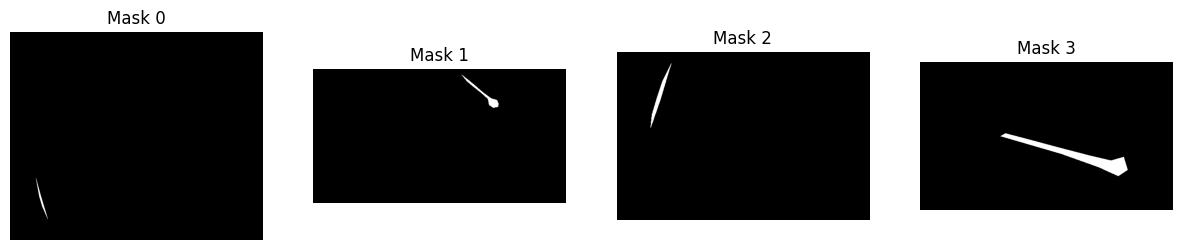

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269
Dataset Image shape: torch.Size([3, 512, 512])
Dataset Mask shape: torch.Size([1, 512, 512])
Dataset Mask min: 0.0, max: 1.0
Dataset Unique mask values: tensor([0., 1.])
Batch Image shape: torch.Size([8, 3, 512, 512])
Batch Mask shape: torch.Size([8, 1, 512, 512])
Batch Mask min: 0.0, max: 1.0
Batch Unique mask values: tensor([0., 1.])
Veri kontrolü başlıyor...
Image shape: torch.Size([8, 3, 512, 512])
Mask shape: torch.Size([8, 1, 512, 512])
Mask min: 0.0, max: 1.0
Unique mask values: tensor([0., 1.])


🚀 Training Epoch 1:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269
Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6783
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6783
Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 1: 100%|██████████| 16/16 [00:04<00:00,  3.74it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 1/50
   Train Loss: 0.7785
   Val Loss: 0.7348 | Val IoU: 0.0098
   Learning Rate: 0.000100
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.0098)


🚀 Training Epoch 2:   6%|▋         | 1/16 [00:00<00:06,  2.20it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6405
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6405


🚀 Training Epoch 2:  12%|█▎        | 2/16 [00:00<00:03,  3.52it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=266
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=266


🚀 Training Epoch 2:  31%|███▏      | 5/16 [00:01<00:02,  5.20it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 2: 100%|██████████| 16/16 [00:03<00:00,  4.77it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 2/50
   Train Loss: 0.7503
   Val Loss: 0.6824 | Val IoU: 0.0125
   Learning Rate: 0.000099
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.0125)


🚀 Training Epoch 3:  25%|██▌       | 4/16 [00:01<00:02,  4.52it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6985
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6985


🚀 Training Epoch 3:  44%|████▍     | 7/16 [00:01<00:01,  5.55it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 3:  50%|█████     | 8/16 [00:02<00:02,  3.19it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269


🚀 Training Epoch 3: 100%|██████████| 16/16 [00:03<00:00,  4.58it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 3/50
   Train Loss: 0.7259
   Val Loss: 0.6680 | Val IoU: 0.0135
   Learning Rate: 0.000098
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.0135)


🚀 Training Epoch 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269


🚀 Training Epoch 4:  50%|█████     | 8/16 [00:02<00:01,  4.01it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 4:  56%|█████▋    | 9/16 [00:02<00:01,  4.47it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6724
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6724


🚀 Training Epoch 4: 100%|██████████| 16/16 [00:03<00:00,  4.30it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 4/50
   Train Loss: 0.7064
   Val Loss: 0.6541 | Val IoU: 0.0142
   Learning Rate: 0.000096
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.0142)


🚀 Training Epoch 5:  50%|█████     | 8/16 [00:02<00:01,  4.18it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269


🚀 Training Epoch 5:  75%|███████▌  | 12/16 [00:02<00:00,  5.52it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6692
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6692
Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 5: 100%|██████████| 16/16 [00:03<00:00,  4.44it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 5/50
   Train Loss: 0.6878
   Val Loss: 0.6447 | Val IoU: 0.0141
   Learning Rate: 0.000093
--------------------------------------------------
Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221

🚀 Training Epoch 6:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6534
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6534


🚀 Training Epoch 6:  44%|████▍     | 7/16 [00:01<00:01,  5.57it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 6:  56%|█████▋    | 9/16 [00:01<00:01,  5.81it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269


🚀 Training Epoch 6: 100%|██████████| 16/16 [00:03<00:00,  4.30it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 6/50
   Train Loss: 0.6709
   Val Loss: 0.6252 | Val IoU: 0.0155
   Learning Rate: 0.000091
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.0155)


🚀 Training Epoch 7:   6%|▋         | 1/16 [00:00<00:08,  1.77it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6724
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6724


🚀 Training Epoch 7:  12%|█▎        | 2/16 [00:00<00:04,  3.03it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 7:  44%|████▍     | 7/16 [00:01<00:01,  4.74it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681


🚀 Training Epoch 7:  50%|█████     | 8/16 [00:02<00:01,  5.11it/s]

Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=179
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=179


🚀 Training Epoch 7: 100%|██████████| 16/16 [00:03<00:00,  4.22it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 7/50
   Train Loss: 0.6552
   Val Loss: 0.6160 | Val IoU: 0.0163
   Learning Rate: 0.000087
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.0163)


🚀 Training Epoch 8:  25%|██▌       | 4/16 [00:01<00:04,  2.47it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=7460
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=7460


🚀 Training Epoch 8:  50%|█████     | 8/16 [00:02<00:01,  4.74it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050

🚀 Training Epoch 8:  56%|█████▋    | 9/16 [00:02<00:01,  5.10it/s]


Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1113
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1113


🚀 Training Epoch 8:  81%|████████▏ | 13/16 [00:03<00:00,  5.78it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=258
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=258


🚀 Training Epoch 8: 100%|██████████| 16/16 [00:03<00:00,  4.55it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 8/50
   Train Loss: 0.6381
   Val Loss: 0.5980 | Val IoU: 0.0192
   Learning Rate: 0.000084
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.0192)


🚀 Training Epoch 9:   6%|▋         | 1/16 [00:01<00:22,  1.47s/it]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6405
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6405
Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269


🚀 Training Epoch 9:  31%|███▏      | 5/16 [00:02<00:03,  3.58it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 9: 100%|██████████| 16/16 [00:03<00:00,  4.05it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 9/50
   Train Loss: 0.6236
   Val Loss: 0.5876 | Val IoU: 0.0211
   Learning Rate: 0.000080
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.0211)


🚀 Training Epoch 10:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=240
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=240
Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 10:  50%|█████     | 8/16 [00:02<00:01,  4.18it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6209
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6209


🚀 Training Epoch 10: 100%|██████████| 16/16 [00:03<00:00,  4.51it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 10/50
   Train Loss: 0.6106
   Val Loss: 0.5834 | Val IoU: 0.0205
   Learning Rate: 0.000075
--------------------------------------------------
Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=122

🚀 Training Epoch 11:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 11:   6%|▋         | 1/16 [00:01<00:20,  1.39s/it]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6405
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6405


🚀 Training Epoch 11:  69%|██████▉   | 11/16 [00:03<00:00,  5.71it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269


🚀 Training Epoch 11: 100%|██████████| 16/16 [00:03<00:00,  4.15it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 11/50
   Train Loss: 0.5992
   Val Loss: 0.5741 | Val IoU: 0.0219
   Learning Rate: 0.000071
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.0219)


🚀 Training Epoch 12:   6%|▋         | 1/16 [00:00<00:10,  1.48it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1106
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1106


🚀 Training Epoch 12:  44%|████▍     | 7/16 [00:02<00:02,  3.18it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6724
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6724


🚀 Training Epoch 12:  56%|█████▋    | 9/16 [00:02<00:01,  4.24it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=282
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=282


🚀 Training Epoch 12: 100%|██████████| 16/16 [00:03<00:00,  4.51it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 12/50
   Train Loss: 0.5904
   Val Loss: 0.5663 | Val IoU: 0.0241
   Learning Rate: 0.000066
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.0241)


🚀 Training Epoch 13:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 13:   6%|▋         | 1/16 [00:00<00:08,  1.87it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=258
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=258


🚀 Training Epoch 13:  19%|█▉        | 3/16 [00:00<00:03,  4.04it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6724
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6724


🚀 Training Epoch 13: 100%|██████████| 16/16 [00:03<00:00,  4.62it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 13/50
   Train Loss: 0.5807
   Val Loss: 0.5576 | Val IoU: 0.0315
   Learning Rate: 0.000061
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.0315)


🚀 Training Epoch 14:  19%|█▉        | 3/16 [00:00<00:03,  4.30it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=994
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=994


🚀 Training Epoch 14:  31%|███▏      | 5/16 [00:01<00:02,  5.23it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=306
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=306


🚀 Training Epoch 14:  56%|█████▋    | 9/16 [00:02<00:02,  2.41it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=7115
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=7115


🚀 Training Epoch 14: 100%|██████████| 16/16 [00:03<00:00,  4.31it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 14/50
   Train Loss: 0.5739
   Val Loss: 0.5522 | Val IoU: 0.0499
   Learning Rate: 0.000056
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.0499)


🚀 Training Epoch 15:  25%|██▌       | 4/16 [00:01<00:03,  3.71it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1262
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1262


🚀 Training Epoch 15:  31%|███▏      | 5/16 [00:01<00:02,  4.29it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6065
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6065


🚀 Training Epoch 15:  50%|█████     | 8/16 [00:01<00:01,  5.42it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269


🚀 Training Epoch 15: 100%|██████████| 16/16 [00:03<00:00,  4.47it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 15/50
   Train Loss: 0.5682
   Val Loss: 0.5470 | Val IoU: 0.0625
   Learning Rate: 0.000051
--------------------------------------------------
Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=122

🚀 Training Epoch 16:   6%|▋         | 1/16 [00:00<00:07,  1.93it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=258
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=258


🚀 Training Epoch 16:  25%|██▌       | 4/16 [00:02<00:05,  2.35it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1016
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1016


🚀 Training Epoch 16:  50%|█████     | 8/16 [00:02<00:01,  4.67it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6724
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6724


🚀 Training Epoch 16: 100%|██████████| 16/16 [00:04<00:00,  3.92it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 16/50
   Train Loss: 0.5622
   Val Loss: 0.5423 | Val IoU: 0.0744
   Learning Rate: 0.000045
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.0744)


🚀 Training Epoch 17:  12%|█▎        | 2/16 [00:00<00:04,  3.36it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269


🚀 Training Epoch 17:  38%|███▊      | 6/16 [00:02<00:02,  3.68it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1249
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1249


🚀 Training Epoch 17:  62%|██████▎   | 10/16 [00:02<00:01,  5.31it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6724
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6724


🚀 Training Epoch 17: 100%|██████████| 16/16 [00:03<00:00,  4.31it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 17/50
   Train Loss: 0.5578
   Val Loss: 0.5375 | Val IoU: 0.0900
   Learning Rate: 0.000040
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.0900)


🚀 Training Epoch 18:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=275
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=275
Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 18:   6%|▋         | 1/16 [00:00<00:08,  1.77it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6724
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6724


🚀 Training Epoch 18: 100%|██████████| 16/16 [00:03<00:00,  4.26it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 18/50
   Train Loss: 0.5516
   Val Loss: 0.5344 | Val IoU: 0.0990
   Learning Rate: 0.000035
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.0990)


🚀 Training Epoch 19:   6%|▋         | 1/16 [00:00<00:09,  1.54it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=267
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=267
Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 19:  25%|██▌       | 4/16 [00:01<00:02,  4.33it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=7603
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=7603


🚀 Training Epoch 19: 100%|██████████| 16/16 [00:03<00:00,  4.55it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 19/50
   Train Loss: 0.5499
   Val Loss: 0.5322 | Val IoU: 0.1024
   Learning Rate: 0.000030
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.1024)


🚀 Training Epoch 20:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6534
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6534


🚀 Training Epoch 20:  25%|██▌       | 4/16 [00:00<00:02,  4.78it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119

🚀 Training Epoch 20:  31%|███▏      | 5/16 [00:01<00:02,  5.19it/s]

🚀 Training Epoch 20:  56%|█████▋    | 9/16 [00:02<00:01,  3.89it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269


🚀 Training Epoch 20: 100%|██████████| 16/16 [00:03<00:00,  4.73it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 20/50
   Train Loss: 0.5458
   Val Loss: 0.5298 | Val IoU: 0.1090
   Learning Rate: 0.000026
--------------------------------------------------
Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=122

🚀 Training Epoch 21:  31%|███▏      | 5/16 [00:01<00:02,  5.02it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1262
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1262


🚀 Training Epoch 21:  62%|██████▎   | 10/16 [00:02<00:01,  5.87it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269


🚀 Training Epoch 21:  69%|██████▉   | 11/16 [00:02<00:00,  5.88it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=5799
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=5799


🚀 Training Epoch 21: 100%|██████████| 16/16 [00:03<00:00,  4.70it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 21/50
   Train Loss: 0.5418
   Val Loss: 0.5262 | Val IoU: 0.1234
   Learning Rate: 0.000021
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.1234)


🚀 Training Epoch 22:  19%|█▉        | 3/16 [00:00<00:03,  4.25it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119
Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6405
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6405


🚀 Training Epoch 22:  31%|███▏      | 5/16 [00:01<00:03,  3.09it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269


🚀 Training Epoch 22: 100%|██████████| 16/16 [00:03<00:00,  4.62it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 22/50
   Train Loss: 0.5408
   Val Loss: 0.5247 | Val IoU: 0.1340
   Learning Rate: 0.000017
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.1340)


🚀 Training Epoch 23:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 23:   6%|▋         | 1/16 [00:00<00:07,  2.03it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340


🚀 Training Epoch 23:  12%|█▎        | 2/16 [00:00<00:04,  3.33it/s]

Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6724
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6724


🚀 Training Epoch 23:  44%|████▍     | 7/16 [00:02<00:03,  2.84it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269


🚀 Training Epoch 23: 100%|██████████| 16/16 [00:04<00:00,  3.93it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 23/50
   Train Loss: 0.5386
   Val Loss: 0.5233 | Val IoU: 0.1432
   Learning Rate: 0.000014
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.1432)


🚀 Training Epoch 24:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=301
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=301
Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 24:  25%|██▌       | 4/16 [00:01<00:05,  2.11it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6724
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6724


🚀 Training Epoch 24: 100%|██████████| 16/16 [00:03<00:00,  4.42it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 24/50
   Train Loss: 0.5374
   Val Loss: 0.5217 | Val IoU: 0.1460
   Learning Rate: 0.000010
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.1460)


🚀 Training Epoch 25:   6%|▋         | 1/16 [00:00<00:06,  2.20it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6621
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6621
Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269


🚀 Training Epoch 25:  56%|█████▋    | 9/16 [00:02<00:02,  3.44it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 25: 100%|██████████| 16/16 [00:03<00:00,  4.83it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 25/50
   Train Loss: 0.5366
   Val Loss: 0.5209 | Val IoU: 0.1592
   Learning Rate: 0.000008
--------------------------------------------------
Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=122

🚀 Training Epoch 26:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=275
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=275


🚀 Training Epoch 26:  81%|████████▏ | 13/16 [00:02<00:00,  5.99it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=7115
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=7115
Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 26: 100%|██████████| 16/16 [00:03<00:00,  4.21it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 26/50
   Train Loss: 0.5344
   Val Loss: 0.5210 | Val IoU: 0.1672
   Learning Rate: 0.000005
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.1672)


🚀 Training Epoch 27:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6724
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6724
Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269


🚀 Training Epoch 27:  38%|███▊      | 6/16 [00:01<00:01,  5.48it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1249
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1249


🚀 Training Epoch 27: 100%|██████████| 16/16 [00:03<00:00,  4.81it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 27/50
   Train Loss: 0.5351
   Val Loss: 0.5203 | Val IoU: 0.1628
   Learning Rate: 0.000003
--------------------------------------------------


🚀 Training Epoch 28:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 28:  25%|██▌       | 4/16 [00:01<00:02,  4.50it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=267
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=267


🚀 Training Epoch 28:  56%|█████▋    | 9/16 [00:02<00:01,  5.26it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6692
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6692


🚀 Training Epoch 28: 100%|██████████| 16/16 [00:03<00:00,  4.38it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 28/50
   Train Loss: 0.5345
   Val Loss: 0.5202 | Val IoU: 0.1616
   Learning Rate: 0.000002
--------------------------------------------------


🚀 Training Epoch 29:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6724
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6724


🚀 Training Epoch 29:  12%|█▎        | 2/16 [00:00<00:04,  3.45it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=250
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=250


🚀 Training Epoch 29:  19%|█▉        | 3/16 [00:00<00:03,  4.29it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1139
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1139


🚀 Training Epoch 29: 100%|██████████| 16/16 [00:03<00:00,  4.77it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 29/50
   Train Loss: 0.5346
   Val Loss: 0.5195 | Val IoU: 0.1611
   Learning Rate: 0.000001
--------------------------------------------------


🚀 Training Epoch 30:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269
Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 30:  12%|█▎        | 2/16 [00:00<00:04,  3.04it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6724
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6724


🚀 Training Epoch 30: 100%|██████████| 16/16 [00:03<00:00,  4.18it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 30/50
   Train Loss: 0.5346
   Val Loss: 0.5193 | Val IoU: 0.1630
   Learning Rate: 0.000001
--------------------------------------------------
Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=122

🚀 Training Epoch 31:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6534
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6534


🚀 Training Epoch 31:  12%|█▎        | 2/16 [00:00<00:04,  3.24it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=298
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=298


🚀 Training Epoch 31:  44%|████▍     | 7/16 [00:01<00:01,  5.53it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 31: 100%|██████████| 16/16 [00:03<00:00,  4.61it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 31/50
   Train Loss: 0.5349
   Val Loss: 0.5197 | Val IoU: 0.1667
   Learning Rate: 0.000001
--------------------------------------------------


🚀 Training Epoch 32:  50%|█████     | 8/16 [00:01<00:01,  5.53it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269
Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6724
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6724


🚀 Training Epoch 32:  62%|██████▎   | 10/16 [00:02<00:01,  5.70it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1187
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1187


🚀 Training Epoch 32: 100%|██████████| 16/16 [00:03<00:00,  4.52it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 32/50
   Train Loss: 0.5348
   Val Loss: 0.5198 | Val IoU: 0.1670
   Learning Rate: 0.000002
--------------------------------------------------


🚀 Training Epoch 33:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=272
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=272


🚀 Training Epoch 33:  38%|███▊      | 6/16 [00:01<00:01,  5.49it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6015
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6015


🚀 Training Epoch 33:  44%|████▍     | 7/16 [00:01<00:01,  5.68it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 33: 100%|██████████| 16/16 [00:03<00:00,  4.76it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 33/50
   Train Loss: 0.5351
   Val Loss: 0.5192 | Val IoU: 0.1644
   Learning Rate: 0.000003
--------------------------------------------------


🚀 Training Epoch 34:  62%|██████▎   | 10/16 [00:02<00:01,  5.50it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=5799
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=5799
Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1062
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1062


🚀 Training Epoch 34:  69%|██████▉   | 11/16 [00:03<00:00,  5.60it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=95
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=95


🚀 Training Epoch 34: 100%|██████████| 16/16 [00:03<00:00,  4.16it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 34/50
   Train Loss: 0.5350
   Val Loss: 0.5188 | Val IoU: 0.1700
   Learning Rate: 0.000005
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.1700)


🚀 Training Epoch 35:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6724
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6724


🚀 Training Epoch 35:  12%|█▎        | 2/16 [00:00<00:04,  3.30it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=245
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=245


🚀 Training Epoch 35:  25%|██▌       | 4/16 [00:00<00:02,  4.76it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1198
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1198


🚀 Training Epoch 35: 100%|██████████| 16/16 [00:03<00:00,  4.79it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 35/50
   Train Loss: 0.5324
   Val Loss: 0.5173 | Val IoU: 0.1726
   Learning Rate: 0.000008
--------------------------------------------------
Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=122

🚀 Training Epoch 36:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=240
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=240
Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6724
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6724


🚀 Training Epoch 36:  75%|███████▌  | 12/16 [00:03<00:00,  4.36it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1054
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1054


🚀 Training Epoch 36: 100%|██████████| 16/16 [00:03<00:00,  4.17it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 36/50
   Train Loss: 0.5335
   Val Loss: 0.5167 | Val IoU: 0.1792
   Learning Rate: 0.000010
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.1792)


🚀 Training Epoch 37:   6%|▋         | 1/16 [00:00<00:09,  1.56it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269


🚀 Training Epoch 37:  19%|█▉        | 3/16 [00:01<00:07,  1.71it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 37:  31%|███▏      | 5/16 [00:01<00:03,  3.06it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6724
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6724


🚀 Training Epoch 37: 100%|██████████| 16/16 [00:03<00:00,  4.20it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 37/50
   Train Loss: 0.5325
   Val Loss: 0.5160 | Val IoU: 0.1865
   Learning Rate: 0.000014
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.1865)


🚀 Training Epoch 38:  19%|█▉        | 3/16 [00:00<00:03,  3.64it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6724
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6724


🚀 Training Epoch 38:  25%|██▌       | 4/16 [00:01<00:04,  2.74it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=306
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=306


🚀 Training Epoch 38:  44%|████▍     | 7/16 [00:01<00:01,  4.50it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119

🚀 Training Epoch 38:  50%|█████     | 8/16 [00:02<00:01,  4.90it/s]

🚀 Training Epoch 38: 100%|██████████| 16/16 [00:03<00:00,  4.61it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 38/50
   Train Loss: 0.5303
   Val Loss: 0.5144 | Val IoU: 0.2014
   Learning Rate: 0.000017
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.2014)


🚀 Training Epoch 39:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1259
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1259
Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=240
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=240


🚀 Training Epoch 39:   6%|▋         | 1/16 [00:00<00:06,  2.16it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6646
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6646


🚀 Training Epoch 39: 100%|██████████| 16/16 [00:03<00:00,  4.00it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 39/50
   Train Loss: 0.5283
   Val Loss: 0.5140 | Val IoU: 0.2139
   Learning Rate: 0.000021
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.2139)


🚀 Training Epoch 40:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269


🚀 Training Epoch 40:  38%|███▊      | 6/16 [00:02<00:02,  4.22it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1163
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1163


🚀 Training Epoch 40:  69%|██████▉   | 11/16 [00:03<00:00,  5.69it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=5799
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=5799


🚀 Training Epoch 40: 100%|██████████| 16/16 [00:03<00:00,  4.09it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 40/50
   Train Loss: 0.5266
   Val Loss: 0.5119 | Val IoU: 0.2268
   Learning Rate: 0.000026
--------------------------------------------------
Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=122

🚀 Training Epoch 41:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269
Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6724
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6724


🚀 Training Epoch 41:  69%|██████▉   | 11/16 [00:02<00:00,  5.55it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 41: 100%|██████████| 16/16 [00:03<00:00,  4.33it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 41/50
   Train Loss: 0.5259
   Val Loss: 0.5088 | Val IoU: 0.2395
   Learning Rate: 0.000030
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.2395)


🚀 Training Epoch 42:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 42:  44%|████▍     | 7/16 [00:01<00:01,  5.65it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6724
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6724


🚀 Training Epoch 42:  62%|██████▎   | 10/16 [00:01<00:01,  5.92it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269


🚀 Training Epoch 42: 100%|██████████| 16/16 [00:03<00:00,  4.81it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 42/50
   Train Loss: 0.5224
   Val Loss: 0.5072 | Val IoU: 0.2637
   Learning Rate: 0.000035
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.2637)


🚀 Training Epoch 43:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 43:   6%|▋         | 1/16 [00:00<00:08,  1.87it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6724
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6724


🚀 Training Epoch 43:  31%|███▏      | 5/16 [00:01<00:04,  2.50it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269


🚀 Training Epoch 43: 100%|██████████| 16/16 [00:03<00:00,  4.46it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 43/50
   Train Loss: 0.5207
   Val Loss: 0.5048 | Val IoU: 0.2742
   Learning Rate: 0.000040
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.2742)


🚀 Training Epoch 44:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6724
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6724
Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 44:  38%|███▊      | 6/16 [00:01<00:01,  5.36it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681


🚀 Training Epoch 44:  44%|████▍     | 7/16 [00:01<00:01,  5.57it/s]

Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269


🚀 Training Epoch 44: 100%|██████████| 16/16 [00:03<00:00,  4.19it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 44/50
   Train Loss: 0.5179
   Val Loss: 0.4991 | Val IoU: 0.3057
   Learning Rate: 0.000045
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.3057)


🚀 Training Epoch 45:  12%|█▎        | 2/16 [00:00<00:04,  3.05it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 45:  25%|██▌       | 4/16 [00:01<00:02,  4.58it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340


🚀 Training Epoch 45:  31%|███▏      | 5/16 [00:01<00:02,  5.04it/s]

Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6065
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6065


🚀 Training Epoch 45:  69%|██████▉   | 11/16 [00:02<00:00,  5.88it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=95
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=95


🚀 Training Epoch 45: 100%|██████████| 16/16 [00:03<00:00,  4.65it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 45/50
   Train Loss: 0.5136
   Val Loss: 0.4965 | Val IoU: 0.3245
   Learning Rate: 0.000051
--------------------------------------------------
Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=122

🚀 Training Epoch 46:  44%|████▍     | 7/16 [00:01<00:01,  5.53it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6065
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6065


🚀 Training Epoch 46:  50%|█████     | 8/16 [00:02<00:02,  3.36it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269


🚀 Training Epoch 46:  69%|██████▉   | 11/16 [00:02<00:01,  4.76it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=964
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=964


🚀 Training Epoch 46: 100%|██████████| 16/16 [00:03<00:00,  4.65it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 46/50
   Train Loss: 0.5104
   Val Loss: 0.4895 | Val IoU: 0.3612
   Learning Rate: 0.000056
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.3612)


🚀 Training Epoch 47:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6724
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6724


🚀 Training Epoch 47:   6%|▋         | 1/16 [00:00<00:13,  1.13it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1063
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1063


🚀 Training Epoch 47:  12%|█▎        | 2/16 [00:01<00:06,  2.15it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=245
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=245


🚀 Training Epoch 47: 100%|██████████| 16/16 [00:03<00:00,  4.13it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 47/50
   Train Loss: 0.5046
   Val Loss: 0.4862 | Val IoU: 0.3748
   Learning Rate: 0.000061
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.3748)


🚀 Training Epoch 48:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119

🚀 Training Epoch 48:   6%|▋         | 1/16 [00:00<00:06,  2.17it/s]


Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 48:  50%|█████     | 8/16 [00:02<00:01,  4.08it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269


🚀 Training Epoch 48:  62%|██████▎   | 10/16 [00:02<00:01,  4.93it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6692
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6692


🚀 Training Epoch 48: 100%|██████████| 16/16 [00:03<00:00,  4.70it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 48/50
   Train Loss: 0.5035
   Val Loss: 0.4802 | Val IoU: 0.3828
   Learning Rate: 0.000066
--------------------------------------------------
✅ Yeni en iyi model kaydedildi: /content/unet_best_20250514_130318.pth (IoU: 0.3828)


🚀 Training Epoch 49:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1149
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1149


🚀 Training Epoch 49:   6%|▋         | 1/16 [00:01<00:21,  1.40s/it]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=269
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=269
Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6724
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6724


🚀 Training Epoch 49: 100%|██████████| 16/16 [00:04<00:00,  3.92it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 49/50
   Train Loss: 0.4959
   Val Loss: 0.4713 | Val IoU: 0.3695
   Learning Rate: 0.000071
--------------------------------------------------


🚀 Training Epoch 50:   0%|          | 0/16 [00:00<?, ?it/s]

Sample 1: Original mask shape=(360, 680), min=0, max=1, non-zero pixels=1050
Sample 1: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1119
Sample 1: Final mask min=0.0, max=1.0, non-zero pixels=1119


🚀 Training Epoch 50:  12%|█▎        | 2/16 [00:00<00:04,  2.88it/s]

Sample 0: Original mask shape=(740, 900), min=0, max=1, non-zero pixels=681
Sample 0: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=250
Sample 0: Final mask min=0.0, max=1.0, non-zero pixels=250


🚀 Training Epoch 50:  62%|██████▎   | 10/16 [00:02<00:01,  4.53it/s]

Sample 3: Original mask shape=(408, 700), min=0, max=1, non-zero pixels=7340
Sample 3: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=6989
Sample 3: Final mask min=0.0, max=1.0, non-zero pixels=6989


🚀 Training Epoch 50: 100%|██████████| 16/16 [00:03<00:00,  4.51it/s]


Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=1221
Sample 2: Final mask min=0.0, max=1.0, non-zero pixels=1221
📅 Epoch 50/50
   Train Loss: 0.4884
   Val Loss: 0.4673 | Val IoU: 0.4426
   Learning Rate: 0.000075
--------------------------------------------------
Sample 4: Original mask shape=(598, 900), min=0, max=1, non-zero pixels=655
Sample 4: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=315
Sample 4: Final mask min=0.0, max=1.0, non-zero pixels=315
Sample 2: Original mask shape=(407, 612), min=0, max=1, non-zero pixels=1155
Sample 2: After aug mask shape=torch.Size([512, 512]), min=0, max=255, non-zero pixels=122

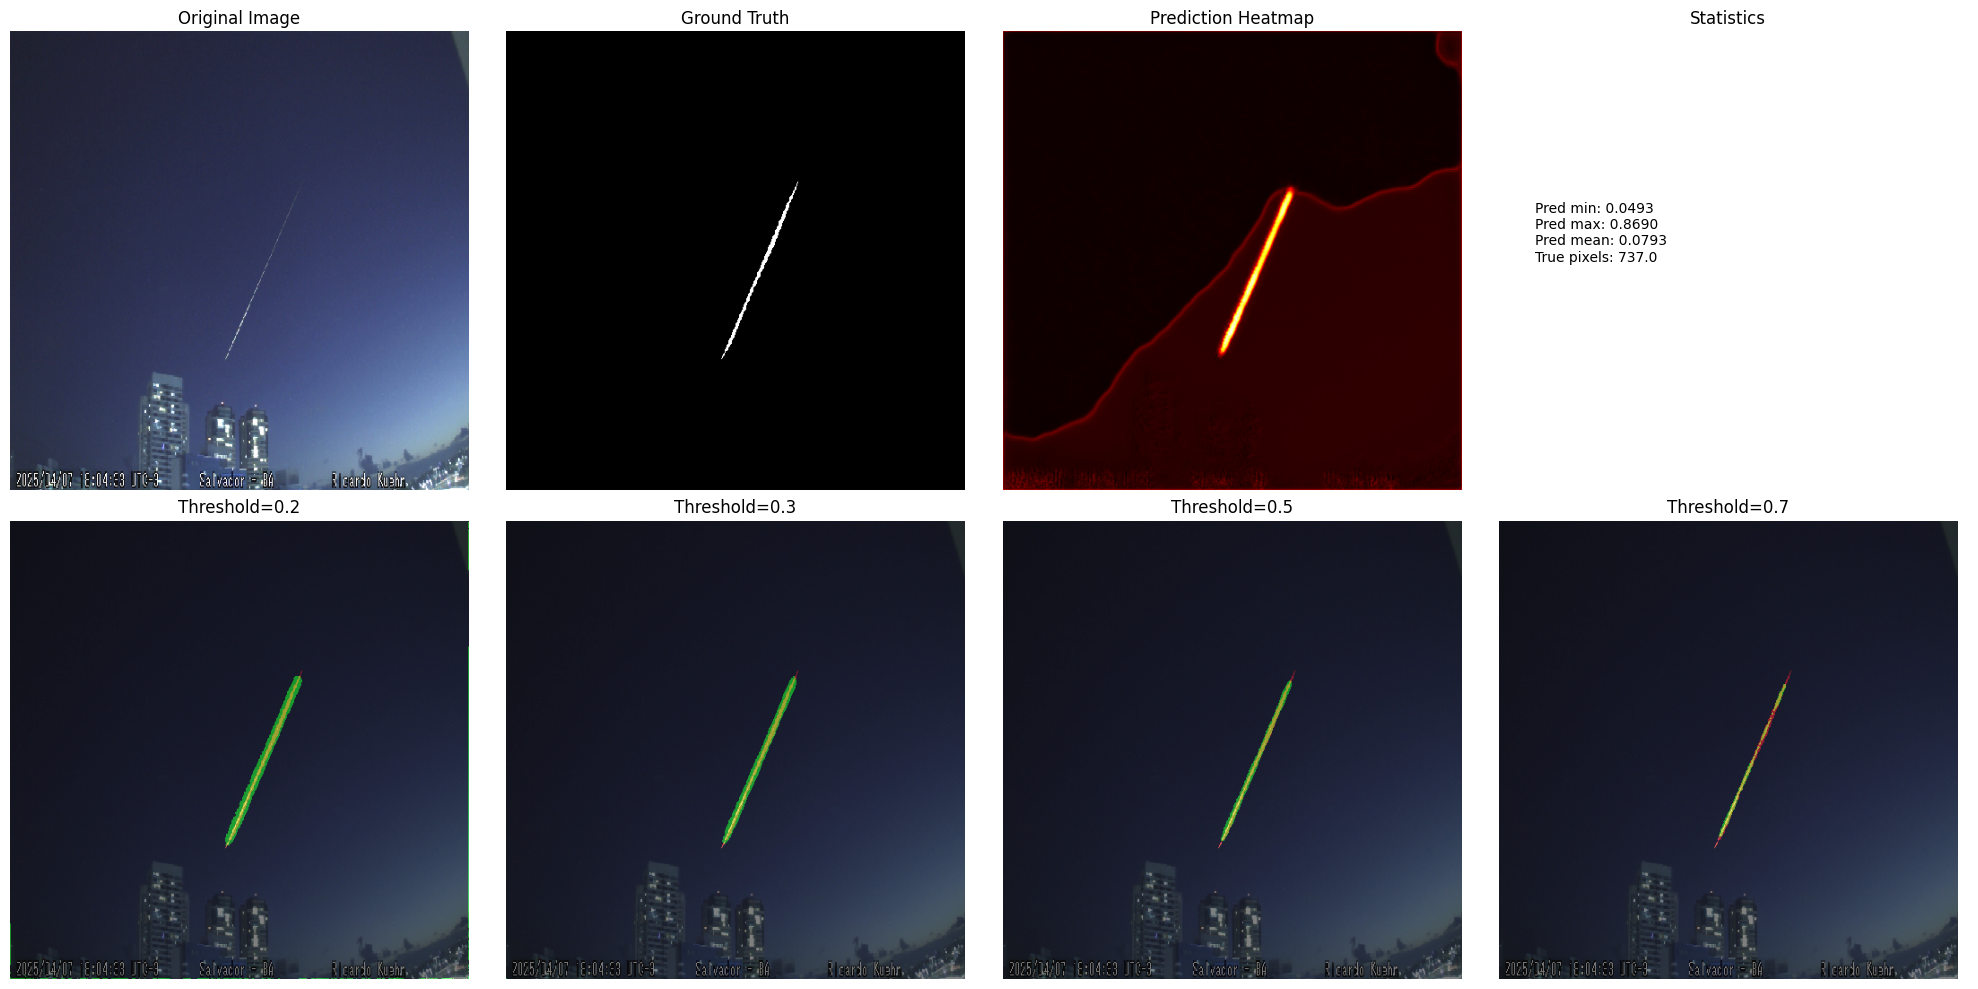


Sample 6 statistics:
Ground truth non-zero pixels: 737.0
Prediction range: [0.0493, 0.8690]
IoU at threshold 0.2: 0.4079
IoU at threshold 0.3: 0.5927
IoU at threshold 0.5: 0.7319
IoU at threshold 0.7: 0.7351


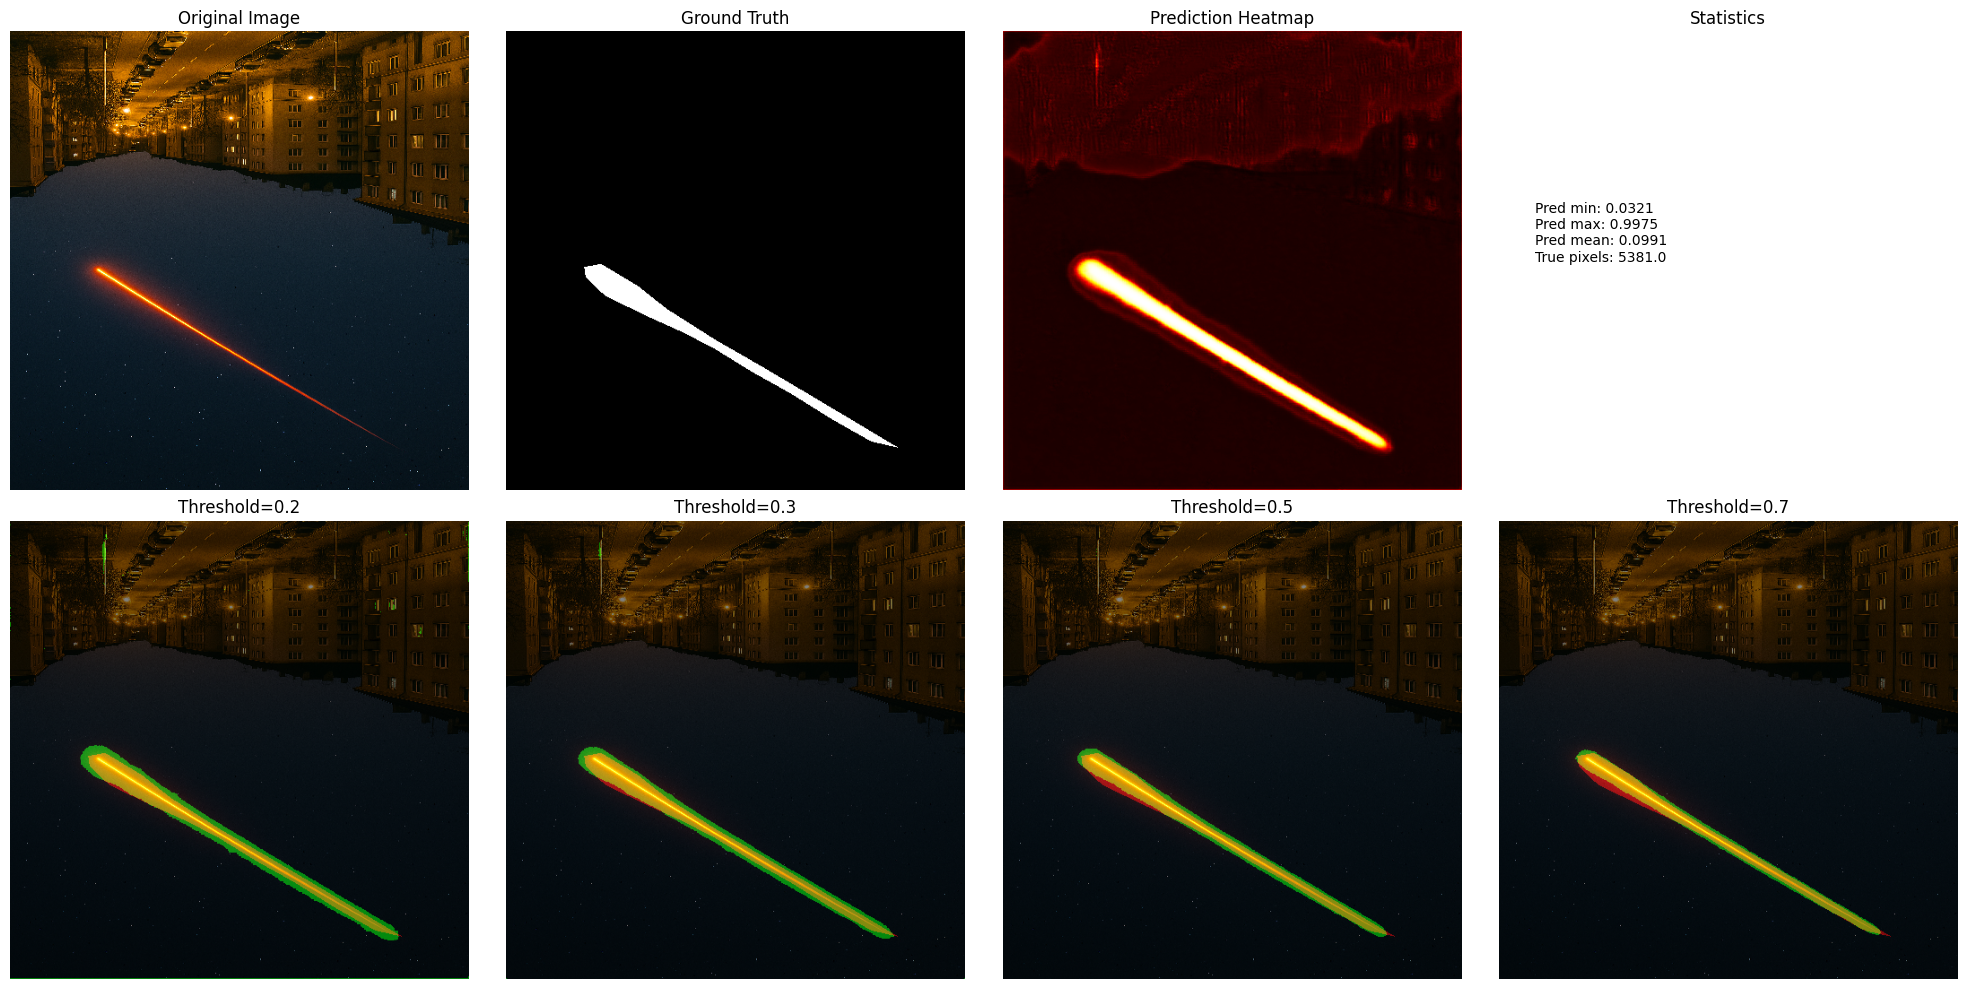


Sample 20 statistics:
Ground truth non-zero pixels: 5381.0
Prediction range: [0.0321, 0.9975]
IoU at threshold 0.2: 0.7064
IoU at threshold 0.3: 0.7792
IoU at threshold 0.5: 0.8182
IoU at threshold 0.7: 0.8503


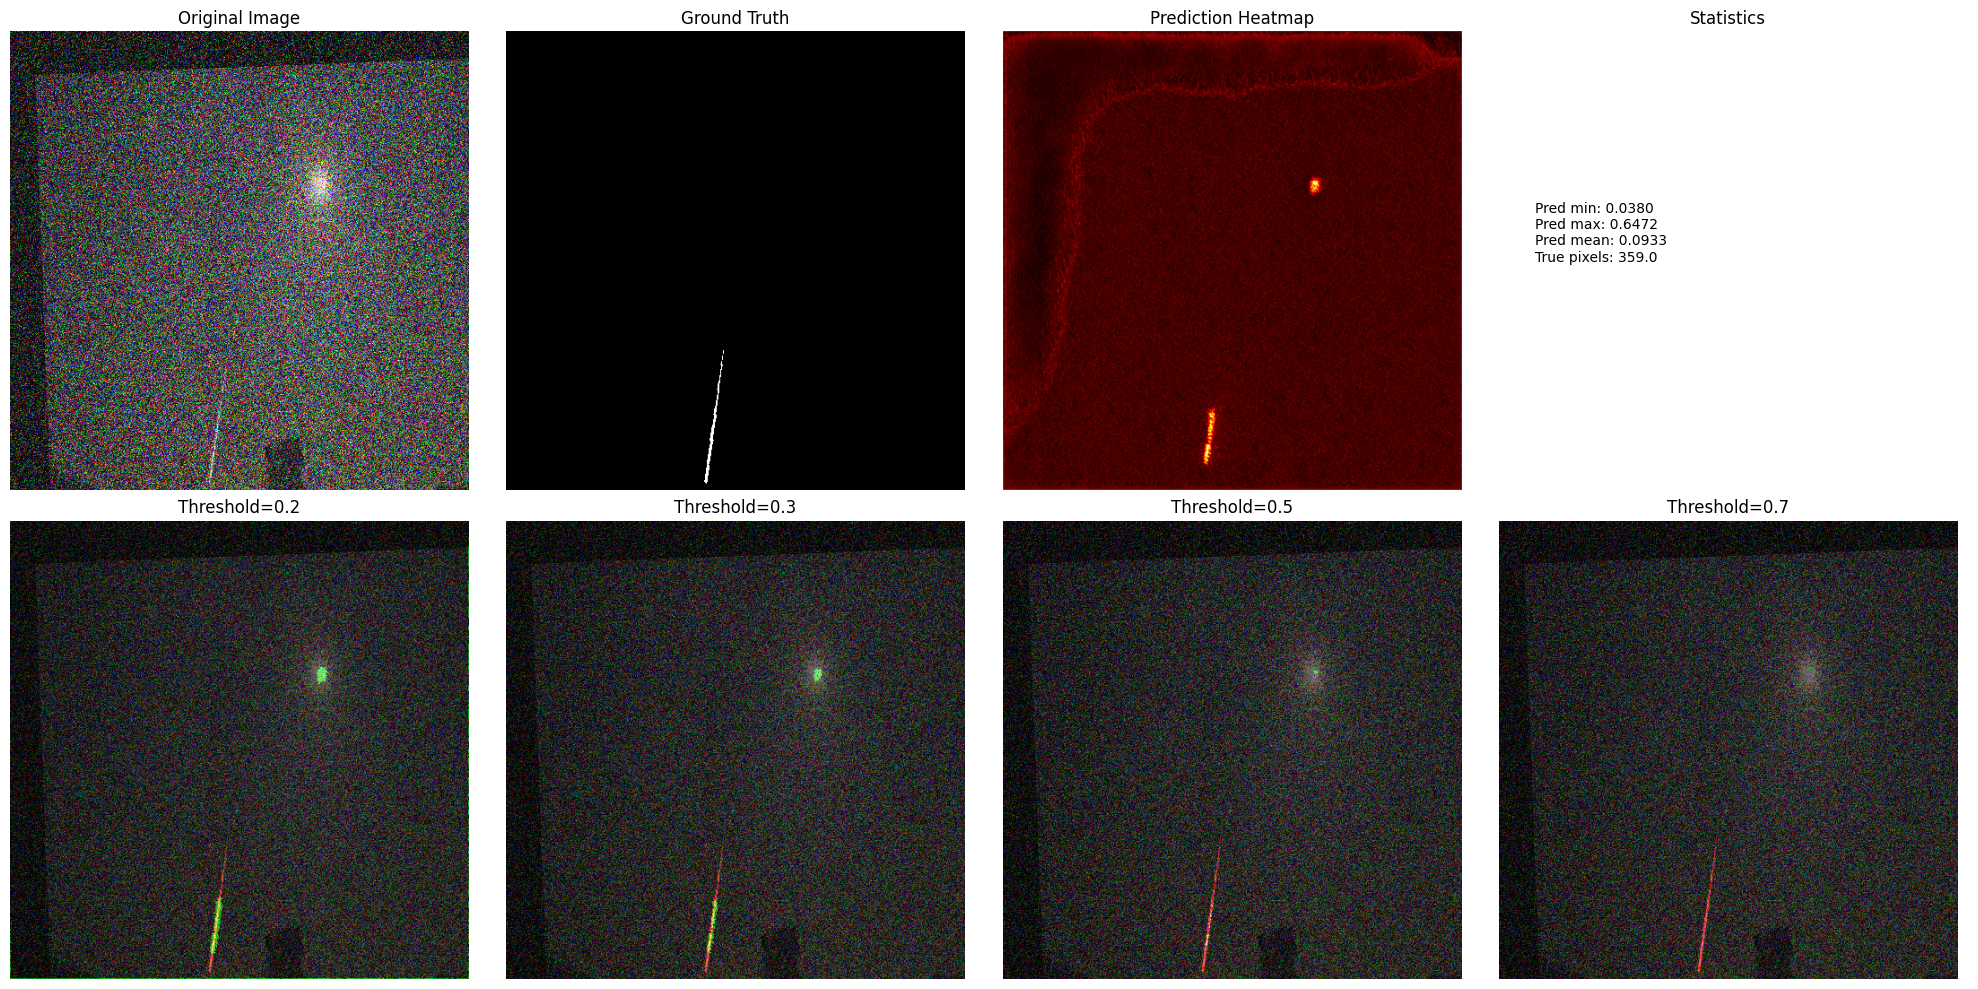


Sample 7 statistics:
Ground truth non-zero pixels: 359.0
Prediction range: [0.0380, 0.6472]
IoU at threshold 0.2: 0.2105
IoU at threshold 0.3: 0.4239
IoU at threshold 0.5: 0.2038
IoU at threshold 0.7: 0.0000


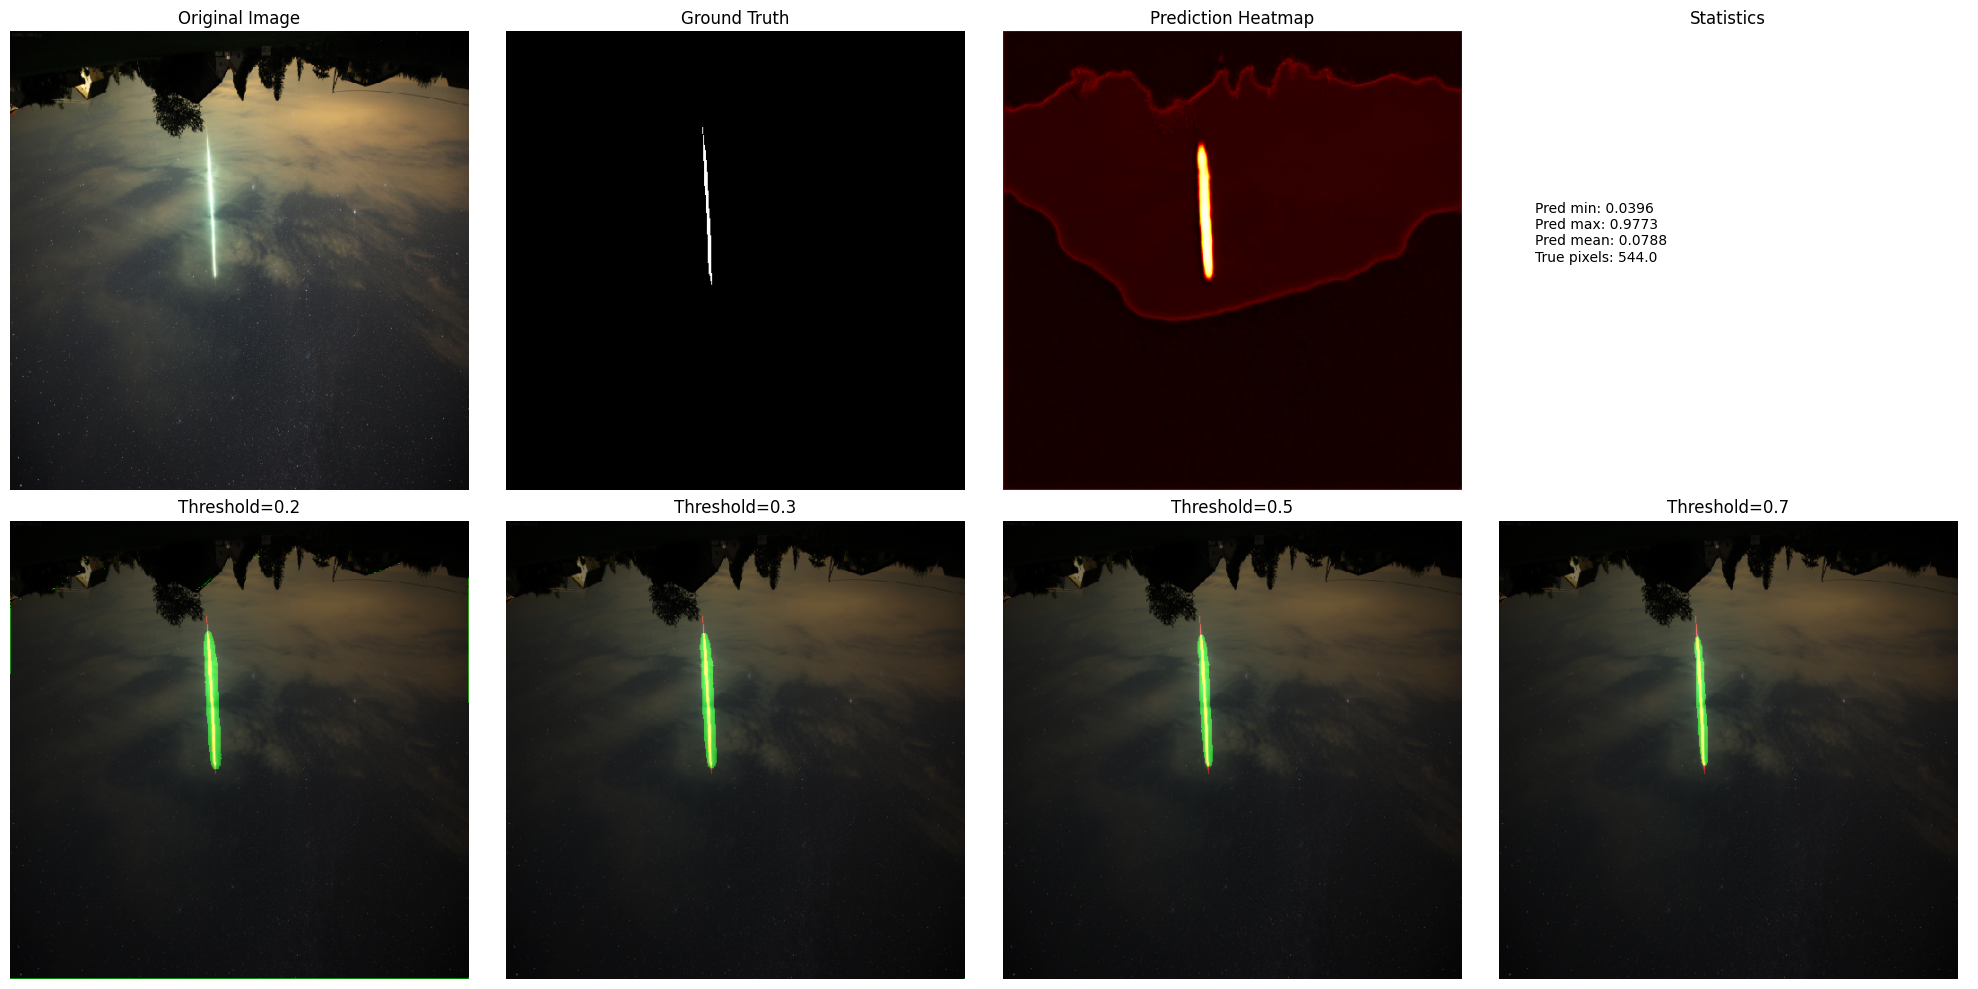


Sample 21 statistics:
Ground truth non-zero pixels: 544.0
Prediction range: [0.0396, 0.9773]
IoU at threshold 0.2: 0.3112
IoU at threshold 0.3: 0.4360
IoU at threshold 0.5: 0.4832
IoU at threshold 0.7: 0.5399


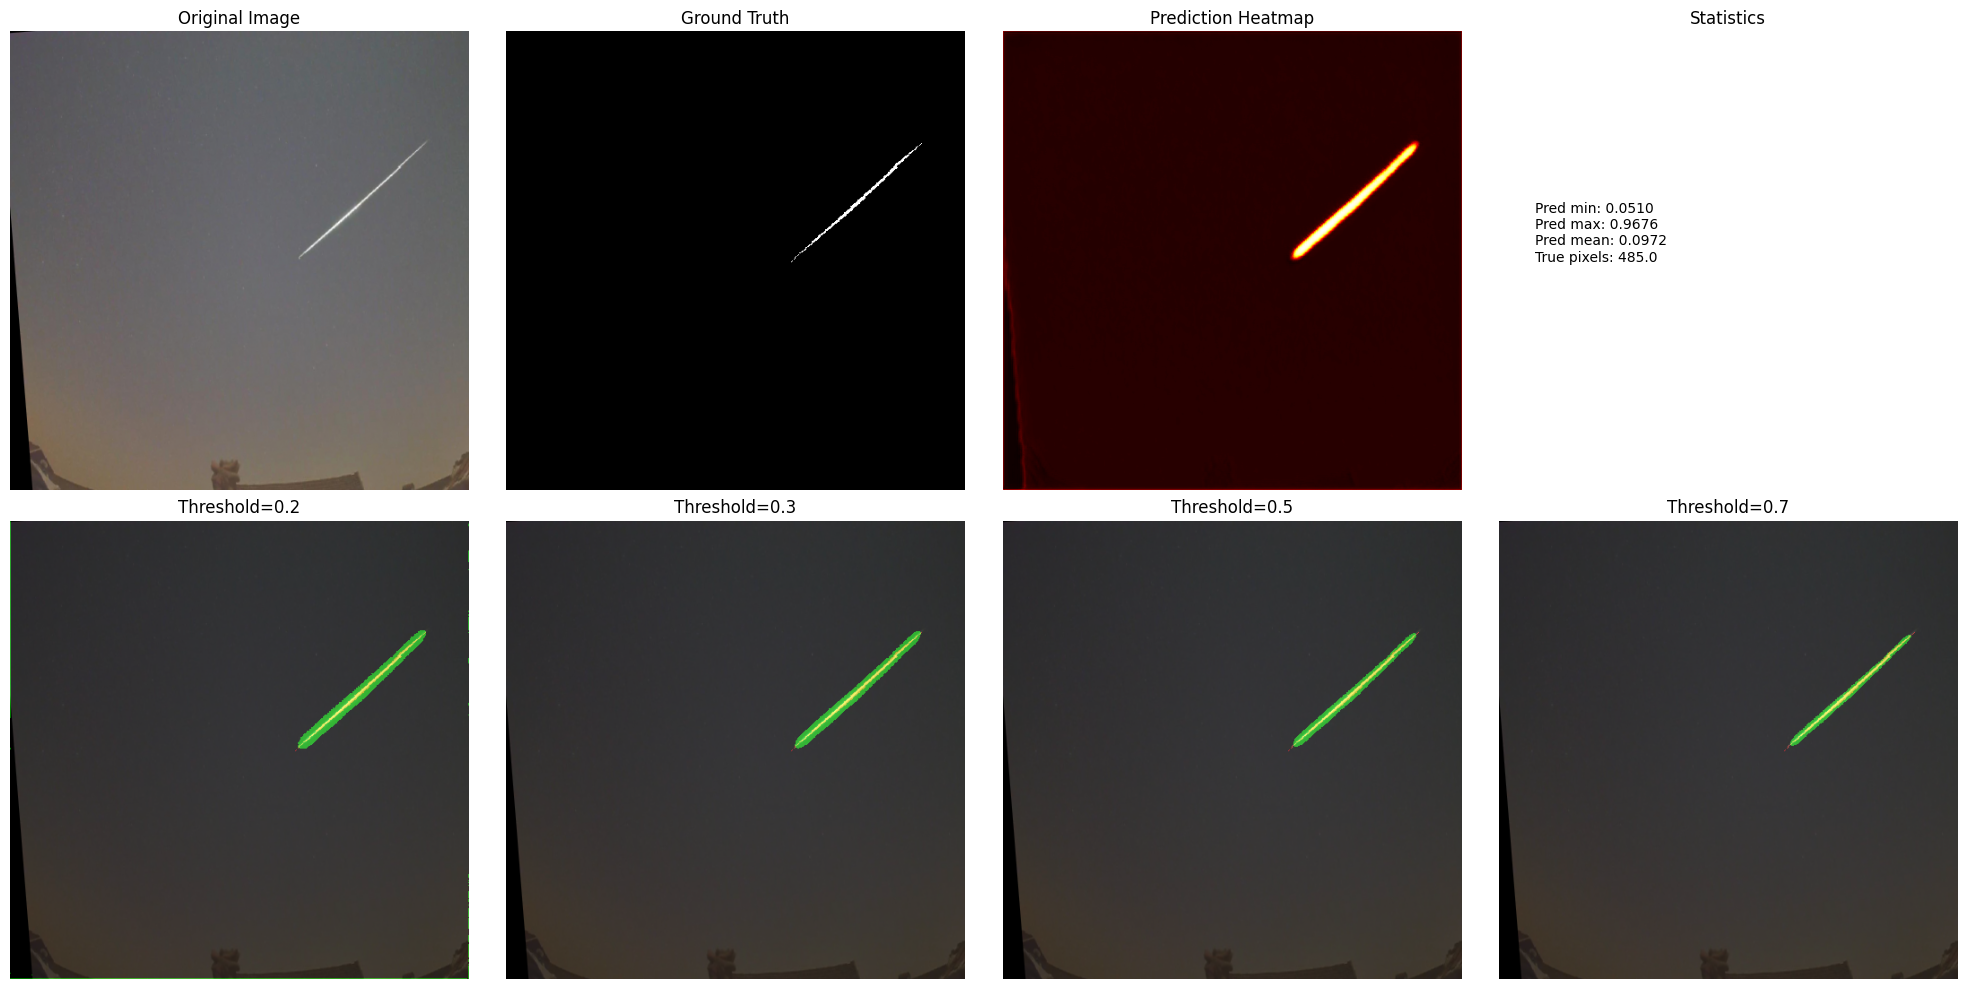


Sample 4 statistics:
Ground truth non-zero pixels: 485.0
Prediction range: [0.0510, 0.9676]
IoU at threshold 0.2: 0.2499
IoU at threshold 0.3: 0.3579
IoU at threshold 0.5: 0.4192
IoU at threshold 0.7: 0.5013


In [ ]:
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch
import segmentation_models_pytorch as smp
import torch
import os
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import time
import datetime
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Daha güçlü backbone ve attention mekanizmalı model
model = smp.Unet(
    encoder_name="efficientnet-b4",  # ResNet34 yerine EfficientNet-B4 (daha güçlü)
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    decoder_channels=(256, 128, 64, 32, 16),  # Daha derin decoder
    decoder_attention_type="scse"  # Spatial & Channel Squeeze & Excitation eklendi
).to(device)

# Kombinasyon loss fonksiyonu (BCE + Dice Loss)
class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight

    def dice_loss(self, pred, target, smooth=1e-6):
        pred = torch.sigmoid(pred)
        intersection = (pred * target).sum()
        union = pred.sum() + target.sum()
        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice

    def forward(self, pred, target):
        bce = self.bce(pred, target)
        dice = self.dice_loss(pred, target)
        return self.bce_weight * bce + self.dice_weight * dice

loss_fn = CombinedLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

# Learning rate scheduler eklendi
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)

def train_one_epoch(model, loader, epoch):
    model.train()
    total_loss = 0

    for imgs, masks in tqdm(loader, desc=f"🚀 Training Epoch {epoch}"):
        imgs, masks = imgs.to(device), masks.to(device)
        if masks.ndim == 3:
            masks = masks.unsqueeze(1)

        preds = model(imgs)
        loss = loss_fn(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    return total_loss / len(loader)

def calculate_iou(pred, target, threshold=0.2):
    """IoU (Intersection over Union) metriği - daha düşük threshold"""
    pred_sigmoid = torch.sigmoid(pred)
    pred_binary = (pred_sigmoid > threshold).float()

    intersection = (pred_binary * target).sum()
    union = pred_binary.sum() + target.sum() - intersection

    if union == 0:
        # Check if both pred and target are empty
        if target.sum() == 0 and pred_binary.sum() == 0:
            return 1.0  # Perfect match for empty masks
        return 0.0

    iou = intersection / (union + 1e-8)
    return iou.item()

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    total_iou = 0

    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            if masks.ndim == 3:
                masks = masks.unsqueeze(1)

            preds = model(imgs)
            loss = loss_fn(preds, masks)
            iou = calculate_iou(preds, masks)

            total_loss += loss.item()
            total_iou += iou

    return total_loss / len(loader), total_iou / len(loader)

def train_model(model, train_loader, val_loader, epochs=30):
    best_iou = 0.0
    best_loss = float('inf')
    save_path = f"/content/unet_best_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"

    # İlk epoch model kaydetme
    torch.save(model.state_dict(), save_path)

    for epoch in range(1, epochs + 1):
        train_loss = train_one_epoch(model, train_loader, epoch)
        val_loss, val_iou = evaluate(model, val_loader)

        print(f"📅 Epoch {epoch}/{epochs}")
        print(f"   Train Loss: {train_loss:.4f}")
        print(f"   Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}")
        print(f"   Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
        print("-" * 50)

        # Debug: Prediction kontrolü
        if epoch % 5 == 0:
            model.eval()
            with torch.no_grad():
                for imgs, masks in val_loader:
                    imgs = imgs.to(device)
                    preds = model(imgs)
                    preds_sigmoid = torch.sigmoid(preds)
                    print(f"Debug: Prediction range [{preds_sigmoid.min():.4f}, {preds_sigmoid.max():.4f}]")
                    break

        # Model kaydetme stratejisi (IoU veya loss bazlı)
        if val_iou > best_iou or (val_iou == 0 and val_loss < best_loss):
            torch.save(model.state_dict(), save_path)
            if val_iou > 0:
                print(f"✅ Yeni en iyi model kaydedildi: {save_path} (IoU: {val_iou:.4f})")
                best_iou = val_iou
            else:
                print(f"✅ Model loss ile kaydedildi: {save_path} (Loss: {val_loss:.4f})")
                best_loss = val_loss

    return save_path

import numpy as np
import json
import cv2
from tqdm import tqdm

def analyze_segmented_colors(model, dataset, device, threshold=0.5, save_path="/content/meteor_color_results.json"):
    model.eval()
    results = {}

    # Adaptive threshold kullanarak daha doğru segmentasyon
    for idx in tqdm(range(len(dataset)), desc="🎯 Renk Analizi"):
        image_tensor, _ = dataset[idx]
        input_tensor = image_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            pred_mask = model(input_tensor).sigmoid().squeeze().cpu().numpy()

        image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
        if image_np.max() <= 1.0:
            image_np = (image_np * 255).astype(np.uint8)

        # Adaptive threshold için Otsu methodology kullanımı
        from skimage import filters
        otsu_threshold = filters.threshold_otsu(pred_mask)
        adaptive_threshold = max(threshold, otsu_threshold)

        binary_mask = (pred_mask > adaptive_threshold).astype(np.uint8)

        # Morfolojik operasyonlarla noise temizleme
        kernel = np.ones((3,3), np.uint8)
        binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
        binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

        if binary_mask.shape != image_np.shape[:2]:
            binary_mask = cv2.resize(binary_mask, (image_np.shape[1], image_np.shape[0]), interpolation=cv2.INTER_NEAREST)

        if binary_mask.sum() == 0:
            results[f"image_{idx}.jpg"] = { "mean_rgb": [-1, -1, -1] }
            continue

        masked_pixels = image_np[binary_mask == 1]
        mean_rgb = masked_pixels.mean(axis=0)
        corrected_rgb = [max(0, min(255, int(c))) for c in mean_rgb]

        results[f"image_{idx}.jpg"] = { "mean_rgb": corrected_rgb }

    with open(save_path, "w") as f:
        json.dump(results, f, indent=2)
    print(f"✅ Renk analizi tamamlandı: {save_path}")

import matplotlib.pyplot as plt
import random
import torch
import numpy as np

def visualize_predictions(model, dataset, device, threshold=0.2, num_samples=5):
    model.eval()

    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        image, mask = dataset[idx]
        input_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            pred_mask = model(input_tensor).sigmoid().squeeze().cpu().numpy()

        image_np = image.permute(1, 2, 0).cpu().numpy()

        # Denormalize image for display
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image_np = std * image_np + mean
        image_np = np.clip(image_np, 0, 1)

        true_mask = mask.squeeze().cpu().numpy()

        # Multiple threshold visualizations
        fig, axs = plt.subplots(2, 4, figsize=(20, 10))

        # Original image
        axs[0, 0].imshow(image_np)
        axs[0, 0].set_title("Original Image")
        axs[0, 0].axis("off")

        # Ground truth
        axs[0, 1].imshow(true_mask, cmap="gray")
        axs[0, 1].set_title("Ground Truth")
        axs[0, 1].axis("off")

        # Prediction heatmap
        axs[0, 2].imshow(pred_mask, cmap="hot")
        axs[0, 2].set_title("Prediction Heatmap")
        axs[0, 2].axis("off")

        # Stats
        axs[0, 3].text(0.1, 0.5, f"Pred min: {pred_mask.min():.4f}\nPred max: {pred_mask.max():.4f}\nPred mean: {pred_mask.mean():.4f}\nTrue pixels: {true_mask.sum()}",
                      transform=axs[0, 3].transAxes)
        axs[0, 3].set_title("Statistics")
        axs[0, 3].axis("off")

        # Different thresholds
        thresholds = [0.2, 0.3, 0.5, 0.7]
        for i, thresh in enumerate(thresholds):
            pred_binary = (pred_mask > thresh).astype(np.uint8)
            overlay = np.copy(image_np)

            # Create colored overlay
            mask_colored = np.zeros_like(overlay)
            mask_colored[..., 1] = pred_binary  # Green channel for predictions
            if true_mask.sum() > 0:
                mask_colored[..., 0] = true_mask  # Red channel for ground truth

            # Blend overlay
            alpha = 0.5
            overlay = overlay * (1 - alpha) + mask_colored * alpha

            axs[1, i].imshow(overlay)
            axs[1, i].set_title(f"Threshold={thresh}")
            axs[1, i].axis("off")

        plt.tight_layout()
        plt.show()

        # Print detailed stats
        print(f"\nSample {idx} statistics:")
        print(f"Ground truth non-zero pixels: {true_mask.sum()}")
        print(f"Prediction range: [{pred_mask.min():.4f}, {pred_mask.max():.4f}]")
        for thresh in thresholds:
            pred_binary = pred_mask > thresh
            iou = 2 * np.sum(pred_binary * true_mask) / (np.sum(pred_binary) + np.sum(true_mask) + 1e-8)
            print(f"IoU at threshold {thresh}: {iou:.4f}")

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Meteor segmentasyonu için optimize edilmiş transform
transform = A.Compose([
    A.Resize(512, 512, interpolation=cv2.INTER_NEAREST),  # NEAREST interpolation for masks
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    # Daha hafif augmentation
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5, border_mode=cv2.BORDER_CONSTANT),
    A.GaussNoise(var_limit=(10.0, 30.0), p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

from torch.utils.data import Dataset
import cv2
import numpy as np
import torch

class MeteorDataset(Dataset):
    def __init__(self, df, transform=None):
        self.image_paths = df["image"].tolist()
        self.mask_paths = df["mask"].tolist()
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Image loading
        image = cv2.imread(self.image_paths[idx])
        if image is None:
            raise ValueError(f"Image not found: {self.image_paths[idx]}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Mask loading
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"⚠️ Mask not found: {self.mask_paths[idx]}")
            mask = np.zeros(image.shape[:2], dtype=np.uint8)

        # Debug: Mask kontrol
        if idx < 5:  # İlk 5 örnek için debug
            print(f"Sample {idx}: Original mask shape={mask.shape}, min={mask.min()}, max={mask.max()}, non-zero pixels={np.count_nonzero(mask)}")

        # Mask'i 255'e dönüştür (zaten 0 ve 1 değerler var)
        mask = (mask * 255).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask_aug = augmented["mask"]

            # Debug: Augmentation sonrası kontrol
            if idx < 5:
                print(f"Sample {idx}: After aug mask shape={mask_aug.shape}, min={mask_aug.min()}, max={mask_aug.max()}, non-zero pixels={torch.count_nonzero(mask_aug)}")

            # Mask'i 0-1 aralığına normalize et
            mask = mask_aug.unsqueeze(0).float() / 255.0
        else:
            mask = torch.from_numpy(mask).unsqueeze(0).float() / 255.0

        # Final debug
        if idx < 5:
            print(f"Sample {idx}: Final mask min={mask.min()}, max={mask.max()}, non-zero pixels={torch.count_nonzero(mask)}")

        return image, mask

from torch.utils.data import DataLoader, random_split
import pandas as pd

# Veri kontrolü ve maske analizi
print("Veri kontrolü başlıyor...")
df = pd.read_csv("/content/image_mask_pairs.csv")

# İlk birkaç maske dosyasını kontrol et
print("Maske dosyaları kontrolü:")
for i in range(min(5, len(df))):
    mask_path = df.iloc[i]["mask"]
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is not None:
        print(f"Mask {i}: shape={mask.shape}, min={mask.min()}, max={mask.max()}, mean={mask.mean():.2f}")
    else:
        print(f"Mask {i}: FILE NOT FOUND at {mask_path}")

# Maske içeriğini görselleştir
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
for i in range(4):
    mask = cv2.imread(df.iloc[i]["mask"], cv2.IMREAD_GRAYSCALE)
    if mask is not None:
        axes[i].imshow(mask, cmap='gray')
        axes[i].set_title(f"Mask {i}")
        axes[i].axis('off')
plt.show()

# Dataset oluşturma
dataset = MeteorDataset(df, transform=transform)

# İlk örneklem kontrolü
for i, (img, mask) in enumerate(dataset):
    if i == 0:
        print(f"Dataset Image shape: {img.shape}")
        print(f"Dataset Mask shape: {mask.shape}")
        print(f"Dataset Mask min: {mask.min()}, max: {mask.max()}")
        print(f"Dataset Unique mask values: {torch.unique(mask)}")
        break

# Split: %80 train, %20 validation
train_size = int(0.85 * len(dataset))  # 85% train, 15% validation
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Optimized batch size and workers
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

# Train kontrolü
for i, (img, mask) in enumerate(train_loader):
    if i == 0:
        print(f"Batch Image shape: {img.shape}")
        print(f"Batch Mask shape: {mask.shape}")
        print(f"Batch Mask min: {mask.min()}, max: {mask.max()}")
        print(f"Batch Unique mask values: {torch.unique(mask)}")
        break

# Veri kontrolü
print("Veri kontrolü başlıyor...")
for i, (img, mask) in enumerate(train_loader):
    if i == 0:
        print(f"Image shape: {img.shape}")
        print(f"Mask shape: {mask.shape}")
        print(f"Mask min: {mask.min()}, max: {mask.max()}")
        print(f"Unique mask values: {torch.unique(mask)}")
        break

# Train with more epochs for better convergence
best_model_path = train_model(model, train_loader, val_loader, epochs=50)

# Model yükleme (dosyanın varlığını kontrol et)
import os
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"✅ Model başarıyla yüklendi: {best_model_path}")
else:
    print(f"❌ Model dosyası bulunamadı: {best_model_path}")
    print("Model eğitimi tamamlanmamış olabilir. Manuel kayıt yapılıyor...")
    torch.save(model.state_dict(), "/content/unet_final.pth")
    model.load_state_dict(torch.load("/content/unet_final.pth", map_location=device))
    print("✅ Model manual kayıt ile yüklendi.")

# Visualize with multiple thresholds
visualize_predictions(model, val_dataset, device, threshold=0.3, num_samples=5)

Bir üstteki silinebilir gibi

3

NEWEW

In [ ]:
import shutil
from google.colab import files

# 1) ZIP dosyasını oluştur
shutil.make_archive('meteor_colors_viz', 'zip', '/content/meteor_colors_viz')

# 2) Oluşan ZIP dosyasını indir
files.download('meteor_colors_viz.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import shutil
from google.colab import files

# 1) ZIP dosyasını oluştur
shutil.make_archive('meteor_segments', 'zip', '/content/meteor_segments')

# 2) Oluşan ZIP dosyasını indir
files.download('meteor_segments.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GPU kullanılıyor: NVIDIA A100-SXM4-40GB
Kornia kütüphanesi bulunamadı, standart işlemler kullanılacak
DenseCRF kütüphanesi bulunamadı, standart işlemler kullanılacak
FAISS kütüphanesi bulunamadı, standart kümeleme kullanılacak
Toplam 177 resim bulundu.


Meteor Analiz:   2%|▏         | 4/177 [00:13<07:40,  2.66s/it]

  UYARI: İşleme hatası: Calculated padded input size per channel: (4 x 8). Kernel size: (5 x 5). Kernel size can't be greater than actual input size - 03bdc1d9-0142.webp_crop_0.jpg


Meteor Analiz:   7%|▋         | 12/177 [00:34<07:55,  2.88s/it]


KeyboardInterrupt: 

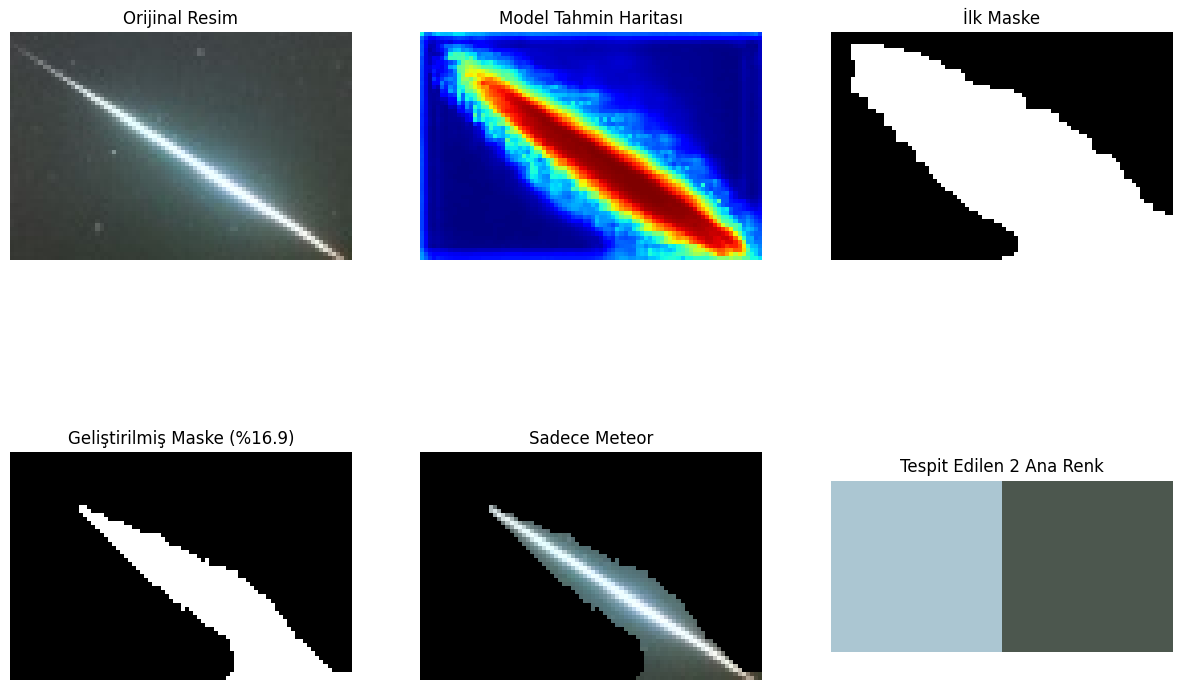

In [ ]:
# Kodun en başına eklenecek kısım
import torch.multiprocessing as mp
if __name__ == "__main__":
    # Multiprocessing başlatma yöntemini ayarla
    mp.set_start_method('spawn', force=True)
import os
import cv2
import numpy as np
import torch
import json
import matplotlib.pyplot as plt
from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2
from sklearn.cluster import DBSCAN, KMeans, MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from scipy import ndimage
from skimage import filters, measure, morphology, segmentation, color, feature, util
from skimage.segmentation import slic, quickshift, felzenszwalb
from skimage import graph
from skimage.color import rgb2lab, lab2rgb, rgb2hsv, hsv2rgb, rgb2ycbcr, ycbcr2rgb
import pandas as pd
from matplotlib.colors import to_rgb, LinearSegmentedColormap
from scipy.spatial.distance import cdist
import gc
from tqdm import tqdm
import joblib
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
from PIL import Image, ImageEnhance
import time
import colorsys
import warnings
warnings.filterwarnings('ignore')


# GPU kullanım kontrolü
CUDA_AVAILABLE = torch.cuda.is_available()
if CUDA_AVAILABLE:
    print(f"GPU kullanılıyor: {torch.cuda.get_device_name(0)}")
    # CUDA kernel için hazırlık
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
else:
    print("GPU bulunamadı, CPU kullanılıyor")

# Kornia kütüphanesini koşullu olarak import et
try:
    import kornia as K
    KORNIA_AVAILABLE = True
    print("Kornia kütüphanesi bulundu, GPU hızlandırılmış morfolojik işlemler kullanılacak")
except ImportError:
    KORNIA_AVAILABLE = False
    print("Kornia kütüphanesi bulunamadı, standart işlemler kullanılacak")

# DenseCRF kütüphanesini koşullu olarak import et
try:
    import pydensecrf.densecrf as dcrf
    from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian
    DENSECRF_AVAILABLE = True
    print("DenseCRF kütüphanesi bulundu, CRF ile son işleme yapılacak")
except ImportError:
    DENSECRF_AVAILABLE = False
    print("DenseCRF kütüphanesi bulunamadı, standart işlemler kullanılacak")

# FAISS kütüphanesini koşullu olarak import et
try:
    import faiss
    FAISS_AVAILABLE = True
    print("FAISS kütüphanesi bulundu, GPU hızlandırılmış kümeleme kullanılacak")
except ImportError:
    FAISS_AVAILABLE = False
    print("FAISS kütüphanesi bulunamadı, standart kümeleme kullanılacak")

def apply_dense_crf(img_tensor, mask_tensor, compat_col=10, compat_spat=5):
    """
    Conditional Random Fields uygulayarak maskeyi iyileştir

    Args:
        img_tensor: RGB görüntü tensörü (H, W, 3) - uint8
        mask_tensor: İkili maske tensörü (H, W) - uint8
        compat_col: Appearance kernel ağırlığı
        compat_spat: Smoothness kernel ağırlığı

    Returns:
        CRF ile iyileştirilmiş maske
    """
    if not DENSECRF_AVAILABLE:
        return mask_tensor

    try:
        h, w = mask_tensor.shape

        # Dense CRF oluştur
        d = dcrf.DenseCRF2D(w, h, 2)  # 2 sınıf: arkaplan ve meteor

        # Unary potentials oluştur (negative log of probability)
        U = unary_from_labels(mask_tensor.astype('int'), 2, gt_prob=0.7, zero_unsure=False)
        d.setUnaryEnergy(U)

        # Pairwise potentials (görünüm bazlı düzgünleştirme)
        # Bu, benzer görünümlü komşu pikselleri aynı sınıfa atama eğilimindedir
        pairwise_bilateral = create_pairwise_bilateral(sdims=(50, 50), schan=(13, 13, 13),
                                                      img=img_tensor, chdim=2)

        # Pairwise potentials (pozisyon bazlı düzgünleştirme)
        # Bu, yakın pikselleri aynı sınıfa atama eğilimindedir
        pairwise_gaussian = create_pairwise_gaussian(sdims=(3, 3), shape=(h, w))

        # Potentials ekle
        d.addPairwiseEnergy(pairwise_bilateral, compat=compat_col)
        d.addPairwiseEnergy(pairwise_gaussian, compat=compat_spat)

        # Çıkarım
        Q = d.inference(5)  # 5 iterasyon

        # Result
        MAP = np.argmax(Q, axis=0).reshape((h, w))

        return MAP.astype(np.uint8)
    except Exception as e:
        print(f"DenseCRF hata: {str(e)}")
        return mask_tensor

def apply_kornia_morphology(mask, operation='dilate', kernel_size=3, iterations=1):
    """
    Kornia kütüphanesini kullanarak GPU hızlandırmalı morfolojik operasyonlar
    Küçük maskeler için kernel boyutunu otomatik ayarlar
    """
    # Maske boyutlarını kontrol et
    h, w = mask.shape[:2]

    # Kernel boyutunu maske boyutuna göre ayarla
    effective_kernel_size = min(kernel_size, h-2, w-2, 3)
    if effective_kernel_size < 1:
        return mask  # Maske çok küçükse işlem yapmadan döndür

    if not KORNIA_AVAILABLE or not CUDA_AVAILABLE:
        kernel = np.ones((effective_kernel_size, effective_kernel_size), np.uint8)

        if operation == 'dilate':
            return cv2.dilate(mask, kernel, iterations=iterations)
        elif operation == 'erode':
            return cv2.erode(mask, kernel, iterations=iterations)
        elif operation == 'open':
            return cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=iterations)
        elif operation == 'close':
            return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=iterations)
        else:
            return mask

    try:
        # Mask'i GPU tensörüne çevir
        mask_tensor = torch.from_numpy(mask).float().unsqueeze(0).unsqueeze(0).cuda()

        # Morfolojik işlemi seç ve uygula
        if operation == 'dilate':
            for _ in range(iterations):
                mask_tensor = K.morphology.dilation(mask_tensor,
                                               K.morphology.get_rectangular_kernel2d((effective_kernel_size, effective_kernel_size)))
        elif operation == 'erode':
            for _ in range(iterations):
                mask_tensor = K.morphology.erosion(mask_tensor,
                                              K.morphology.get_rectangular_kernel2d((effective_kernel_size, effective_kernel_size)))
        elif operation == 'open':
            for _ in range(iterations):
                mask_tensor = K.morphology.opening(mask_tensor,
                                              K.morphology.get_rectangular_kernel2d((effective_kernel_size, effective_kernel_size)))
        elif operation == 'close':
            for _ in range(iterations):
                mask_tensor = K.morphology.closing(mask_tensor,
                                               K.morphology.get_rectangular_kernel2d((effective_kernel_size, effective_kernel_size)))

        # Sonucu numpy array'e geri çevir
        result = mask_tensor.squeeze().cpu().numpy()

        # Threshold ile ikili maske oluştur
        return (result > 0.5).astype(np.uint8)

    except Exception as e:
        print(f"Kornia hata: {str(e)}")

        # Hata durumunda standart işlemleri kullan
        kernel = np.ones((effective_kernel_size, effective_kernel_size), np.uint8)

        if operation == 'dilate':
            return cv2.dilate(mask, kernel, iterations=iterations)
        elif operation == 'erode':
            return cv2.erode(mask, kernel, iterations=iterations)
        elif operation == 'open':
            return cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=iterations)
        elif operation == 'close':
            return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=iterations)
        else:
            return mask

def multi_scale_inference(model, device, image, scales=[0.75, 1.0, 1.5]):
    """
    Çoklu ölçekli inferans yaparak daha kapsamlı bir maske oluştur

    Args:
        model: Segmentasyon modeli
        device: İşlem cihazı (cuda/cpu)
        image: Orijinal görüntü (RGB)
        scales: Ölçek faktörleri listesi

    Returns:
        Birleştirilmiş segmentasyon maskesi
    """
    h, w = image.shape[:2]
    final_mask = np.zeros((h, w), dtype=np.float32)

    # Normalizasyon transform
    infer_transform = Compose([
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    # Her ölçek için tahmin
    for scale in scales:
        # Görüntüyü yeniden boyutlandır
        scaled_size = (int(w * scale), int(h * scale))
        scaled_img = cv2.resize(image, scaled_size, interpolation=cv2.INTER_LINEAR)

        # Modele girdi ver
        tr = infer_transform(image=scaled_img)
        t = tr["image"].unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(t).sigmoid().squeeze().cpu().numpy()

        # Tahmin maskesini orijinal boyuta getir
        pred_resized = cv2.resize(pred, (w, h), interpolation=cv2.INTER_LINEAR)

        # Maskeleri birleştir (maksimum değeri al)
        final_mask = np.maximum(final_mask, pred_resized)

    return final_mask

def brightness(rgb):
    """
    RGB renk değeri için parlaklık hesaplar (0-1 aralığında)
    """
    r, g, b = rgb / 255.0
    return colorsys.rgb_to_hsv(r, g, b)[2]

def saturation(rgb):
    """
    RGB renk değeri için doygunluk (saturation) hesaplar (0-1 aralığında)
    """
    r, g, b = rgb / 255.0
    return colorsys.rgb_to_hsv(r, g, b)[1]

def hue(rgb):
    """
    RGB renk değeri için ton (hue) hesaplar (0-1 aralığında)
    """
    r, g, b = rgb / 255.0
    return colorsys.rgb_to_hsv(r, g, b)[0]

def convert_to_lab(rgb):
    """
    RGB renk değerini LAB renk uzayına dönüştürür
    """
    # RGB normalizasyonu (0-1 arası)
    rgb_norm = rgb / 255.0

    # NumPy veya skimage kullanarak dönüşüm
    try:
        lab = rgb2lab(rgb_norm.reshape(1, 1, 3)).reshape(3)
    except:
        # Alternatif yöntem - OpenCV
        bgr = np.flip(rgb_norm).reshape(1, 1, 3).astype(np.float32)
        lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB).reshape(3)

    return lab

def color_distance(color1, color2, method='lab'):
    """
    İki renk arasındaki uzaklığı hesaplar

    Args:
        color1, color2: RGB renk değerleri [0-255]
        method: 'rgb', 'lab', 'weighted' - uzaklık hesaplama yöntemi

    Returns:
        İki renk arasındaki uzaklık (float)
    """
    if method == 'rgb':
        # Basit Öklid uzaklığı
        return np.sqrt(np.sum((np.array(color1) - np.array(color2)) ** 2))

    elif method == 'lab':
        # LAB renk uzayında uzaklık (insan algısına daha yakın)
        lab1 = convert_to_lab(np.array(color1))
        lab2 = convert_to_lab(np.array(color2))
        return np.sqrt(np.sum((lab1 - lab2) ** 2))

    elif method == 'weighted':
        # Ağırlıklı RGB uzaklığı (yeşile daha fazla ağırlık verir)
        r_diff = (color1[0] - color2[0]) ** 2
        g_diff = (color1[1] - color2[1]) ** 2
        b_diff = (color1[2] - color2[2]) ** 2
        return np.sqrt(r_diff * 0.3 + g_diff * 0.59 + b_diff * 0.11)

    else:
        # Varsayılan
        return np.sqrt(np.sum((np.array(color1) - np.array(color2)) ** 2))

def is_dark_brown_or_black(rgb, threshold=60, s_threshold=0.15, v_threshold=0.2):
    """
    Verilen rengin koyu kahverengi veya siyaha yakın olup olmadığını kontrol eder
    Gelişmiş renk kontrolü
    """
    r, g, b = rgb

    # HSV dönüşümü
    h, s, v = colorsys.rgb_to_hsv(r/255.0, g/255.0, b/255.0)

    # Renk çok karanlık ve doygunluğu düşük
    if v < v_threshold:
        return True

    # Renk çok karanlık ve doygunluğu orta
    if v < 0.3 and s < s_threshold:
        return True

    # Renk siyaha yakın
    if max(r, g, b) < threshold:
        return True

    # Kahverengi kontrolü - kırmızı dominant, yeşil ve mavi düşük
    if r > g and r > b and g < threshold and b < threshold:
        # Kırmızı-kahverengi renk aralığı (hue: 0.0-0.1)
        if h < 0.1 and s > 0.4:
            return True

    return False

def has_high_chromatic_color(rgb, min_saturation=0.4, min_brightness=0.3):
    """
    Meteor renklerinde genellikle yüksek renk doygunluğu ve parlaklık bulunur
    Bu fonksiyon rengin meteor rengi olma potansiyelini değerlendirir
    """
    r, g, b = rgb
    h, s, v = colorsys.rgb_to_hsv(r/255.0, g/255.0, b/255.0)

    # Meteor renkleri genellikle doygun ve parlak
    return s >= min_saturation and v >= min_brightness

def superpixel_segmentation(image, mask, method='slic', n_segments=200):
    """
    Süperpiksel tabanlı segmentasyon uygulama

    Args:
        image: RGB görüntü
        mask: İlk segmentasyon maskesi
        method: 'slic', 'quickshift', veya 'felzenszwalb'
        n_segments: Süperpiksel sayısı

    Returns:
        Süperpiksel tabanlı geliştirilmiş maske
    """
    try:
        # Süperpiksel segmentasyonu uygula
        if method == 'slic':
            segments = slic(image, n_segments=n_segments, compactness=10, sigma=1, start_label=1)
        elif method == 'quickshift':
            segments = quickshift(image, kernel_size=3, max_dist=6, ratio=0.5)
        elif method == 'felzenszwalb':
            segments = felzenszwalb(image, scale=100, sigma=0.5, min_size=50)
        else:
            return mask

        # Segment bazlı etiketleme
        refined_mask = np.zeros_like(mask)

        # Her segment için, içindeki maske piksellerinin oranını kontrol et
        for segment_id in np.unique(segments):
            segment_mask = (segments == segment_id)
            overlap = np.logical_and(segment_mask, mask > 0)
            overlap_ratio = np.sum(overlap) / np.sum(segment_mask)

            # Eğer belirli bir orandan fazla piksel maskeye aitse, tüm segmenti maskeye dahil et
            if overlap_ratio > 0.5:
                refined_mask[segment_mask] = 1

        return refined_mask

    except Exception as e:
        print(f"Süperpiksel segmentasyon hatası: {str(e)}")
        return mask

def adaptive_threshold_selection(pred, percentile_low=90, percentile_high=99):
    """
    Olasılık haritasındaki değerlerin dağılımına bakarak adaptif eşik değeri seçer
    """
    if np.max(pred) <= 0:
        return 0.5

    # Sıfır olmayan değerleri al
    non_zero = pred[pred > 0.01]

    if len(non_zero) == 0:
        return 0.5

    # Dağılımı analiz et
    p_low = np.percentile(non_zero, percentile_low) if len(non_zero) > 0 else 0.5
    p_high = np.percentile(non_zero, percentile_high) if len(non_zero) > 0 else 0.5

    # Dinamik eşik - üst persentile daha yakın
    threshold = p_high * 0.6 + p_low * 0.4

    # Sınırla
    threshold = max(0.3, min(0.7, threshold))

    return threshold

def multi_level_thresholding(pred, levels=5):
    """
    Çoklu seviye eşikleme ile farklı eşik değerlerini dener ve en iyi sonucu verir
    """
    h, w = pred.shape
    best_mask = None
    best_score = -1

    # Eşik değerleri
    thresholds = np.linspace(0.2, 0.8, levels)

    for threshold in thresholds:
        # Maske oluştur
        mask = (pred > threshold).astype(np.uint8)

        # Küçük nesneleri temizle
        cleaned = morphology.remove_small_objects(mask.astype(bool), min_size=20)
        cleaned = morphology.remove_small_holes(cleaned, area_threshold=20)
        cleaned = cleaned.astype(np.uint8)

        # Maske boşsa atla
        if np.sum(cleaned) == 0:
            continue

        # Maskeyi değerlendir
        # Meteor genellikle bir çizgidir, çizgi benzeri özellikleri ölç

        # Etiketle
        labeled = measure.label(cleaned)
        props = measure.regionprops(labeled)

        if len(props) == 0:
            continue

        # En büyük bileşeni al
        largest = max(props, key=lambda p: p.area)

        # Uzanım ölçüsü (eccentricity ve extent)
        score = largest.eccentricity * (1 - largest.extent) * largest.area

        if score > best_score:
            best_score = score
            best_mask = (labeled == largest.label).astype(np.uint8)

    # Hiçbir maske bulunamadıysa en basit eşiklemeyi kullan
    if best_mask is None:
        best_mask = (pred > 0.5).astype(np.uint8)
        best_mask = morphology.remove_small_objects(best_mask.astype(bool), min_size=20).astype(np.uint8)

    return best_mask

def enhance_meteor_mask(image_rgb, mask, pred):
    """
    Meteor maskesini iyileştiren birden fazla tekniği birleştirir
    Özellikle ince meteorları daha iyi tespit eder
    """
    # Maske boşsa hiçbir şey yapma
    if np.sum(mask) == 0:
        return mask

    # Maske boyutlarını kontrol et
    h, w = mask.shape[:2]

    # Çok küçük maskeler için işlem yapma
    if h <= 5 or w <= 5:
        return mask

    # 1. Morfolojik işlemler - kernel boyutunu ayarla
    kernel_size = min(5, h//2, w//2)
    if kernel_size < 1:
        return mask

    if KORNIA_AVAILABLE and CUDA_AVAILABLE:
        mask_closed = apply_kornia_morphology(mask, operation='close', kernel_size=kernel_size, iterations=1)
    else:
        # İnce meteorlar için eliptik kernel kullan
        kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
        mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_close, iterations=1)

    # 2. İnce meteor için çizgi tespiti
    try:
        gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, 50, 150)

        # Çizgi tespiti (Hough Transform)
        lines = cv2.HoughLinesP(edges * mask_closed, 1, np.pi/180,
                               threshold=15, minLineLength=10, maxLineGap=5)

        # Çizgi maskesi oluştur
        line_mask = np.zeros_like(mask)
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(line_mask, (x1, y1), (x2, y2), 1, 2)

            # Meteor maskesi ile kesişim
            line_mask = line_mask & mask_closed

            # Eğer çizgi maskesi meteor maskenin bir kısmını yakalıyorsa birleştir
            if np.sum(line_mask) > np.sum(mask_closed) * 0.1:
                mask_closed = mask_closed | line_mask
    except:
        pass

    # 3. Watershed ile kenar geliştirme
    try:
        # Gradient
        gradient = filters.sobel(gray)

        # Belirli eşik mesafeleri
        distance = ndimage.distance_transform_edt(mask_closed)

        # Watershed marker'ları
        markers = np.zeros_like(mask, dtype=np.int32)
        core_threshold = 0.5  # İç bölge eşiği
        markers[distance > distance.max() * core_threshold] = 1  # İç bölge
        markers[mask_closed == 0] = 2  # Dış bölge

        # Watershed uygula
        labels = segmentation.watershed(gradient, markers, watershed_line=True)
        mask_ws = (labels == 1).astype(np.uint8)

        # Watershed sonucunu değerlendir
        # Çok büyümemişse kullan
        if np.sum(mask_ws) < np.sum(mask_closed) * 2:
            enhanced = mask_ws
        else:
            enhanced = mask_closed
    except:
        enhanced = mask_closed

    # 4. Parlaklık tabanlı genişleme - ince meteorları daha iyi yakalamak için
    try:
        # Gri tonlamalı resmi normalleştir
        gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY).astype(float) / 255.0

        # Dilate kernel boyutu kontrolü
        dilate_kernel_size = min(3, h//2, w//2)
        if dilate_kernel_size >= 1:
            # Maske etrafındaki genişletilmiş bölge
            if KORNIA_AVAILABLE and CUDA_AVAILABLE:
                dilated = apply_kornia_morphology(enhanced, operation='dilate', kernel_size=dilate_kernel_size, iterations=2)
            else:
                dilated = cv2.dilate(enhanced, np.ones((dilate_kernel_size, dilate_kernel_size), np.uint8), iterations=2)

            expansion_zone = dilated & ~enhanced

            # Parlaklık eşiğiyle genişleme bölgesindeki parlak pikselleri ekle
            mask_mean_brightness = np.mean(gray[enhanced == 1]) if np.sum(enhanced) > 0 else 0.5
            brightness_threshold = max(0.1, mask_mean_brightness * 0.7)  # Orijinal maskeden daha az parlak olabilir

            # Parlaklık eşiğini geçen pikselleri ekle
            bright_expansion = (gray > brightness_threshold) & expansion_zone
            enhanced = enhanced | bright_expansion.astype(np.uint8)
    except:
        pass

    # 5. Son temizleme
    final_kernel_size = min(3, h//2, w//2)
    if final_kernel_size >= 1:
        if KORNIA_AVAILABLE and CUDA_AVAILABLE:
            final_mask = apply_kornia_morphology(enhanced, operation='close', kernel_size=final_kernel_size, iterations=1)
        else:
            kernel = np.ones((final_kernel_size, final_kernel_size), np.uint8)
            final_mask = morphology.remove_small_holes(enhanced.astype(bool), area_threshold=20).astype(np.uint8)
    else:
        final_mask = enhanced

    return final_mask

def detect_background_colors(image_rgb, mask, tolerance=10, min_percentage=5.0, max_samples=5000):
    """
    Maske dışındaki alanda (arka planda) yaygın renkleri tespit eder - optimize edilmiş
    """
    # Arka plan maskesi
    bg_mask = (mask == 0)

    # Arka plan boşsa boş liste döndür
    if np.sum(bg_mask) == 0:
        return []

    # Arka plan piksellerini al
    bg_indices = np.where(bg_mask)

    # Çok fazla piksel varsa örnekle
    if len(bg_indices[0]) > max_samples:
        sample_indices = np.random.choice(len(bg_indices[0]), max_samples, replace=False)
        sampled_bg_pixels = image_rgb[bg_indices[0][sample_indices], bg_indices[1][sample_indices]]
    else:
        sampled_bg_pixels = image_rgb[bg_indices]

    # DBSCAN veya KMeans ile kümeleme
    try:
        # GPU hızlandırmalı kümeleme
        if FAISS_AVAILABLE and CUDA_AVAILABLE:
            # FAISS için veri hazırla
            X = sampled_bg_pixels.astype(np.float32)

            # Küme sayısı
            n_clusters = 2  # Genelde 2 renk yeterli - arka plan ve gökyüzü

            # GPU ile K-Means kümeleme
            kmeans = faiss.Kmeans(d=3, k=n_clusters, gpu=True)
            kmeans.train(X)

            # Sonuçları al
            centers = kmeans.centroids
            _, labels = kmeans.index.search(X, 1)
            labels = labels.flatten()

            # Her kümedeki piksel sayısı
            counts = np.bincount(labels, minlength=n_clusters)

            # Yüzdelik hesapla
            percentages = (counts / len(labels)) * 100

            # Minimum yüzdeyi geçen arka plan renkleri
            bg_colors = []
            for i in range(n_clusters):
                if percentages[i] >= min_percentage:
                    bg_colors.append(centers[i].astype(int).tolist())

            return bg_colors
        else:
            # Standart K-Means
            n_clusters = 2  # Genelde 2 renk yeterli - arka plan ve gökyüzü

            # KMeans'i sınırlı iterasyonla çalıştır
            kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=1, max_iter=50)
            labels = kmeans.fit_predict(sampled_bg_pixels)

            # Küme merkezleri
            centers = kmeans.cluster_centers_

            # Her kümedeki piksel sayısı
            counts = np.bincount(labels, minlength=n_clusters)

            # Yüzdelik hesapla
            percentages = (counts / len(labels)) * 100

            # Minimum yüzdeyi geçen arka plan renkleri
            bg_colors = []
            for i in range(n_clusters):
                if percentages[i] >= min_percentage:
                    bg_colors.append(centers[i].astype(int).tolist())

            return bg_colors
    except Exception as e:
        print(f"Arka plan renk tespiti hatası: {str(e)}")
        return []

def analyze_color_gradient(image_rgb, mask, line_width=3, threshold=20, min_length=10):
    """
    Maske içindeki renk gradyanlarını analiz eder - optimize edilmiş
    """
    if np.sum(mask) == 0:
        return [], []

    # Meteor merkezini ve ekseni belirle
    # Bunun için skeletonization yerine PCA kullanabiliriz (daha güvenilir)
    try:
        # Maskelenmiş piksellerin koordinatlarını al
        coords = np.column_stack(np.where(mask > 0))

        if len(coords) < min_length:
            return [], []

        # Koordinatlara PCA uygula
        pca = PCA(n_components=2)
        pca.fit(coords)

        # Meteor ekseni boyunca renkleri örnekle
        # Ana bileşen, meteor uzanımının eksenidir
        center = np.mean(coords, axis=0)
        direction = pca.components_[0]

        # Meteorun muhtemel uzunluğunu hesapla
        trans_coords = pca.transform(coords)
        min_proj = np.min(trans_coords[:, 0])
        max_proj = np.max(trans_coords[:, 0])

        # Eksen boyunca noktaları örnekle
        t_values = np.linspace(min_proj, max_proj, int(max_proj - min_proj) + 1)

        # Renkleri topla
        colors = []
        for t in t_values:
            # Eksen üzerindeki nokta
            point = center + direction * t
            y, x = int(point[0]), int(point[1])

            # Sınırlar içinde kontrol
            if y >= 0 and y < mask.shape[0] and x >= 0 and x < mask.shape[1]:
                # Çevredeki pencere
                y_min, y_max = max(0, y-line_width), min(image_rgb.shape[0], y+line_width+1)
                x_min, x_max = max(0, x-line_width), min(image_rgb.shape[1], x+line_width+1)

                # Penceredeki maskelenmiş pikselleri al
                window_mask = mask[y_min:y_max, x_min:x_max]
                window_rgb = image_rgb[y_min:y_max, x_min:x_max]

                # Maskelenmiş pikselleri al
                valid_pixels = window_rgb[window_mask > 0]

                if len(valid_pixels) > 0:
                    # Ortalama renk
                    avg_color = np.mean(valid_pixels, axis=0).astype(int)
                    colors.append([int(avg_color[0]), int(avg_color[1]), int(avg_color[2])])

        # Renk geçişlerini analiz et
        if len(colors) < min_length:
            return [], []

        colors_array = np.array(colors)

        # GMM ile otomatik küme sayısı belirle
        n_components_range = range(1, min(4, len(colors) // 10 + 1))

        best_bic = np.inf
        best_n = 1

        for n in n_components_range:
            try:
                gmm = GaussianMixture(n_components=n, random_state=0, max_iter=100, n_init=1)
                gmm.fit(colors_array)
                bic = gmm.bic(colors_array)

                if bic < best_bic:
                    best_bic = bic
                    best_n = n
            except:
                continue

        # Belirlenen küme sayısıyla GMM uygula
        gmm = GaussianMixture(n_components=best_n, random_state=0, max_iter=100, n_init=1)
        labels = gmm.fit_predict(colors_array)

        # Küme merkezlerini ve oranlarını hesapla
        cluster_centers = []
        percentages = []

        for i in range(best_n):
            cluster_indices = np.where(labels == i)[0]
            if len(cluster_indices) > 0:
                cluster_pixels = colors_array[cluster_indices]
                center = np.mean(cluster_pixels, axis=0).astype(int).tolist()
                percentage = (len(cluster_indices) / len(colors)) * 100

                cluster_centers.append(center)
                percentages.append(percentage)

        return cluster_centers, percentages
    except Exception as e:
        print(f"Gradyan analizi hatası: {str(e)}")
        return [], []

def cluster_colors_with_optimal_k(pixels, method='gmm', max_samples=5000, min_brightness=0.15, min_saturation=0.1):
    """
    Otomatik küme sayısı seçimi ile geliştirilmiş renk kümeleme
    Birden fazla renk uzayı ve kümeleme yöntemi dener
    """
    # Piksel yoksa boş liste döndür
    if len(pixels) == 0:
        return [], [], []

    # Örnekleme: Çok fazla piksel varsa rastgele örnek al
    if len(pixels) > max_samples:
        idx = np.random.choice(len(pixels), max_samples, replace=False)
        sample_pixels = pixels[idx]
    else:
        sample_pixels = pixels

    # HSV renk uzayına dönüştür ve filtrele
    filtered_pixels = []
    for rgb in sample_pixels:
        r, g, b = rgb
        h, s, v = colorsys.rgb_to_hsv(r/255.0, g/255.0, b/255.0)

        # Koyu/gri renkleri filtrele
        if s >= min_saturation and v >= min_brightness and not is_dark_brown_or_black(rgb):
            filtered_pixels.append(rgb)

    # Filtreleme sonrası piksel kalmadıysa orijinal pikselleri kullan
    if len(filtered_pixels) < 50 and len(sample_pixels) > 0:
        avg_color = np.mean(sample_pixels, axis=0).astype(int).tolist()
        return [avg_color], [len(sample_pixels)], [100.0]

    if len(filtered_pixels) == 0:
        return [], [], []

    filtered_pixels = np.array(filtered_pixels)

    # Birden fazla renk uzayına dönüştür
    try:
        # RGB
        X_rgb = filtered_pixels

        # LAB
        X_lab = np.zeros_like(X_rgb, dtype=np.float32)
        for i, rgb in enumerate(X_rgb):
            X_lab[i] = convert_to_lab(rgb)

        # Dönüşüm problemi yaşarsak RGB'ye dön
        if np.isnan(X_lab).any():
            X_lab = X_rgb

        # HSV
        X_hsv = np.zeros_like(X_rgb, dtype=np.float32)
        for i, rgb in enumerate(X_rgb):
            r, g, b = rgb / 255.0
            h, s, v = colorsys.rgb_to_hsv(r, g, b)
            X_hsv[i] = [h * 360, s * 100, v * 100]  # Ölçeklendirme

        # 1. Otomatik küme sayısı belirleme
        # GMM + BIC
        if method == 'gmm':
            best_X = X_lab  # LAB uzayı genelde renk algısı için daha iyi

            n_components_range = range(1, min(5, len(filtered_pixels) // 100 + 1))
            best_gmm = None
            best_bic = np.inf
            best_n = 1

            for n in n_components_range:
                try:
                    gmm = GaussianMixture(n_components=n, random_state=0, max_iter=100, n_init=1)
                    gmm.fit(best_X)
                    bic = gmm.bic(best_X)

                    if bic < best_bic:
                        best_bic = bic
                        best_gmm = gmm
                        best_n = n
                except:
                    continue

            if best_gmm is None:
                # GMM başarısız oldu, basit ortalama kullan
                avg_color = np.mean(filtered_pixels, axis=0).astype(int).tolist()
                return [avg_color], [len(filtered_pixels)], [100.0]

            # Etiketleri ata
            labels = best_gmm.predict(best_X)

            # Küme merkezlerini hesapla (RGB uzayında)
            centers_rgb = []
            for i in range(best_n):
                cluster_indices = np.where(labels == i)[0]
                if len(cluster_indices) > 0:
                    cluster_rgb = X_rgb[cluster_indices]
                    center = np.mean(cluster_rgb, axis=0).astype(int).tolist()
                    centers_rgb.append(center)

            # Her kümedeki piksel sayısı
            counts = np.bincount(labels, minlength=best_n)

            # Yüzdelik hesapla
            percentages = (counts / len(labels)) * 100

            # Büyükten küçüğe sırala
            sorted_indices = np.argsort(counts)[::-1]
            sorted_centers = [centers_rgb[i] for i in sorted_indices]
            sorted_counts = [int(counts[i]) for i in sorted_indices]
            sorted_percentages = [float(percentages[i]) for i in sorted_indices]

            return sorted_centers, sorted_counts, sorted_percentages

        # 2. Silhouette skoru + K-Means
        elif method == 'silhouette':
            # Silhouette skoruna göre en iyi veri setini ve küme sayısını seç
            best_score = -1
            best_X = None
            best_n = 1

            # Farklı renk uzaylarını ve küme sayılarını dene
            for X, name in [(X_rgb, 'RGB'), (X_lab, 'LAB'), (X_hsv, 'HSV')]:
                for n_clusters in range(2, min(5, len(filtered_pixels) // 100 + 1)):
                    try:
                        kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=1, max_iter=100)
                        labels = kmeans.fit_predict(X)

                        if len(np.unique(labels)) < 2:
                            continue

                        # Silhouette skoru hesapla
                        score = silhouette_score(X, labels)

                        if score > best_score:
                            best_score = score
                            best_X = X
                            best_n = n_clusters
                    except:
                        continue

            # En iyi X ve n_clusters ile K-Means uygula
            if best_X is None:
                # Silhouette başarısız oldu, varsayılan LAB kullan
                best_X = X_lab
                best_n = 2

            kmeans = KMeans(n_clusters=best_n, random_state=0, n_init=1, max_iter=100)
            labels = kmeans.fit_predict(best_X)

            # Küme merkezlerini hesapla (RGB uzayında)
            centers_rgb = []
            for i in range(best_n):
                cluster_indices = np.where(labels == i)[0]
                if len(cluster_indices) > 0:
                    cluster_rgb = X_rgb[cluster_indices]
                    center = np.mean(cluster_rgb, axis=0).astype(int).tolist()
                    centers_rgb.append(center)

            # Her kümedeki piksel sayısı
            counts = np.bincount(labels, minlength=best_n)

            # Yüzdelik hesapla
            percentages = (counts / len(labels)) * 100

            # Büyükten küçüğe sırala
            sorted_indices = np.argsort(counts)[::-1]
            sorted_centers = [centers_rgb[i] for i in sorted_indices]
            sorted_counts = [int(counts[i]) for i in sorted_indices]
            sorted_percentages = [float(percentages[i]) for i in sorted_indices]

            return sorted_centers, sorted_counts, sorted_percentages

        # 3. Meanshift (otomatik küme sayısı belirler)
        elif method == 'meanshift':
            # Bandwidth hesapla
            bandwidth = estimate_bandwidth(X_lab, quantile=0.2, n_samples=min(500, len(X_lab)))

            if bandwidth <= 0:
                bandwidth = 10  # Fallback değeri

            # MeanShift uygula
            ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
            labels = ms.fit_predict(X_lab)

            # Küme merkezleri
            centers_lab = ms.cluster_centers_

            # Küme merkezlerini RGB'ye dönüştür
            centers_rgb = []
            for center_lab in centers_lab:
                # LAB -> RGB
                try:
                    lab_pixel = center_lab.reshape(1, 1, 3)
                    rgb_pixel = lab2rgb(lab_pixel).reshape(3)
                    rgb = (rgb_pixel * 255).astype(int).tolist()
                    centers_rgb.append(rgb)
                except:
                    # Dönüşüm başarısız olursa ilgili kümedeki ortalama RGB'yi kullan
                    cluster_indices = np.where(labels == len(centers_rgb))[0]
                    if len(cluster_indices) > 0:
                        cluster_rgb = X_rgb[cluster_indices]
                        center = np.mean(cluster_rgb, axis=0).astype(int).tolist()
                        centers_rgb.append(center)

            # Her kümedeki piksel sayısı
            n_clusters = len(centers_rgb)
            counts = np.bincount(labels, minlength=n_clusters)

            # Yüzdelik hesapla
            percentages = (counts / len(labels)) * 100

            # Büyükten küçüğe sırala
            sorted_indices = np.argsort(counts)[::-1]
            sorted_centers = [centers_rgb[i] for i in sorted_indices]
            sorted_counts = [int(counts[i]) for i in sorted_indices]
            sorted_percentages = [float(percentages[i]) for i in sorted_indices]

            return sorted_centers, sorted_counts, sorted_percentages

        # 4. Varsayılan: Sabit küme sayısı ile K-Means
        else:
            n_clusters = min(3, max(1, len(filtered_pixels) // 200))

            # LAB uzayında K-Means
            kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=1, max_iter=100)
            labels = kmeans.fit_predict(X_lab)

            # Küme merkezlerini hesapla (RGB uzayında)
            centers_rgb = []
            for i in range(n_clusters):
                cluster_indices = np.where(labels == i)[0]
                if len(cluster_indices) > 0:
                    cluster_rgb = X_rgb[cluster_indices]
                    center = np.mean(cluster_rgb, axis=0).astype(int).tolist()
                    centers_rgb.append(center)

            # Her kümedeki piksel sayısı
            counts = np.bincount(labels, minlength=n_clusters)

            # Yüzdelik hesapla
            percentages = (counts / len(labels)) * 100

            # Büyükten küçüğe sırala
            sorted_indices = np.argsort(counts)[::-1]
            sorted_centers = [centers_rgb[i] for i in sorted_indices]
            sorted_counts = [int(counts[i]) for i in sorted_indices]
            sorted_percentages = [float(percentages[i]) for i in sorted_indices]

            return sorted_centers, sorted_counts, sorted_percentages

    except Exception as e:
        print(f"Kümeleme hatası: {str(e)}")

        # Hata durumunda basit ortalama
        avg_color = np.mean(filtered_pixels, axis=0).astype(int).tolist()
        return [avg_color], [len(filtered_pixels)], [100.0]

def prioritize_by_brightness_and_similarity(rgb_values, percentages, pixel_counts,
                                          min_similarity=25, brightness_weight=0.7):
    """
    Birbirine yakın renkleri parlaklık ve renk benzerliğine göre filtreler
    """
    if len(rgb_values) <= 1:
        return rgb_values, percentages, pixel_counts

    # RGB değerleri ve parlaklıkları hesapla
    color_info = []
    for i, rgb in enumerate(rgb_values):
        r, g, b = rgb
        h, s, v = colorsys.rgb_to_hsv(r/255.0, g/255.0, b/255.0)

        # Rengin "parlaklık puanı" - parlaklık ve doygunluğun kombinasyonu
        brightness_score = v * brightness_weight + s * (1 - brightness_weight)

        # Gri renklerin (düşük doygunluk) puanını düşür
        if s < 0.2:
            brightness_score *= 0.7

        # Renk bilgilerini kaydet
        color_info.append({
            'index': i,
            'rgb': rgb,
            'brightness': v,
            'saturation': s,
            'brightness_score': brightness_score,
            'percentage': percentages[i],
            'count': pixel_counts[i]
        })

    # Parlaklık puanına göre sırala (yüksekten düşüğe)
    color_info.sort(key=lambda x: x['brightness_score'], reverse=True)

    # Filtrelenmiş renk listesi
    filtered_colors = []

    # Parlaklık puanına göre sıralanmış renkleri işle
    while color_info:
        current = color_info.pop(0)  # En parlak rengi al

        # Bu rengi ekle
        filtered_colors.append(current)

        # Kalan renkleri kontrol et, benzer olanları mevcut renkle birleştir
        i = 0
        while i < len(color_info):
            compare = color_info[i]

            # Lab uzayında uzaklık
            distance = color_distance(current['rgb'], compare['rgb'], method='lab')

            if distance < min_similarity:
                # Renkleri birleştir - yüzde ve sayıları topla
                current['percentage'] += compare['percentage']
                current['count'] += compare['count']

                # Benzer rengi kaldır
                color_info.pop(i)
            else:
                i += 1

    # Yeni listeleri oluştur
    new_rgb = [c['rgb'] for c in filtered_colors]
    new_percentages = [c['percentage'] for c in filtered_colors]
    new_counts = [c['count'] for c in filtered_colors]

    # Yüzdeleri normalize et
    total = sum(new_percentages)
    if total > 0:
        new_percentages = [p * 100 / total for p in new_percentages]

    return new_rgb, new_percentages, new_counts

def filter_out_background_and_dark_colors(meteor_rgb_values, meteor_percentages, meteor_counts,
                                         bg_colors, min_similarity=15):
    """
    Arkaplan renklerine çok benzeyen ve koyu olan meteor renklerini filtreler
    """
    if not meteor_rgb_values:
        return [], [], []

    filtered_rgb = []
    filtered_percentages = []
    filtered_counts = []

    for i, rgb in enumerate(meteor_rgb_values):
        # 1. Arkaplan rengi kontrolü
        is_background = False

        for bg_rgb in bg_colors:
            distance = color_distance(rgb, bg_rgb, method='lab')

            if distance < min_similarity:
                is_background = True
                break

        # 2. Koyu renk kontrolü
        is_dark = is_dark_brown_or_black(rgb)

        # 3. Kromatik renk kontrolü
        is_chromatic = has_high_chromatic_color(rgb)

        # Filtreleme kriterleri
        if not is_background and not is_dark and (is_chromatic or meteor_percentages[i] > 20):
            filtered_rgb.append(rgb)
            filtered_percentages.append(meteor_percentages[i])
            filtered_counts.append(meteor_counts[i])

    # Hiç renk kalmadıysa en büyük yüzdeye sahip rengi döndür
    if not filtered_rgb and meteor_rgb_values:
        max_index = np.argmax(meteor_percentages)
        return [meteor_rgb_values[max_index]], [100.0], [meteor_counts[max_index]]

    # Yüzdeleri normalize et
    if filtered_percentages:
        total = sum(filtered_percentages)
        normalized_percentages = [p * 100 / total for p in filtered_percentages]
    else:
        normalized_percentages = []

    return filtered_rgb, normalized_percentages, filtered_counts

def clean_and_extract_largest(mask, min_area=50, use_skimage=True):
    """
    Maskeden gürültüleri temizler ve sadece en büyük bileşeni çıkarır
    Gelişmiş morfolojik işlemler ve skimage kullanır
    """
    # Maske boşsa direkt döndür
    if np.sum(mask) == 0:
        return mask

    # Maske boyutlarını kontrol et
    h, w = mask.shape[:2]

    if h <= 5 or w <= 5:
        return mask  # Çok küçük maskeler için işlem yapma

    # Kernel boyutlarını maske boyutuna göre ayarla
    close_kernel_size = min(5, h//2, w//2)
    open_kernel_size = min(3, h//2, w//2)

    if close_kernel_size < 1 or open_kernel_size < 1:
        return mask  # Kernel boyutu geçersizse işlem yapma

    if use_skimage:
        # skimage morfoloji fonksiyonları
        # Küçük nesneleri kaldır
        clean_mask = morphology.remove_small_objects(mask.astype(bool), min_size=min_area)

        # Boşlukları doldur
        clean_mask = morphology.remove_small_holes(clean_mask, area_threshold=min_area//2)

        # Bileşenleri etiketle
        labeled = measure.label(clean_mask)

        # Hiç bileşen yoksa orijinal maskeyi döndür
        if labeled.max() == 0:
            return mask

        # Bileşenlerin özelliklerini hesapla
        props = measure.regionprops(labeled)

        # Meteorlar genellikle yüksek eksantrisite (uzanım) gösterir
        if len(props) > 1:
            # Eksantrisite ve alan skorunu hesapla (meteorlar uzun ve ince yapılar)
            scores = [(p.area * p.eccentricity, p.label) for p in props if p.area >= min_area]

            if scores:
                # En yüksek skora sahip bileşeni seç
                best_label = max(scores, key=lambda x: x[0])[1]
                final_mask = (labeled == best_label).astype(np.uint8)
            else:
                # En büyük bileşeni seç
                areas = [p.area for p in props]
                if areas:
                    largest_idx = np.argmax(areas)
                    final_mask = (labeled == props[largest_idx].label).astype(np.uint8)
                else:
                    final_mask = mask
        else:
            # Tek bileşen varsa onu kullan
            final_mask = (labeled > 0).astype(np.uint8)
    else:
        # OpenCV morfoloji fonksiyonları
        # Morfolojik operasyonlar için kernel
        kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_kernel_size, close_kernel_size))
        kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_kernel_size, open_kernel_size))

        # Küçük boşlukları doldur
        mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_close, iterations=1)

        # Küçük gürültüleri temizle
        mask_opened = cv2.morphologyEx(mask_closed, cv2.MORPH_OPEN, kernel_open, iterations=1)

        # Bağlantılı bileşen analizi
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_opened, connectivity=8)

        # Hiç bileşen yoksa orijinal maskeyi döndür
        if num_labels <= 1:
            return mask

        # Bileşen alanlarını hesapla (0 = arka plan, atla)
        areas = stats[1:, cv2.CC_STAT_AREA]

        # Minimum alan kontrolü
        valid_labels = np.where(areas >= min_area)[0] + 1  # +1 çünkü 0 indeksi arka plan

        if len(valid_labels) == 0:
            # Geçerli bileşen yoksa, en büyük olanı döndür
            largest_label = 1 + np.argmax(areas)
            final_mask = (labels == largest_label).astype(np.uint8)
        else:
            # Geçerli en büyük bileşeni bul
            largest_valid_idx = np.argmax(areas[valid_labels - 1])
            largest_label = valid_labels[largest_valid_idx]
            final_mask = (labels == largest_label).astype(np.uint8)

    # Son temizleme - küçük maskeler için kernel boyutunu kontrolü
    final_h, final_w = final_mask.shape[:2]
    final_kernel_size = min(3, final_h//2, final_w//2)

    if final_kernel_size >= 1:
        if KORNIA_AVAILABLE and CUDA_AVAILABLE:
            final_mask = apply_kornia_morphology(final_mask, operation='close', kernel_size=final_kernel_size, iterations=1)
        else:
            kernel = np.ones((final_kernel_size, final_kernel_size), np.uint8)
            final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return final_mask

def analyze_background_colors(image_rgb, mask, min_background_percentage=40.0):
    """
    Maske dışında kalan arkaplan renklerini analiz eder ve baskın arkaplan renklerini döndürür

    Args:
        image_rgb: RGB görüntü
        mask: Meteor maskesi (1 = meteor, 0 = arkaplan)
        min_background_percentage: Baskın kabul edilecek minimum yüzde

    Returns:
        Baskın arkaplan renkleri listesi
    """
    # Arkaplan maskesi
    bg_mask = (mask == 0)

    # Arkaplan boşsa boş liste döndür
    if np.sum(bg_mask) == 0:
        return []

    # Arkaplan piksellerini al
    bg_pixels = image_rgb[bg_mask]

    # Çok fazla piksel varsa örnekle
    if len(bg_pixels) > 2000:
        indices = np.random.choice(len(bg_pixels), 2000, replace=False)
        bg_pixels = bg_pixels[indices]

    # K-means ile arkaplan renklerini kümeleme
    n_clusters = 3  # Arkaplanda genelde az sayıda ana renk olur

    try:
        kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=1, max_iter=100)
        labels = kmeans.fit_predict(bg_pixels)

        # Küme merkezleri
        centers = kmeans.cluster_centers_.astype(int).tolist()

        # Her kümedeki piksel sayısı
        counts = np.bincount(labels, minlength=n_clusters)

        # Yüzdeleri hesapla
        percentages = (counts / len(bg_pixels)) * 100

        # Baskın arkaplan renkleri (yüzde eşiği üzerinde olanlar)
        dominant_bg_colors = []

        for i, (color, percentage) in enumerate(zip(centers, percentages)):
            if percentage >= min_background_percentage:
                dominant_bg_colors.append({
                    'color': color,
                    'percentage': float(percentage)
                })

        return dominant_bg_colors

    except Exception as e:
        print(f"Arkaplan renk analizi hatası: {str(e)}")
        return []

def check_color_similarity_to_background(color, bg_colors, similarity_threshold=30):
    """
    Bir rengin baskın arkaplan renklerine benzerliğini kontrol eder

    Args:
        color: Kontrol edilecek renk [r, g, b]
        bg_colors: Baskın arkaplan renkleri listesi
        similarity_threshold: Benzerlik eşiği (daha düşük = daha benzer)

    Returns:
        True: Eğer renk arkaplan renklerine çok benziyorsa
        False: Eğer renk arkaplan renklerinden yeterince farklıysa
    """
    if not bg_colors:
        return False

    # Her baskın arkaplan rengine uzaklığı hesapla
    for bg_color in bg_colors:
        bg_rgb = bg_color['color']

        # RGB uzaklığı
        r_diff = (color[0] - bg_rgb[0]) ** 2
        g_diff = (color[1] - bg_rgb[1]) ** 2
        b_diff = (color[2] - bg_rgb[2]) ** 2

        distance = np.sqrt(r_diff + g_diff + b_diff)

        # Eğer eşikten yakınsa, arkaplan rengine benzer kabul et
        if distance < similarity_threshold:
            return True

    # Hiçbir arkaplan rengine benzemiyorsa
    return False

def filter_background_similar_colors(significant_colors, significant_counts, significant_percentages, bg_colors):
    """
    Arkaplan renklerine benzeyen meteor renklerini filtreler

    Args:
        significant_colors: Meteorda tespit edilen renkler
        significant_counts: Her rengin piksel sayısı
        significant_percentages: Her rengin yüzdesi
        bg_colors: Baskın arkaplan renkleri

    Returns:
        Filtrelenmiş renkler, sayılar ve yüzdeler
    """
    if not bg_colors or not significant_colors:
        return significant_colors, significant_counts, significant_percentages

    filtered_colors = []
    filtered_counts = []
    filtered_percentages = []

    for i, color in enumerate(significant_colors):
        # Renk arkaplan renklerine benziyor mu?
        is_similar_to_background = check_color_similarity_to_background(color, bg_colors)

        # Benzer değilse, listeye ekle
        if not is_similar_to_background:
            filtered_colors.append(color)
            filtered_counts.append(significant_counts[i])
            filtered_percentages.append(significant_percentages[i])

    # Filtreleme sonrası renk kalmadıysa, en baskın rengi geri ekle
    if not filtered_colors and significant_colors:
        max_idx = np.argmax(significant_percentages)
        filtered_colors = [significant_colors[max_idx]]
        filtered_counts = [significant_counts[max_idx]]
        filtered_percentages = [100.0]

    # Yüzdeleri normalize et
    if filtered_percentages:
        total = sum(filtered_percentages)
        normalized_percentages = [p * 100 / total for p in filtered_percentages]
        filtered_percentages = normalized_percentages

    return filtered_colors, filtered_counts, filtered_percentages

from skimage.morphology import skeletonize
from sklearn.mixture import GaussianMixture

def analyze_skeleton_multiple_colors(image_rgb, mask, max_components=4):
    """
    Meteor iskeletini çıkarıp bu yol boyunca renk geçişlerini analiz eder.
    Bu, meteor çizgisi boyunca birden fazla rengi tespit etmeye yardımcı olur.

    Args:
        image_rgb: RGB görüntü
        mask: Meteor maskesi
        max_components: Maximum renk bileşeni sayısı

    Returns:
        centers: Bulunan renk merkezleri
        percentages: Her rengin yüzdesi
    """
    # 1) İskeleti çıkar
    skel = skeletonize(mask.astype(bool))
    coords = np.column_stack(np.where(skel))
    if len(coords) == 0:
        return [], []
    skel_pixels = np.array([image_rgb[y, x] for y, x in coords])

    # 2) BIC'ye göre en iyi bileşen sayısını bul
    best_bic = np.inf
    best_gmm = None
    for n in range(1, min(max_components, len(skel_pixels)) + 1):
        try:
            gmm = GaussianMixture(n_components=n, random_state=0, max_iter=200, n_init=2)
            gmm.fit(skel_pixels)
            bic = gmm.bic(skel_pixels)
            if bic < best_bic:
                best_bic, best_gmm = bic, gmm
        except:
            continue

    if best_gmm is None:
        return [], []

    # 3) Etiketle, merkezleri ve yüzdeleri al
    labels = best_gmm.predict(skel_pixels)
    centers = best_gmm.means_.astype(int).tolist()
    counts = np.bincount(labels, minlength=len(centers))
    percentages = (counts / counts.sum()) * 100

    # 4) Sıralayıp döndür
    order = np.argsort(counts)[::-1]
    centers = [centers[i] for i in order]
    percentages = [float(percentages[i]) for i in order]
    return centers, percentages

def process_single_image(args):
    """
    Tek bir resmi işler (paralel işleme için)
    Güncelllenmiş versiyon - daha iyi renk çıkarma ve maske geliştirme
    """
    img_idx, fname, model, device, params = args

    try:
        # Resmi yükle
        img_path = os.path.join(params['crops_dir'], fname)
        img_bgr = cv2.imread(img_path)

        if img_bgr is None:
            print(f"  HATA: Resim okunamadı! {fname}")
            return fname, {
                "rgb_values": [],
                "pixel_counts": [],
                "percentages": [],
                "total_pixels": 0,
                "unique_rgb_count": 0,
                "error": "Image could not be read"
            }

        # BGR -> RGB dönüşümü
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        h, w = img_rgb.shape[:2]

        # Boyut kontrolü - çok küçük resimleri durdur
        if h < 5 or w < 5:
            print(f"  UYARI: Resim çok küçük! {fname} ({w}x{h})")
            return fname, {
                "rgb_values": [],
                "pixel_counts": [],
                "percentages": [],
                "total_pixels": 0,
                "unique_rgb_count": 0,
                "error": f"Image too small: {w}x{h}"
            }

        # 1. Çoklu ölçekli inferans - ince meteorlar için kapsamlı ölçekleme
        pred = multi_scale_inference(model, device, img_rgb, scales=[0.75, 1.0, 1.25, 1.5])

        # 2. Adaptif eşik değeri seç
        try:
            threshold = adaptive_threshold_selection(pred, percentile_low=85, percentile_high=99)
        except:
            threshold = 0.5

        # 3. En iyi maskeyi seç
        mask = multi_level_thresholding(pred, levels=7)  # Daha fazla seviye dene

        # 4. Maskeyi temizle ve en büyük bileşeni çıkar
        meteor_mask = clean_and_extract_largest(mask, min_area=15, use_skimage=True)

        # 5. Maskeyi iyileştir - özellikle ince meteorlar için geliştirilmiş
        enhanced_mask = enhance_meteor_mask(img_rgb, meteor_mask, pred)
        mask_area = np.sum(enhanced_mask)

        # 6. Maske boşsa sonraki resme geç
        if mask_area == 0:
            print(f"  UYARI: Maske boş! {fname}")
            return fname, {
                "rgb_values": [],
                "pixel_counts": [],
                "percentages": [],
                "total_pixels": 0,
                "unique_rgb_count": 0,
                "error": "No meteor pixels detected"
            }

        # 7. Meteor piksellerini topla
        meteor_pixels = img_rgb[enhanced_mask == 1].reshape(-1, 3)

        # 8. Arka plan renklerini tespit et
        bg_colors = detect_background_colors(img_rgb, enhanced_mask, tolerance=10, max_samples=10000)

        # 9. İskelet piksel kümelemesi ile dinamik renk analizi
        gradient_colors, gradient_percentages = analyze_skeleton_multiple_colors(
            img_rgb, enhanced_mask, max_components=5
        )

        # 10. Silhouette yöntemiyle 2–5 küme arasında en iyi renklere ayrılma
        rgb_values, pixel_counts, percentages = cluster_colors_with_optimal_k(
            meteor_pixels,
            method='gmm',  # Gaussian Mixture Model daha iyi sonuç verebilir
            max_samples=5000,
            min_brightness=params['min_brightness'],
            min_saturation=params['min_saturation']
        )

        # 11. Arka plan ve koyu renkleri filtrele
        if rgb_values and bg_colors:
            filtered_rgb, filtered_percentages, filtered_counts = filter_out_background_and_dark_colors(
                rgb_values, percentages, pixel_counts, bg_colors, min_similarity=15
            )

            if filtered_rgb:
                rgb_values = filtered_rgb
                percentages = filtered_percentages
                pixel_counts = filtered_counts

        # 12. İskelet analizi ile gradyan renkleri ekle
        if gradient_colors and rgb_values:
            all_rgb = rgb_values.copy()
            all_percentages = percentages.copy()
            all_counts = pixel_counts.copy()

            for g_rgb, g_perc in zip(gradient_colors, gradient_percentages):
                # Bu renk zaten var mı kontrolü
                is_new = True
                for rgb in rgb_values:
                    # RGB uzaklığı
                    distance = color_distance(g_rgb, rgb, method='lab')

                    if distance < params['rgb_similarity_threshold']:
                        is_new = False
                        break

                # Yeni gradyan rengini ekle
                if is_new and not is_dark_brown_or_black(g_rgb):
                    all_rgb.append(g_rgb)
                    # Yaklaşık piksel sayısını hesapla
                    approx_count = int((g_perc / 100) * mask_area)
                    all_counts.append(approx_count)
                    all_percentages.append(g_perc)

            # Yüzdeleri normalize et
            if all_percentages:
                total = sum(all_percentages)
                all_percentages = [p * 100 / total for p in all_percentages]

            rgb_values = all_rgb
            percentages = all_percentages
            pixel_counts = all_counts

        # 13. Parlaklık ve benzerlik bazlı filtreleme - parlak renkere daha fazla öncelik ver
        if rgb_values:
            rgb_values, percentages, pixel_counts = prioritize_by_brightness_and_similarity(
                rgb_values, percentages, pixel_counts,
                min_similarity=params['rgb_similarity_threshold'],
                brightness_weight=0.8  # Parlaklığa daha fazla önem ver
            )

        # 14. Minimum yüzdeyi geçen renkleri filtrele
        significant_colors = []
        significant_counts = []
        significant_percentages = []

        for rgb, count, percentage in zip(rgb_values, pixel_counts, percentages):
            if percentage >= params['min_percentage']:
                significant_colors.append(rgb)
                significant_counts.append(count)
                significant_percentages.append(percentage)

        # 15. Sonuçları hazırla
        result = {
            "rgb_values": significant_colors,
            "pixel_counts": significant_counts,
            "percentages": significant_percentages,
            "total_pixels": int(mask_area),
            "unique_rgb_count": len(significant_colors),
            "mask_percentage": float(mask_area / (h * w) * 100),
            "mask": enhanced_mask.tolist()  # Maskeyi de kaydet
        }

        # 16. (İsteğe bağlı) Görselleştirmeyi kaydet
        if params['save_visualizations']:
            try:
                viz_dir = os.path.join(os.path.dirname(params['output_json']), "visualizations")
                os.makedirs(viz_dir, exist_ok=True)

                # Resim, maske ve renkleri göster
                plt.figure(figsize=(15, 10))

                # Orijinal resim
                plt.subplot(2, 3, 1)
                plt.imshow(img_rgb)
                plt.title("Orijinal Resim")
                plt.axis('off')

                # Tahmin haritası
                plt.subplot(2, 3, 2)
                plt.imshow(pred, cmap='jet')
                plt.title("Model Tahmin Haritası")
                plt.axis('off')

                # İlk maske
                plt.subplot(2, 3, 3)
                plt.imshow(meteor_mask * 255, cmap='gray')
                plt.title(f"İlk Maske")
                plt.axis('off')

                # Geliştirilmiş maske
                plt.subplot(2, 3, 4)
                plt.imshow(enhanced_mask * 255, cmap='gray')
                plt.title(f"Geliştirilmiş Maske (%{mask_area/(h*w)*100:.1f})")
                plt.axis('off')

                # Maskelenmiş resim
                plt.subplot(2, 3, 5)
                masked_img = img_rgb.copy()
                masked_img[enhanced_mask == 0] = [0, 0, 0]
                plt.imshow(masked_img)
                plt.title("Sadece Meteor")
                plt.axis('off')

                # Renk paleti
                if len(significant_colors) > 0:
                    plt.subplot(2, 3, 6)
                    color_display = np.zeros((50, 50 * len(significant_colors), 3), dtype=np.uint8)
                    for i, rgb in enumerate(significant_colors):
                        color_display[:, i*50:(i+1)*50] = rgb
                    plt.imshow(color_display)
                    plt.title(f"Tespit Edilen {len(significant_colors)} Ana Renk")
                    plt.axis('off')

                plt.tight_layout()
                viz_filename = os.path.join(viz_dir, f"{os.path.splitext(fname)[0]}_analysis.png")
                plt.savefig(viz_filename, dpi=150)
                plt.close()

                # İkinci görselleştirme - renk dağılımı
                if len(significant_colors) > 0:
                    plt.figure(figsize=(12, 6))

                    # Pasta grafik
                    plt.subplot(1, 2, 1)
                    plt.pie(significant_percentages,
                           labels=[f"{p:.1f}%" for p in significant_percentages],
                           colors=[np.array(rgb)/255 for rgb in significant_colors],
                           autopct='%1.1f%%', startangle=90)
                    plt.title("Renk Dağılımı")
                    plt.axis('equal')

                    # RGB bileşenleri
                    plt.subplot(1, 2, 2)
                    bar_width = 0.2
                    r_values = [rgb[0] for rgb in significant_colors]
                    g_values = [rgb[1] for rgb in significant_colors]
                    b_values = [rgb[2] for rgb in significant_colors]

                    x = np.arange(len(significant_colors))
                    plt.bar(x - bar_width, r_values, bar_width, color='r', label='R')
                    plt.bar(x, g_values, bar_width, color='g', label='G')
                    plt.bar(x + bar_width, b_values, bar_width, color='b', label='B')

                    plt.xlabel("Renk Endeksi")
                    plt.ylabel("RGB Değeri")
                    plt.title("RGB Bileşenleri")
                    plt.legend()
                    plt.ylim(0, 255)

                    plt.tight_layout()
                    color_viz_filename = os.path.join(viz_dir, f"{os.path.splitext(fname)[0]}_colors.png")
                    plt.savefig(color_viz_filename, dpi=150)
                    plt.close()
            except Exception as e:
                print(f"  UYARI: Görselleştirme hatası: {str(e)}")

        # Bellek temizliği
        del meteor_pixels, img_rgb, img_bgr, pred, mask, meteor_mask, enhanced_mask
        gc.collect()

        return fname, result

    except Exception as e:
        error_msg = str(e)
        print(f"  UYARI: İşleme hatası: {error_msg} - {fname}")
        return fname, {
            "rgb_values": [],
            "pixel_counts": [],
            "percentages": [],
            "total_pixels": 0,
            "unique_rgb_count": 0,
            "error": f"Processing error: {error_msg}"
        }

def safe_morphology_operation(mask, operation='close', kernel_size=3, iterations=1):
    """
    Maske boyutlarına göre güvenli morfolojik işlem uygular,
    çok küçük maskeler için işlemi atlar.
    """
    # Maske boşsa, direkt döndür
    if np.sum(mask) == 0:
        return mask

    h, w = mask.shape[:2]

    # Maske çok küçükse, işlem yapmadan döndür
    if h <= kernel_size + 2 or w <= kernel_size + 2:
        return mask

    # Kernel boyutunu sınırla
    safe_kernel_size = max(1, min(kernel_size, h // 3, w // 3))

    try:
        kernel = np.ones((safe_kernel_size, safe_kernel_size), np.uint8)

        if operation == 'dilate':
            result = cv2.dilate(mask, kernel, iterations=iterations)
        elif operation == 'erode':
            result = cv2.erode(mask, kernel, iterations=iterations)
        elif operation == 'open':
            result = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=iterations)
        elif operation == 'close':
            result = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=iterations)
        else:
            result = mask

        return result
    except Exception as e:
        print(f"Morfolojik işlem hatası (atlanıyor): {str(e)}")
        return mask  # Hata durumunda orijinal maskeyi döndür

def create_summary_visualization(results, crops_dir, output_json):
    """
    Tüm meteor renklerinin özetini oluşturan geliştirilmiş görselleştirme
    """
    output_dir = os.path.dirname(output_json)
    summary_png = os.path.join(output_dir, "meteor_colors_summary.png")
    detail_png = os.path.join(output_dir, "meteor_colors_detail.png")

    # Geçerli sonuçları filtrele
    valid_results = {k: v for k, v in results.items()
                   if "rgb_values" in v and len(v["rgb_values"]) > 0}

    if len(valid_results) == 0:
        print("Görselleştirme için geçerli sonuç bulunamadı!")
        return

    # 1. Özet Görselleştirme - en çok renk içeren meteorlar
    max_meteors = min(20, len(valid_results))
    meteor_files = list(valid_results.keys())
    meteor_files.sort(key=lambda x: len(valid_results[x]["rgb_values"]), reverse=True)
    meteor_files = meteor_files[:max_meteors]

    fig_height = max(10, 1.5 * max_meteors)
    plt.figure(figsize=(16, fig_height))

    for i, fname in enumerate(meteor_files):
        data = valid_results[fname]

        # Orijinal resim
        plt.subplot(max_meteors, 3, i*3 + 1)
        try:
            img_bgr = cv2.imread(os.path.join(crops_dir, fname))
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            plt.imshow(img_rgb)
        except:
            plt.text(0.5, 0.5, "Resim Yüklenemedi", ha='center', va='center')

        plt.title(f"{fname}", fontsize=10)
        plt.axis('off')

        # Renk paleti
        plt.subplot(max_meteors, 3, i*3 + 2)
        rgb_values = data["rgb_values"]

        if len(rgb_values) > 0:
            color_display = np.zeros((50, 250, 3), dtype=np.uint8)
            box_width = 250 // len(rgb_values)

            for j, rgb in enumerate(rgb_values):
                start_x = j * box_width
                end_x = start_x + box_width if j < len(rgb_values)-1 else 250
                color_display[:, start_x:end_x] = rgb

            plt.imshow(color_display)
            plt.title(f"{len(rgb_values)} Renk", fontsize=10)
        else:
            plt.text(0.5, 0.5, "Renk Bulunamadı", ha='center', va='center')

        plt.axis('off')

        # Renk yüzdeleri
        plt.subplot(max_meteors, 3, i*3 + 3)
        if "percentages" in data and len(data["percentages"]) > 0:
            percentages = data["percentages"]
            plt.pie(percentages,
                   colors=[np.array(rgb)/255 for rgb in rgb_values],
                   autopct='%1.1f%%', startangle=90)
            plt.title(f"Renk Dağılımı", fontsize=10)
        else:
            plt.text(0.5, 0.5, "Veri Yok", ha='center', va='center')

        plt.axis('equal')

    plt.tight_layout()
    plt.savefig(summary_png, dpi=150, bbox_inches='tight')
    plt.close()

    # 2. Tüm Renkler Listesi
    all_colors = []
    for fname, data in valid_results.items():
        if "rgb_values" in data and len(data["rgb_values"]) > 0:
            for rgb, perc in zip(data["rgb_values"], data["percentages"]):
                all_colors.append({
                    "rgb": rgb,
                    "percentage": perc,
                    "file": fname
                })

    # HSV'ye göre sırala
    def rgb_to_hsv(rgb):
        r, g, b = rgb
        return colorsys.rgb_to_hsv(r/255.0, g/255.0, b/255.0)

    all_colors.sort(key=lambda x: rgb_to_hsv(x["rgb"]))

    # Renk paletini göster
    colors_per_row = 10
    num_rows = (len(all_colors) + colors_per_row - 1) // colors_per_row
    plt.figure(figsize=(15, max(3, num_rows * 1.5)))

    for i, color_info in enumerate(all_colors):
        plt.subplot(num_rows, colors_per_row, i+1)
        rgb = color_info["rgb"]
        color_block = np.ones((50, 50, 3), dtype=np.uint8) * rgb
        plt.imshow(color_block)
        r, g, b = rgb
        plt.title(f"R:{r} G:{g} B:{b}", fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(detail_png, dpi=150, bbox_inches='tight')
    plt.close()


def extract_meteor_rgb_values(model, device,
                              crops_dir="/content/crops",
                              output_json="/content/meteor_rgb_values.json",
                              min_brightness=0.15,  # Daha yüksek parlaklık eşiği
                              min_saturation=0.12,  # Daha yüksek doygunluk eşiği
                              rgb_similarity_threshold=20,  # Daha dar benzerlik eşiği
                              save_visualizations=True,
                              min_percentage=2.5,  # Daha düşük yüzde eşiği
                              num_workers=0):
    """
    Crop edilen meteorlardan RGB değerlerini çıkarır ve analiz eder.
    Arkaplan renklerini filtreleyen geliştirilmiş versiyon.
    """
    model.eval()

    os.makedirs(os.path.dirname(output_json), exist_ok=True)

    if save_visualizations:
        viz_dir = os.path.join(os.path.dirname(output_json), "visualizations")
        os.makedirs(viz_dir, exist_ok=True)

    log_path = os.path.join(os.path.dirname(output_json), "meteor_analysis_log.txt")

    # Log başlık bilgilerini yaz
    with open(log_path, 'w') as log_file:
        log_file.write(f"Meteor Renk Analizi Başlatıldı - Geliştirilmiş Versiyon\n")
        log_file.write(f"Tarih: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        log_file.write(f"Parametreler:\n")
        log_file.write(f"  - Minimum Parlaklık: {min_brightness}\n")
        log_file.write(f"  - Minimum Doygunluk: {min_saturation}\n")
        log_file.write(f"  - RGB Benzerlik Eşiği: {rgb_similarity_threshold}\n")
        log_file.write(f"  - Minimum Yüzde: {min_percentage}%\n")
        log_file.write("="*50 + "\n\n")

    # Tüm geçerli resim dosyalarını bul
    files = sorted([f for f in os.listdir(crops_dir)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.webp'))])

    print(f"Toplam {len(files)} resim bulundu.")

    # Parametreleri hazırla
    params = {
        'crops_dir': crops_dir,
        'output_json': output_json,
        'min_brightness': min_brightness,
        'min_saturation': min_saturation,
        'rgb_similarity_threshold': rgb_similarity_threshold,
        'save_visualizations': save_visualizations,
        'min_percentage': min_percentage
    }

    # İşleme sırasını oluştur
    process_args = [(i, fname, model, device, params) for i, fname in enumerate(files)]

    results = {}

    # İşçi sayısını kontrol et
    if num_workers > 0 and len(files) > 1:
        # Çoklu işleme kullan
        with ProcessPoolExecutor(max_workers=num_workers) as executor:
            futures = [executor.submit(process_single_image, arg) for arg in process_args]

            for future in tqdm(as_completed(futures), total=len(futures), desc="Meteor Analiz"):
                fname, result = future.result()
                results[fname] = result
    else:
        # Sıralı işleme
        for args in tqdm(process_args, total=len(process_args), desc="Meteor Analiz"):
            fname, result = process_single_image(args)
            results[fname] = result

    # Sonuçları JSON olarak kaydet
    with open(output_json, 'w') as f:
        json.dump(results, f, indent=2)

    # Özet görselleştirme
    try:
        create_summary_visualization(results, crops_dir, output_json)
    except Exception as e:
        print(f"Özet görselleştirme hatası: {str(e)}")

    print(f"✅ Analiz tamamlandı ve JSON kaydedildi: {output_json}")
    print(f"✅ Detaylı log: {log_path}")

    if save_visualizations:
        print(f"✅ Görselleştirmeler kaydedildi: {viz_dir}")

    return results

def create_simple_summary(results, crops_dir, output_json):
    """Özet görselleştirme - basitleştirilmiş"""
    output_dir = os.path.dirname(output_json)
    summary_png = os.path.join(output_dir, "meteor_colors_summary.png")

    valid_results = {k: v for k, v in results.items()
                   if "rgb_values" in v and len(v["rgb_values"]) > 0}

    if len(valid_results) == 0:
        print("Görselleştirme için geçerli sonuç bulunamadı!")
        return

    max_meteors = min(20, len(valid_results))
    meteor_files = list(valid_results.keys())
    meteor_files.sort(key=lambda x: len(valid_results[x]["rgb_values"]), reverse=True)
    meteor_files = meteor_files[:max_meteors]

    fig_height = max(10, 1.5 * max_meteors)
    plt.figure(figsize=(16, fig_height))

    for i, fname in enumerate(meteor_files):
        data = valid_results[fname]

        # Orijinal resim
        plt.subplot(max_meteors, 3, i*3 + 1)
        try:
            img_bgr = cv2.imread(os.path.join(crops_dir, fname))
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            plt.imshow(img_rgb)
        except:
            plt.text(0.5, 0.5, "Resim Yüklenemedi", ha='center', va='center')

        plt.title(f"{fname}", fontsize=10)
        plt.axis('off')

        # Renk paleti
        plt.subplot(max_meteors, 3, i*3 + 2)
        rgb_values = data["rgb_values"]

        if len(rgb_values) > 0:
            color_display = np.zeros((50, 250, 3), dtype=np.uint8)
            box_width = 250 // len(rgb_values)

            for j, rgb in enumerate(rgb_values):
                start_x = j * box_width
                end_x = start_x + box_width if j < len(rgb_values)-1 else 250
                color_display[:, start_x:end_x] = rgb

            plt.imshow(color_display)
            plt.title(f"{len(rgb_values)} Renk", fontsize=10)
        else:
            plt.text(0.5, 0.5, "Renk Bulunamadı", ha='center', va='center')

        plt.axis('off')

        # Renk yüzdeleri
        plt.subplot(max_meteors, 3, i*3 + 3)
        if "percentages" in data and len(data["percentages"]) > 0:
            percentages = data["percentages"]
            plt.pie(percentages,
                   colors=[np.array(rgb)/255 for rgb in rgb_values],
                   autopct='%1.1f%%', startangle=90)
            plt.title(f"Renk Dağılımı", fontsize=10)
        else:
            plt.text(0.5, 0.5, "Veri Yok", ha='center', va='center')

        plt.axis('equal')

    plt.tight_layout()
    plt.savefig(summary_png, dpi=150, bbox_inches='tight')
    plt.close()

# Fonksiyon çağrısı
import colorsys
results = extract_meteor_rgb_values(
    model,
    device,
    crops_dir="/content/crops",
    output_json="/content/meteor_rgb_values.json",
    min_brightness=0.12,
    min_saturation=0.08,
    rgb_similarity_threshold=25,
    save_visualizations=True,
    min_percentage=4.0,
    num_workers=0
)

Yeni bir şey deneniyor


In [ ]:
def safe_morph_op(mask, operation='dilate', kernel_size=3, iterations=1):
    """
    Güvenli morfolojik operasyon - maske boyutuna göre kernel boyutunu ayarlar
    """
    h, w = mask.shape[:2]

    # Maske boyutuna göre kernel boyutunu ayarla
    safe_kernel_size = min(kernel_size, max(1, h//5), max(1, w//5))

    # Operasyonu seç ve uygula
    kernel = np.ones((safe_kernel_size, safe_kernel_size), np.uint8)

    if operation == 'dilate':
        return cv2.dilate(mask, kernel, iterations=iterations)
    elif operation == 'erode':
        return cv2.erode(mask, kernel, iterations=iterations)
    elif operation == 'open':
        return cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=iterations)
    elif operation == 'close':
        return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=iterations)
    else:
        return mask

def get_background_colors(image_rgb, mask, max_colors=3, samples=1000):
    """
    Arkaplan renklerini tespit eder (maskesiz bölgeden)
    """
    # Arkaplan maskesi oluştur
    bg_mask = (mask == 0)

    # Arkaplan piksellerini al
    bg_pixels = image_rgb[bg_mask]

    # Yetersiz piksel varsa boş liste döndür
    if len(bg_pixels) < 10:
        return []

    # Çok piksel varsa örnekle
    if len(bg_pixels) > samples:
        indices = np.random.choice(len(bg_pixels), samples, replace=False)
        bg_pixels = bg_pixels[indices]

    # K-means ile kümeleme
    kmeans = KMeans(n_clusters=min(max_colors, len(bg_pixels)//10),
                    n_init=1, max_iter=100, random_state=42)
    labels = kmeans.fit_predict(bg_pixels)

    # Her kümenin yüzdesini ve rengini hesapla
    colors = []
    counts = np.bincount(labels)

    for i, count in enumerate(counts):
        percentage = (count / len(labels)) * 100
        if percentage > 5:  # En az %5 yaygınlıkta olan renkleri al
            color = kmeans.cluster_centers_[i].astype(int).tolist()
            colors.append({
                'rgb': color,
                'percentage': percentage
            })

    # Yüzdeye göre sırala
    colors.sort(key=lambda x: x['percentage'], reverse=True)

    return colors

def is_similar_to_background(color, bg_colors, threshold=25):
    """
    Verilen rengin arkaplan renklerine benzer olup olmadığını kontrol eder
    """
    for bg in bg_colors:
        bg_rgb = bg['rgb']

        # LAB renk uzayında uzaklık (daha iyi insan algısına uygunluk)
        try:
            # RGB -> LAB dönüşümü
            color_lab = rgb2lab(np.array(color).reshape(1, 1, 3) / 255.0).flatten()
            bg_lab = rgb2lab(np.array(bg_rgb).reshape(1, 1, 3) / 255.0).flatten()

            # LAB uzaklığı
            distance = np.sqrt(np.sum((color_lab - bg_lab) ** 2))

            if distance < threshold:
                return True
        except:
            # LAB dönüşümü başarısız olursa RGB uzaklığı kullan
            distance = np.sqrt(np.sum((np.array(color) - np.array(bg_rgb)) ** 2))
            if distance < threshold:
                return True

    return False

def is_dark_or_desaturated(color, min_brightness=0.15, min_saturation=0.15):
    """
    Rengin çok koyu veya çok desatüre olup olmadığını kontrol eder
    """
    r, g, b = [c/255.0 for c in color]
    h, s, v = colorsys.rgb_to_hsv(r, g, b)

    # Hem parlaklığı hem doygunluğu düşük renkler
    if v < min_brightness or s < min_saturation:
        return True

    # Çok koyu renkler
    if v < 0.1:
        return True

    # Siyaha yakın renkler
    if max(r, g, b) < 0.12:
        return True

    return False

def extract_colors_with_multiple_methods(pixels, bg_colors, max_colors=5):
    """
    Birden fazla metod kullanarak renkleri çıkarır ve filtreler
    """
    if len(pixels) < 10:
        return [], [], []

    # Adım 1: GMM ile otomatik kümeleme
    def gmm_clustering():
        # BIC kriterine göre en iyi bileşen sayısını bul
        best_bic = np.inf
        best_n = 1

        for n in range(1, min(max_colors, len(pixels)//100 + 1)):
            try:
                gmm = GaussianMixture(n_components=n, random_state=42, n_init=3)
                gmm.fit(pixels)
                bic = gmm.bic(pixels)
                if bic < best_bic:
                    best_bic = bic
                    best_n = n
            except:
                continue

        # En iyi GMM ile sınıflandır
        gmm = GaussianMixture(n_components=best_n, random_state=42, n_init=3)
        labels = gmm.fit_predict(pixels)

        # Her kümenin merkezini ve sayısını hesapla
        colors = []
        percentages = []
        counts = []

        for i in range(best_n):
            cluster_pixels = pixels[labels == i]
            if len(cluster_pixels) > 0:
                center = np.mean(cluster_pixels, axis=0).astype(int).tolist()
                percentage = (len(cluster_pixels) / len(pixels)) * 100
                colors.append(center)
                percentages.append(percentage)
                counts.append(len(cluster_pixels))

        return colors, percentages, counts

    # Adım 2: K-means kümeleme ile daha uniform gruplar bul
    def kmeans_clustering():
        k = min(max_colors, len(pixels)//100 + 1)
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=3)
        labels = kmeans.fit_predict(pixels)

        colors = []
        percentages = []
        counts = []

        for i in range(k):
            cluster_pixels = pixels[labels == i]
            if len(cluster_pixels) > 0:
                center = np.mean(cluster_pixels, axis=0).astype(int).tolist()
                percentage = (len(cluster_pixels) / len(pixels)) * 100
                colors.append(center)
                percentages.append(percentage)
                counts.append(len(cluster_pixels))

        return colors, percentages, counts

    # Adım 3: Özelleştirilmiş HSV-tabanlı kümeleme
    def hsv_based_clustering():
        # HSV'ye dönüştür
        hsv_pixels = []
        for p in pixels:
            r, g, b = [x/255.0 for x in p]
            h, s, v = colorsys.rgb_to_hsv(r, g, b)
            hsv_pixels.append([h*360, s*100, v*100])  # Ölçeklendirilmiş HSV

        hsv_pixels = np.array(hsv_pixels)

        # H bileşeni üzerinde Kmeans uygula
        h_values = hsv_pixels[:, 0].reshape(-1, 1)
        k = min(max_colors, len(pixels)//100 + 1)
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=3)
        labels = kmeans.fit_predict(h_values)

        colors = []
        percentages = []
        counts = []

        for i in range(k):
            cluster_indices = np.where(labels == i)[0]
            if len(cluster_indices) > 0:
                # Orijinal RGB uzayındaki renkleri al
                cluster_pixels = pixels[cluster_indices]
                center = np.mean(cluster_pixels, axis=0).astype(int).tolist()
                percentage = (len(cluster_indices) / len(pixels)) * 100
                colors.append(center)
                percentages.append(percentage)
                counts.append(len(cluster_indices))

        return colors, percentages, counts

    # Tüm yöntemleri dene ve sonuçları birleştir
    method_results = []

    try:
        gmm_colors, gmm_percentages, gmm_counts = gmm_clustering()
        if gmm_colors:
            method_results.append((gmm_colors, gmm_percentages, gmm_counts))
    except Exception as e:
        print(f"GMM kümeleme hatası: {str(e)}")

    try:
        kmeans_colors, kmeans_percentages, kmeans_counts = kmeans_clustering()
        if kmeans_colors:
            method_results.append((kmeans_colors, kmeans_percentages, kmeans_counts))
    except Exception as e:
        print(f"K-means kümeleme hatası: {str(e)}")

    try:
        hsv_colors, hsv_percentages, hsv_counts = hsv_based_clustering()
        if hsv_colors:
            method_results.append((hsv_colors, hsv_percentages, hsv_counts))
    except Exception as e:
        print(f"HSV kümeleme hatası: {str(e)}")

    # Hiçbir metod çalışmadıysa boş döndür
    if not method_results:
        return [], [], []

    # En iyi metodu seç (en çok rengi bulan)
    best_method = max(method_results, key=lambda x: len(x[0]))
    colors, percentages, counts = best_method

    # Arkaplan ve koyu renkleri filtrele
    filtered_colors = []
    filtered_percentages = []
    filtered_counts = []

    for color, percentage, count in zip(colors, percentages, counts):
        # Arkaplan rengi kontrolü
        if is_similar_to_background(color, bg_colors):
            continue

        # Koyu/desatüre renk kontrolü
        if is_dark_or_desaturated(color):
            continue

        filtered_colors.append(color)
        filtered_percentages.append(percentage)
        filtered_counts.append(count)

    # Eğer tüm renkler filtrelendiyse, en parlak olanı geri ekle
    if not filtered_colors and colors:
        # HSV'ye dönüştür ve en yüksek V değerine sahip rengi seç
        max_brightness = -1
        brightest_idx = 0

        for i, color in enumerate(colors):
            r, g, b = [c/255.0 for c in color]
            h, s, v = colorsys.rgb_to_hsv(r, g, b)

            if v > max_brightness:
                max_brightness = v
                brightest_idx = i

        filtered_colors.append(colors[brightest_idx])
        filtered_percentages.append(percentages[brightest_idx])
        filtered_counts.append(counts[brightest_idx])

    # Yüzdeleri normalize et
    if filtered_percentages:
        total = sum(filtered_percentages)
        if total > 0:
            filtered_percentages = [p * 100 / total for p in filtered_percentages]

    return filtered_colors, filtered_percentages, filtered_counts

def enhance_meteor_mask_simple(image_rgb, initial_mask):
    """
    Meteor maskesini iyileştiren basitleştirilmiş fonksiyon
    """
    h, w = initial_mask.shape[:2]

    # Maske çok küçükse işlem yapma
    if h <= 5 or w <= 5:
        return initial_mask

    # Küçük nesneleri kaldır ve boşlukları doldur
    try:
        # Morfolojik işlemler için güvenli kernel boyutu
        kernel_size = max(1, min(3, h//5, w//5))
        kernel = np.ones((kernel_size, kernel_size), np.uint8)

        # Önce kapat - küçük boşlukları doldur
        mask_closed = cv2.morphologyEx(initial_mask, cv2.MORPH_CLOSE, kernel)

        # Küçük nesneleri kaldır
        if h > 20 and w > 20:  # Yeterince büyük maskeler için
            labeled, num = ndimage.label(mask_closed)
            sizes = np.bincount(labeled.ravel())
            mask_array = np.zeros_like(labeled, dtype=bool)

            # 0 (arkaplan) dışındaki en büyük bileşeni bul
            if len(sizes) > 1:
                max_label = sizes[1:].argmax() + 1
                mask_array[labeled == max_label] = True
                mask_cleaned = mask_array.astype(np.uint8)
            else:
                mask_cleaned = mask_closed
        else:
            mask_cleaned = mask_closed

        # Watershed ile kenarları iyileştir
        if h >= 30 and w >= 30:  # Yeterince büyük maskeler için
            # Gri tonlamalı görüntü
            gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

            # Gradient hesapla
            gradient = filters.sobel(gray)

            # Maske içi ve dışı için belirteçler
            markers = np.zeros_like(mask_cleaned, dtype=np.int32)
            sure_fg = safe_morph_op(mask_cleaned, 'erode', kernel_size=2)
            sure_bg = ~safe_morph_op(mask_cleaned, 'dilate', kernel_size=2).astype(bool)

            markers[sure_fg > 0] = 1
            markers[sure_bg] = 2

            # Watershed uygula
            markers = segmentation.watershed(gradient, markers)
            enhanced_mask = (markers == 1).astype(np.uint8)

            # Watershed sonucunu değerlendir
            if np.sum(enhanced_mask) > np.sum(mask_cleaned) * 0.5:
                return enhanced_mask

        return mask_cleaned

    except Exception as e:
        print(f"Maske iyileştirme hatası: {e}")
        return initial_mask

def analyze_meteor_track_colors(image_rgb, mask):
    """
    Meteor rotasını takip ederek renk değişimlerini analiz eder
    """
    # Maske yoksa boş döndür
    if np.sum(mask) < 10:
        return [], []

    try:
        # İskeleti çıkar
        skeleton = morphology.skeletonize(mask.astype(bool))

        # İskelet pikselleri
        y_indices, x_indices = np.where(skeleton)
        if len(y_indices) < 5:  # Çok az piksel varsa analiz yapma
            return [], []

        # İskelet boyunca pikselleri al
        skeleton_pixels = []
        for y, x in zip(y_indices, x_indices):
            skeleton_pixels.append(image_rgb[y, x])

        # Renkleri kümeleme
        n_clusters = min(3, max(1, len(skeleton_pixels) // 5))

        # K-means kümeleme
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=1)
        labels = kmeans.fit_predict(skeleton_pixels)

        # Her kümenin merkezini ve yüzdesini hesapla
        colors = []
        percentages = []

        for i in range(n_clusters):
            cluster_pixels = np.array(skeleton_pixels)[labels == i]
            if len(cluster_pixels) > 0:
                center = np.mean(cluster_pixels, axis=0).astype(int).tolist()
                percentage = (len(cluster_pixels) / len(skeleton_pixels)) * 100
                colors.append(center)
                percentages.append(percentage)

        return colors, percentages

    except Exception as e:
        print(f"Meteor izini analiz hatası: {e}")
        return [], []

def visualize_meteor_analysis(image_rgb, mask, colors, percentages, filename, output_dir):
    """
    Meteor analiz sonuçlarını görselleştirir
    """
    try:
        # Klasör oluştur
        os.makedirs(output_dir, exist_ok=True)

        # Görselleştirme
        plt.figure(figsize=(12, 8))

        # Orijinal resim
        plt.subplot(2, 3, 1)
        plt.imshow(image_rgb)
        plt.title("Orijinal Resim")
        plt.axis('off')

        # Maske
        plt.subplot(2, 3, 2)
        plt.imshow(mask * 255, cmap='gray')
        plt.title(f"Meteor Maskesi ({np.sum(mask)} piksel)")
        plt.axis('off')

        # Maskelenmiş resim
        plt.subplot(2, 3, 3)
        masked = image_rgb.copy()
        masked[mask == 0] = [0, 0, 0]
        plt.imshow(masked)
        plt.title("Maskelenmiş Meteor")
        plt.axis('off')

        # Renk paleti
        if colors:
            plt.subplot(2, 3, 4)
            color_display = np.zeros((50, max(50, 50 * len(colors)), 3), dtype=np.uint8)
            width_per_color = color_display.shape[1] // max(1, len(colors))

            for i, color in enumerate(colors):
                color_display[:, i * width_per_color:(i + 1) * width_per_color] = color

            plt.imshow(color_display)
            plt.title(f"{len(colors)} Meteor Rengi")
            plt.axis('off')

            # Pasta grafik
            plt.subplot(2, 3, 5)
            plt.pie(percentages,
                   colors=[np.array(c)/255.0 for c in colors],
                   autopct='%1.1f%%',
                   startangle=90)
            plt.title("Renk Dağılımı")
            plt.axis('equal')

            # RGB bileşenleri
            plt.subplot(2, 3, 6)
            bar_width = 0.25
            index = np.arange(len(colors))

            r_values = [c[0] for c in colors]
            g_values = [c[1] for c in colors]
            b_values = [c[2] for c in colors]

            plt.bar(index - bar_width, r_values, bar_width, label='R', color='r')
            plt.bar(index, g_values, bar_width, label='G', color='g')
            plt.bar(index + bar_width, b_values, bar_width, label='B', color='b')

            plt.xlabel('Renk')
            plt.ylabel('Değer')
            plt.title('RGB Değerleri')
            plt.ylim(0, 255)
            plt.legend()

        plt.tight_layout()
        output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_analysis.png")
        plt.savefig(output_path, dpi=150)
        plt.close()

        return output_path

    except Exception as e:
        print(f"Görselleştirme hatası: {e}")
        return None

def extract_meteor_colors(image_path, model, device, output_dir="meteor_colors",
                          min_brightness=0.15, min_saturation=0.15,
                          min_percentage=2.0, save_viz=True):
    """
    Yenilenmiş meteor renk analizi - tek görüntü için
    """
    try:
        # Görüntüyü yükle
        if isinstance(image_path, str):
            img_bgr = cv2.imread(image_path)
            if img_bgr is None:
                return {"error": "Image could not be read"}
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            filename = os.path.basename(image_path)
        else:
            # Direk numpy array verilmişse
            img_rgb = image_path
            filename = "meteor.jpg"

        h, w = img_rgb.shape[:2]

        # Görüntü boyutu kontrolü
        if h < 10 or w < 10:
            return {"error": "Image too small"}

        # 1. Model ile tahmin
        transform = Compose([
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

        # Görüntüyü uygun formata dönüştür
        img_tensor = transform(image=img_rgb)["image"].unsqueeze(0).to(device)

        # Tahmini yap
        with torch.no_grad():
            pred = model(img_tensor).sigmoid().squeeze().cpu().numpy()

        # 2. Maskeyi oluştur
        threshold = np.percentile(pred[pred > 0.1], 80)  # Adaptif eşik
        threshold = max(0.3, min(0.7, threshold))  # Eşik sınırlaması

        initial_mask = (pred > threshold).astype(np.uint8)

        # 3. Maskeyi iyileştir
        enhanced_mask = enhance_meteor_mask_simple(img_rgb, initial_mask)

        # 4. Maske boşsa sonuç döndür
        if np.sum(enhanced_mask) == 0:
            return {
                "filename": filename,
                "rgb_values": [],
                "percentages": [],
                "mask": enhanced_mask.tolist(),
                "message": "No meteor detected"
            }

        # 5. Arkaplan renklerini analiz et
        bg_colors = get_background_colors(img_rgb, enhanced_mask)

        # 6. Meteor piksellerini topla
        meteor_pixels = img_rgb[enhanced_mask > 0]

        # 7. Meteor renklerini analiz et (birden fazla yöntem ile)
        colors, percentages, pixel_counts = extract_colors_with_multiple_methods(
            meteor_pixels, bg_colors, max_colors=5
        )

        # 8. Meteor rotası boyunca renk analizi yap
        track_colors, track_percentages = analyze_meteor_track_colors(img_rgb, enhanced_mask)

        # 9. İki yöntemin sonuçlarını birleştir
        all_colors = colors.copy()
        all_percentages = percentages.copy()

        # Rotadan gelen benzersiz renkleri ekle
        for tc, tp in zip(track_colors, track_percentages):
            # Mevcut renklere benzer mi kontrol et
            is_new = True
            for c in colors:
                rgb_distance = np.sqrt(np.sum((np.array(tc) - np.array(c))**2))
                if rgb_distance < 25:  # Benzerlik eşiği
                    is_new = False
                    break

            # Arkaplan rengi mi kontrol et
            if is_new and not is_similar_to_background(tc, bg_colors):
                # Koyu/desatüre mi kontrol et
                if not is_dark_or_desaturated(tc, min_brightness, min_saturation):
                    all_colors.append(tc)
                    all_percentages.append(tp)

        # Yüzdeleri normalize et
        if all_percentages:
            total = sum(all_percentages)
            all_percentages = [p * 100 / total for p in all_percentages]

        # 10. Minimum yüzdenin altındaki renkleri filtrele
        final_colors = []
        final_percentages = []

        for color, percentage in zip(all_colors, all_percentages):
            if percentage >= min_percentage:
                final_colors.append(color)
                final_percentages.append(percentage)

        # 11. Sonuçları hazırla
        result = {
            "filename": filename,
            "rgb_values": final_colors,
            "percentages": final_percentages,
            "mask": enhanced_mask.tolist(),
            "total_pixels": int(np.sum(enhanced_mask)),
            "mask_percentage": float(np.sum(enhanced_mask) / (h * w) * 100)
        }

        # 12. Görselleştirme
        if save_viz:
            viz_path = visualize_meteor_analysis(
                img_rgb, enhanced_mask, final_colors, final_percentages,
                filename, output_dir
            )
            if viz_path:
                result["visualization"] = viz_path

        return result

    except Exception as e:
        return {
            "filename": filename if 'filename' in locals() else "unknown",
            "error": str(e),
            "rgb_values": [],
            "percentages": []
        }

def batch_process_meteors(model, device, crops_dir, output_json="meteor_colors.json",
                         output_dir="meteor_colors", min_brightness=0.15,
                         min_saturation=0.15, min_percentage=2.0, save_viz=True):
    """
    Tüm meteor fotoğraflarını işleyen ana fonksiyon
    """
    # Sonuç klasörünü oluştur
    os.makedirs(output_dir, exist_ok=True)

    # Görüntü dosyalarını bul
    image_files = sorted([f for f in os.listdir(crops_dir)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))])

    print(f"Toplam {len(image_files)} meteor görüntüsü bulundu.")

    results = {}

    # Tüm görüntüleri işle
    for i, filename in enumerate(tqdm(image_files, desc="Meteor Renk Analizi")):
        try:
            image_path = os.path.join(crops_dir, filename)

            # Renk analizi yap
            result = extract_meteor_colors(
                image_path, model, device, output_dir,
                min_brightness, min_saturation, min_percentage, save_viz
            )

            # Sonucu kaydet
            results[filename] = result

        except Exception as e:
            print(f"HATA ({filename}): {str(e)}")
            results[filename] = {
                "filename": filename,
                "error": str(e),
                "rgb_values": [],
                "percentages": []
            }

    # Sonuçları JSON olarak kaydet
    with open(output_json, 'w') as f:
        json.dump(results, f, indent=2)

    # Özet rapor
    success_count = sum(1 for r in results.values() if "error" not in r)
    color_count = sum(1 for r in results.values() if "rgb_values" in r and len(r["rgb_values"]) > 0)

    print(f"✅ Analiz tamamlandı: {output_json}")
    print(f"✅ Başarılı analiz: {success_count}/{len(image_files)} görüntü")
    print(f"✅ Renk bulunan: {color_count}/{len(image_files)} görüntü")

    # Özet görselleştirme
    create_summary_visualization(results, crops_dir, output_json, output_dir)

    return results

def create_summary_visualization(results, crops_dir, output_json, output_dir):
    """
    Tüm sonuçların özet görselleştirmesini oluşturur
    """
    # Renk bulunan görüntüleri filtrele
    valid_results = {k: v for k, v in results.items()
                   if "rgb_values" in v and len(v["rgb_values"]) > 0}

    if not valid_results:
        print("Görselleştirilebilecek renk bulunamadı!")
        return

    # Top 20 meteor (en çok rengi bulunan)
    meteors = sorted(valid_results.keys(),
                   key=lambda k: len(valid_results[k]["rgb_values"]),
                   reverse=True)[:20]

    # 1. Tüm renklerin görselleştirmesi
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 1, 1)

    all_colors = []
    for meteor in valid_results:
        for color in valid_results[meteor]["rgb_values"]:
            all_colors.append(tuple(color))

    # Renkleri grid olarak göster
    if all_colors:
        # HSV'ye göre sırala
        def rgb_to_hsv(rgb):
            return colorsys.rgb_to_hsv(rgb[0]/255.0, rgb[1]/255.0, rgb[2]/255.0)

        sorted_colors = sorted(all_colors, key=rgb_to_hsv)

        # Grid boyutlarını hesapla
        grid_size = int(np.ceil(np.sqrt(len(sorted_colors))))
        color_grid = np.zeros((grid_size * 30, grid_size * 30, 3), dtype=np.uint8)

        # Grid doldur
        for i, color in enumerate(sorted_colors):
            if i >= grid_size * grid_size:
                break

            row = i // grid_size
            col = i % grid_size

            color_grid[row*30:(row+1)*30, col*30:(col+1)*30] = color

        plt.imshow(color_grid)
        plt.title(f"Tüm Tespit Edilen Renkler ({len(all_colors)} renk)")
        plt.axis('off')

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "all_meteor_colors.png"), dpi=150)
        plt.close()

    # 2. Top meteor görselleştirmesi
    rows = min(10, len(meteors))
    plt.figure(figsize=(15, rows * 2))

    for i, meteor in enumerate(meteors[:rows]):
        result = valid_results[meteor]
        colors = result["rgb_values"]
        percentages = result["percentages"]

        # Görüntü
        plt.subplot(rows, 3, i*3 + 1)
        try:
            img = cv2.imread(os.path.join(crops_dir, meteor))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title(f"{meteor}")
        except:
            plt.text(0.5, 0.5, f"{meteor}", ha='center', va='center')
        plt.axis('off')

        # Renk paleti
        plt.subplot(rows, 3, i*3 + 2)
        if colors:
            color_bar = np.zeros((30, len(colors) * 30, 3), dtype=np.uint8)
            for j, color in enumerate(colors):
                color_bar[:, j*30:(j+1)*30] = color
            plt.imshow(color_bar)
            plt.title(f"{len(colors)} Renk")
        plt.axis('off')

        # Pasta grafik
        plt.subplot(rows, 3, i*3 + 3)
        if colors and percentages:
            plt.pie(percentages,
                   colors=[np.array(c)/255.0 for c in colors],
                   autopct='%1.1f%%')
            plt.axis('equal')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "top_meteors.png"), dpi=150)
    plt.close()

In [ ]:
# Benzer renkleri birleştiren gelişmiş fonksiyon
def merge_similar_colors(colors, percentages, counts=None, hue_threshold=15, sat_val_threshold=20):
    """
    HSV renk uzayında benzer renkleri akıllıca birleştirir
    Özellikle yeşil tonları gibi çok benzer renkleri tek renk haline getirir

    Args:
        colors: RGB renk listesi
        percentages: Her rengin yüzde değeri
        counts: Her rengin piksel sayısı (opsiyonel)
        hue_threshold: Ton benzerliği eşiği (0-180 derece arası) - düşük değer daha katı filtreleme yapar
        sat_val_threshold: Doygunluk ve parlaklık benzerliği eşiği

    Returns:
        merged_colors, merged_percentages, merged_counts
    """
    if not colors:
        return [], [], [] if counts is not None else []

    # HSV'ye dönüştür (OpenCV HSV: H: 0-180, S: 0-255, V: 0-255)
    hsv_colors = []
    for color in colors:
        rgb_array = np.uint8([[color]])
        hsv = cv2.cvtColor(rgb_array, cv2.COLOR_RGB2HSV)[0][0]
        hsv_colors.append(hsv)

    # Birleştirilmiş listeleri başlat
    merged_colors = []
    merged_percentages = []
    merged_counts = [] if counts is not None else None

    # İşlenmiş renkleri takip et
    processed = [False] * len(colors)

    # Her renk için
    for i in range(len(colors)):
        if processed[i]:
            continue

        # Yeni bir birleştirilmiş grup oluştur
        processed[i] = True
        current_color = colors[i]
        current_hsv = hsv_colors[i]
        current_percentage = percentages[i]
        current_count = counts[i] if counts is not None else None

        # Benzer renkleri bul ve birleştir
        for j in range(i+1, len(colors)):
            if processed[j]:
                continue

            target_hsv = hsv_colors[j]

            # H (ton) değeri için dairesel mesafe hesapla (0-180 arası)
            h1, h2 = current_hsv[0], target_hsv[0]
            h_diff = min(abs(h1 - h2), 180 - abs(h1 - h2))

            # S ve V değerleri için düz mesafe
            s_diff = abs(current_hsv[1] - target_hsv[1])
            v_diff = abs(current_hsv[2] - target_hsv[2])

            # Benzerlik kontrolü - tonlar çok yakınsa veya hem doygunluk hem parlaklık çok benzerse
            if h_diff <= hue_threshold or (s_diff <= sat_val_threshold and v_diff <= sat_val_threshold):
                # Ağırlıklı ortalama renk hesapla
                w1 = percentages[i]
                w2 = percentages[j]

                weighted_rgb = np.average(
                    np.array([current_color, colors[j]]),
                    axis=0,
                    weights=[w1, w2]
                ).astype(int).tolist()

                # Değerleri güncelle
                current_color = weighted_rgb
                current_percentage += percentages[j]
                if counts is not None:
                    current_count += counts[j]

                # İşlendi olarak işaretle
                processed[j] = True

        # Birleştirilmiş rengi ekle
        merged_colors.append(current_color)
        merged_percentages.append(current_percentage)
        if counts is not None:
            merged_counts.append(current_count)

    return merged_colors, merged_percentages, merged_counts if counts is not None else None

# Görüntü kalitesini değerlendiren fonksiyon
def assess_image_quality(image_rgb, min_size=20, min_std=10):
    """
    Görüntü kalitesini basit metriklerle değerlendirir

    Args:
        image_rgb: RGB görüntü
        min_size: Minimum görüntü boyutu
        min_std: Minimum standart sapma (kontrast için)

    Returns:
        quality_score: 0-100 arası kalite puanı (yüksek = iyi kalite)
        is_good: Kalite yeterli mi? (boolean)
    """
    h, w = image_rgb.shape[:2]

    # Boyut kontrolü
    if h < min_size or w < min_size:
        return 0, False

    # Kontrast/detay kontrolü (standart sapma)
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    std_dev = np.std(gray)

    if std_dev < min_std:
        return 10, False

    # Bulanıklık kontrolü
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    sharpness_score = min(100, laplacian_var / 10)

    # Kontrastı hesapla
    contrast_score = min(100, std_dev * 5)

    # Toplam skor
    quality_score = (sharpness_score * 0.6 + contrast_score * 0.4)

    # En az 40 puan alan görüntüleri kabul et
    is_good = quality_score >= 40

    return quality_score, is_good

# Geliştirilmiş maskeleme fonksiyonu - aşırı daraltmayı önleyen
def create_adaptive_meteor_mask(prediction, image_rgb, min_threshold=0.3, max_threshold=0.7):
    """
    Adaptif eşik değeri ile meteor maskesi oluşturur
    Maskenin çok daraltılmasını önler

    Args:
        prediction: Model tahmini (0-1 arası olasılık haritası)
        image_rgb: Orijinal RGB görüntü
        min_threshold: Minimum eşik değeri
        max_threshold: Maximum eşik değeri

    Returns:
        mask: Geliştirilmiş meteor maskesi
    """
    # Görüntü boyutu
    h, w = image_rgb.shape[:2]

    # Pozitif tahminleri bul (0'dan büyük değerler)
    positive_preds = prediction[prediction > 0.05]

    if len(positive_preds) == 0:
        return np.zeros((h, w), dtype=np.uint8)

    # Adaptif eşik değeri - pozitif tahminlerin dağılımına göre
    # 80. yüzdelik değeri yerine çoklu eşik değerleri deneyelim
    thresholds = []

    try:
        # 70, 80 ve 90. yüzdelik değerleri
        for percentile in [70, 80, 90]:
            thresh = np.percentile(positive_preds, percentile)
            thresh = max(min_threshold, min(max_threshold, thresh))
            thresholds.append(thresh)
    except Exception as e:
        print(f"Adaptif eşik hesaplama hatası: {e}")
        thresholds = [0.4, 0.5, 0.6]  # Varsayılan değerler

    # Her eşik için maske oluştur
    masks = []

    for thresh in thresholds:
        mask = (prediction > thresh).astype(np.uint8)

        # Çok küçük nesneleri temizle
        min_meteor_size = max(10, (h * w) // 2000)  # Görüntü boyutuna göre ayarla
        cleaned = morphology.remove_small_objects(mask.astype(bool), min_size=min_meteor_size)
        cleaned = cleaned.astype(np.uint8)

        # Bağlı bileşen analizi
        labeled, num_labels = ndimage.label(cleaned)

        if num_labels > 0:
            # Maskenin toplam alanı
            mask_area = np.sum(cleaned)

            # Görüntünün ne kadarını kaplıyor?
            coverage_percent = (mask_area / (h * w)) * 100

            # Meteor genellikle görüntünün %1-40'ını kaplar
            # Çok büyük veya çok küçük maskeler muhtemelen yanlıştır
            if 0.5 <= coverage_percent <= 50:
                masks.append(cleaned)

    # Eğer hiç geçerli maske bulunamadıysa, orta eşik değeri ile bir tane oluştur
    if not masks:
        middle_thresh = (min_threshold + max_threshold) / 2
        mask = (prediction > middle_thresh).astype(np.uint8)
        return mask

    # En iyi maskeyi seç - meteor şekli analizi yapabiliriz
    best_mask = None
    best_score = -1

    for mask in masks:
        # Maskelemedeki "meteor benzeri" özellikleri puanla
        labeled, num_labels = ndimage.label(mask)

        if num_labels == 0:
            continue

        # Her bileşeni değerlendir
        props = measure.regionprops(labeled)

        # En büyük bileşeni al
        largest_region = max(props, key=lambda p: p.area)

        # Uzunluk/genişlik oranı (meteorlar genellikle uzundur)
        aspect_ratio = max(largest_region.major_axis_length / max(1, largest_region.minor_axis_length), 1)

        # Şekil skoru
        # - Yüksek eksantrisite (meteor genellikle çizgi şeklindedir)
        # - Yüksek uzunluk/genişlik oranı
        # - Makul bir alan
        shape_score = (
            largest_region.eccentricity * 0.5 +  # Eksantrisite (0-1)
            min(aspect_ratio / 5, 1) * 0.3 +      # Uzunluk/genişlik (normalize edilmiş)
            min(largest_region.area / 100, 1) * 0.2  # Alan
        )

        if shape_score > best_score:
            best_score = shape_score
            # Sadece en iyi bileşeni seç
            best_mask = np.zeros_like(mask)
            best_mask[labeled == largest_region.label] = 1

    # Eğer hala maske bulunamadıysa, ilk maskeyi kullan
    if best_mask is None and masks:
        best_mask = masks[0]
    elif best_mask is None:
        best_mask = np.zeros((h, w), dtype=np.uint8)

    return best_mask

# Parlaklık tabanlı renk kategorizasyonu
def categorize_colors_by_brightness(colors, percentages, counts=None, white_threshold=200):
    """
    Renkleri parlaklıklarına göre kategorize eder ve beyaz/parlak renkleri ayrı değerlendirir

    Args:
        colors: RGB renk listesi
        percentages: Her rengin yüzde değeri
        counts: Her rengin piksel sayısı (opsiyonel)
        white_threshold: Beyaz kabul edilecek eşik değeri (0-255)

    Returns:
        kategorize_edilmiş_renkler dict (beyaz ve normal olarak ayrılmış)
    """
    if not colors:
        return {"white": [], "normal": []}

    white_colors = []
    white_percentages = []
    white_counts = []

    normal_colors = []
    normal_percentages = []
    normal_counts = []

    for i, color in enumerate(colors):
        r, g, b = color

        # Beyaz/parlak kontrol (tüm kanallar threshold'dan yüksek)
        if r >= white_threshold and g >= white_threshold and b >= white_threshold:
            white_colors.append(color)
            white_percentages.append(percentages[i])
            if counts is not None:
                white_counts.append(counts[i])
        else:
            normal_colors.append(color)
            normal_percentages.append(percentages[i])
            if counts is not None:
                normal_counts.append(counts[i])

    # Yüzdeleri normalize et
    if white_percentages:
        white_sum = sum(white_percentages)
        white_percentages = [p * 100 / white_sum for p in white_percentages]

    if normal_percentages:
        normal_sum = sum(normal_percentages)
        normal_percentages = [p * 100 / normal_sum for p in normal_percentages]

    result = {
        "white": {
            "colors": white_colors,
            "percentages": white_percentages,
            "counts": white_counts if counts is not None else None
        },
        "normal": {
            "colors": normal_colors,
            "percentages": normal_percentages,
            "counts": normal_counts if counts is not None else None
        }
    }

    return result

In [ ]:
def extract_meteor_colors_improved(image_path, model, device, output_dir="meteor_colors",
                                  min_brightness=0.15, min_saturation=0.15,
                                  min_percentage=2.0, save_viz=True):
    """
    İyileştirilmiş meteor renk analizi - tüm sorunları çözmeye odaklanır
    """
    try:
        # Görüntüyü yükle
        if isinstance(image_path, str):
            img_bgr = cv2.imread(image_path)
            if img_bgr is None:
                return {"error": "Image could not be read"}
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            filename = os.path.basename(image_path)
        else:
            img_rgb = image_path
            filename = "meteor.jpg"

        h, w = img_rgb.shape[:2]

        # 1. Görüntü kalitesini değerlendir
        quality_score, is_good_quality = assess_image_quality(img_rgb, min_size=15, min_std=5)

        if not is_good_quality:
            return {
                "filename": filename,
                "rgb_values": [],
                "percentages": [],
                "quality_score": quality_score,
                "message": "Low quality image - analysis skipped",
                "error": "Low quality image"
            }

        # 2. Model ile tahmin
        transform = Compose([
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

        # Görüntüyü uygun formata dönüştür
        img_tensor = transform(image=img_rgb)["image"].unsqueeze(0).to(device)

        # Tahmini yap
        with torch.no_grad():
            pred = model(img_tensor).sigmoid().squeeze().cpu().numpy()

        # 3. Geliştirilmiş adaptif maskeleme
        meteor_mask = create_adaptive_meteor_mask(pred, img_rgb, min_threshold=0.3, max_threshold=0.7)

        # 4. Maske boşsa sonuç döndür
        if np.sum(meteor_mask) == 0:
            return {
                "filename": filename,
                "rgb_values": [],
                "percentages": [],
                "mask": meteor_mask.tolist(),
                "quality_score": quality_score,
                "message": "No meteor detected"
            }

        # 5. Arkaplan renklerini analiz et (daha agresif)
        bg_colors = get_background_colors(img_rgb, meteor_mask, max_colors=5, samples=2000)

        # 6. Meteor piksellerini topla
        meteor_pixels = img_rgb[meteor_mask > 0]

        # 7. Meteor renklerini analiz et (çoklu yöntemle)
        colors, percentages, pixel_counts = extract_colors_with_multiple_methods(
            meteor_pixels, bg_colors, max_colors=6
        )

        # 8. Meteor rotası boyunca renk analizi (sadece meteor çizgisindeki renkleri inceler)
        track_colors, track_percentages = analyze_meteor_track_colors(img_rgb, meteor_mask)

        # 9. İki yöntemin sonuçlarını birleştir
        all_colors = colors.copy()
        all_percentages = percentages.copy()
        all_counts = pixel_counts.copy() if pixel_counts else None

        # Rotadan gelen benzersiz renkleri ekle
        for tc, tp in zip(track_colors, track_percentages):
            # Arkaplan rengi mi kontrol et
            if not is_similar_to_background(tc, bg_colors, threshold=20):
                # Koyu/desatüre mi kontrol et
                if not is_dark_or_desaturated(tc, min_brightness, min_saturation):
                    # Mevcut tüm renklerle karşılaştır, benzersiz mi?
                    is_unique = True
                    for c in all_colors:
                        rgb_distance = np.sqrt(np.sum((np.array(tc) - np.array(c))**2))
                        if rgb_distance < 20:  # Daha sıkı benzerlik eşiği
                            is_unique = False
                            break

                    if is_unique:
                        all_colors.append(tc)
                        all_percentages.append(tp)
                        if all_counts is not None:
                            all_counts.append(int(tp * np.sum(meteor_mask) / 100))

        # 10. YENİ: Benzer renkleri birleştir - özellikle yakın yeşil tonlarını
        if all_colors:
            all_colors, all_percentages, all_counts = merge_similar_colors(
                all_colors, all_percentages, all_counts,
                hue_threshold=10,  # Daha sıkı ton benzerliği (0-180)
                sat_val_threshold=25  # Doygunluk ve parlaklık için eşik
            )

        # 11. YENİ: Parlaklık bazlı kategorize etme - beyaz renkleri ayrı ele al
        color_categories = categorize_colors_by_brightness(
            all_colors, all_percentages, all_counts, white_threshold=220
        )

        # Beyaz ve normal renkleri ayrı listelerde tut
        white_colors = color_categories["white"]["colors"]
        white_percentages = color_categories["white"]["percentages"]
        white_counts = color_categories["white"]["counts"]

        normal_colors = color_categories["normal"]["colors"]
        normal_percentages = color_categories["normal"]["percentages"]
        normal_counts = color_categories["normal"]["counts"]

        # 12. Minimum yüzdenin altındaki renkleri filtrele
        filtered_white_colors = []
        filtered_white_percentages = []
        filtered_normal_colors = []
        filtered_normal_percentages = []

        for i, (color, percentage) in enumerate(zip(white_colors, white_percentages)):
            if percentage >= min_percentage:
                filtered_white_colors.append(color)
                filtered_white_percentages.append(percentage)

        for i, (color, percentage) in enumerate(zip(normal_colors, normal_percentages)):
            if percentage >= min_percentage:
                filtered_normal_colors.append(color)
                filtered_normal_percentages.append(percentage)

        # 13. Sonuçları hazırla
        # Beyaz ve normal renkleri birleştir, ancak kategorileri tut
        final_results = {
            "filename": filename,
            "quality_score": quality_score,
            "white_colors": {
                "rgb_values": filtered_white_colors,
                "percentages": filtered_white_percentages
            },
            "normal_colors": {
                "rgb_values": filtered_normal_colors,
                "percentages": filtered_normal_percentages
            },
            "mask": meteor_mask.tolist(),
            "total_pixels": int(np.sum(meteor_mask)),
            "mask_percentage": float(np.sum(meteor_mask) / (h * w) * 100)
        }

        # Geriye uyumluluk için ayrıca tüm renkleri birleştir
        all_final_colors = filtered_white_colors + filtered_normal_colors
        all_final_percentages = []

        # Beyaz ve normal yüzdeleri normalize et
        white_total = sum(filtered_white_percentages) if filtered_white_percentages else 0
        normal_total = sum(filtered_normal_percentages) if filtered_normal_percentages else 0

        # Toplam yüzdeleri hesapla (beyaz ve normal renklerin toplam içindeki payı)
        if white_total + normal_total > 0:
            white_weight = white_total / (white_total + normal_total)
            normal_weight = normal_total / (white_total + normal_total)

            all_final_percentages = [p * white_weight for p in filtered_white_percentages] + \
                                  [p * normal_weight for p in filtered_normal_percentages]

        final_results["rgb_values"] = all_final_colors
        final_results["percentages"] = all_final_percentages

        # 14. Görselleştirme (geliştirilmiş)
        if save_viz:
            viz_path = visualize_meteor_analysis_improved(
                img_rgb, meteor_mask,
                final_results["white_colors"]["rgb_values"],
                final_results["white_colors"]["percentages"],
                final_results["normal_colors"]["rgb_values"],
                final_results["normal_colors"]["percentages"],
                filename, output_dir, quality_score
            )
            if viz_path:
                final_results["visualization"] = viz_path

        return final_results

    except Exception as e:
        return {
            "filename": filename if 'filename' in locals() else "unknown",
            "error": str(e),
            "rgb_values": [],
            "percentages": []
        }

# İyileştirilmiş görselleştirme
def visualize_meteor_analysis_improved(image_rgb, mask, white_colors, white_percentages,
                                     normal_colors, normal_percentages, filename,
                                     output_dir, quality_score=0):
    """
    Meteor analiz sonuçlarını görselleştiren geliştirilmiş fonksiyon
    Beyaz ve normal renkleri ayrı gösterir
    """
    try:
        # Klasör oluştur
        os.makedirs(output_dir, exist_ok=True)

        # Görselleştirme
        plt.figure(figsize=(15, 10))

        # Orijinal resim
        plt.subplot(2, 3, 1)
        plt.imshow(image_rgb)
        plt.title(f"Orijinal Resim (Kalite: {quality_score:.1f}/100)")
        plt.axis('off')

        # Maske
        plt.subplot(2, 3, 2)
        plt.imshow(mask * 255, cmap='gray')
        plt.title(f"Meteor Maskesi ({np.sum(mask)} piksel)")
        plt.axis('off')

        # Maskelenmiş resim
        plt.subplot(2, 3, 3)
        masked = image_rgb.copy()
        masked[mask == 0] = [0, 0, 0]
        plt.imshow(masked)
        plt.title("Maskelenmiş Meteor")
        plt.axis('off')

        # Normal renkler
        if normal_colors:
            plt.subplot(2, 3, 4)
            color_display = np.zeros((50, max(50, 50 * len(normal_colors)), 3), dtype=np.uint8)
            width_per_color = color_display.shape[1] // max(1, len(normal_colors))

            for i, color in enumerate(normal_colors):
                color_display[:, i * width_per_color:(i + 1) * width_per_color] = color

            plt.imshow(color_display)
            plt.title(f"{len(normal_colors)} Normal Meteor Rengi")
            plt.axis('off')

            # Normal renk pastası
            plt.subplot(2, 3, 5)
            if normal_percentages:
                plt.pie(normal_percentages,
                       colors=[np.array(c)/255.0 for c in normal_colors],
                       autopct='%1.1f%%',
                       startangle=90)
                plt.title("Normal Renk Dağılımı")
                plt.axis('equal')

        # Beyaz/parlak renkler
        if white_colors:
            plt.subplot(2, 3, 6)
            if len(white_colors) > 0:
                white_display = np.zeros((50, max(50, 50 * len(white_colors)), 3), dtype=np.uint8)
                width_per_color = white_display.shape[1] // max(1, len(white_colors))

                for i, color in enumerate(white_colors):
                    white_display[:, i * width_per_color:(i + 1) * width_per_color] = color

                plt.imshow(white_display)
                plt.title(f"{len(white_colors)} Beyaz/Parlak Renk")
            else:
                plt.text(0.5, 0.5, "Beyaz renk yok", ha='center', va='center')
            plt.axis('off')

        plt.tight_layout()
        output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_analysis.png")
        plt.savefig(output_path, dpi=150)
        plt.close()

        # Ayrıca tüm renklerin detaylı grafiğini oluştur
        all_colors = normal_colors + white_colors
        all_percentages = []

        # Beyaz ve normal renklerin toplam dağılımdaki payını hesapla
        white_sum = sum(white_percentages) if white_percentages else 0
        normal_sum = sum(normal_percentages) if normal_percentages else 0
        total_sum = white_sum + normal_sum

        if total_sum > 0:
            # Yüzdeleri toplam üzerinden normalize et
            if white_percentages:
                all_percentages.extend([p * white_sum / total_sum for p in white_percentages])
            if normal_percentages:
                all_percentages.extend([p * normal_sum / total_sum for p in normal_percentages])

            if all_colors and all_percentages:
                plt.figure(figsize=(10, 6))

                # Pasta grafik
                plt.subplot(1, 2, 1)
                plt.pie(all_percentages,
                       colors=[np.array(c)/255.0 for c in all_colors],
                       autopct='%1.1f%%',
                       startangle=90)
                plt.title("Tüm Renklerin Dağılımı")
                plt.axis('equal')

                # RGB bileşenleri
                plt.subplot(1, 2, 2)
                bar_width = 0.25
                index = np.arange(len(all_colors))

                r_values = [c[0] for c in all_colors]
                g_values = [c[1] for c in all_colors]
                b_values = [c[2] for c in all_colors]

                plt.bar(index - bar_width, r_values, bar_width, label='R', color='r')
                plt.bar(index, g_values, bar_width, label='G', color='g')
                plt.bar(index + bar_width, b_values, bar_width, label='B', color='b')

                plt.xlabel('Renk')
                plt.ylabel('Değer')
                plt.title('RGB Bileşenleri')
                plt.ylim(0, 255)
                plt.legend()

                plt.tight_layout()
                detail_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_colors_detail.png")
                plt.savefig(detail_path, dpi=150)
                plt.close()

        return output_path

    except Exception as e:
        print(f"Görselleştirme hatası: {e}")
        return None

# Ana işleme fonksiyonu
def batch_process_meteors_improved(model, device, crops_dir, output_json="meteor_colors_improved.json",
                                  output_dir="meteor_colors_improved", min_brightness=0.15,
                                  min_saturation=0.15, min_percentage=2.0, save_viz=True):
    """
    İyileştirilmiş toplu işleme fonksiyonu
    """
    # Sonuç klasörünü oluştur
    os.makedirs(output_dir, exist_ok=True)

    # Görüntü dosyalarını bul
    image_files = sorted([f for f in os.listdir(crops_dir)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))])

    print(f"Toplam {len(image_files)} meteor görüntüsü bulundu.")

    results = {}

    # İstatistik değişkenleri
    success_count = 0
    low_quality_count = 0
    error_count = 0
    color_count = 0
    white_color_count = 0

    # Tüm görüntüleri işle
    for i, filename in enumerate(tqdm(image_files, desc="Meteor Renk Analizi")):
        try:
            image_path = os.path.join(crops_dir, filename)

            # Renk analizi yap
            result = extract_meteor_colors_improved(
                image_path, model, device, output_dir,
                min_brightness, min_saturation, min_percentage, save_viz
            )

            # Sonucu kaydet
            results[filename] = result

            # İstatistikleri güncelle
            if "error" not in result:
                success_count += 1
                if result.get("rgb_values", []):
                    color_count += 1
                if result.get("white_colors", {}).get("rgb_values", []):
                    white_color_count += 1
            elif "quality" in result.get("error", "").lower():
                low_quality_count += 1
            else:
                error_count += 1

        except Exception as e:
            print(f"HATA ({filename}): {str(e)}")
            results[filename] = {
                "filename": filename,
                "error": str(e),
                "rgb_values": [],
                "percentages": []
            }
            error_count += 1

    # Sonuçları JSON olarak kaydet
    with open(output_json, 'w') as f:
        json.dump(results, f, indent=2)

    # Özet rapor
    print(f"\n✅ Analiz tamamlandı: {output_json}")
    print(f"✅ Başarılı analiz: {success_count}/{len(image_files)} görüntü ({success_count/len(image_files)*100:.1f}%)")
    print(f"✅ Renk bulunan: {color_count}/{len(image_files)} görüntü ({color_count/len(image_files)*100:.1f}%)")
    print(f"✅ Beyaz renk bulunan: {white_color_count}/{len(image_files)} görüntü ({white_color_count/len(image_files)*100:.1f}%)")
    print(f"❌ Düşük kaliteli: {low_quality_count}/{len(image_files)} görüntü ({low_quality_count/len(image_files)*100:.1f}%)")
    print(f"❌ Hata: {error_count}/{len(image_files)} görüntü ({error_count/len(image_files)*100:.1f}%)")

    # Özet görselleştirme
    create_summary_visualization_improved(results, crops_dir, output_json, output_dir)

    return results

# Geliştirilmiş özet görselleştirme
def create_summary_visualization_improved(results, crops_dir, output_json, output_dir):
    """
    Tüm sonuçların özet görselleştirmesini geliştirilmiş şekilde oluşturur
    """
    # Renk bulunan görüntüleri filtrele
    valid_results = {k: v for k, v in results.items()
                   if ("rgb_values" in v and len(v["rgb_values"]) > 0) and "error" not in v}

    if not valid_results:
        print("Görselleştirilebilecek renk bulunamadı!")
        return

    # 1. Genel özet görselleştirme - beyaz ve normal renkler ayrı
    all_normal_colors = []
    all_white_colors = []

    for meteor in valid_results:
        result = valid_results[meteor]

        # Normal renkler
        if "normal_colors" in result and "rgb_values" in result["normal_colors"]:
            for color in result["normal_colors"]["rgb_values"]:
                all_normal_colors.append(tuple(color))

        # Beyaz renkler
        if "white_colors" in result and "rgb_values" in result["white_colors"]:
            for color in result["white_colors"]["rgb_values"]:
                all_white_colors.append(tuple(color))

    # İki ayrı görselleştirme yap
    plt.figure(figsize=(15, 8))

    # Normal renkler
    plt.subplot(1, 2, 1)
    if all_normal_colors:
        # HSV'ye göre sırala
        def rgb_to_hsv(rgb):
            return colorsys.rgb_to_hsv(rgb[0]/255.0, rgb[1]/255.0, rgb[2]/255.0)

        sorted_normal_colors = sorted(all_normal_colors, key=rgb_to_hsv)

        # Grid boyutları
        grid_size = int(np.ceil(np.sqrt(len(sorted_normal_colors))))
        color_grid = np.zeros((grid_size * 30, grid_size * 30, 3), dtype=np.uint8)

        # Grid doldur
        for i, color in enumerate(sorted_normal_colors):
            if i >= grid_size * grid_size:
                break

            row = i // grid_size
            col = i % grid_size

            color_grid[row*30:(row+1)*30, col*30:(col+1)*30] = color

        plt.imshow(color_grid)
        plt.title(f"Normal Meteor Renkleri ({len(all_normal_colors)} renk)")
    else:
        plt.text(0.5, 0.5, "Normal renk bulunamadı", ha='center', va='center')
    plt.axis('off')

    # Beyaz renkler
    plt.subplot(1, 2, 2)
    if all_white_colors:
        # Value'ye göre sırala
        def rgb_to_val(rgb):
            return colorsys.rgb_to_hsv(rgb[0]/255.0, rgb[1]/255.0, rgb[2]/255.0)[2]

        sorted_white_colors = sorted(all_white_colors, key=rgb_to_val, reverse=True)

        # Grid boyutları
        grid_size = int(np.ceil(np.sqrt(len(sorted_white_colors))))
        white_grid = np.zeros((grid_size * 30, grid_size * 30, 3), dtype=np.uint8)

        # Grid doldur
        for i, color in enumerate(sorted_white_colors):
            if i >= grid_size * grid_size:
                break

            row = i // grid_size
            col = i % grid_size

            white_grid[row*30:(row+1)*30, col*30:(col+1)*30] = color

        plt.imshow(white_grid)
        plt.title(f"Beyaz/Parlak Meteor Renkleri ({len(all_white_colors)} renk)")
    else:
        plt.text(0.5, 0.5, "Beyaz renk bulunamadı", ha='center', va='center')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "all_meteor_colors_by_type.png"), dpi=150)
    plt.close()

    # 2. Top meteor görselleştirmesi
    meteors = sorted(valid_results.keys(),
                   key=lambda k: len(valid_results[k].get("rgb_values", [])),
                   reverse=True)[:15]  # En çok rengi olan ilk 15 meteor

    rows = min(10, len(meteors))
    plt.figure(figsize=(15, rows * 2))

    for i, meteor in enumerate(meteors[:rows]):
        result = valid_results[meteor]

        # Tüm renkler
        colors = result.get("rgb_values", [])
        percentages = result.get("percentages", [])

        # Normal ve beyaz renkler ayrı ayrı
        normal_colors = result.get("normal_colors", {}).get("rgb_values", [])
        white_colors = result.get("white_colors", {}).get("rgb_values", [])

        # Görüntü
        plt.subplot(rows, 3, i*3 + 1)
        try:
            img = cv2.imread(os.path.join(crops_dir, meteor))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title(f"{meteor}")
        except:
            plt.text(0.5, 0.5, f"{meteor}", ha='center', va='center')
        plt.axis('off')

        # Renk paleti
        plt.subplot(rows, 3, i*3 + 2)
        if colors:
            # Normaller ve beyazlar için ayrı ayrı göster
            color_bar_height = 30
            if normal_colors and white_colors:
                # İki satırlı gösterge
                color_bar = np.zeros((color_bar_height*2, max(len(normal_colors), len(white_colors)) * 30, 3), dtype=np.uint8)

                # Normal renkler - üst satır
                for j, color in enumerate(normal_colors):
                    color_bar[:color_bar_height, j*30:(j+1)*30] = color

                # Beyaz renkler - alt satır
                for j, color in enumerate(white_colors):
                    color_bar[color_bar_height:, j*30:(j+1)*30] = color
            elif normal_colors:
                # Sadece normal renkler
                color_bar = np.zeros((color_bar_height, len(normal_colors) * 30, 3), dtype=np.uint8)
                for j, color in enumerate(normal_colors):
                    color_bar[:, j*30:(j+1)*30] = color
            elif white_colors:
                # Sadece beyaz renkler
                color_bar = np.zeros((color_bar_height, len(white_colors) * 30, 3), dtype=np.uint8)
                for j, color in enumerate(white_colors):
                    color_bar[:, j*30:(j+1)*30] = color

            plt.imshow(color_bar)

            title_text = ""
            if normal_colors:
                title_text += f"{len(normal_colors)} Normal"
            if white_colors:
                if normal_colors:
                    title_text += f", {len(white_colors)} Beyaz"
                else:
                    title_text += f"{len(white_colors)} Beyaz"

            plt.title(f"{title_text} Renk")
        plt.axis('off')

        # Pasta grafik
        plt.subplot(rows, 3, i*3 + 3)
        if colors and percentages:
            plt.pie(percentages,
                   colors=[np.array(c)/255.0 for c in colors],
                   autopct='%1.1f%%')
            plt.axis('equal')
            plt.title("Renk Dağılımı")

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "top_meteors_improved.png"), dpi=150)
    plt.close()

ZIBABDAB

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import colorsys
import json
import pandas as pd
from skimage import morphology, measure, filters, segmentation
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy import ndimage
from tqdm import tqdm
from PIL import Image
import torch
from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2
import csv

def improved_background_removal(image_rgb, mask, expand_mask=2, clean_threshold=10):
    """
    Meteor maskesini iyileştirerek arkaplanı temizler

    Args:
        image_rgb: RGB görüntü
        mask: İlk meteor maskesi
        expand_mask: Maskeyi genişletme miktarı
        clean_threshold: Temizleme eşiği

    Returns:
        cleaned_image: Arkaplanı temizlenmiş görüntü
        improved_mask: İyileştirilmiş maske
    """
    h, w = image_rgb.shape[:2]

    # Maskeyi genişlet
    if expand_mask > 0:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (expand_mask*2+1, expand_mask*2+1))
        expanded_mask = cv2.dilate(mask, kernel, iterations=1)
    else:
        expanded_mask = mask.copy()

    # Renk tabanlı filtreleme
    # Maskelenmiş alandaki ortalama renk ve standart sapmayı hesapla
    masked_area = image_rgb[expanded_mask > 0]

    if len(masked_area) == 0:
        return image_rgb, mask  # Maske boşsa orijinal görüntüyü döndür

    masked_mean = np.mean(masked_area, axis=0)
    masked_std = np.std(masked_area, axis=0)

    # Renk temelli maske iyileştirme
    # Arkaplan renklerini tanımla
    bg_mask = (expanded_mask == 0)

    if np.sum(bg_mask) > 0:
        bg_area = image_rgb[bg_mask]

        # Örneklem sayısını sınırla
        if len(bg_area) > 2000:
            indices = np.random.choice(len(bg_area), 2000, replace=False)
            bg_area = bg_area[indices]

        # Arkaplan renklerini kümeleme
        n_clusters = min(3, max(1, len(bg_area) // 500))
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=1)
        kmeans.fit(bg_area)

        bg_colors = kmeans.cluster_centers_
    else:
        # Arkaplan yok, varsayılan değerler kullan
        bg_colors = np.array([[0, 0, 0]])

    # Renk mesafesine göre filtreleme
    improved_mask = expanded_mask.copy()
    cleaned_image = image_rgb.copy()

    # Maske içi piksellerini daha hassas kontrol et
    indices = np.where(expanded_mask > 0)
    for y, x in zip(indices[0], indices[1]):
        pixel = image_rgb[y, x]

        # Arkaplan renklerine olan mesafeyi hesapla
        min_bg_distance = np.min(np.sqrt(np.sum((pixel - bg_colors)**2, axis=1)))

        # Meteor rengine olan mesafeyi hesapla
        meteor_distance = np.sqrt(np.sum((pixel - masked_mean)**2))

        # Arkaplan renglerine çok yakın veya meteor ortalama renginden çok uzak pikselleri kaldır
        if min_bg_distance < clean_threshold or meteor_distance > np.mean(masked_std) * 3:
            improved_mask[y, x] = 0
            cleaned_image[y, x] = [0, 0, 0]  # Arkaplanı siyah yap

    # Küçük adacıkları temizle
    if np.sum(improved_mask) > 0:
        label_objects, nb_labels = ndimage.label(improved_mask)
        sizes = np.bincount(label_objects.ravel())

        if len(sizes) > 1:
            # En büyük bileşeni seç
            mask_sizes = sizes[1:]
            max_label = np.argmax(mask_sizes) + 1
            improved_mask = (label_objects == max_label).astype(np.uint8)

            # Maskelenmiş görüntüyü güncelle
            cleaned_image = image_rgb.copy()
            cleaned_image[improved_mask == 0] = [0, 0, 0]

    return cleaned_image, improved_mask

def create_transparent_meteor(image_rgb, mask, expand=2):
    """
    Arkaplanı şeffaf olan meteor görüntüsü oluşturur (PNG için)

    Args:
        image_rgb: RGB görüntü
        mask: Meteor maskesi
        expand: Maskeyi genişletme miktarı

    Returns:
        rgba_image: RGBA formatlı görüntü (arkaplan şeffaf)
    """
    h, w = image_rgb.shape[:2]

    # Maskeyi hafifçe genişlet
    if expand > 0:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (expand*2+1, expand*2+1))
        mask = cv2.dilate(mask, kernel, iterations=1)

    # RGBA görüntü oluştur
    rgba = np.zeros((h, w, 4), dtype=np.uint8)
    rgba[:, :, :3] = image_rgb
    rgba[:, :, 3] = mask * 255  # Alfa kanalı

    return rgba

def is_dark_or_brown(color, dark_threshold=40, saturation_threshold=0.15):
    """
    Rengin koyu veya kahverengi olup olmadığını kontrol eder

    Args:
        color: RGB renk değeri
        dark_threshold: Koyu renk eşiği
        saturation_threshold: Doygunluk eşiği

    Returns:
        is_dark_brown: Koyu veya kahverengi ise True
    """
    r, g, b = [c/255.0 for c in color]
    h, s, v = colorsys.rgb_to_hsv(r, g, b)

    # Koyu renk kontrolü
    is_dark = v < 0.2 or max(r, g, b) < dark_threshold/255.0

    # Kahverengi kontrolü
    is_brown = False
    if 0.05 <= h <= 0.11 and s > 0.2:  # Kahverengi ton aralığı
        if r > g and r > b and g > b:  # Tipik kahverengi renk yapısı
            is_brown = True

    # Çok düşük doygunluk ve parlaklık (gri/siyah)
    is_gray = s < saturation_threshold and v < 0.4

    return is_dark or is_brown or is_gray

def extract_meteor_skeleton(mask, min_size=10):
    """
    Meteor maskesinden iskelet (çizgi) çıkarır
    """
    if np.sum(mask) < min_size:
        return None

    # İskeletleştirme
    skeleton = morphology.skeletonize(mask.astype(bool))

    # İskelet çizgisi yeterince uzun mu?
    if np.sum(skeleton) < min_size:
        return None

    return skeleton.astype(np.uint8)

def segment_meteor_along_skeleton(image_rgb, mask, skeleton, num_segments=4):
    """
    Meteor iskeletini boydan boya belirli sayıda segmente böler
    ve her segment için bölgesel maske oluşturur

    Args:
        image_rgb: Temizlenmiş meteor görüntüsü
        mask: İyileştirilmiş meteor maskesi
        skeleton: Meteor iskeleti
        num_segments: İstenen segment sayısı (4)

    Returns:
        segments: {segment_id: {mask, pixels, coordinates}} şeklinde sözlük
    """
    h, w = mask.shape[:2]

    # İskelet piksellerinin koordinatlarını al
    y_indices, x_indices = np.where(skeleton > 0)
    if len(y_indices) < num_segments:
        # Çok az piksel varsa, tek segment olarak değerlendir
        num_segments = 1

    skel_coordinates = np.column_stack((y_indices, x_indices))

    # İskelet üzerindeki koordinatları principal componentlerine göre sırala
    # Bu, iskeletin bir ucundan diğerine olan doğrusal sıralamayı verir
    if len(skel_coordinates) >= 2:  # PCA için en az 2 nokta gerekli
        try:
            pca = PCA(n_components=1)
            pca.fit(skel_coordinates)

            # Koordinatları ana bileşen üzerine projekte et
            projected = pca.transform(skel_coordinates)

            # Projeksiyon değerlerine göre sırala
            sorted_indices = np.argsort(projected.ravel())
            skel_coordinates = skel_coordinates[sorted_indices]
        except:
            # PCA başarısız olursa, direk olarak kullan
            pass

    # Segment başına düşen piksel sayısı
    points_per_segment = max(1, len(skel_coordinates) // num_segments)

    # Segmentleri oluştur
    segments = {}

    for i in range(num_segments):
        # Segment için iskelet piksellerini seç
        start_idx = i * points_per_segment
        end_idx = min((i + 1) * points_per_segment, len(skel_coordinates))

        if start_idx >= end_idx:
            continue

        segment_skel_coords = skel_coordinates[start_idx:end_idx]

        # Bu segment için bir maske oluştur
        segment_mask = np.zeros((h, w), dtype=np.uint8)

        # Segment iskelet piksellerini işaretle
        for y, x in segment_skel_coords:
            segment_mask[y, x] = 1

        # İskelet piksellerinin etrafındaki bölgeyi de dahil et (kalınlaştır)
        # Segment başına genişlik dinamik olarak ayarlanabilir
        # Uzun meteorlar için daha geniş, kısa meteorlar için daha dar
        width_scale = max(1, min(5, int(np.sqrt(np.sum(mask) / 100))))

        # Segment maskesini kalınlaştır
        dilated_segment = cv2.dilate(
            segment_mask,
            cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (width_scale*2+1, width_scale*2+1)),
            iterations=1
        )

        # Meteor maskesi ile kesişim al - sadece meteor içindeki bölgeyi istiyoruz
        segment_mask = dilated_segment & mask

        # Segment pikselleri
        segment_pixels = image_rgb[segment_mask > 0]

        # Segment bilgilerini kaydet
        if len(segment_pixels) > 0:  # Boş segmentleri atla
            segments[i] = {
                "mask": segment_mask,
                "pixels": segment_pixels,
                "coordinates": segment_skel_coords,
                "center": np.mean(segment_skel_coords, axis=0).astype(int) if len(segment_skel_coords) > 0 else [0, 0],
            }

    return segments

def analyze_segment_colors(segment_pixels, bg_colors, max_colors=3):
    """
    Segment piksellerini analiz ederek renklere ayırır

    Args:
        segment_pixels: Segment içindeki pikseller
        bg_colors: Arkaplan renkleri listesi
        max_colors: Maksimum renk sayısı

    Returns:
        colors: RGB renk değerleri
        percentages: Renk yüzdeleri
    """
    if len(segment_pixels) < 10:
        return [], []

    # K-means ile segmentteki renkleri kümeleme
    n_clusters = min(max_colors, max(1, len(segment_pixels) // 50))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=1)
    labels = kmeans.fit_predict(segment_pixels)

    # Her kümenin merkezini ve yüzdesini hesapla
    colors = []
    percentages = []

    for i in range(n_clusters):
        cluster_indices = np.where(labels == i)[0]
        if len(cluster_indices) > 0:
            cluster_pixels = segment_pixels[cluster_indices]
            center = np.mean(cluster_pixels, axis=0).astype(int).tolist()
            percentage = (len(cluster_indices) / len(segment_pixels)) * 100

            # Arkaplan renklerine benzer mi?
            is_background = False
            for bg_color in bg_colors:
                distance = np.sqrt(np.sum((np.array(center) - bg_color)**2))
                if distance < 30:  # Arkaplan rengi benzerlik eşiği
                    is_background = True
                    break

            # Koyu veya kahverengi mi?
            is_dark_brown_color = is_dark_or_brown(center)

            # Filtreleme: Arkaplan rengi veya koyu/kahverengi değilse ekle
            if not is_background and not is_dark_brown_color:
                colors.append(center)
                percentages.append(percentage)

    # Yüzdeleri normalize et
    if percentages:
        total = sum(percentages)
        percentages = [p * 100 / total for p in percentages]

    return colors, percentages

def categorize_colors(colors, percentages, white_threshold=200):
    """
    Renkleri beyaz ve normal olarak kategorize eder

    Args:
        colors: RGB renk değerleri
        percentages: Renk yüzdeleri
        white_threshold: Beyaz kabul etme eşiği

    Returns:
        white_colors, white_percentages, normal_colors, normal_percentages
    """
    white_colors = []
    white_percentages = []
    normal_colors = []
    normal_percentages = []

    for i, color in enumerate(colors):
        r, g, b = color

        # Beyaz kontrolü (tüm kanallar threshold'dan yüksek)
        if r >= white_threshold and g >= white_threshold and b >= white_threshold:
            white_colors.append(color)
            white_percentages.append(percentages[i])
        else:
            normal_colors.append(color)
            normal_percentages.append(percentages[i])

    # Yüzdeleri normalize et
    if white_percentages:
        white_sum = sum(white_percentages)
        white_percentages = [p * 100 / white_sum for p in white_percentages]

    if normal_percentages:
        normal_sum = sum(normal_percentages)
        normal_percentages = [p * 100 / normal_sum for p in normal_percentages]

    return white_colors, white_percentages, normal_colors, normal_percentages

def merge_similar_colors(colors, percentages, threshold=25):
    """
    Benzer renkleri birleştirir

    Args:
        colors: RGB renk değerleri
        percentages: Renk yüzdeleri
        threshold: Benzerlik eşiği

    Returns:
        merged_colors, merged_percentages
    """
    if len(colors) <= 1:
        return colors, percentages

    # HSV renk uzayına dönüştür
    hsv_colors = []
    for color in colors:
        r, g, b = [c/255.0 for c in color]
        hsv_colors.append(colorsys.rgb_to_hsv(r, g, b))

    # Benzer renkleri birleştir
    merged_colors = []
    merged_percentages = []
    used = [False] * len(colors)

    for i in range(len(colors)):
        if used[i]:
            continue

        used[i] = True
        current_color = colors[i]
        current_percentage = percentages[i]
        current_hsv = hsv_colors[i]

        # Benzer renkleri bul ve birleştir
        for j in range(i+1, len(colors)):
            if used[j]:
                continue

            # HSV renk uzayında dairesel uzaklık hesapla
            h1, s1, v1 = current_hsv
            h2, s2, v2 = hsv_colors[j]

            # Ton için dairesel mesafe (0-1 aralığı)
            h_diff = min(abs(h1 - h2), 1 - abs(h1 - h2))

            # RGB uzaklığı (alternatif olarak)
            rgb_dist = np.sqrt(np.sum((np.array(current_color) - np.array(colors[j]))**2))

            # Hem HSV hem de RGB uzaklığı ile kontrol
            if (h_diff < 0.1 and abs(s1 - s2) < 0.2 and abs(v1 - v2) < 0.2) or rgb_dist < threshold:
                # Ağırlıklı ortalama renk hesapla
                w1 = current_percentage
                w2 = percentages[j]

                weighted_color = np.average(
                    np.array([current_color, colors[j]]),
                    axis=0,
                    weights=[w1, w2]
                ).astype(int).tolist()

                # Yüzdeleri topla
                current_color = weighted_color
                current_percentage += percentages[j]

                # HSV değerini güncelle
                r, g, b = [c/255.0 for c in current_color]
                current_hsv = colorsys.rgb_to_hsv(r, g, b)

                used[j] = True

        merged_colors.append(current_color)
        merged_percentages.append(current_percentage)

    # Yüzdeleri normalize et
    total = sum(merged_percentages)
    merged_percentages = [p * 100 / total for p in merged_percentages]

    return merged_colors, merged_percentages

def load_element_data(csv_path):
    """
    Element veritabanını yükler

    Args:
        csv_path: Element CSV dosya yolu

    Returns:
        elements: Element veritabanı
    """
    elements = []

    try:
        # CSV dosyasını oku
        with open(csv_path, 'r', encoding='utf-8') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                # RGB değerlerini ayır
                try:
                    rgb_str = row.get('RGB', '0,0,0')
                    if ',' in rgb_str:
                        r, g, b = map(int, rgb_str.split(','))
                    else:
                        # Alternatif format (boşluk ayraçlı)
                        r, g, b = map(int, rgb_str.split())

                    element = {
                        'symbol': row.get('Element', row.get('Symbol', '')),
                        'name': row.get('Name', row.get('ElementName', '')),
                        'rgb': [r, g, b],
                        'wavelength': row.get('Wavelength', ''),
                        'spectral_line': row.get('SpectralLine', '')
                    }
                    elements.append(element)
                except Exception as e:
                    print(f"Element veri okuma hatası: {e}, satır: {row}")
    except Exception as e:
        print(f"Element CSV okuma hatası: {e}")
        # Boş veritabanı yoksa örnek veritabanı oluştur
        elements = create_sample_element_database()

    # Veri yoksa örnek veritabanı oluştur
    if not elements:
        elements = create_sample_element_database()

    return elements

def create_sample_element_database():
    """
    Örnek element veritabanı oluşturur (CSV yoksa)
    """
    elements = [
        {'symbol': 'Na', 'name': 'Sodium', 'rgb': [255, 170, 0], 'wavelength': '589 nm', 'spectral_line': 'D'},
        {'symbol': 'Fe', 'name': 'Iron', 'rgb': [255, 150, 0], 'wavelength': '530 nm', 'spectral_line': 'Various'},
        {'symbol': 'Cu', 'name': 'Copper', 'rgb': [0, 200, 0], 'wavelength': '510-570 nm', 'spectral_line': 'Green'},
        {'symbol': 'Ca', 'name': 'Calcium', 'rgb': [255, 0, 0], 'wavelength': '620 nm', 'spectral_line': 'Red'},
        {'symbol': 'Mg', 'name': 'Magnesium', 'rgb': [0, 255, 0], 'wavelength': '517 nm', 'spectral_line': 'Green'},
        {'symbol': 'Mn', 'name': 'Manganese', 'rgb': [160, 0, 240], 'wavelength': '403 nm', 'spectral_line': 'Violet'},
        {'symbol': 'Li', 'name': 'Lithium', 'rgb': [255, 0, 0], 'wavelength': '670 nm', 'spectral_line': 'Red'},
        {'symbol': 'K', 'name': 'Potassium', 'rgb': [128, 0, 128], 'wavelength': '404 nm', 'spectral_line': 'Purple'},
        {'symbol': 'Sr', 'name': 'Strontium', 'rgb': [255, 0, 0], 'wavelength': '650 nm', 'spectral_line': 'Red'},
        {'symbol': 'Ti', 'name': 'Titanium', 'rgb': [150, 150, 150], 'wavelength': 'Various', 'spectral_line': 'Various'},
        {'symbol': 'Cr', 'name': 'Chromium', 'rgb': [0, 255, 0], 'wavelength': '520 nm', 'spectral_line': 'Green'},
        {'symbol': 'Ba', 'name': 'Barium', 'rgb': [0, 255, 0], 'wavelength': '524 nm', 'spectral_line': 'Green'}
    ]
    return elements

def find_matching_elements(color, element_database, threshold=50):
    """
    Verilen renge en yakın elementleri bulur

    Args:
        color: RGB renk değeri [r, g, b]
        element_database: Element veritabanı
        threshold: Maksimum renk uzaklığı eşiği

    Returns:
        matches: Eşleşen elementler ve benzerlik yüzdeleri
    """
    matches = []

    for element in element_database:
        element_rgb = element['rgb']

        # RGB uzaklığı hesapla
        distance = np.sqrt(np.sum((np.array(color) - np.array(element_rgb))**2))

        # Uzaklığı benzerlik yüzdesine dönüştür (threshold=mesafe)
        similarity = max(0, 100 - (distance / threshold) * 100)

        if similarity > 0:
            matches.append({
                'element': element,
                'similarity': similarity,
                'distance': distance
            })

    # Benzerlik derecesine göre sırala (en yüksek önce)
    matches.sort(key=lambda x: x['similarity'], reverse=True)

    return matches

def analyze_meteor_with_segments(image_path, model, device, element_database=None,
                              output_dir="meteor_analysis", num_segments=4, save_viz=True):
    """
    Meteor görüntüsünü segmentlere ayırarak analiz eder ve elementlere eşleştirir

    Args:
        image_path: Görüntü dosya yolu
        model: Segmentasyon modeli
        device: İşlem cihazı (CPU/GPU)
        element_database: Element veritabanı
        output_dir: Çıktı dizini
        num_segments: Segment sayısı (4)
        save_viz: Görselleştirme kaydedilsin mi?

    Returns:
        result: Analiz sonuçları
    """
    try:
        # Görüntüyü yükle
        img_bgr = cv2.imread(image_path)
        if img_bgr is None:
            return {"error": "Image could not be read", "filename": os.path.basename(image_path)}

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        filename = os.path.basename(image_path)

        h, w = img_rgb.shape[:2]

        # Görüntü çok küçükse işlem yapma
        if h < 10 or w < 10:
            return {"error": "Image too small", "filename": filename}

        # 1. Görüntü normalizasyonu
        transform = Compose([
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

        # Görüntüyü modele uygun formata dönüştür
        img_tensor = transform(image=img_rgb)["image"].unsqueeze(0).to(device)

        # 2. Model ile tahmin
        with torch.no_grad():
            pred = model(img_tensor).sigmoid().squeeze().cpu().numpy()

        # 3. Adaptif thresholding ile maske oluştur
        positive_preds = pred[pred > 0.05]

        if len(positive_preds) == 0:
            return {"error": "No meteor detected", "filename": filename}

        # 80. persentile göre threshold belirle
        threshold = np.percentile(positive_preds, 80)
        threshold = max(0.3, min(0.7, threshold))  # 0.3-0.7 aralığında sınırla

        initial_mask = (pred > threshold).astype(np.uint8)

        # 4. Arkaplanı temizle ve maskeyi iyileştir
        cleaned_image, improved_mask = improved_background_removal(img_rgb, initial_mask)

        # 5. Hiç meteor pikseli kalmadıysa işlemi durdur
        if np.sum(improved_mask) == 0:
            return {"error": "No meteor pixels after cleaning", "filename": filename}

        # 6. Meteoru küçük segmentlere böl
        # Önce iskeleti çıkar
        skeleton = extract_meteor_skeleton(improved_mask)

        if skeleton is None:
            return {"error": "Could not extract meteor skeleton", "filename": filename}

        # Segmentlere böl
        segments = segment_meteor_along_skeleton(cleaned_image, improved_mask, skeleton, num_segments)

        if not segments:
            return {"error": "Could not create segments", "filename": filename}

        # 7. Arkaplan renklerini analiz et
        bg_mask = (improved_mask == 0)
        bg_colors = []

        if np.sum(bg_mask) > 0:
            # Arkaplan renklerini örnekle
            bg_pixels = img_rgb[bg_mask]

            if len(bg_pixels) > 1000:
                indices = np.random.choice(len(bg_pixels), 1000, replace=False)
                bg_pixels = bg_pixels[indices]

            # Arkaplan renklerini kümeleme
            n_clusters = min(3, max(1, len(bg_pixels) // 500))
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=1)
            labels = kmeans.fit_predict(bg_pixels)

            # Arkaplan kümelerini al
            for i in range(n_clusters):
                cluster_pixels = bg_pixels[labels == i]
                if len(cluster_pixels) > 0:
                    bg_colors.append(np.mean(cluster_pixels, axis=0).astype(int))

        # 8. Her segmentin renklerini analiz et
        segment_results = {}
        all_normal_colors = []
        all_normal_percentages = []
        all_white_colors = []
        all_white_percentages = []

        for segment_id, segment in segments.items():
            segment_pixels = segment["pixels"]

            if len(segment_pixels) < 10:
                continue

            # Segmentteki renkleri analiz et
            colors, percentages = analyze_segment_colors(segment_pixels, bg_colors)

            # Benzer renkleri birleştir
            colors, percentages = merge_similar_colors(colors, percentages)

            # Renkleri beyaz ve normal olarak ayır
            white_colors, white_percentages, normal_colors, normal_percentages = categorize_colors(colors, percentages)

            # Element eşleştirme
            element_matches = []

            if element_database:
                # Her renk için element eşleştirme yap
                for i, color in enumerate(normal_colors):
                    matches = find_matching_elements(color, element_database)

                    # En iyi 3 eşleşmeyi al
                    top_matches = matches[:3]

                    if top_matches:
                        element_matches.append({
                            'color': color,
                            'percentage': normal_percentages[i],
                            'matches': top_matches
                        })

            # Segment sonucunu kaydet
            segment_results[segment_id] = {
                'white_colors': white_colors,
                'white_percentages': white_percentages,
                'normal_colors': normal_colors,
                'normal_percentages': normal_percentages,
                'element_matches': element_matches,
                'center': segment["center"].tolist() if isinstance(segment["center"], np.ndarray) else segment["center"]
            }

            # Genel sonuçlar için tüm renkleri biriktir
            all_normal_colors.extend(normal_colors)
            all_normal_percentages.extend([p * len(segment_pixels) for p in normal_percentages])
            all_white_colors.extend(white_colors)
            all_white_percentages.extend([p * len(segment_pixels) for p in white_percentages])

        # 9. Tüm segment sonuçlarını normalize et
        # Ağırlıklı yüzdeleri toplam piksel sayısına göre normalize et
        if all_normal_percentages:
            normal_sum = sum(all_normal_percentages)
            all_normal_percentages = [p / normal_sum * 100 for p in all_normal_percentages]

        if all_white_percentages:
            white_sum = sum(all_white_percentages)
            all_white_percentages = [p / white_sum * 100 for p in all_white_percentages]

        # 10. Benzer renkleri tekrar birleştir
        if all_normal_colors:
            all_normal_colors, all_normal_percentages = merge_similar_colors(all_normal_colors, all_normal_percentages)

        if all_white_colors:
            all_white_colors, all_white_percentages = merge_similar_colors(all_white_colors, all_white_percentages)

        # 11. Tüm element eşleştirmelerini yap
        all_element_matches = []

        if element_database:
            # Normal renkler için element eşleştirme
            for i, color in enumerate(all_normal_colors):
                matches = find_matching_elements(color, element_database)

                # En iyi 3 eşleşmeyi al
                top_matches = matches[:3]

                if top_matches:
                    all_element_matches.append({
                        'color': color,
                        'percentage': all_normal_percentages[i],
                        'matches': top_matches
                    })

        # 12. Sonuçları hazırla
        result = {
            'filename': filename,
            'mask_pixels': int(np.sum(improved_mask)),
            'segments': len(segment_results),
            'white_colors': all_white_colors,
            'white_percentages': all_white_percentages,
            'normal_colors': all_normal_colors,
            'normal_percentages': all_normal_percentages,
            'segment_results': segment_results,
            'element_matches': all_element_matches
        }

        # 13. Görselleştirme
        if save_viz:
            os.makedirs(output_dir, exist_ok=True)

            # Şeffaf PNG formatında kaydet
            rgba_image = create_transparent_meteor(cleaned_image, improved_mask)
            transparent_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_transparent.png")
            Image.fromarray(rgba_image).save(transparent_path)
            result['transparent_image'] = transparent_path

            # Segment görselleştirmesi
            segment_viz_path = visualize_meteor_segments(
                img_rgb, cleaned_image, improved_mask, skeleton, segments,
                segment_results, all_element_matches, filename, output_dir
            )

            if segment_viz_path:
                result['visualization'] = segment_viz_path

        return result

    except Exception as e:
        return {
            "error": str(e),
            "filename": os.path.basename(image_path) if 'image_path' in locals() else "unknown"
        }

def visualize_meteor_segments(original_image, cleaned_image, mask, skeleton, segments,
                            segment_results, element_matches, filename, output_dir):
    """
    Meteor segmentlerini ve element eşleştirmelerini görselleştirir

    Args:
        original_image: Orijinal görüntü
        cleaned_image: Temizlenmiş görüntü
        mask: Meteor maskesi
        skeleton: Meteor iskeleti
        segments: Segment bilgileri
        segment_results: Segment analiz sonuçları
        element_matches: Element eşleştirmeleri
        filename: Dosya adı
        output_dir: Çıktı dizini

    Returns:
        viz_path: Görselleştirme dosya yolu
    """
    try:
        plt.figure(figsize=(15, 12))

        # 1. Orijinal görüntü
        plt.subplot(3, 3, 1)
        plt.imshow(original_image)
        plt.title("Orijinal Görüntü")
        plt.axis('off')

        # 2. Temizlenmiş görüntü
        plt.subplot(3, 3, 2)
        plt.imshow(cleaned_image)
        plt.title("Arkaplanı Temizlenmiş")
        plt.axis('off')

        # 3. Segmentler
        plt.subplot(3, 3, 3)
        segment_viz = np.zeros_like(original_image)

        # Her segmenti farklı renkle göster
        colormap = plt.cm.get_cmap('tab10', len(segments))

        for i, (segment_id, segment) in enumerate(segments.items()):
            color = [int(c * 255) for c in colormap(i)[:3]]
            segment_viz[segment["mask"] > 0] = color

            # Segment merkezini işaretle
            cy, cx = segment["center"]
            cv2.circle(segment_viz, (cx, cy), 5, [255, 255, 255], -1)
            cv2.putText(segment_viz, str(segment_id+1), (cx+5, cy+5),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.5, [255, 255, 255], 1, cv2.LINE_AA)

        # İskeleti beyaz göster
        if skeleton is not None:
            segment_viz[skeleton > 0] = [255, 255, 255]

        plt.imshow(segment_viz)
        plt.title(f"Meteor Segmentleri ({len(segments)} segment)")
        plt.axis('off')

        # 4. Segment renkleri
        plt.subplot(3, 3, 4)
        bars_data = []

        for segment_id, result in segment_results.items():
            normal_colors = result.get('normal_colors', [])
            normal_percentages = result.get('normal_percentages', [])

            for i, color in enumerate(normal_colors):
                bars_data.append({
                    'segment': segment_id + 1,  # 1-indexed for display
                    'color': color,
                    'percentage': normal_percentages[i]
                })

        # Segmente göre grupla
        segment_groups = {}
        for item in bars_data:
            if item['segment'] not in segment_groups:
                segment_groups[item['segment']] = []
            segment_groups[item['segment']].append(item)

        # Her segment için çubuk çiz
        bar_positions = []
        bar_heights = []
        bar_colors = []
        bar_labels = []

        current_pos = 0
        segment_positions = {}

        for segment_id in sorted(segment_groups.keys()):
            items = segment_groups[segment_id]
            segment_positions[segment_id] = current_pos + len(items) / 2

            for item in items:
                bar_positions.append(current_pos)
                bar_heights.append(item['percentage'])
                bar_colors.append(np.array(item['color']) / 255.0)
                bar_labels.append(f"S{segment_id}")
                current_pos += 1

        plt.bar(bar_positions, bar_heights, color=bar_colors)
        plt.xticks(list(segment_positions.values()), [f"Segment {s}" for s in segment_positions.keys()])
        plt.ylabel('Renk Yüzdesi (%)')
        plt.title('Segmentlerdeki Renkler')

        # 5. Tüm normal renkler
        plt.subplot(3, 3, 5)
        all_normal_colors = []
        all_normal_percentages = []

        for result in segment_results.values():
            all_normal_colors.extend(result.get('normal_colors', []))
            all_normal_percentages.extend(result.get('normal_percentages', []))

        if all_normal_colors:
            plt.pie(all_normal_percentages,
                   colors=[np.array(c)/255.0 for c in all_normal_colors],
                   autopct='%1.1f%%',
                   startangle=90)
            plt.title(f"Tüm Normal Renkler ({len(all_normal_colors)})")
            plt.axis('equal')
        else:
            plt.text(0.5, 0.5, "Normal renk bulunamadı", ha='center', va='center')
            plt.axis('off')

        # 6. Tüm beyaz renkler
        plt.subplot(3, 3, 6)
        all_white_colors = []
        all_white_percentages = []

        for result in segment_results.values():
            all_white_colors.extend(result.get('white_colors', []))
            all_white_percentages.extend(result.get('white_percentages', []))

        if all_white_colors:
            plt.pie(all_white_percentages,
                   colors=[np.array(c)/255.0 for c in all_white_colors],
                   autopct='%1.1f%%',
                   startangle=90)
            plt.title(f"Tüm Beyaz Renkler ({len(all_white_colors)})")
            plt.axis('equal')
        else:
            plt.text(0.5, 0.5, "Beyaz renk bulunamadı", ha='center', va='center')
            plt.axis('off')

        # 7. Element eşleştirmeleri
        plt.subplot(3, 3, 7)
        if element_matches:
            element_colors = []
            element_labels = []
            element_percentages = []

            for match in element_matches:
                color = match['color']
                percentage = match['percentage']
                top_element = match['matches'][0]['element']

                element_colors.append(np.array(color) / 255.0)
                element_labels.append(top_element['symbol'])
                element_percentages.append(percentage)

            plt.pie(element_percentages,
                   colors=element_colors,
                   labels=element_labels,
                   autopct='%1.1f%%',
                   startangle=90)
            plt.title("Element Dağılımı")
            plt.axis('equal')
        else:
            plt.text(0.5, 0.5, "Element eşleştirmesi bulunamadı", ha='center', va='center')
            plt.axis('off')

        # 8. Renk ve element tablosu
        plt.subplot(3, 3, 8)
        if element_matches:
            cell_text = []
            for match in element_matches:
                color = match['color']
                percentage = match['percentage']
                top_element = match['matches'][0]['element']
                similarity = match['matches'][0]['similarity']

                cell_text.append([
                    f"R:{color[0]} G:{color[1]} B:{color[2]}",
                    f"{percentage:.1f}%",
                    top_element['symbol'],
                    top_element['name'],
                    f"{similarity:.1f}%"
                ])

            plt.table(
                cellText=cell_text,
                colLabels=["RGB", "Yüzde", "Element", "Element Adı", "Benzerlik"],
                loc='center',
                cellLoc='center'
            )
            plt.title("Renk-Element Eşleştirmeleri")
            plt.axis('off')
        else:
            plt.text(0.5, 0.5, "Element eşleştirmesi bulunamadı", ha='center', va='center')
            plt.axis('off')

        # 9. Segment-bazlı element dağılımı
        plt.subplot(3, 3, 9)
        if segment_results:
            # Her segment için elementleri topla
            segment_elements = {}

            for segment_id, result in segment_results.items():
                element_matches = result.get('element_matches', [])
                if not element_matches:
                    continue

                for match in element_matches:
                    if not match.get('matches'):
                        continue

                    top_match = match['matches'][0]
                    element_symbol = top_match['element']['symbol']

                    if segment_id not in segment_elements:
                        segment_elements[segment_id] = {}

                    if element_symbol not in segment_elements[segment_id]:
                        segment_elements[segment_id][element_symbol] = 0

                    segment_elements[segment_id][element_symbol] += match['percentage']

            # Segment element dağılımını çiz
            if segment_elements:
                x_labels = []
                bar_positions = []
                bar_heights = []
                bar_colors = []

                colormap = plt.cm.get_cmap('tab10', 20)
                element_colors = {}
                element_index = 0

                current_x = 0
                for segment_id in sorted(segment_elements.keys()):
                    elements = segment_elements[segment_id]
                    x_labels.append(f"S{segment_id+1}")

                    for element, percentage in elements.items():
                        if element not in element_colors:
                            element_colors[element] = colormap(element_index)
                            element_index += 1

                        bar_positions.append(current_x)
                        bar_heights.append(percentage)
                        bar_colors.append(element_colors[element])
                        current_x += 1

                    current_x += 0.5  # Segmentler arası boşluk

                plt.bar(bar_positions, bar_heights, color=bar_colors)
                plt.title("Segment-Element Dağılımı")

                # Elementler için lejant
                patches = [plt.Rectangle((0, 0), 1, 1, fc=element_colors[e]) for e in element_colors]
                plt.legend(patches, element_colors.keys(), loc='upper right')
            else:
                plt.text(0.5, 0.5, "Segment-element verisi bulunamadı", ha='center', va='center')
                plt.axis('off')
        else:
            plt.text(0.5, 0.5, "Segment verisi bulunamadı", ha='center', va='center')
            plt.axis('off')

        plt.tight_layout()
        viz_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_segments_analysis.png")
        plt.savefig(viz_path, dpi=150)
        plt.close()

        # Element detay tablosu (ayrı bir görsel)
        if element_matches:
            plt.figure(figsize=(12, 8))

            # Detaylı element tablosu
            for i, match in enumerate(element_matches):
                plt.subplot(len(element_matches), 1, i+1)

                color = match['color']
                percentage = match['percentage']
                matches = match['matches']

                # Renk kutusunu göster
                color_box = np.ones((1, 5, 3)) * np.array(color)
                plt.imshow(color_box)
                plt.axis('off')

                # Element bilgilerini tabloda göster
                element_rows = []
                for m in matches:
                    element = m['element']
                    element_rows.append([
                        element['symbol'],
                        element['name'],
                        f"{m['similarity']:.1f}%",
                        element.get('wavelength', 'N/A'),
                        element.get('spectral_line', 'N/A')
                    ])

                plt.table(
                    cellText=element_rows,
                    colLabels=["Sembol", "Element", "Benzerlik", "Dalga Boyu", "Spektral Çizgi"],
                    loc='right',
                    cellLoc='center',
                    bbox=[0.1, 0, 0.9, 0.8]
                )

                plt.title(f"RGB({color[0]},{color[1]},{color[2]}) - Meteor renginin %{percentage:.1f}'i")

            plt.tight_layout()
            element_viz_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_element_details.png")
            plt.savefig(element_viz_path, dpi=150)
            plt.close()

        return viz_path

    except Exception as e:
        print(f"Görselleştirme hatası: {e}")
        return None

def batch_process_with_elements(model, device, crops_dir, element_csv_path,
                              output_dir="meteor_elements", output_json="meteor_elements.json",
                              num_segments=4, save_viz=True):
    """
    Tüm meteorları işleyip element eşleştirmeleri yapar

    Args:
        model: Segmentasyon modeli
        device: İşlem cihazı
        crops_dir: Meteor kesitleri klasörü
        element_csv_path: Element CSV dosya yolu
        output_dir: Çıktı dizini
        output_json: JSON çıktı dosya yolu
        num_segments: Segment sayısı (4)
        save_viz: Görselleştirme kaydedilsin mi?

    Returns:
        results: İşlem sonuçları
    """
    # Klasörü oluştur
    os.makedirs(output_dir, exist_ok=True)

    # Element veritabanını yükle
    element_database = load_element_data(element_csv_path)

    print(f"Element veritabanı yüklendi: {len(element_database)} element")

    # Görüntü dosyalarını bul
    image_files = sorted([f for f in os.listdir(crops_dir)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))])

    print(f"Toplam {len(image_files)} meteor görüntüsü bulundu.")

    # Sonuçlar
    results = {}

    # İstatistikler
    success_count = 0
    element_match_count = 0
    error_count = 0

    # Her görüntüyü işle
    for i, filename in enumerate(tqdm(image_files, desc="Meteor Element Analizi")):
        try:
            image_path = os.path.join(crops_dir, filename)

            # Meteorun segment analizi ve element eşleştirmesi
            result = analyze_meteor_with_segments(
                image_path,
                model,
                device,
                element_database,
                output_dir,
                num_segments,
                save_viz
            )

            # Sonucu kaydet
            results[filename] = result

            # İstatistikleri güncelle
            if "error" not in result:
                success_count += 1
                if result.get("element_matches", []):
                    element_match_count += 1
            else:
                error_count += 1

        except Exception as e:
            error_count += 1
            print(f"HATA ({filename}): {str(e)}")
            results[filename] = {
                "error": str(e),
                "filename": filename
            }

    # Sonuçları JSON olarak kaydet
    with open(output_json, 'w') as f:
        json.dump(results, f, indent=2)

    # Genel element istatistiklerini hesapla
    element_stats = {}
    total_matches = 0

    for filename, result in results.items():
        if "error" in result:
            continue

        element_matches = result.get("element_matches", [])

        for match in element_matches:
            top_matches = match.get("matches", [])

            if not top_matches:
                continue

            top_element = top_matches[0]["element"]
            element_symbol = top_element["symbol"]
            percentage = match["percentage"]

            if element_symbol not in element_stats:
                element_stats[element_symbol] = {
                    "name": top_element["name"],
                    "count": 0,
                    "total_percentage": 0,
                    "wavelength": top_element.get("wavelength", "N/A"),
                    "spectral_line": top_element.get("spectral_line", "N/A")
                }

            element_stats[element_symbol]["count"] += 1
            element_stats[element_symbol]["total_percentage"] += percentage
            total_matches += 1

    # Özet rapor
    print(f"\n✅ Element analizi tamamlandı: {output_json}")
    print(f"✅ Başarılı analiz: {success_count}/{len(image_files)} görüntü ({success_count/len(image_files)*100:.1f}%)")
    print(f"✅ Element eşleştirmesi yapılan: {element_match_count}/{len(image_files)} görüntü ({element_match_count/len(image_files)*100:.1f}%)")
    print(f"❌ Hata: {error_count}/{len(image_files)} görüntü ({error_count/len(image_files)*100:.1f}%)")

    # Element dağılımı
    if element_stats:
        print("\n🔍 ELEMENT DAĞILIMI:")

        # Elemento sırala
        sorted_elements = sorted(element_stats.items(),
                               key=lambda x: x[1]["count"],
                               reverse=True)

        for symbol, stats in sorted_elements:
            percentage = (stats["count"] / max(1, total_matches)) * 100
            avg_color_percentage = stats["total_percentage"] / max(1, stats["count"])

            print(f"  {symbol} ({stats['name']}): {stats['count']} eşleşme ({percentage:.1f}%), " +
                 f"Ortalama renk yüzdesi: {avg_color_percentage:.1f}%")

        # Element dağılımı görselleştirmesi
        create_element_distribution_visualization(element_stats, total_matches, output_dir)

    # Özet görselleştirme
    create_element_analysis_summary(results, crops_dir, element_stats, output_dir)

    return results

def create_element_distribution_visualization(element_stats, total_matches, output_dir):
    """
    Element dağılımının görselleştirmesini oluşturur
    """
    if not element_stats:
        return

    plt.figure(figsize=(12, 8))

    # 1. Element sayı dağılımı (pasta grafik)
    plt.subplot(1, 2, 1)

    # Element etiket ve sayıları
    symbols = []
    counts = []

    # Elementleri sırala
    sorted_elements = sorted(element_stats.items(),
                           key=lambda x: x[1]["count"],
                           reverse=True)

    for symbol, stats in sorted_elements:
        symbols.append(symbol)
        counts.append(stats["count"])

    # Element renkleri için rastgele renk ata
    colors = plt.cm.tab20(np.linspace(0, 1, len(symbols)))

    plt.pie(counts, labels=symbols, autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title("Element Dağılımı (Eşleşme Sayısı)")
    plt.axis('equal')

    # 2. Element toplam yüzde dağılımı
    plt.subplot(1, 2, 2)

    # Element yüzdelerini hesapla
    element_percentages = []

    for symbol, stats in sorted_elements:
        element_percentages.append(stats["total_percentage"])

    # Elementlere göre gruplanmış çubuk grafik
    y_pos = np.arange(len(symbols))

    plt.barh(y_pos, element_percentages, color=colors)
    plt.yticks(y_pos, symbols)
    plt.xlabel('Toplam Yüzde')
    plt.title('Element Toplam Renk Yüzdesi')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "element_distribution.png"), dpi=150)
    plt.close()

    # 3. Element bilgi tablosu (HTML)
    try:
        html_path = os.path.join(output_dir, "element_analysis.html")

        html_content = """
        <!DOCTYPE html>
        <html>
        <head>
            <title>Meteor Element Analizi</title>
            <style>
                body { font-family: Arial, sans-serif; margin: 20px; }
                h1, h2 { color: #333; }
                table { border-collapse: collapse; width: 100%; margin-top: 20px; }
                th, td { border: 1px solid #ddd; padding: 8px; text-align: left; }
                th { background-color: #f2f2f2; }
                tr:nth-child(even) { background-color: #f9f9f9; }
                .stats { display: flex; justify-content: space-between; }
                .stat-box { background-color: #f5f5f5; border-radius: 5px; padding: 10px; margin: 10px; flex: 1; }
            </style>
        </head>
        <body>
            <h1>Meteor Element Analizi Raporu</h1>

            <div class="stats">
                <div class="stat-box">
                    <h3>Toplam Element Sayısı</h3>
                    <p>%d</p>
                </div>
                <div class="stat-box">
                    <h3>Toplam Element Eşleşmesi</h3>
                    <p>%d</p>
                </div>
            </div>

            <h2>Element Dağılımı</h2>
            <table>
                <tr>
                    <th>Sıra</th>
                    <th>Sembol</th>
                    <th>Element</th>
                    <th>Eşleşme Sayısı</th>
                    <th>Yüzde</th>
                    <th>Toplam Renk Yüzdesi</th>
                    <th>Ortalama Renk Yüzdesi</th>
                    <th>Dalga Boyu</th>
                    <th>Spektral Çizgi</th>
                </tr>
        """ % (len(element_stats), total_matches)

        for i, (symbol, stats) in enumerate(sorted_elements, 1):
            percentage = (stats["count"] / max(1, total_matches)) * 100
            avg_percentage = stats["total_percentage"] / max(1, stats["count"])

            html_content += f"""
                <tr>
                    <td>{i}</td>
                    <td>{symbol}</td>
                    <td>{stats['name']}</td>
                    <td>{stats['count']}</td>
                    <td>{percentage:.1f}%</td>
                    <td>{stats['total_percentage']:.1f}%</td>
                    <td>{avg_percentage:.1f}%</td>
                    <td>{stats['wavelength']}</td>
                    <td>{stats['spectral_line']}</td>
                </tr>
            """

        html_content += """
            </table>

            <h2>Analiz Açıklaması</h2>
            <p>Bu analiz, meteor görüntülerinden çıkarılan renklerin spektral özelliklerine göre olası element içeriklerini göstermektedir.
            Her renk, elementlerin yayınladığı tipik dalga boylarına göre eşleştirilmiştir.</p>
            <p>Not: Bu analiz bir tahmindir ve spektroskopik doğrulama gerektirir.</p>
        </body>
        </html>
        """

        with open(html_path, "w", encoding="utf-8") as f:
            f.write(html_content)

        print(f"✅ HTML element raporu oluşturuldu: {html_path}")

    except Exception as e:
        print(f"HTML rapor oluşturma hatası: {e}")

def create_element_analysis_summary(results, crops_dir, element_stats, output_dir):
    """
    Element analizi özet görselleştirmesi oluşturur
    """
    # Başarılı sonuçları filtrele
    valid_results = {k: v for k, v in results.items() if "error" not in v}

    if not valid_results:
        return

    # En çok element eşleşmesi olan meteorları bul
    sorted_meteors = sorted(
        valid_results.items(),
        key=lambda x: len(x[1].get("element_matches", [])),
        reverse=True
    )

    # İlk 5 meteoru al
    top_meteors = sorted_meteors[:5]

    plt.figure(figsize=(15, 12))

    # Başlık
    plt.suptitle("Meteor Element Analizi Özeti", fontsize=16)

    # En çok element eşleşmesi olan meteorları göster
    for i, (filename, result) in enumerate(top_meteors):
        try:
            # Meteor görüntüsü
            plt.subplot(5, 3, i*3 + 1)

            try:
                img_path = os.path.join(crops_dir, filename)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow(img)
            except:
                plt.text(0.5, 0.5, filename, ha='center', va='center')

            plt.title(f"Meteor {i+1}: {filename}")
            plt.axis('off')

            # Element eşleştirmeleri
            plt.subplot(5, 3, i*3 + 2)

            element_matches = result.get("element_matches", [])

            if element_matches:
                # Element çemberi göster
                element_colors = []
                element_labels = []
                element_sizes = []

                for match in element_matches:
                    top_match = match["matches"][0]["element"]
                    element_colors.append(np.array(match["color"]) / 255.0)
                    element_labels.append(top_match["symbol"])
                    element_sizes.append(match["percentage"])

                plt.pie(element_sizes, labels=element_labels, colors=element_colors,
                       autopct='%1.1f%%', startangle=90)
                plt.title(f"Element Dağılımı ({len(element_matches)} element)")
                plt.axis('equal')
            else:
                plt.text(0.5, 0.5, "Element bulunamadı", ha='center', va='center')
                plt.axis('off')

            # Element tablosu
            plt.subplot(5, 3, i*3 + 3)

            if element_matches:
                cell_text = []

                for match in element_matches:
                    top_match = match["matches"][0]
                    element = top_match["element"]
                    similarity = top_match["similarity"]

                    cell_text.append([
                        element["symbol"],
                        element["name"],
                        f"{match['percentage']:.1f}%",
                        f"{similarity:.1f}%"
                    ])

                plt.table(
                    cellText=cell_text,
                    colLabels=["Sembol", "Element", "Renk %", "Benzerlik"],
                    loc='center',
                    cellLoc='center'
                )
                plt.title("Element Detayları")
                plt.axis('off')
            else:
                plt.text(0.5, 0.5, "Element verisi bulunamadı", ha='center', va='center')
                plt.axis('off')

        except Exception as e:
            plt.text(0.5, 0.5, f"Görselleştirme hatası: {str(e)}", ha='center', va='center')
            plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Başlık için boşluk bırak
    plt.savefig(os.path.join(output_dir, "element_analysis_summary.png"), dpi=150)
    plt.close()

In [ ]:
# Ana kodumuzda şu değişikliği yapalım - özel veritabanını kullanma
def process_meteors_with_custom_database(model, device, crops_dir, element_csv_path,
                                       output_dir="meteor_analysis", output_json="meteor_analysis.json",
                                       num_segments=4, save_viz=True):
    """
    Meteor görüntülerini işler ve özel element veritabanı kullanır

    Args:
        model: Segmentasyon modeli
        device: İşlem cihazı
        crops_dir: Meteor görüntüleri klasörü
        element_csv_path: Özel element CSV dosya yolu
        output_dir: Çıktı klasörü
        output_json: JSON çıktı dosya yolu
        num_segments: Segment sayısı (4)
        save_viz: Görselleştirme kaydedilsin mi?

    Returns:
        results: İşlem sonuçları
    """
    # Çıktı klasörünü oluştur
    os.makedirs(output_dir, exist_ok=True)

    # Özel element veritabanını yükle
    print(f"Özel element veritabanı yükleniyor: {element_csv_path}")
    element_database = load_custom_element_database(element_csv_path)
    print(f"Veritabanından {len(element_database)} element yüklendi")

    # Görüntü dosyalarını bul
    image_files = sorted([f for f in os.listdir(crops_dir)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))])

    print(f"Toplam {len(image_files)} meteor görüntüsü bulundu.")

    # Sonuçlar
    results = {}

    # İstatistikler
    success_count = 0
    segment_count = 0
    element_match_count = 0
    error_count = 0

    # Tüm görüntüleri işle
    for i, filename in enumerate(tqdm(image_files, desc="Meteor Element Analizi")):
        try:
            image_path = os.path.join(crops_dir, filename)

            # Meteorun segment analizi ve element eşleştirmesi
            result = analyze_meteor_with_segments(
                image_path,
                model,
                device,
                element_database,
                output_dir,
                num_segments,
                save_viz
            )

            # Sonucu kaydet
            results[filename] = result

            # İstatistikleri güncelle
            if "error" not in result:
                success_count += 1
                segment_count += result.get("segments", 0)
                if result.get("element_matches", []):
                    element_match_count += 1
            else:
                error_count += 1

        except Exception as e:
            error_count += 1
            print(f"HATA ({filename}): {str(e)}")
            results[filename] = {
                "error": str(e),
                "filename": filename
            }

    # Sonuçları JSON olarak kaydet
    with open(output_json, 'w') as f:
        json.dump(results, f, indent=2)

    # Özet rapor
    print(f"\n✅ Meteor analizi tamamlandı: {output_json}")
    print(f"✅ Başarılı analiz: {success_count}/{len(image_files)} görüntü ({success_count/len(image_files)*100:.1f}%)")
    print(f"✅ Analiz edilen toplam segment: {segment_count}")
    print(f"✅ Element eşleştirmesi yapılan: {element_match_count}/{success_count} görüntü ({element_match_count/max(1,success_count)*100:.1f}%)")
    print(f"❌ Hata: {error_count}/{len(image_files)} görüntü ({error_count/len(image_files)*100:.1f}%)")

    # Element istatistikleri
    element_stats = {}
    for filename, result in results.items():
        if "error" in result:
            continue

        element_matches = result.get("element_matches", [])
        for match in element_matches:
            if not match.get("matches"):
                continue

            for element_match in match["matches"]:
                element = element_match["element"]
                name = element["name"]

                if name not in element_stats:
                    element_stats[name] = {
                        "symbol": element["symbol"],
                        "count": 0,
                        "total_percentage": 0,
                        "total_similarity": 0
                    }

                element_stats[name]["count"] += 1
                element_stats[name]["total_percentage"] += match["percentage"]
                element_stats[name]["total_similarity"] += element_match["similarity"]

    # Element istatistiklerini göster
    if element_stats:
        print("\n🔍 ELEMENT İSTATİSTİKLERİ:")
        sorted_elements = sorted(element_stats.items(),
                               key=lambda x: x[1]["count"],
                               reverse=True)

        print(f"{'Element':<25} {'Symbol':<10} {'Count':<8} {'Avg %':<10} {'Avg Similarity':<15}")
        print("-" * 70)

        for name, stats in sorted_elements:
            avg_percentage = stats["total_percentage"] / stats["count"]
            avg_similarity = stats["total_similarity"] / stats["count"]

            print(f"{name:<25} {stats['symbol']:<10} {stats['count']:<8} {avg_percentage:6.1f}%  {avg_similarity:6.1f}%")

    # Özet görselleştirme
    create_custom_element_summary(results, crops_dir, element_stats, output_dir)

    return results

def create_custom_element_summary(results, crops_dir, element_stats, output_dir):
    """
    Meteor analizinin özet görselleştirmesini oluşturur
    """
    # Element istatistiklerinden özet grafik
    if element_stats:
        plt.figure(figsize=(12, 8))

        # 1. Element dağılımı (pasta grafik)
        plt.subplot(1, 2, 1)

        # En çok görülen 10 elementi göster
        top_elements = sorted(element_stats.items(),
                            key=lambda x: x[1]['count'],
                            reverse=True)[:10]

        names = [item[0] for item in top_elements]
        counts = [item[1]['count'] for item in top_elements]

        plt.pie(counts, labels=names, autopct='%1.1f%%', startangle=90)
        plt.title("En Sık Görülen 10 Element")
        plt.axis('equal')

        # 2. Element benzerlik oranları (çubuk grafik)
        plt.subplot(1, 2, 2)

        element_names = []
        similarities = []

        for name, stats in top_elements:
            element_names.append(name)
            similarities.append(stats['total_similarity'] / stats['count'])

        # Elementleri göster
        y_pos = np.arange(len(element_names))
        plt.barh(y_pos, similarities, align='center')
        plt.yticks(y_pos, element_names)
        plt.xlabel('Ortalama Benzerlik (%)')
        plt.title('Element Benzerlik Oranları')

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "element_statistics.png"), dpi=150)
        plt.close()

    # Başarılı analiz sonuçlarını filtrele
    valid_results = {k: v for k, v in results.items() if "error" not in v}

    if not valid_results:
        return

    # En çok element eşleştirmesi olan meteorları bul
    sorted_meteors = sorted(
        valid_results.items(),
        key=lambda x: len(x[1].get("element_matches", [])),
        reverse=True
    )

    # En iyi 5 meteoru göster
    top_meteors = sorted_meteors[:5]

    if top_meteors:
        plt.figure(figsize=(15, 12))
        plt.suptitle("Meteor Element Analizi - En İyi Örnekler", fontsize=16)

        # Her meteorun detaylarını göster
        for i, (filename, result) in enumerate(top_meteors):
            # Segmentleri çiz
            plt.subplot(5, 3, i*3 + 1)
            try:
                img_path = os.path.join(crops_dir, filename)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow(img)
                plt.title(f"Meteor {i+1}: {filename}")
            except:
                plt.text(0.5, 0.5, filename, ha='center', va='center')
            plt.axis('off')

            # Segment analizi
            plt.subplot(5, 3, i*3 + 2)

            segment_results = result.get("segment_results", {})
            if segment_results:
                # Her segment için baskın elementleri göster
                segment_labels = []
                element_colors = []
                element_percentages = []

                for segment_id, segment_data in segment_results.items():
                    element_matches = segment_data.get("element_matches", [])
                    if not element_matches:
                        continue

                    for match in element_matches:
                        if match.get("matches"):
                            top_match = match["matches"][0]
                            segment_labels.append(f"S{int(segment_id)+1}")
                            element_colors.append(np.array(match["color"]) / 255.0)
                            element_percentages.append(match["percentage"])

                if element_percentages:
                    plt.pie(element_percentages, labels=segment_labels, colors=element_colors,
                           autopct='%1.1f%%', startangle=90)
                    plt.title(f"Segment Renk Dağılımı")
                    plt.axis('equal')
                else:
                    plt.text(0.5, 0.5, "Renk verisi bulunamadı", ha='center', va='center')
                    plt.axis('off')
            else:
                plt.text(0.5, 0.5, "Segment verisi bulunamadı", ha='center', va='center')
                plt.axis('off')

            # Element eşleştirmeleri
            plt.subplot(5, 3, i*3 + 3)

            element_matches = result.get("element_matches", [])
            if element_matches:
                match_texts = []

                for match in element_matches:
                    if not match.get("matches"):
                        continue

                    color = match["color"]
                    percentage = match["percentage"]

                    element_text = []
                    for i, element_match in enumerate(match["matches"][:3]):  # En iyi 3 eşleşme
                        element = element_match["element"]
                        similarity = element_match["similarity"]
                        element_text.append(f"{element['name']} ({similarity:.1f}%)")

                    match_texts.append(f"RGB({color[0]},{color[1]},{color[2]}) - %{percentage:.1f}\n" +
                                      ", ".join(element_text))

                plt.axis('off')
                y_pos = 0.1
                for text in match_texts:
                    plt.text(0.05, y_pos, text, fontsize=8, ha='left', va='top')
                    y_pos += 0.2

                plt.title("Element Eşleştirmeleri")
            else:
                plt.text(0.5, 0.5, "Element verisi bulunamadı", ha='center', va='center')
                plt.axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Başlık için yer aç
        plt.savefig(os.path.join(output_dir, "best_meteor_analysis.png"), dpi=150)
        plt.close()

    # HTML rapor
    try:
        # Detaylı analiz raporu (HTML)
        html_path = os.path.join(output_dir, "meteor_analysis_report.html")

        html_content = """
        <!DOCTYPE html>
        <html>
        <head>
            <title>Meteor Analiz Raporu</title>
            <style>
                body { font-family: Arial, sans-serif; margin: 20px; background-color: #f7f7f7; }
                h1, h2 { color: #333; }
                .container { max-width: 1200px; margin: 0 auto; background-color: white;
                           padding: 20px; border-radius: 8px; box-shadow: 0 2px 5px rgba(0,0,0,0.1); }
                .stats { display: flex; flex-wrap: wrap; justify-content: space-between; margin-bottom: 20px; }
                .stat-box { background-color: #e9ecef; border-radius: 5px; padding: 15px;
                          margin: 10px; flex: 1; min-width: 200px; text-align: center; }
                .stat-box h3 { margin-top: 0; color: #495057; }
                .stat-box p { font-size: 24px; font-weight: bold; color: #212529; margin: 10px 0; }
                table { border-collapse: collapse; width: 100%; margin: 20px 0; }
                th, td { border: 1px solid #dee2e6; padding: 12px; text-align: left; }
                th { background-color: #e9ecef; position: sticky; top: 0; }
                tr:nth-child(even) { background-color: #f2f2f2; }
                .color-box { width: 50px; height: 20px; display: inline-block; border: 1px solid #dee2e6; }
                .element-section { margin: 30px 0; }
                .element-list { display: flex; flex-wrap: wrap; }
                .element-item { background-color: #e9ecef; border-radius: 5px; padding: 10px;
                              margin: 10px; text-align: center; width: 120px; }
                .element-symbol { font-size: 24px; font-weight: bold; }
                .element-count { font-size: 18px; color: #495057; }
                .meteor-gallery { display: flex; flex-wrap: wrap; justify-content: center; }
                .meteor-item { margin: 15px; max-width: 350px; background-color: white;
                             border-radius: 8px; box-shadow: 0 2px 5px rgba(0,0,0,0.1);
                             overflow: hidden; }
                .meteor-image { width: 100%; height: 200px; object-fit: contain; }
                .meteor-info { padding: 15px; }
                .meteor-title { margin-top: 0; }
                .element-match { font-size: 14px; margin: 5px 0; }
            </style>
        </head>
        <body>
            <div class="container">
                <h1>Meteor Analiz Raporu</h1>

                <div class="stats">
                    <div class="stat-box">
                        <h3>Analiz Edilen Meteor</h3>
                        <p>%d</p>
                    </div>
                    <div class="stat-box">
                        <h3>Başarılı Analiz</h3>
                        <p>%d</p>
                    </div>
                    <div class="stat-box">
                        <h3>Element Eşleştirmesi</h3>
                        <p>%d</p>
                    </div>
                    <div class="stat-box">
                        <h3>Toplam Segment</h3>
                        <p>%d</p>
                    </div>
                </div>

                <div class="element-section">
                    <h2>Element Dağılımı</h2>
                    <div class="element-list">
        """ % (len(image_files), success_count, element_match_count, segment_count)

        # En çok görülen 15 elementi ekle
        top_elements = sorted(element_stats.items(),
                            key=lambda x: x[1]['count'],
                            reverse=True)[:15]

        for name, stats in top_elements:
            avg_similarity = stats["total_similarity"] / stats["count"]

            html_content += f"""
                        <div class="element-item">
                            <div class="element-symbol">{stats['symbol']}</div>
                            <div>{name}</div>
                            <div class="element-count">{stats['count']}</div>
                            <div>{avg_similarity:.1f}%</div>
                        </div>
            """

        html_content += """
                    </div>
                </div>

                <h2>Element Özet Tablosu</h2>
                <table>
                    <tr>
                        <th>Element</th>
                        <th>Sembol</th>
                        <th>Eşleşme Sayısı</th>
                        <th>Ortalama Renk %</th>
                        <th>Ortalama Benzerlik</th>
                    </tr>
        """

        # Tüm elementleri tabloya ekle
        for name, stats in sorted_elements:
            avg_percentage = stats["total_percentage"] / stats["count"]
            avg_similarity = stats["total_similarity"] / stats["count"]

            html_content += f"""
                    <tr>
                        <td>{name}</td>
                        <td>{stats['symbol']}</td>
                        <td>{stats['count']}</td>
                        <td>{avg_percentage:.1f}%</td>
                        <td>{avg_similarity:.1f}%</td>
                    </tr>
            """

        html_content += """
                </table>

                <h2>En İyi Meteor Analizleri</h2>
                <div class="meteor-gallery">
        """

        # En iyi 10 meteoru göster
        for filename, result in top_meteors[:10]:
            if "error" in result:
                continue

            element_matches = result.get("element_matches", [])
            if not element_matches:
                continue

            # Görüntü yolunu hazırla
            transparent_image = result.get("transparent_image", "")
            if transparent_image and os.path.exists(transparent_image):
                image_path = transparent_image
            else:
                image_path = os.path.join(crops_dir, filename)

            # Göreceli yol oluştur
            relative_path = os.path.relpath(image_path, os.path.dirname(html_path))

            html_content += f"""
                    <div class="meteor-item">
                        <img src="{relative_path}" alt="Meteor {filename}" class="meteor-image">
                        <div class="meteor-info">
                            <h3 class="meteor-title">{filename}</h3>
                            <p>Segmentler: {result.get('segments', 0)}</p>
                            <p>Element Eşleştirmeleri:</p>
            """

            # Element eşleştirmelerini göster
            for match in element_matches[:5]:  # En iyi 5 eşleşme
                if not match.get("matches"):
                    continue

                color = match["color"]
                percentage = match["percentage"]
                top_element = match["matches"][0]["element"]
                similarity = match["matches"][0]["similarity"]

                html_content += f"""
                            <div class="element-match">
                                <span class="color-box" style="background-color: rgb({color[0]}, {color[1]}, {color[2]});"></span>
                                <span>{top_element['name']} ({top_element['symbol']}) - {similarity:.1f}% benzerlik, {percentage:.1f}% renk</span>
                            </div>
                """

            html_content += """
                        </div>
                    </div>
            """

        html_content += """
                </div>

                <h2>Analiz Açıklaması</h2>
                <p>Bu rapor, meteor görüntülerinden analiz edilen renklerin element eşleştirmelerini göstermektedir.
                Meteorlar 4 segmente bölünerek detaylı renk analizi yapılmıştır. Her renk, referans element veritabanındaki
                en yakın renk değerlerine göre eşleştirilmiştir.</p>
                <p>Not: Element eşleştirmeleri, görsel renk benzerliği temelinde yapılmıştır ve spektroskopik doğrulama gerektirir.
                Benzerlik yüzdesi, rengin veritabanındaki referans değerlere ne kadar yakın olduğunu gösterir.</p>
            </div>
        </body>
        </html>
        """

        with open(html_path, "w", encoding="utf-8") as f:
            f.write(html_content)

        print(f"✅ HTML raporu oluşturuldu: {html_path}")

    except Exception as e:
        print(f"HTML raporu oluşturma hatası: {e}")

In [ ]:
def load_custom_element_database(csv_path):
    """
    Özel formattaki element veritabanını yükler (noktalı virgül ayraçlı)

    Args:
        csv_path: Element CSV dosya yolu

    Returns:
        elements: Element veritabanı
    """
    elements = []

    try:
        # CSV dosyasını oku (noktalı virgül ayraçlı)
        with open(csv_path, 'r', encoding='utf-8') as csvfile:
            # Dosyanın ilk birkaç satırını kontrol et
            sample_lines = [next(csvfile) for _ in range(5)]
            csvfile.seek(0)  # Dosyanın başına dön

            # Ayracı tespit et
            delimiter = ';' if ';' in sample_lines[0] else ','
            print(f"Tespit edilen ayraç: '{delimiter}'")

            # CSV okuyucuyu ayarlı delimiter ile oluştur
            reader = csv.reader(csvfile, delimiter=delimiter)
            headers = next(reader)  # Başlık satırını atla

            print(f"Başlıklar: {headers}")

            # Başlık indekslerini belirle (başlık adı tamamen içeriyorsa)
            color_name_idx = next((i for i, h in enumerate(headers) if 'Color' in h), 0)
            hex_idx = next((i for i, h in enumerate(headers) if 'Hex' in h), 1)
            red_idx = next((i for i, h in enumerate(headers) if 'Red' in h), 2)
            green_idx = next((i for i, h in enumerate(headers) if 'Green' in h), 3)
            blue_idx = next((i for i, h in enumerate(headers) if 'Blue' in h), 4)
            elements_idx = next((i for i, h in enumerate(headers) if 'Element' in h), 5)

            print(f"Kolon indeksleri: Renk={color_name_idx}, Hex={hex_idx}, R={red_idx}, G={green_idx}, B={blue_idx}, Elements={elements_idx}")

            for row in reader:
                if len(row) <= max(color_name_idx, hex_idx, red_idx, green_idx, blue_idx, elements_idx):
                    print(f"Satır atlama (çok kısa): {row}")
                    continue

                try:
                    # RGB değerlerini al
                    r = int(row[red_idx])
                    g = int(row[green_idx])
                    b = int(row[blue_idx])

                    # Önerilen elementleri parse et
                    elements_str = row[elements_idx].strip()
                    suggested_elements = []

                    # Köşeli parantezleri temizle
                    if elements_str.startswith('[') and elements_str.endswith(']'):
                        elements_str = elements_str[1:-1]

                    # Virgülle ayrılmış elementleri ayır
                    if ',' in elements_str:
                        suggested_elements = [e.strip() for e in elements_str.split(',')]
                    else:
                        # Tek element varsa
                        suggested_elements = [elements_str.strip()]

                    # Her renk için birden fazla element önerisi olabileceğinden,
                    # her öneriyi ayrı bir element olarak ekle
                    for element_name in suggested_elements:
                        if not element_name:
                            continue

                        # Element sembolü ve adı ayrıştır
                        if '(' in element_name:
                            # Örnek: "Copper (I)" -> sembol="Cu", name="Copper (I)"
                            base_name = element_name.split('(')[0].strip()
                            symbol = get_element_symbol(base_name)
                            name = element_name
                        else:
                            # Örnek: "Sodium" -> sembol="Na", name="Sodium"
                            symbol = get_element_symbol(element_name)
                            name = element_name

                        element = {
                            'symbol': symbol,
                            'name': name,
                            'rgb': [r, g, b],
                            'color_name': row[color_name_idx],
                            'hex': row[hex_idx]
                        }
                        elements.append(element)

                except Exception as e:
                    print(f"Satır işleme hatası: {e}, satır: {row}")

        print(f"Başarıyla yüklenen element sayısı: {len(elements)}")

    except Exception as e:
        print(f"Element CSV okuma hatası: {e}")
        # Boş liste döndür
        elements = []

    return elements

def get_element_symbol(element_name):
    """
    Element adından sembolü tahmin eder
    """
    # Yaygın elementlerin sembol eşleştirmeleri
    element_symbols = {
        'Hydrogen': 'H', 'Helium': 'He', 'Lithium': 'Li', 'Beryllium': 'Be',
        'Boron': 'B', 'Carbon': 'C', 'Nitrogen': 'N', 'Oxygen': 'O',
        'Fluorine': 'F', 'Neon': 'Ne', 'Sodium': 'Na', 'Magnesium': 'Mg',
        'Aluminum': 'Al', 'Silicon': 'Si', 'Phosphorus': 'P', 'Sulfur': 'S',
        'Chlorine': 'Cl', 'Argon': 'Ar', 'Potassium': 'K', 'Calcium': 'Ca',
        'Scandium': 'Sc', 'Titanium': 'Ti', 'Vanadium': 'V', 'Chromium': 'Cr',
        'Manganese': 'Mn', 'Iron': 'Fe', 'Cobalt': 'Co', 'Nickel': 'Ni',
        'Copper': 'Cu', 'Zinc': 'Zn', 'Gallium': 'Ga', 'Germanium': 'Ge',
        'Arsenic': 'As', 'Selenium': 'Se', 'Bromine': 'Br', 'Krypton': 'Kr',
        'Rubidium': 'Rb', 'Strontium': 'Sr', 'Yttrium': 'Y', 'Zirconium': 'Zr',
        'Niobium': 'Nb', 'Molybdenum': 'Mo', 'Technetium': 'Tc', 'Ruthenium': 'Ru',
        'Rhodium': 'Rh', 'Palladium': 'Pd', 'Silver': 'Ag', 'Cadmium': 'Cd',
        'Indium': 'In', 'Tin': 'Sn', 'Antimony': 'Sb', 'Tellurium': 'Te',
        'Iodine': 'I', 'Xenon': 'Xe', 'Cesium': 'Cs', 'Barium': 'Ba',
        'Lanthanum': 'La', 'Cerium': 'Ce', 'Praseodymium': 'Pr', 'Neodymium': 'Nd',
        'Promethium': 'Pm', 'Samarium': 'Sm', 'Europium': 'Eu', 'Gadolinium': 'Gd',
        'Terbium': 'Tb', 'Dysprosium': 'Dy', 'Holmium': 'Ho', 'Erbium': 'Er',
        'Thulium': 'Tm', 'Ytterbium': 'Yb', 'Lutetium': 'Lu', 'Hafnium': 'Hf',
        'Tantalum': 'Ta', 'Tungsten': 'W', 'Rhenium': 'Re', 'Osmium': 'Os',
        'Iridium': 'Ir', 'Platinum': 'Pt', 'Gold': 'Au', 'Mercury': 'Hg',
        'Thallium': 'Tl', 'Lead': 'Pb', 'Bismuth': 'Bi', 'Polonium': 'Po',
        'Astatine': 'At', 'Radon': 'Rn', 'Francium': 'Fr', 'Radium': 'Ra',
        'Actinium': 'Ac', 'Thorium': 'Th', 'Protactinium': 'Pa', 'Uranium': 'U',
        'Neptunium': 'Np', 'Plutonium': 'Pu', 'Americium': 'Am', 'Curium': 'Cm'
    }

    # Eşleştirmeyi kontrol et
    for key, symbol in element_symbols.items():
        if element_name.lower() == key.lower():
            return symbol

    # Tam eşleşme bulunamazsa, ilk harflerden sembol oluştur
    words = element_name.split()
    if len(words) == 1:
        return element_name[:2] if len(element_name) > 1 else element_name
    else:
        return ''.join([word[0] for word in words])

In [ ]:
def load_elements_with_pandas(csv_path):
    """
    Element CSV'sini pandas kullanarak yükler (daha güvenilir)

    Args:
        csv_path: Element CSV dosya yolu

    Returns:
        elements: Element veritabanı
    """
    elements = []

    try:
        # Pandas ile CSV'yi yükle (ayraç otomatik tespit)
        import pandas as pd

        # Önce dosyayı oku ve ayracı tespit et
        with open(csv_path, 'r', encoding='utf-8') as f:
            first_line = f.readline().strip()
            if ';' in first_line:
                separator = ';'
            else:
                separator = ','

        print(f"Pandas ile CSV okunuyor, ayraç: {separator}")
        df = pd.read_csv(csv_path, sep=separator)

        print(f"CSV başlıkları: {df.columns.tolist()}")

        # Gerekli kolonları belirle
        color_col = next((col for col in df.columns if 'Color' in col), df.columns[0])
        hex_col = next((col for col in df.columns if 'Hex' in col), df.columns[1])
        red_col = next((col for col in df.columns if 'Red' in col), df.columns[2])
        green_col = next((col for col in df.columns if 'Green' in col), df.columns[3])
        blue_col = next((col for col in df.columns if 'Blue' in col), df.columns[4])
        elements_col = next((col for col in df.columns if 'Element' in col), df.columns[5])

        # Her satırı işle
        for index, row in df.iterrows():
            try:
                # RGB değerlerini al
                r = int(row[red_col])
                g = int(row[green_col])
                b = int(row[blue_col])

                # Element listesini parse et
                elements_str = str(row[elements_col])

                # Köşeli parantezleri temizle
                if elements_str.startswith('[') and elements_str.endswith(']'):
                    elements_str = elements_str[1:-1]

                # Element listesini ayır
                suggested_elements = []
                if ',' in elements_str:
                    suggested_elements = [e.strip() for e in elements_str.split(',')]
                else:
                    suggested_elements = [elements_str.strip()]

                # Her element için kayıt ekle
                for element_name in suggested_elements:
                    if not element_name:
                        continue

                    # Element sembolü oluştur
                    symbol = get_element_symbol(element_name)

                    element = {
                        'symbol': symbol,
                        'name': element_name,
                        'rgb': [r, g, b],
                        'color_name': row[color_col],
                        'hex': row[hex_col]
                    }
                    elements.append(element)

            except Exception as e:
                print(f"Satır {index} işleme hatası: {e}")

        print(f"Başarıyla yüklenen element sayısı: {len(elements)}")

    except Exception as e:
        print(f"Pandas ile CSV okuma hatası: {e}")
        elements = []

    return elements

In [ ]:
def extract_elements_from_dataset(csv_path):
    """
    CSV dosyasından elementleri doğrudan metin işleme ile çıkarır

    Args:
        csv_path: Element CSV dosya yolu

    Returns:
        elements: Element veritabanı
    """
    elements = []

    try:
        with open(csv_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()

        # Başlık satırını tespit et
        header = lines[0].strip()

        # Ayracı tespit et
        delimiter = ';' if ';' in header else ','

        # Başlık alanlarını ayır
        headers = header.split(delimiter)

        # Kolon indekslerini belirle
        color_idx = next((i for i, h in enumerate(headers) if 'Color' in h), 0)
        hex_idx = next((i for i, h in enumerate(headers) if 'Hex' in h), 1)
        red_idx = next((i for i, h in enumerate(headers) if 'Red' in h), 2)
        green_idx = next((i for i, h in enumerate(headers) if 'Green' in h), 3)
        blue_idx = next((i for i, h in enumerate(headers) if 'Blue' in h), 4)
        elements_idx = next((i for i, h in enumerate(headers) if 'Element' in h), 5)

        # Veri satırlarını işle
        for line in lines[1:]:  # Başlık satırını atla
            line = line.strip()
            if not line:
                continue

            # Satırı böl, ancak köşeli parantezleri koru
            parts = []
            in_brackets = False
            current_part = ""

            for char in line:
                if char == '[':
                    in_brackets = True
                    current_part += char
                elif char == ']':
                    in_brackets = False
                    current_part += char
                elif char == delimiter and not in_brackets:
                    parts.append(current_part)
                    current_part = ""
                else:
                    current_part += char

            # Son parçayı ekle
            if current_part:
                parts.append(current_part)

            # Gerekli alanları al
            if len(parts) <= max(color_idx, hex_idx, red_idx, green_idx, blue_idx, elements_idx):
                continue

            try:
                color_name = parts[color_idx]
                hex_value = parts[hex_idx]
                r = int(parts[red_idx])
                g = int(parts[green_idx])
                b = int(parts[blue_idx])

                # Element listesini parse et
                elements_str = parts[elements_idx]

                # Köşeli parantezleri temizle
                if elements_str.startswith('[') and elements_str.endswith(']'):
                    elements_str = elements_str[1:-1]

                # Virgüllerle ayrılmış elementleri ayır
                element_names = []
                if ',' in elements_str:
                    element_names = [e.strip() for e in elements_str.split(',')]
                else:
                    element_names = [elements_str.strip()]

                # Her element için bir kayıt ekle
                for element_name in element_names:
                    if not element_name:
                        continue

                    symbol = get_element_symbol(element_name)

                    element = {
                        'symbol': symbol,
                        'name': element_name,
                        'rgb': [r, g, b],
                        'color_name': color_name,
                        'hex': hex_value
                    }
                    elements.append(element)

            except Exception as e:
                print(f"Satır işleme hatası: {e}, satır: {line}")

        print(f"Başarıyla yüklenen element sayısı: {len(elements)}")

    except Exception as e:
        print(f"Dosya işleme hatası: {e}")
        elements = []

    return elements

In [ ]:
def process_meteors_with_custom_database(model, device, crops_dir, element_csv_path,
                                       output_dir="meteor_analysis", output_json="meteor_analysis.json",
                                       num_segments=4, save_viz=True):
    """
    Meteor görüntülerini işler ve özel element veritabanı kullanır
    """
    # Çıktı klasörünü oluştur
    os.makedirs(output_dir, exist_ok=True)

    # Özel element veritabanını yükle - tüm yöntemleri dene
    print(f"Özel element veritabanı yükleniyor: {element_csv_path}")

    # 1. Yöntem: CSV Reader ile
    element_database = load_custom_element_database(element_csv_path)

    # Eğer yukarıdaki başarısız olursa, pandas ile dene
    if len(element_database) == 0:
        print("CSV Reader başarısız oldu, Pandas ile deneniyor...")
        try:
            element_database = load_elements_with_pandas(element_csv_path)
        except:
            print("Pandas yöntemi de başarısız oldu")

    # Hala başarısız ise, özel metin işleme ile dene
    if len(element_database) == 0:
        print("Özel metin işleme ile deneniyor...")
        element_database = extract_elements_from_dataset(element_csv_path)

    # Yine başarısız ise, örnek bir veritabanı oluştur
    if len(element_database) == 0:
        print("Tüm yöntemler başarısız oldu, örnek veritabanı oluşturuluyor...")
        element_database = create_sample_element_database()

    print(f"Veritabanından {len(element_database)} element yüklendi")

    # Görüntü dosyalarını bul
    image_files = sorted([f for f in os.listdir(crops_dir)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))])

    print(f"Toplam {len(image_files)} meteor görüntüsü bulundu.")

    # Sonuçlar
    results = {}

    # İstatistikler
    success_count = 0
    segment_count = 0
    element_match_count = 0
    error_count = 0

    # Tüm görüntüleri işle
    for i, filename in enumerate(tqdm(image_files, desc="Meteor Element Analizi")):
        try:
            image_path = os.path.join(crops_dir, filename)

            # Meteorun segment analizi ve element eşleştirmesi
            result = analyze_meteor_with_segments(
                image_path,
                model,
                device,
                element_database,
                output_dir,
                num_segments,
                save_viz
            )

            # Sonucu kaydet
            results[filename] = result

            # İstatistikleri güncelle
            if "error" not in result:
                success_count += 1
                segment_count += result.get("segments", 0)
                if result.get("element_matches", []):
                    element_match_count += 1
            else:
                error_count += 1

        except Exception as e:
            error_count += 1
            print(f"HATA ({filename}): {str(e)}")
            results[filename] = {
                "error": str(e),
                "filename": filename
            }

    # Sonuçları JSON olarak kaydet
    with open(output_json, 'w') as f:
        json.dump(results, f, indent=2)

    # Özet rapor
    print(f"\n✅ Meteor analizi tamamlandı: {output_json}")
    print(f"✅ Başarılı analiz: {success_count}/{len(image_files)} görüntü ({success_count/len(image_files)*100:.1f}%)")
    print(f"✅ Analiz edilen toplam segment: {segment_count}")
    print(f"✅ Element eşleştirmesi yapılan: {element_match_count}/{success_count} görüntü ({element_match_count/max(1,success_count)*100:.1f}%)")
    print(f"❌ Hata: {error_count}/{len(image_files)} görüntü ({error_count/len(image_files)*100:.1f}%)")

    # Element istatistikleri
    element_stats = {}
    for filename, result in results.items():
        if "error" in result:
            continue

        element_matches = result.get("element_matches", [])
        for match in element_matches:
            if not match.get("matches"):
                continue

            for element_match in match["matches"]:
                element = element_match["element"]
                name = element["name"]

                if name not in element_stats:
                    element_stats[name] = {
                        "symbol": element["symbol"],
                        "count": 0,
                        "total_percentage": 0,
                        "total_similarity": 0
                    }

                element_stats[name]["count"] += 1
                element_stats[name]["total_percentage"] += match["percentage"]
                element_stats[name]["total_similarity"] += element_match["similarity"]

    # Element istatistiklerini göster
    if element_stats:
        print("\n🔍 ELEMENT İSTATİSTİKLERİ:")
        sorted_elements = sorted(element_stats.items(),
                               key=lambda x: x[1]["count"],
                               reverse=True)

        print(f"{'Element':<25} {'Symbol':<10} {'Count':<8} {'Avg %':<10} {'Avg Similarity':<15}")
        print("-" * 70)

        for name, stats in sorted_elements:
            avg_percentage = stats["total_percentage"] / stats["count"]
            avg_similarity = stats["total_similarity"] / stats["count"]

            print(f"{name:<25} {stats['symbol']:<10} {stats['count']:<8} {avg_percentage:6.1f}%  {avg_similarity:6.1f}%")

    # Özet görselleştirme
    create_custom_element_summary(results, crops_dir, element_stats, output_dir)

    return results

Last dance

In [ ]:
def create_element_analysis_html(element_stats, image_count, success_count, element_match_count, output_dir):
    """
    Element analizi için HTML raporu oluşturur

    Args:
        element_stats: Element istatistikleri
        image_count: Toplam meteor görüntüsü sayısı
        success_count: Başarılı analiz sayısı
        element_match_count: Element eşleştirilmiş görüntü sayısı
        output_dir: Çıktı dizini
    """
    try:
        html_path = os.path.join(output_dir, "element_analysis.html")

        # Element istatistiklerini sırala
        sorted_elements = sorted(element_stats.items(),
                               key=lambda x: x[1]["count"],
                               reverse=True)

        total_matches = sum(stats["count"] for _, stats in element_stats.items())

        # Yüzde işaretlerini kaçırmak için %% kullan
        html_content = """
        <!DOCTYPE html>
        <html>
        <head>
            <title>Meteor Element Analizi</title>
            <style>
                body { font-family: Arial, sans-serif; margin: 20px; }
                h1, h2 { color: #333; }
                table { border-collapse: collapse; width: 100%%; margin-top: 20px; }
                th, td { border: 1px solid #ddd; padding: 8px; text-align: left; }
                th { background-color: #f2f2f2; }
                tr:nth-child(even) { background-color: #f9f9f9; }
                .stats { display: flex; justify-content: space-between; flex-wrap: wrap; }
                .stat-box { background-color: #f5f5f5; border-radius: 5px; padding: 10px; margin: 10px; flex: 1; min-width: 200px; text-align: center; }
                .stat-box h3 { margin-top: 0; }
                .stat-box p { font-size: 24px; font-weight: bold; margin: 10px 0; }
                .images { display: block; margin: 20px 0; text-align: center; }
                .images img { max-width: 100%%; margin: 10px; border: 1px solid #ddd; box-shadow: 0 0 5px rgba(0,0,0,0.1); }
            </style>
        </head>
        <body>
            <h1>Meteor Element Analizi Raporu</h1>

            <div class="stats">
                <div class="stat-box">
                    <h3>Toplam Meteor</h3>
                    <p>%d</p>
                </div>
                <div class="stat-box">
                    <h3>Başarılı Analiz</h3>
                    <p>%d (%.1f%%)</p>
                </div>
                <div class="stat-box">
                    <h3>Element Eşleşmesi</h3>
                    <p>%d (%.1f%%)</p>
                </div>
                <div class="stat-box">
                    <h3>Toplam Element Sayısı</h3>
                    <p>%d</p>
                </div>
            </div>
        """ % (
            image_count,
            success_count, success_count/max(1, image_count)*100,
            element_match_count, element_match_count/max(1, success_count)*100,
            len(element_stats)
        )

        # Sonraki kısım için yüzde işaretlerini tekrar normalize et
        html_content += """
            <div class="images">
                <h2>Element İstatistikleri</h2>
                <img src="element_statistics.png" alt="Element İstatistikleri">
            </div>

            <div class="images">
                <h2>Element Dağılımı</h2>
                <img src="element_distribution.png" alt="Element Dağılımı">
            </div>

            <div class="images">
                <h2>Meteor Analizleri</h2>
                <img src="element_analysis_summary.png" alt="Element Analiz Özeti">
            </div>

            <h2>Element İstatistik Tablosu</h2>
            <table>
                <tr>
                    <th>Sıra</th>
                    <th>Sembol</th>
                    <th>Element</th>
                    <th>Eşleşme Sayısı</th>
                    <th>Yüzde</th>
                    <th>Toplam Renk Yüzdesi</th>
                    <th>Ortalama Renk Yüzdesi</th>
                    <th>Ortalama Benzerlik</th>
                </tr>
        """

        for i, (symbol, stats) in enumerate(sorted_elements, 1):
            percentage = (stats["count"] / max(1, total_matches)) * 100
            avg_percentage = stats["total_percentage"] / max(1, stats["count"])
            avg_similarity = stats.get("total_similarity", 0) / max(1, stats["count"])

            html_content += f"""
                <tr>
                    <td>{i}</td>
                    <td>{stats['symbol']}</td>
                    <td>{symbol}</td>
                    <td>{stats['count']}</td>
                    <td>{percentage:.1f}%</td>
                    <td>{stats['total_percentage']:.1f}%</td>
                    <td>{avg_percentage:.1f}%</td>
                    <td>{avg_similarity:.1f}%</td>
                </tr>
            """

        html_content += """
            </table>

            <h2>Analiz Açıklaması</h2>
            <p>Bu analiz, meteor görüntülerinden çıkarılan renklerin spektral özelliklerine göre olası element içeriklerini göstermektedir.
            Her meteor görüntüsü 4 segmente bölünerek analiz edilmiş ve bu segmentlerdeki renkler elementlerin yayınladığı tipik dalga boylarıyla eşleştirilmiştir.</p>
            <p>Not: Bu analiz bir tahmindir ve spektroskopik doğrulama gerektirir.</p>
        </body>
        </html>
        """

        with open(html_path, "w", encoding="utf-8") as f:
            f.write(html_content)

        print(f"✅ HTML element raporu oluşturuldu: {html_path}")

    except Exception as e:
        print(f"HTML rapor oluşturma hatası: {str(e)}")
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import colorsys
import json
import pandas as pd
from skimage import morphology, measure, filters, segmentation
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy import ndimage
from tqdm import tqdm
from PIL import Image
import torch
import segmentation_models_pytorch as smp
from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2
import csv

def create_element_stats_visualization(element_stats, output_dir):
    """
    Element istatistiklerinin görselleştirmesini oluşturur
    """
    if not element_stats:
        return

    # Matplotlib uyarılarını bastır
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

    # İstatistikleri gösterecek grafik oluştur
    plt.figure(figsize=(15, 10))

    # Elementleri sırala
    sorted_elements = sorted(element_stats.items(),
                            key=lambda x: x[1]["count"],
                            reverse=True)

    # En çok görülen 15 elementi al (grafik çok karışık olmasın)
    top_elements = sorted_elements[:15]

    # 1. Grafik: Element dağılımı (eşleşme sayısı)
    plt.subplot(2, 2, 1)
    names = [e[0] for e in top_elements]
    counts = [e[1]["count"] for e in top_elements]

    # Renk paleti oluştur
    try:
        # Yeni matplotlib versiyonları için
        colormap = plt.colormaps['tab20'].resampled(len(names))
        colors = [colormap(i)[:3] for i in range(len(names))]
    except:
        # Eski matplotlib versiyonları için yedek
        colormap = plt.cm.get_cmap('tab20', len(names))
        colors = [colormap(i)[:3] for i in range(len(names))]

    # Yatay çubuk grafik
    bars = plt.barh(range(len(names)), counts, color=colors)
    plt.yticks(range(len(names)), names)
    plt.xlabel('Eşleşme Sayısı')
    plt.title('Element Dağılımı (Eşleşme Sayısı)')
    plt.gca().invert_yaxis()  # En çok görüleni üstte göster

    # 2. Grafik: Element ortalama benzerlik yüzdesi
    plt.subplot(2, 2, 2)
    avg_similarities = [e[1]["total_similarity"] / e[1]["count"] for e in top_elements]

    bars = plt.barh(range(len(names)), avg_similarities, color=colors)
    plt.yticks(range(len(names)), names)
    plt.xlabel('Ortalama Benzerlik (%)')
    plt.title('Element Ortalama Benzerlik Yüzdesi')
    plt.gca().invert_yaxis()  # En çok görüleni üstte göster

    # 3. Grafik: Element ortalama renk yüzdesi
    plt.subplot(2, 2, 3)
    avg_percentages = [e[1]["total_percentage"] / e[1]["count"] for e in top_elements]

    bars = plt.barh(range(len(names)), avg_percentages, color=colors)
    plt.yticks(range(len(names)), names)
    plt.xlabel('Ortalama Renk Yüzdesi (%)')
    plt.title('Element Ortalama Renk Yüzdesi')
    plt.gca().invert_yaxis()  # En çok görüleni üstte göster

    # 4. Grafik: Element pasta grafiği
    plt.subplot(2, 2, 4)
    plt.pie(counts, labels=names, autopct='%1.1f%%', startangle=90, colors=colors)
    plt.axis('equal')
    plt.title('Element Dağılımı (Pasta Grafik)')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "element_statistics.png"), dpi=150)
    plt.close()

def improved_background_removal(image_rgb, mask, expand_mask=2, clean_threshold=10):
    """
    Meteor maskesini iyileştirerek arkaplanı temizler

    Args:
        image_rgb: RGB görüntü
        mask: İlk meteor maskesi
        expand_mask: Maskeyi genişletme miktarı
        clean_threshold: Temizleme eşiği

    Returns:
        cleaned_image: Arkaplanı temizlenmiş görüntü
        improved_mask: İyileştirilmiş maske
    """
    h, w = image_rgb.shape[:2]

    # Maskeyi genişlet
    if expand_mask > 0:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (expand_mask*2+1, expand_mask*2+1))
        expanded_mask = cv2.dilate(mask, kernel, iterations=1)
    else:
        expanded_mask = mask.copy()

    # Renk tabanlı filtreleme
    # Maskelenmiş alandaki ortalama renk ve standart sapmayı hesapla
    masked_area = image_rgb[expanded_mask > 0]

    if len(masked_area) == 0:
        return image_rgb, mask  # Maske boşsa orijinal görüntüyü döndür

    masked_mean = np.mean(masked_area, axis=0)
    masked_std = np.std(masked_area, axis=0)

    # Renk temelli maske iyileştirme
    # Arkaplan renklerini tanımla
    bg_mask = (expanded_mask == 0)

    if np.sum(bg_mask) > 0:
        bg_area = image_rgb[bg_mask]

        # Örneklem sayısını sınırla
        if len(bg_area) > 2000:
            indices = np.random.choice(len(bg_area), 2000, replace=False)
            bg_area = bg_area[indices]

        # Arkaplan renklerini kümeleme
        n_clusters = min(3, max(1, len(bg_area) // 500))
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=1)
        kmeans.fit(bg_area)

        bg_colors = kmeans.cluster_centers_
    else:
        # Arkaplan yok, varsayılan değerler kullan
        bg_colors = np.array([[0, 0, 0]])

    # Renk mesafesine göre filtreleme
    improved_mask = expanded_mask.copy()
    cleaned_image = image_rgb.copy()

    # Maske içi piksellerini daha hassas kontrol et
    indices = np.where(expanded_mask > 0)
    for y, x in zip(indices[0], indices[1]):
        pixel = image_rgb[y, x]

        # Arkaplan renklerine olan mesafeyi hesapla
        min_bg_distance = np.min(np.sqrt(np.sum((pixel - bg_colors)**2, axis=1)))

        # Meteor rengine olan mesafeyi hesapla
        meteor_distance = np.sqrt(np.sum((pixel - masked_mean)**2))

        # Arkaplan renglerine çok yakın veya meteor ortalama renginden çok uzak pikselleri kaldır
        if min_bg_distance < clean_threshold or meteor_distance > np.mean(masked_std) * 3:
            improved_mask[y, x] = 0
            cleaned_image[y, x] = [0, 0, 0]  # Arkaplanı siyah yap

    # Küçük adacıkları temizle
    if np.sum(improved_mask) > 0:
        label_objects, nb_labels = ndimage.label(improved_mask)
        sizes = np.bincount(label_objects.ravel())

        if len(sizes) > 1:
            # En büyük bileşeni seç
            mask_sizes = sizes[1:]
            max_label = np.argmax(mask_sizes) + 1
            improved_mask = (label_objects == max_label).astype(np.uint8)

            # Maskelenmiş görüntüyü güncelle
            cleaned_image = image_rgb.copy()
            cleaned_image[improved_mask == 0] = [0, 0, 0]

    return cleaned_image, improved_mask

def create_transparent_meteor(image_rgb, mask, expand=2):
    """
    Arkaplanı şeffaf olan meteor görüntüsü oluşturur (PNG için)

    Args:
        image_rgb: RGB görüntü
        mask: Meteor maskesi
        expand: Maskeyi genişletme miktarı

    Returns:
        rgba_image: RGBA formatlı görüntü (arkaplan şeffaf)
    """
    h, w = image_rgb.shape[:2]

    # Maskeyi hafifçe genişlet
    if expand > 0:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (expand*2+1, expand*2+1))
        mask = cv2.dilate(mask, kernel, iterations=1)

    # RGBA görüntü oluştur
    rgba = np.zeros((h, w, 4), dtype=np.uint8)
    rgba[:, :, :3] = image_rgb
    rgba[:, :, 3] = mask * 255  # Alfa kanalı

    return rgba

def is_dark_or_brown(color, dark_threshold=40, saturation_threshold=0.15):
    """
    Rengin koyu veya kahverengi olup olmadığını kontrol eder

    Args:
        color: RGB renk değeri
        dark_threshold: Koyu renk eşiği
        saturation_threshold: Doygunluk eşiği

    Returns:
        is_dark_brown: Koyu veya kahverengi ise True
    """
    r, g, b = [c/255.0 for c in color]
    h, s, v = colorsys.rgb_to_hsv(r, g, b)

    # Koyu renk kontrolü
    is_dark = v < 0.2 or max(r, g, b) < dark_threshold/255.0

    # Kahverengi kontrolü
    is_brown = False
    if 0.05 <= h <= 0.11 and s > 0.2:  # Kahverengi ton aralığı
        if r > g and r > b and g > b:  # Tipik kahverengi renk yapısı
            is_brown = True

    # Çok düşük doygunluk ve parlaklık (gri/siyah)
    is_gray = s < saturation_threshold and v < 0.4

    return is_dark or is_brown or is_gray

def extract_meteor_skeleton(mask, min_size=10):
    """
    Meteor maskesinden iskelet (çizgi) çıkarır
    """
    if np.sum(mask) < min_size:
        return None

    # İskeletleştirme
    skeleton = morphology.skeletonize(mask.astype(bool))

    # İskelet çizgisi yeterince uzun mu?
    if np.sum(skeleton) < min_size:
        return None

    return skeleton.astype(np.uint8)

def segment_meteor_along_skeleton(image_rgb, mask, skeleton, num_segments=4):
    """
    Meteor iskeletini boydan boya belirli sayıda segmente böler
    ve her segment için bölgesel maske oluşturur

    Args:
        image_rgb: Temizlenmiş meteor görüntüsü
        mask: İyileştirilmiş meteor maskesi
        skeleton: Meteor iskeleti
        num_segments: İstenen segment sayısı (4)

    Returns:
        segments: {segment_id: {mask, pixels, coordinates}} şeklinde sözlük
    """
    h, w = mask.shape[:2]

    # İskelet piksellerinin koordinatlarını al
    y_indices, x_indices = np.where(skeleton > 0)
    if len(y_indices) < num_segments:
        # Çok az piksel varsa, tek segment olarak değerlendir
        num_segments = 1

    skel_coordinates = np.column_stack((y_indices, x_indices))

    # İskelet üzerindeki koordinatları principal componentlerine göre sırala
    # Bu, iskeletin bir ucundan diğerine olan doğrusal sıralamayı verir
    if len(skel_coordinates) >= 2:  # PCA için en az 2 nokta gerekli
        try:
            pca = PCA(n_components=1)
            pca.fit(skel_coordinates)

            # Koordinatları ana bileşen üzerine projekte et
            projected = pca.transform(skel_coordinates)

            # Projeksiyon değerlerine göre sırala
            sorted_indices = np.argsort(projected.ravel())
            skel_coordinates = skel_coordinates[sorted_indices]
        except:
            # PCA başarısız olursa, direk olarak kullan
            pass

    # Segment başına düşen piksel sayısı
    points_per_segment = max(1, len(skel_coordinates) // num_segments)

    # Segmentleri oluştur
    segments = {}

    for i in range(num_segments):
        # Segment için iskelet piksellerini seç
        start_idx = i * points_per_segment
        end_idx = min((i + 1) * points_per_segment, len(skel_coordinates))

        if start_idx >= end_idx:
            continue

        segment_skel_coords = skel_coordinates[start_idx:end_idx]

        # Bu segment için bir maske oluştur
        segment_mask = np.zeros((h, w), dtype=np.uint8)

        # Segment iskelet piksellerini işaretle
        for y, x in segment_skel_coords:
            segment_mask[y, x] = 1

        # İskelet piksellerinin etrafındaki bölgeyi de dahil et (kalınlaştır)
        # Segment başına genişlik dinamik olarak ayarlanabilir
        # Uzun meteorlar için daha geniş, kısa meteorlar için daha dar
        width_scale = max(1, min(5, int(np.sqrt(np.sum(mask) / 100))))

        # Segment maskesini kalınlaştır
        dilated_segment = cv2.dilate(
            segment_mask,
            cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (width_scale*2+1, width_scale*2+1)),
            iterations=1
        )

        # Meteor maskesi ile kesişim al - sadece meteor içindeki bölgeyi istiyoruz
        segment_mask = dilated_segment & mask

        # Segment pikselleri
        segment_pixels = image_rgb[segment_mask > 0]

        # Segment bilgilerini kaydet
        if len(segment_pixels) > 0:  # Boş segmentleri atla
            segments[i] = {
                "mask": segment_mask,
                "pixels": segment_pixels,
                "coordinates": segment_skel_coords,
                "center": np.mean(segment_skel_coords, axis=0).astype(int) if len(segment_skel_coords) > 0 else [0, 0],
            }

    return segments

def analyze_segment_colors(segment_pixels, bg_colors, max_colors=3):
    """
    Segment piksellerini analiz ederek renklere ayırır

    Args:
        segment_pixels: Segment içindeki pikseller
        bg_colors: Arkaplan renkleri listesi
        max_colors: Maksimum renk sayısı

    Returns:
        colors: RGB renk değerleri
        percentages: Renk yüzdeleri
    """
    if len(segment_pixels) < 10:
        return [], []

    # K-means ile segmentteki renkleri kümeleme
    n_clusters = min(max_colors, max(1, len(segment_pixels) // 50))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=1)
    labels = kmeans.fit_predict(segment_pixels)

    # Her kümenin merkezini ve yüzdesini hesapla
    colors = []
    percentages = []

    for i in range(n_clusters):
        cluster_indices = np.where(labels == i)[0]
        if len(cluster_indices) > 0:
            cluster_pixels = segment_pixels[cluster_indices]
            center = np.mean(cluster_pixels, axis=0).astype(int).tolist()
            percentage = (len(cluster_indices) / len(segment_pixels)) * 100

            # Arkaplan renklerine benzer mi?
            is_background = False
            for bg_color in bg_colors:
                distance = np.sqrt(np.sum((np.array(center) - bg_color)**2))
                if distance < 30:  # Arkaplan rengi benzerlik eşiği
                    is_background = True
                    break

            # Koyu veya kahverengi mi?
            is_dark_brown_color = is_dark_or_brown(center)

            # Filtreleme: Arkaplan rengi veya koyu/kahverengi değilse ekle
            if not is_background and not is_dark_brown_color:
                colors.append(center)
                percentages.append(percentage)

    # Yüzdeleri normalize et
    if percentages:
        total = sum(percentages)
        percentages = [p * 100 / total for p in percentages]

    return colors, percentages

def categorize_colors(colors, percentages, white_threshold=200):
    """
    Renkleri beyaz ve normal olarak kategorize eder

    Args:
        colors: RGB renk değerleri
        percentages: Renk yüzdeleri
        white_threshold: Beyaz kabul etme eşiği

    Returns:
        white_colors, white_percentages, normal_colors, normal_percentages
    """
    white_colors = []
    white_percentages = []
    normal_colors = []
    normal_percentages = []

    for i, color in enumerate(colors):
        r, g, b = color

        # Beyaz kontrolü (tüm kanallar threshold'dan yüksek)
        if r >= white_threshold and g >= white_threshold and b >= white_threshold:
            white_colors.append(color)
            white_percentages.append(percentages[i])
        else:
            normal_colors.append(color)
            normal_percentages.append(percentages[i])

    # Yüzdeleri normalize et
    if white_percentages:
        white_sum = sum(white_percentages)
        white_percentages = [p * 100 / white_sum for p in white_percentages]

    if normal_percentages:
        normal_sum = sum(normal_percentages)
        normal_percentages = [p * 100 / normal_sum for p in normal_percentages]

    return white_colors, white_percentages, normal_colors, normal_percentages

def merge_similar_colors(colors, percentages, threshold=25):
    """
    Benzer renkleri birleştirir

    Args:
        colors: RGB renk değerleri
        percentages: Renk yüzdeleri
        threshold: Benzerlik eşiği

    Returns:
        merged_colors, merged_percentages
    """
    if len(colors) <= 1:
        return colors, percentages

    # HSV renk uzayına dönüştür
    hsv_colors = []
    for color in colors:
        r, g, b = [c/255.0 for c in color]
        hsv_colors.append(colorsys.rgb_to_hsv(r, g, b))

    # Benzer renkleri birleştir
    merged_colors = []
    merged_percentages = []
    used = [False] * len(colors)

    for i in range(len(colors)):
        if used[i]:
            continue

        used[i] = True
        current_color = colors[i]
        current_percentage = percentages[i]
        current_hsv = hsv_colors[i]

        # Benzer renkleri bul ve birleştir
        for j in range(i+1, len(colors)):
            if used[j]:
                continue

            # HSV renk uzayında dairesel uzaklık hesapla
            h1, s1, v1 = current_hsv
            h2, s2, v2 = hsv_colors[j]

            # Ton için dairesel mesafe (0-1 aralığı)
            h_diff = min(abs(h1 - h2), 1 - abs(h1 - h2))

            # RGB uzaklığı (alternatif olarak)
            rgb_dist = np.sqrt(np.sum((np.array(current_color) - np.array(colors[j]))**2))

            # Hem HSV hem de RGB uzaklığı ile kontrol
            if (h_diff < 0.1 and abs(s1 - s2) < 0.2 and abs(v1 - v2) < 0.2) or rgb_dist < threshold:
                # Ağırlıklı ortalama renk hesapla
                w1 = current_percentage
                w2 = percentages[j]

                weighted_color = np.average(
                    np.array([current_color, colors[j]]),
                    axis=0,
                    weights=[w1, w2]
                ).astype(int).tolist()

                # Yüzdeleri topla
                current_color = weighted_color
                current_percentage += percentages[j]

                # HSV değerini güncelle
                r, g, b = [c/255.0 for c in current_color]
                current_hsv = colorsys.rgb_to_hsv(r, g, b)

                used[j] = True

        merged_colors.append(current_color)
        merged_percentages.append(current_percentage)

    # Yüzdeleri normalize et
    total = sum(merged_percentages)
    merged_percentages = [p * 100 / total for p in merged_percentages]

    return merged_colors, merged_percentages

def load_element_data(csv_path):
    """
    Element veritabanını yükler

    Args:
        csv_path: Element CSV dosya yolu

    Returns:
        elements: Element veritabanı
    """
    elements = []

    try:
        # CSV dosyasının ilk birkaç satırını okuyup ayracı belirleme
        with open(csv_path, 'r', encoding='utf-8') as csvfile:
            sample = csvfile.read(1024)
            sniffer = csv.Sniffer()
            delimiter = sniffer.sniff(sample).delimiter
            csvfile.seek(0)

            print(f"Tespit edilen CSV ayracı: '{delimiter}'")

            reader = csv.DictReader(csvfile, delimiter=delimiter)
            for row in reader:
                # RGB değerlerini ayır
                try:
                    rgb_str = row.get('RGB', '0,0,0')
                    if ',' in rgb_str:
                        r, g, b = map(int, rgb_str.split(','))
                    else:
                        # Alternatif format (boşluk ayraçlı)
                        r, g, b = map(int, rgb_str.split())

                    element = {
                        'symbol': row.get('Element', row.get('Symbol', '')),
                        'name': row.get('Name', row.get('ElementName', '')),
                        'rgb': [r, g, b],
                        'wavelength': row.get('Wavelength', ''),
                        'spectral_line': row.get('SpectralLine', '')
                    }
                    elements.append(element)
                except Exception as e:
                    print(f"Element veri okuma hatası: {e}, satır: {row}")
    except Exception as e:
        print(f"Element CSV okuma hatası: {e}")
        # Boş veritabanı yoksa örnek veritabanı oluştur
        elements = create_sample_element_database()

    # Veri yoksa örnek veritabanı oluştur
    if not elements:
        elements = create_sample_element_database()

    return elements

def create_sample_element_database():
    """
    Örnek element veritabanı oluşturur (CSV yoksa)
    """
    elements = [
        {'symbol': 'Na', 'name': 'Sodium', 'rgb': [255, 170, 0], 'wavelength': '589 nm', 'spectral_line': 'D'},
        {'symbol': 'Fe', 'name': 'Iron', 'rgb': [255, 150, 0], 'wavelength': '530 nm', 'spectral_line': 'Various'},
        {'symbol': 'Cu', 'name': 'Copper', 'rgb': [0, 200, 0], 'wavelength': '510-570 nm', 'spectral_line': 'Green'},
        {'symbol': 'Ca', 'name': 'Calcium', 'rgb': [255, 0, 0], 'wavelength': '620 nm', 'spectral_line': 'Red'},
        {'symbol': 'Mg', 'name': 'Magnesium', 'rgb': [0, 255, 0], 'wavelength': '517 nm', 'spectral_line': 'Green'},
        {'symbol': 'Mn', 'name': 'Manganese', 'rgb': [160, 0, 240], 'wavelength': '403 nm', 'spectral_line': 'Violet'},
        {'symbol': 'Li', 'name': 'Lithium', 'rgb': [255, 0, 0], 'wavelength': '670 nm', 'spectral_line': 'Red'},
        {'symbol': 'K', 'name': 'Potassium', 'rgb': [128, 0, 128], 'wavelength': '404 nm', 'spectral_line': 'Purple'},
        {'symbol': 'Sr', 'name': 'Strontium', 'rgb': [255, 0, 0], 'wavelength': '650 nm', 'spectral_line': 'Red'},
        {'symbol': 'Ti', 'name': 'Titanium', 'rgb': [150, 150, 150], 'wavelength': 'Various', 'spectral_line': 'Various'},
        {'symbol': 'Cr', 'name': 'Chromium', 'rgb': [0, 255, 0], 'wavelength': '520 nm', 'spectral_line': 'Green'},
        {'symbol': 'Ba', 'name': 'Barium', 'rgb': [0, 255, 0], 'wavelength': '524 nm', 'spectral_line': 'Green'}
    ]
    return elements

def find_matching_elements(color, element_database, threshold=40):
    """
    Verilen renge en yakın elementleri bulur (geliştirilmiş)

    Args:
        color: RGB renk değeri [r, g, b]
        element_database: Element veritabanı
        threshold: Maksimum renk uzaklığı eşiği

    Returns:
        matches: Eşleşen elementler ve benzerlik yüzdeleri
    """
    matches = []

    # RGB rengi HSV uzayına dönüştür
    r, g, b = [c/255.0 for c in color]
    h_color, s_color, v_color = colorsys.rgb_to_hsv(r, g, b)

    for element in element_database:
        element_rgb = element['rgb']

        # Element rengini HSV uzayına dönüştür
        r_elem, g_elem, b_elem = [c/255.0 for c in element_rgb]
        h_elem, s_elem, v_elem = colorsys.rgb_to_hsv(r_elem, g_elem, b_elem)

        # HSV uzayında mesafe hesapla (ton için dairesel mesafe)
        h_dist = min(abs(h_color - h_elem), 1 - abs(h_color - h_elem))
        s_dist = abs(s_color - s_elem)
        v_dist = abs(v_color - v_elem)

        # Ağırlıklı HSV mesafesi (ton daha önemli)
        hsv_distance = (h_dist * 5.0 + s_dist * 3.0 + v_dist * 2.0) / 10.0

        # Mesafeyi 0-100 aralığında benzerliğe dönüştür
        similarity = max(0, 100 - (hsv_distance * 100))

        # Eşik değerinden yüksek benzerlik varsa, eşleşme listesine ekle
        if similarity > threshold:  # Eşik değerini artırdım (40)
            matches.append({
                'element': element,
                'similarity': similarity,
                'hsv_distance': hsv_distance
            })

    # Benzerlik derecesine göre sırala
    matches.sort(key=lambda x: x['similarity'], reverse=True)

    return matches

def analyze_meteor_with_segments(image_path, model, device, element_database=None,
                              output_dir="meteor_analysis", num_segments=4, save_viz=True):
    """
    Meteor görüntüsünü segmentlere ayırarak analiz eder ve elementlere eşleştirir

    Args:
        image_path: Görüntü dosya yolu
        model: Segmentasyon modeli
        device: İşlem cihazı (CPU/GPU)
        element_database: Element veritabanı
        output_dir: Çıktı dizini
        num_segments: Segment sayısı (4)
        save_viz: Görselleştirme kaydedilsin mi?

    Returns:
        result: Analiz sonuçları
    """
    try:
        # Görüntüyü yükle
        img_bgr = cv2.imread(image_path)
        if img_bgr is None:
            return {"error": "Image could not be read", "filename": os.path.basename(image_path)}

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        filename = os.path.basename(image_path)

        h, w = img_rgb.shape[:2]

        # Görüntü çok küçükse işlem yapma
        if h < 10 or w < 10:
            return {"error": "Image too small", "filename": filename}

        # 1. Görüntü normalizasyonu
        transform = Compose([
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

        # Görüntüyü modele uygun formata dönüştür
        img_tensor = transform(image=img_rgb)["image"].unsqueeze(0).to(device)

        # 2. Model ile tahmin
        with torch.no_grad():
            pred = model(img_tensor).sigmoid().squeeze().cpu().numpy()

        # 3. Adaptif thresholding ile maske oluştur
        positive_preds = pred[pred > 0.05]

        if len(positive_preds) == 0:
            return {"error": "No meteor detected", "filename": filename}

        # 80. persentile göre threshold belirle
        threshold = np.percentile(positive_preds, 80)
        threshold = max(0.3, min(0.7, threshold))  # 0.3-0.7 aralığında sınırla

        initial_mask = (pred > threshold).astype(np.uint8)

        # 4. Arkaplanı temizle ve maskeyi iyileştir
        cleaned_image, improved_mask = improved_background_removal(img_rgb, initial_mask)

        # 5. Hiç meteor pikseli kalmadıysa işlemi durdur
        if np.sum(improved_mask) == 0:
            return {"error": "No meteor pixels after cleaning", "filename": filename}

        # 6. Meteoru küçük segmentlere böl
        # Önce iskeleti çıkar
        skeleton = extract_meteor_skeleton(improved_mask)

        if skeleton is None:
            return {"error": "Could not extract meteor skeleton", "filename": filename}

        # Segmentlere böl
        segments = segment_meteor_along_skeleton(cleaned_image, improved_mask, skeleton, num_segments)

        if not segments:
            return {"error": "Could not create segments", "filename": filename}

        # 7. Arkaplan renklerini analiz et
        bg_mask = (improved_mask == 0)
        bg_colors = []

        if np.sum(bg_mask) > 0:
            # Arkaplan renklerini örnekle
            bg_pixels = img_rgb[bg_mask]

            if len(bg_pixels) > 1000:
                indices = np.random.choice(len(bg_pixels), 1000, replace=False)
                bg_pixels = bg_pixels[indices]

            # Arkaplan renklerini kümeleme
            n_clusters = min(3, max(1, len(bg_pixels) // 500))
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=1)
            labels = kmeans.fit_predict(bg_pixels)

            # Arkaplan kümelerini al
            for i in range(n_clusters):
                cluster_pixels = bg_pixels[labels == i]
                if len(cluster_pixels) > 0:
                    bg_colors.append(np.mean(cluster_pixels, axis=0).astype(int))

        # 8. Her segmentin renklerini analiz et
        segment_results = {}
        all_normal_colors = []
        all_normal_percentages = []
        all_white_colors = []
        all_white_percentages = []

        for segment_id, segment in segments.items():
            segment_pixels = segment["pixels"]

            if len(segment_pixels) < 10:
                continue

            # Segmentteki renkleri analiz et
            colors, percentages = analyze_segment_colors(segment_pixels, bg_colors)

            # Benzer renkleri birleştir
            colors, percentages = merge_similar_colors(colors, percentages)

            # Renkleri beyaz ve normal olarak ayır
            white_colors, white_percentages, normal_colors, normal_percentages = categorize_colors(colors, percentages)

            # Element eşleştirme
            element_matches = []

            if element_database:
                # Her renk için element eşleştirme yap
                for i, color in enumerate(normal_colors):
                    matches = find_matching_elements(color, element_database)

                    # En iyi 3 eşleşmeyi al
                    top_matches = matches[:3]

                    if top_matches:
                        element_matches.append({
                            'color': color,
                            'percentage': normal_percentages[i],
                            'matches': top_matches
                        })

            # Segment sonucunu kaydet
            segment_results[segment_id] = {
                'white_colors': white_colors,
                'white_percentages': white_percentages,
                'normal_colors': normal_colors,
                'normal_percentages': normal_percentages,
                'element_matches': element_matches,
                'center': segment["center"].tolist() if isinstance(segment["center"], np.ndarray) else segment["center"]
            }

            # Genel sonuçlar için tüm renkleri biriktir
            all_normal_colors.extend(normal_colors)
            all_normal_percentages.extend([p * len(segment_pixels) for p in normal_percentages])
            all_white_colors.extend(white_colors)
            all_white_percentages.extend([p * len(segment_pixels) for p in white_percentages])

        # 9. Tüm segment sonuçlarını normalize et
        # Ağırlıklı yüzdeleri toplam piksel sayısına göre normalize et
        if all_normal_percentages:
            normal_sum = sum(all_normal_percentages)
            all_normal_percentages = [p / normal_sum * 100 for p in all_normal_percentages]

        if all_white_percentages:
            white_sum = sum(all_white_percentages)
            all_white_percentages = [p / white_sum * 100 for p in all_white_percentages]

        # 10. Benzer renkleri tekrar birleştir
        if all_normal_colors:
            all_normal_colors, all_normal_percentages = merge_similar_colors(all_normal_colors, all_normal_percentages)

        if all_white_colors:
            all_white_colors, all_white_percentages = merge_similar_colors(all_white_colors, all_white_percentages)

        # 11. Tüm element eşleştirmelerini yap
        all_element_matches = []

        if element_database:
            # Normal renkler için element eşleştirme
            for i, color in enumerate(all_normal_colors):
                matches = find_matching_elements(color, element_database)

                # En iyi 3 eşleşmeyi al
                top_matches = matches[:3]

                if top_matches:
                    all_element_matches.append({
                        'color': color,
                        'percentage': all_normal_percentages[i],
                        'matches': top_matches
                    })

        # 12. Sonuçları hazırla
        result = {
            'filename': filename,
            'mask_pixels': int(np.sum(improved_mask)),
            'segments': len(segment_results),
            'white_colors': all_white_colors,
            'white_percentages': all_white_percentages,
            'normal_colors': all_normal_colors,
            'normal_percentages': all_normal_percentages,
            'segment_results': segment_results,
            'element_matches': all_element_matches
        }

        # 13. Görselleştirme
        if save_viz:
            os.makedirs(output_dir, exist_ok=True)

            # Şeffaf PNG formatında kaydet
            rgba_image = create_transparent_meteor(cleaned_image, improved_mask)
            transparent_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_transparent.png")
            Image.fromarray(rgba_image).save(transparent_path)
            result['transparent_image'] = transparent_path

            # Segment görselleştirmesi
            segment_viz_path = visualize_meteor_segments(
                img_rgb, cleaned_image, improved_mask, skeleton, segments,
                segment_results, all_element_matches, filename, output_dir
            )

            if segment_viz_path:
                result['visualization'] = segment_viz_path

        return result

    except Exception as e:
        return {
            "error": str(e),
            "filename": os.path.basename(image_path) if 'image_path' in locals() else "unknown"
        }

def visualize_meteor_segments(original_image, cleaned_image, mask, skeleton, segments,
                           segment_results, element_matches, filename, output_dir):
    """
    Meteor segmentlerini ve element eşleştirmelerini görselleştirir

    Args:
        original_image: Orijinal görüntü
        cleaned_image: Temizlenmiş görüntü
        mask: Meteor maskesi
        skeleton: Meteor iskeleti
        segments: Segment bilgileri
        segment_results: Segment analiz sonuçları
        element_matches: Element eşleştirmeleri
        filename: Dosya adı
        output_dir: Çıktı dizini

    Returns:
        viz_path: Görselleştirme dosya yolu
    """
    try:
        # Matplotlib uyarılarını geçici olarak devre dışı bırak
        import warnings
        warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

        plt.figure(figsize=(15, 12))

        # 1. Orijinal görüntü
        plt.subplot(3, 3, 1)
        # Görüntüyü 0-255 aralığına normalize et
        norm_original = np.clip(original_image.astype(np.float32), 0, 255) / 255.0
        plt.imshow(norm_original)
        plt.title("Orijinal Görüntü")
        plt.axis('off')

        # 2. Temizlenmiş görüntü
        plt.subplot(3, 3, 2)
        # Görüntüyü 0-255 aralığına normalize et
        norm_cleaned = np.clip(cleaned_image.astype(np.float32), 0, 255) / 255.0
        plt.imshow(norm_cleaned)
        plt.title("Arkaplanı Temizlenmiş")
        plt.axis('off')

        # 3. Segmentler
        plt.subplot(3, 3, 3)
        segment_viz = np.zeros_like(original_image, dtype=np.uint8)

        # Her segmenti farklı renkle göster
        try:
            # Yeni matplotlib versiyonları için
            colormap = plt.colormaps['tab10'].resampled(len(segments))
        except:
            # Eski matplotlib versiyonları için yedek
            colormap = plt.cm.get_cmap('tab10', len(segments))

        for i, (segment_id, segment) in enumerate(segments.items()):
            color = [int(c * 255) for c in colormap(i)[:3]]
            segment_viz[segment["mask"] > 0] = color

            # Segment merkezini işaretle
            cy, cx = segment["center"]
            cv2.circle(segment_viz, (cx, cy), 5, [255, 255, 255], -1)
            cv2.putText(segment_viz, str(segment_id+1), (cx+5, cy+5),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.5, [255, 255, 255], 1, cv2.LINE_AA)

        # İskeleti beyaz göster
        if skeleton is not None:
            segment_viz[skeleton > 0] = [255, 255, 255]

        # Uint8 olarak normalize et
        plt.imshow(segment_viz.astype(np.uint8))
        plt.title(f"Meteor Segmentleri ({len(segments)} segment)")
        plt.axis('off')

        # 4. Segment renkleri
        plt.subplot(3, 3, 4)
        bars_data = []

        for segment_id, result in segment_results.items():
            normal_colors = result.get('normal_colors', [])
            normal_percentages = result.get('normal_percentages', [])

            for i, color in enumerate(normal_colors):
                bars_data.append({
                    'segment': segment_id + 1,  # 1-indexed for display
                    'color': color,
                    'percentage': normal_percentages[i]
                })

        # Segmente göre grupla
        segment_groups = {}
        for item in bars_data:
            if item['segment'] not in segment_groups:
                segment_groups[item['segment']] = []
            segment_groups[item['segment']].append(item)

        # Her segment için çubuk çiz
        bar_positions = []
        bar_heights = []
        bar_colors = []
        bar_labels = []

        current_pos = 0
        segment_positions = {}

        for segment_id in sorted(segment_groups.keys()):
            items = segment_groups[segment_id]
            segment_positions[segment_id] = current_pos + len(items) / 2

            for item in items:
                bar_positions.append(current_pos)
                bar_heights.append(item['percentage'])
                bar_colors.append(np.array(item['color']) / 255.0)
                bar_labels.append(f"S{segment_id}")
                current_pos += 1

        plt.bar(bar_positions, bar_heights, color=bar_colors)
        plt.xticks(list(segment_positions.values()), [f"Segment {s}" for s in segment_positions.keys()])
        plt.ylabel('Renk Yüzdesi (%)')
        plt.title('Segmentlerdeki Renkler')

        # 5. Tüm normal renkler
        plt.subplot(3, 3, 5)
        all_normal_colors = []
        all_normal_percentages = []

        for result in segment_results.values():
            all_normal_colors.extend(result.get('normal_colors', []))
            all_normal_percentages.extend(result.get('normal_percentages', []))

        if all_normal_colors:
            plt.pie(all_normal_percentages,
                   colors=[np.array(c)/255.0 for c in all_normal_colors],
                   autopct='%1.1f%%',
                   startangle=90)
            plt.title(f"Tüm Normal Renkler ({len(all_normal_colors)})")
            plt.axis('equal')
        else:
            plt.text(0.5, 0.5, "Normal renk bulunamadı", ha='center', va='center')
            plt.axis('off')

        # 6. Tüm beyaz renkler
        plt.subplot(3, 3, 6)
        all_white_colors = []
        all_white_percentages = []

        for result in segment_results.values():
            all_white_colors.extend(result.get('white_colors', []))
            all_white_percentages.extend(result.get('white_percentages', []))

        if all_white_colors:
            plt.pie(all_white_percentages,
                   colors=[np.array(c)/255.0 for c in all_white_colors],
                   autopct='%1.1f%%',
                   startangle=90)
            plt.title(f"Tüm Beyaz Renkler ({len(all_white_colors)})")
            plt.axis('equal')
        else:
            plt.text(0.5, 0.5, "Beyaz renk bulunamadı", ha='center', va='center')
            plt.axis('off')

        # 7. Element eşleştirmeleri
        plt.subplot(3, 3, 7)
        if element_matches:
            element_colors = []
            element_labels = []
            element_percentages = []

            for match in element_matches:
                color = match['color']
                percentage = match['percentage']
                top_element = match['matches'][0]['element']

                element_colors.append(np.array(color) / 255.0)
                element_labels.append(top_element['symbol'])
                element_percentages.append(percentage)

            plt.pie(element_percentages,
                   colors=element_colors,
                   labels=element_labels,
                   autopct='%1.1f%%',
                   startangle=90)
            plt.title("Element Dağılımı")
            plt.axis('equal')
        else:
            plt.text(0.5, 0.5, "Element eşleştirmesi bulunamadı", ha='center', va='center')
            plt.axis('off')

        # 8. Renk ve element tablosu
        plt.subplot(3, 3, 8)
        if element_matches:
            cell_text = []
            for match in element_matches:
                color = match['color']
                percentage = match['percentage']
                top_element = match['matches'][0]['element']
                similarity = match['matches'][0]['similarity']

                cell_text.append([
                    f"R:{color[0]} G:{color[1]} B:{color[2]}",
                    f"{percentage:.1f}%",
                    top_element['symbol'],
                    top_element['name'],
                    f"{similarity:.1f}%"
                ])

            plt.table(
                cellText=cell_text,
                colLabels=["RGB", "Yüzde", "Element", "Element Adı", "Benzerlik"],
                loc='center',
                cellLoc='center'
            )
            plt.title("Renk-Element Eşleştirmeleri")
            plt.axis('off')
        else:
            plt.text(0.5, 0.5, "Element eşleştirmesi bulunamadı", ha='center', va='center')
            plt.axis('off')

        # 9. Segment-bazlı element dağılımı
        plt.subplot(3, 3, 9)
        if segment_results:
            # Her segment için elementleri topla
            segment_elements = {}

            for segment_id, result in segment_results.items():
                element_matches = result.get('element_matches', [])
                if not element_matches:
                    continue

                for match in element_matches:
                    if not match.get('matches'):
                        continue

                    top_match = match['matches'][0]
                    element_symbol = top_match['element']['symbol']

                    if segment_id not in segment_elements:
                        segment_elements[segment_id] = {}

                    if element_symbol not in segment_elements[segment_id]:
                        segment_elements[segment_id][element_symbol] = 0

                    segment_elements[segment_id][element_symbol] += match['percentage']

            # Segment element dağılımını çiz
            if segment_elements:
                x_labels = []
                bar_positions = []
                bar_heights = []
                bar_colors = []

                colormap = plt.cm.get_cmap('tab10', 20)
                element_colors = {}
                element_index = 0

                current_x = 0
                for segment_id in sorted(segment_elements.keys()):
                    elements = segment_elements[segment_id]
                    x_labels.append(f"S{segment_id+1}")

                    for element, percentage in elements.items():
                        if element not in element_colors:
                            element_colors[element] = colormap(element_index)
                            element_index += 1

                        bar_positions.append(current_x)
                        bar_heights.append(percentage)
                        bar_colors.append(element_colors[element])
                        current_x += 1

                    current_x += 0.5  # Segmentler arası boşluk

                plt.bar(bar_positions, bar_heights, color=bar_colors)
                plt.title("Segment-Element Dağılımı")

                # Elementler için lejant
                patches = [plt.Rectangle((0, 0), 1, 1, fc=element_colors[e]) for e in element_colors]
                plt.legend(patches, element_colors.keys(), loc='upper right')
            else:
                plt.text(0.5, 0.5, "Segment-element verisi bulunamadı", ha='center', va='center')
                plt.axis('off')
        else:
            plt.text(0.5, 0.5, "Segment verisi bulunamadı", ha='center', va='center')
            plt.axis('off')

        plt.tight_layout()
        viz_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_segments_analysis.png")
        plt.savefig(viz_path, dpi=150)
        plt.close()

        # Element detay tablosu (ayrı bir görsel)
        if element_matches:
            plt.figure(figsize=(12, 8))

            # Detaylı element tablosu
            for i, match in enumerate(element_matches):
                plt.subplot(len(element_matches), 1, i+1)

                color = match['color']
                percentage = match['percentage']
                matches = match['matches']

                # Renk kutusunu göster
                color_box = np.ones((1, 5, 3)) * np.array(color)
                plt.imshow(color_box)
                plt.axis('off')

                # Element bilgilerini tabloda göster
                element_rows = []
                for m in matches:
                    element = m['element']
                    element_rows.append([
                        element['symbol'],
                        element['name'],
                        f"{m['similarity']:.1f}%",
                        element.get('wavelength', 'N/A'),
                        element.get('spectral_line', 'N/A')
                    ])

                plt.table(
                    cellText=element_rows,
                    colLabels=["Sembol", "Element", "Benzerlik", "Dalga Boyu", "Spektral Çizgi"],
                    loc='right',
                    cellLoc='center',
                    bbox=[0.1, 0, 0.9, 0.8]
                )

                plt.title(f"RGB({color[0]},{color[1]},{color[2]}) - Meteor renginin %{percentage:.1f}'i")

            plt.tight_layout()
            element_viz_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_element_details.png")
            plt.savefig(element_viz_path, dpi=150)
            plt.close()

        return viz_path

    except Exception as e:
        print(f"Görselleştirme hatası: {e}")
        return None

def batch_process_with_elements(model, device, crops_dir, element_csv_path,
                             output_dir="meteor_elements", output_json="meteor_elements.json",
                             num_segments=4, save_viz=True):
    """
    Tüm meteorları işleyip element eşleştirmeleri yapar

    Args:
        model: Segmentasyon modeli
        device: İşlem cihazı
        crops_dir: Meteor kesitleri klasörü
        element_csv_path: Element CSV dosya yolu
        output_dir: Çıktı dizini
        output_json: JSON çıktı dosya yolu
        num_segments: Segment sayısı (4)
        save_viz: Görselleştirme kaydedilsin mi?

    Returns:
        results: İşlem sonuçları
    """
    # Matplotlib uyarılarını bastır
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

    # Klasörü oluştur
    os.makedirs(output_dir, exist_ok=True)

    # Element veritabanını yükle
    element_database = load_element_data(element_csv_path)

    print(f"Element veritabanı yüklendi: {len(element_database)} element")

    # Görüntü dosyalarını bul
    image_files = sorted([f for f in os.listdir(crops_dir)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))])

    print(f"Toplam {len(image_files)} meteor görüntüsü bulundu.")

    # Sonuçlar
    results = {}

    # İstatistikler
    success_count = 0
    element_match_count = 0
    error_count = 0

    # Her görüntüyü işle
    for i, filename in enumerate(tqdm(image_files, desc="Meteor Element Analizi")):
        try:
            image_path = os.path.join(crops_dir, filename)

            # Meteorun segment analizi ve element eşleştirmesi
            result = analyze_meteor_with_segments(
                image_path,
                model,
                device,
                element_database,
                output_dir,
                num_segments,
                save_viz
            )

            # Sonucu kaydet
            results[filename] = result

            # İstatistikleri güncelle
            if "error" not in result:
                success_count += 1
                if result.get("element_matches", []):
                    element_match_count += 1
            else:
                error_count += 1

        except Exception as e:
            error_count += 1
            print(f"HATA ({filename}): {str(e)}")
            results[filename] = {
                "error": str(e),
                "filename": filename
            }

    # Sonuçları JSON olarak kaydet
    with open(output_json, 'w') as f:
        json.dump(results, f, indent=2)

    # Genel element istatistiklerini hesapla
    element_stats = {}
    total_matches = 0

    for filename, result in results.items():
        if "error" in result:
            continue

        element_matches = result.get("element_matches", [])

        for match in element_matches:
            top_matches = match.get("matches", [])

            if not top_matches:
                continue

            top_element = top_matches[0]["element"]
            element_symbol = top_element["symbol"]
            percentage = match["percentage"]

            if element_symbol not in element_stats:
                element_stats[element_symbol] = {
                    "name": top_element["name"],
                    "count": 0,
                    "total_percentage": 0,
                    "wavelength": top_element.get("wavelength", "N/A"),
                    "spectral_line": top_element.get("spectral_line", "N/A")
                }

            element_stats[element_symbol]["count"] += 1
            element_stats[element_symbol]["total_percentage"] += percentage
            total_matches += 1

    # Özet rapor
    print(f"\n✅ Element analizi tamamlandı: {output_json}")
    print(f"✅ Başarılı analiz: {success_count}/{len(image_files)} görüntü ({success_count/len(image_files)*100:.1f}%)")
    print(f"✅ Element eşleştirmesi yapılan: {element_match_count}/{len(image_files)} görüntü ({element_match_count/len(image_files)*100:.1f}%)")
    print(f"❌ Hata: {error_count}/{len(image_files)} görüntü ({error_count/len(image_files)*100:.1f}%)")

    # Element dağılımı
    if element_stats:
        print("\n🔍 ELEMENT DAĞILIMI:")

        # Elemento sırala
        sorted_elements = sorted(element_stats.items(),
                               key=lambda x: x[1]["count"],
                               reverse=True)

        for symbol, stats in sorted_elements:
            percentage = (stats["count"] / max(1, total_matches)) * 100
            avg_color_percentage = stats["total_percentage"] / max(1, stats["count"])

            print(f"  {symbol} ({stats['name']}): {stats['count']} eşleşme ({percentage:.1f}%), " +
                 f"Ortalama renk yüzdesi: {avg_color_percentage:.1f}%")

        # Element dağılımı görselleştirmesi
        create_element_distribution_visualization(element_stats, total_matches, output_dir)

    # Özet görselleştirme
    create_element_analysis_summary(results, crops_dir, element_stats, output_dir)

    return results

def create_element_distribution_visualization(element_stats, total_matches, output_dir):
    """
    Element dağılımının görselleştirmesini oluşturur
    """
    if not element_stats:
        return

    plt.figure(figsize=(12, 8))

    # 1. Element sayı dağılımı (pasta grafik)
    plt.subplot(1, 2, 1)

    # Element etiket ve sayıları
    symbols = []
    counts = []

    # Elementleri sırala
    sorted_elements = sorted(element_stats.items(),
                           key=lambda x: x[1]["count"],
                           reverse=True)

    for symbol, stats in sorted_elements:
        symbols.append(symbol)
        counts.append(stats["count"])

    # Element renkleri için rastgele renk ata
    colors = plt.cm.tab20(np.linspace(0, 1, len(symbols)))

    plt.pie(counts, labels=symbols, autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title("Element Dağılımı (Eşleşme Sayısı)")
    plt.axis('equal')

    # 2. Element toplam yüzde dağılımı
    plt.subplot(1, 2, 2)

    # Element yüzdelerini hesapla
    element_percentages = []

    for symbol, stats in sorted_elements:
        element_percentages.append(stats["total_percentage"])

    # Elementlere göre gruplanmış çubuk grafik
    y_pos = np.arange(len(symbols))

    plt.barh(y_pos, element_percentages, color=colors)
    plt.yticks(y_pos, symbols)
    plt.xlabel('Toplam Yüzde')
    plt.title('Element Toplam Renk Yüzdesi')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "element_distribution.png"), dpi=150)
    plt.close()

    # 3. Element bilgi tablosu (HTML)
    try:
        html_path = os.path.join(output_dir, "element_analysis.html")

        html_content = """
        <!DOCTYPE html>
        <html>
        <head>
            <title>Meteor Element Analizi</title>
            <style>
                body { font-family: Arial, sans-serif; margin: 20px; }
                h1, h2 { color: #333; }
                table { border-collapse: collapse; width: 100%; margin-top: 20px; }
                th, td { border: 1px solid #ddd; padding: 8px; text-align: left; }
                th { background-color: #f2f2f2; }
                tr:nth-child(even) { background-color: #f9f9f9; }
                .stats { display: flex; justify-content: space-between; }
                .stat-box { background-color: #f5f5f5; border-radius: 5px; padding: 10px; margin: 10px; flex: 1; }
            </style>
        </head>
        <body>
            <h1>Meteor Element Analizi Raporu</h1>

            <div class="stats">
                <div class="stat-box">
                    <h3>Toplam Element Sayısı</h3>
                    <p>%d</p>
                </div>
                <div class="stat-box">
                    <h3>Toplam Element Eşleşmesi</h3>
                    <p>%d</p>
                </div>
            </div>

            <h2>Element Dağılımı</h2>
            <table>
                <tr>
                    <th>Sıra</th>
                    <th>Sembol</th>
                    <th>Element</th>
                    <th>Eşleşme Sayısı</th>
                    <th>Yüzde</th>
                    <th>Toplam Renk Yüzdesi</th>
                    <th>Ortalama Renk Yüzdesi</th>
                    <th>Dalga Boyu</th>
                    <th>Spektral Çizgi</th>
                </tr>
        """ % (len(element_stats), total_matches)

        for i, (symbol, stats) in enumerate(sorted_elements, 1):
            percentage = (stats["count"] / max(1, total_matches)) * 100
            avg_percentage = stats["total_percentage"] / max(1, stats["count"])

            html_content += f"""
                <tr>
                    <td>{i}</td>
                    <td>{symbol}</td>
                    <td>{stats['name']}</td>
                    <td>{stats['count']}</td>
                    <td>{percentage:.1f}%</td>
                    <td>{stats['total_percentage']:.1f}%</td>
                    <td>{avg_percentage:.1f}%</td>
                    <td>{stats['wavelength']}</td>
                    <td>{stats['spectral_line']}</td>
                </tr>
            """

        html_content += """
            </table>

            <h2>Analiz Açıklaması</h2>
            <p>Bu analiz, meteor görüntülerinden çıkarılan renklerin spektral özelliklerine göre olası element içeriklerini göstermektedir.
            Her renk, elementlerin yayınladığı tipik dalga boylarına göre eşleştirilmiştir.</p>
            <p>Not: Bu analiz bir tahmindir ve spektroskopik doğrulama gerektirir.</p>
        </body>
        </html>
        """

        with open(html_path, "w", encoding="utf-8") as f:
            f.write(html_content)

        print(f"✅ HTML element raporu oluşturuldu: {html_path}")

    except Exception as e:
        print(f"HTML rapor oluşturma hatası: {e}")

def create_element_analysis_summary(results, crops_dir, element_stats, output_dir):
    """
    Element analizi özet görselleştirmesi oluşturur
    """
    # Başarılı sonuçları filtrele
    valid_results = {k: v for k, v in results.items() if "error" not in v}

    if not valid_results:
        return

    # En çok element eşleşmesi olan meteorları bul
    sorted_meteors = sorted(
        valid_results.items(),
        key=lambda x: len(x[1].get("element_matches", [])),
        reverse=True
    )

    # İlk 5 meteoru al
    top_meteors = sorted_meteors[:5]

    plt.figure(figsize=(15, 12))

    # Başlık
    plt.suptitle("Meteor Element Analizi Özeti", fontsize=16)

    # En çok element eşleşmesi olan meteorları göster
    for i, (filename, result) in enumerate(top_meteors):
        try:
            # Meteor görüntüsü
            plt.subplot(5, 3, i*3 + 1)

            try:
                img_path = os.path.join(crops_dir, filename)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow(img)
            except:
                plt.text(0.5, 0.5, filename, ha='center', va='center')

            plt.title(f"Meteor {i+1}: {filename}")
            plt.axis('off')

            # Element eşleştirmeleri
            plt.subplot(5, 3, i*3 + 2)

            element_matches = result.get("element_matches", [])

            if element_matches:
                # Element çemberi göster
                element_colors = []
                element_labels = []
                element_sizes = []

                for match in element_matches:
                    top_match = match["matches"][0]["element"]
                    element_colors.append(np.array(match["color"]) / 255.0)
                    element_labels.append(top_match["symbol"])
                    element_sizes.append(match["percentage"])

                plt.pie(element_sizes, labels=element_labels, colors=element_colors,
                       autopct='%1.1f%%', startangle=90)
                plt.title(f"Element Dağılımı ({len(element_matches)} element)")
                plt.axis('equal')
            else:
                plt.text(0.5, 0.5, "Element bulunamadı", ha='center', va='center')
                plt.axis('off')

            # Element tablosu
            plt.subplot(5, 3, i*3 + 3)

            if element_matches:
                cell_text = []

                for match in element_matches:
                    top_match = match["matches"][0]
                    element = top_match["element"]
                    similarity = top_match["similarity"]

                    cell_text.append([
                        element["symbol"],
                        element["name"],
                        f"{match['percentage']:.1f}%",
                        f"{similarity:.1f}%"
                    ])

                plt.table(
                    cellText=cell_text,
                    colLabels=["Sembol", "Element", "Renk %", "Benzerlik"],
                    loc='center',
                    cellLoc='center'
                )
                plt.title("Element Detayları")
                plt.axis('off')
            else:
                plt.text(0.5, 0.5, "Element verisi bulunamadı", ha='center', va='center')
                plt.axis('off')

        except Exception as e:
            plt.text(0.5, 0.5, f"Görselleştirme hatası: {str(e)}", ha='center', va='center')
            plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Başlık için boşluk bırak
    plt.savefig(os.path.join(output_dir, "element_analysis_summary.png"), dpi=150)
    plt.close()

def get_element_symbol(element_name):
    """
    Element adından sembolü oluşturur

    Args:
        element_name: Element adı (ör. "Copper (II)")

    Returns:
        element_symbol: Element sembolü (ör. "Cu")
    """
    # Standart periyodik tablodaki element sembolleri
    element_symbols = {
        'Hydrogen': 'H', 'Helium': 'He', 'Lithium': 'Li', 'Beryllium': 'Be',
        'Boron': 'B', 'Carbon': 'C', 'Nitrogen': 'N', 'Oxygen': 'O',
        'Fluorine': 'F', 'Neon': 'Ne', 'Sodium': 'Na', 'Magnesium': 'Mg',
        'Aluminum': 'Al', 'Silicon': 'Si', 'Phosphorus': 'P', 'Sulfur': 'S',
        'Chlorine': 'Cl', 'Argon': 'Ar', 'Potassium': 'K', 'Calcium': 'Ca',
        'Scandium': 'Sc', 'Titanium': 'Ti', 'Vanadium': 'V', 'Chromium': 'Cr',
        'Manganese': 'Mn', 'Iron': 'Fe', 'Cobalt': 'Co', 'Nickel': 'Ni',
        'Copper': 'Cu', 'Zinc': 'Zn', 'Gallium': 'Ga', 'Germanium': 'Ge',
        'Arsenic': 'As', 'Selenium': 'Se', 'Bromine': 'Br', 'Krypton': 'Kr',
        'Rubidium': 'Rb', 'Strontium': 'Sr', 'Yttrium': 'Y', 'Zirconium': 'Zr',
        'Niobium': 'Nb', 'Molybdenum': 'Mo', 'Technetium': 'Tc', 'Ruthenium': 'Ru',
        'Rhodium': 'Rh', 'Palladium': 'Pd', 'Silver': 'Ag', 'Cadmium': 'Cd',
        'Indium': 'In', 'Tin': 'Sn', 'Antimony': 'Sb', 'Tellurium': 'Te',
        'Iodine': 'I', 'Xenon': 'Xe', 'Cesium': 'Cs', 'Barium': 'Ba',
        'Lanthanum': 'La', 'Cerium': 'Ce', 'Praseodymium': 'Pr', 'Neodymium': 'Nd',
        'Promethium': 'Pm', 'Samarium': 'Sm', 'Europium': 'Eu', 'Gadolinium': 'Gd',
        'Terbium': 'Tb', 'Dysprosium': 'Dy', 'Holmium': 'Ho', 'Erbium': 'Er',
        'Thallium': 'Tl', 'Lead': 'Pb', 'Bismuth': 'Bi', 'Polonium': 'Po',
        'Astatine': 'At', 'Radon': 'Rn', 'Francium': 'Fr', 'Radium': 'Ra'
    }

    # İlk olarak parantezleri ayır: "Copper (II)" -> "Copper"
    base_element = element_name.split('(')[0].strip()

    # Direkt eşleşmeyi kontrol et
    for element, symbol in element_symbols.items():
        if base_element.lower() == element.lower():
            # Eğer parantez içinde I, II, III, vb. varsa, orijinal sembolü döndür
            if "(" in element_name:
                oxidation_state = element_name.split('(')[1].split(')')[0].strip()
                # Orijinal sembol + oksidasyon durumunu döndür ama yine de parantez olmasın
                return symbol
            return symbol

    # Eşleşme bulunamazsa, kelimenin ilk harflerini al (Copper -> Cu)
    if ' ' in base_element:
        words = base_element.split()
        return ''.join([word[0] for word in words])
    else:
        return base_element[:2] if len(base_element) > 1 else base_element

def load_custom_element_database(csv_path):
    """
    Özel element veritabanı CSV'sini yükler (geliştirilmiş)

    Args:
        csv_path: Element CSV dosya yolu

    Returns:
        elements: Element veritabanı listesi
    """
    elements = []

    try:
        # CSV dosyasını oku
        df = pd.read_csv(csv_path, sep=';')
        print(f"CSV sütunları: {df.columns.tolist()}")

        # Gerekli sütunları bul
        required_columns = ["Red", "Green", "Blue", "Suggestion Elements"]
        column_map = {}

        for req_col in required_columns:
            for col in df.columns:
                if req_col.lower() in col.lower():
                    column_map[req_col] = col

        # Sütunları kullan
        if len(column_map) >= 4:
            r_col = column_map["Red"]
            g_col = column_map["Green"]
            b_col = column_map["Blue"]
            element_col = column_map["Suggestion Elements"]
        else:
            # İndeks bazlı deneme
            if len(df.columns) >= 6:
                r_col = df.columns[2]  # Genellikle 3. sütun
                g_col = df.columns[3]  # Genellikle 4. sütun
                b_col = df.columns[4]  # Genellikle 5. sütun
                element_col = df.columns[5]  # Genellikle 6. sütun
            else:
                raise ValueError("CSV yapısı beklenen formatta değil")

        # Her satırı işle
        for idx, row in df.iterrows():
            try:
                # RGB değerlerini al
                r = int(row[r_col])
                g = int(row[g_col])
                b = int(row[b_col])

                # Element önerilerini al
                element_str = str(row[element_col])

                # Köşeli parantezleri temizle
                if '[' in element_str and ']' in element_str:
                    element_str = element_str.replace('[', '').replace(']', '')

                # Virgülle ayrılmış elementleri ayır
                element_names = []
                if ',' in element_str:
                    element_names = [e.strip() for e in element_str.split(',')]
                else:
                    element_names = [element_str.strip()]

                # Her element için kayıt ekle
                for elem in element_names:
                    if not elem or elem.lower() == 'nan' or elem.lower() == 'none':
                        continue  # Boş element adlarını atla

                    symbol = get_element_symbol(elem)
                    element = {
                        'symbol': symbol,
                        'name': elem,
                        'rgb': [r, g, b]
                    }
                    elements.append(element)

            except Exception as e:
                print(f"Satır {idx} işlenirken hata: {e}")

    except Exception as e:
        print(f"CSV işleme hatası: {e}")

    print(f"Yüklenen toplam element sayısı: {len(elements)}")

    if not elements:
        elements = create_sample_element_database()
        print("Hiçbir yöntem çalışmadı! Örnek veritabanı oluşturuldu.")

    return elements

def process_meteors_with_custom_database(model, device, crops_dir, element_csv_path,
                                      output_dir="meteor_analysis", output_json="meteor_analysis.json",
                                      num_segments=4, save_viz=True):
    """
    Meteor görüntülerini işler ve özel element veritabanı kullanır

    Args:
        model: Segmentasyon modeli
        device: İşlem cihazı
        crops_dir: Meteor görüntüleri klasörü
        element_csv_path: Özel element CSV dosya yolu
        output_dir: Çıktı klasörü
        output_json: JSON çıktı dosya yolu
        num_segments: Segment sayısı (4)
        save_viz: Görselleştirme kaydedilsin mi?

    Returns:
        results: İşlem sonuçları
    """
    # Çıktı klasörünü oluştur
    os.makedirs(output_dir, exist_ok=True)

    # Matplotlib uyarılarını bastır
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

    # Özel element veritabanını yükle
    print(f"Özel element veritabanı yükleniyor: {element_csv_path}")
    element_database = load_custom_element_database(element_csv_path)
    print(f"Veritabanından {len(element_database)} element yüklendi")

    # Görüntü dosyalarını bul
    image_files = sorted([f for f in os.listdir(crops_dir)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))])

    print(f"Toplam {len(image_files)} meteor görüntüsü bulundu.")

    # Sonuçlar
    results = {}

    # İstatistikler
    success_count = 0
    segment_count = 0
    element_match_count = 0
    error_count = 0

    # Tüm görüntüleri işle
    for i, filename in enumerate(tqdm(image_files, desc="Meteor Element Analizi")):
        try:
            image_path = os.path.join(crops_dir, filename)

            # Meteorun segment analizi ve element eşleştirmesi
            result = analyze_meteor_with_segments(
                image_path,
                model,
                device,
                element_database,
                output_dir,
                num_segments,
                save_viz
            )

            # Sonucu kaydet
            results[filename] = result

            # İstatistikleri güncelle
            if "error" not in result:
                success_count += 1
                segment_count += result.get("segments", 0)
                if result.get("element_matches", []):
                    element_match_count += 1
            else:
                error_count += 1

        except Exception as e:
            error_count += 1
            print(f"HATA ({filename}): {str(e)}")
            results[filename] = {
                "error": str(e),
                "filename": filename
            }

    # Sonuçları JSON olarak kaydet
    with open(output_json, 'w') as f:
        json.dump(results, f, indent=2)

    # Özet rapor
    print(f"\n✅ Meteor analizi tamamlandı: {output_json}")
    print(f"✅ Başarılı analiz: {success_count}/{len(image_files)} görüntü ({success_count/len(image_files)*100:.1f}%)")
    print(f"✅ Analiz edilen toplam segment: {segment_count}")
    print(f"✅ Element eşleştirmesi yapılan: {element_match_count}/{success_count} görüntü ({element_match_count/max(1,success_count)*100:.1f}%)")
    print(f"❌ Hata: {error_count}/{len(image_files)} görüntü ({error_count/len(image_files)*100:.1f}%)")

    # Element istatistikleri
    element_stats = {}
    for filename, result in results.items():
        if "error" in result:
            continue

        element_matches = result.get("element_matches", [])
        for match in element_matches:
            if not match.get("matches"):
                continue

            for element_match in match["matches"]:
                element = element_match["element"]
                name = element["name"]

                if name not in element_stats:
                    element_stats[name] = {
                        "symbol": element["symbol"],
                        "count": 0,
                        "total_percentage": 0,
                        "total_similarity": 0
                    }

                element_stats[name]["count"] += 1
                element_stats[name]["total_percentage"] += match["percentage"]
                element_stats[name]["total_similarity"] += element_match["similarity"]

    # Element istatistiklerini göster
    if element_stats:
        print("\n🔍 ELEMENT İSTATİSTİKLERİ:")
        sorted_elements = sorted(element_stats.items(),
                               key=lambda x: x[1]["count"],
                               reverse=True)

        print(f"{'Element':<25} {'Symbol':<10} {'Count':<8} {'Avg %':<10} {'Avg Similarity':<15}")
        print("-" * 70)

        for name, stats in sorted_elements:
            avg_percentage = stats["total_percentage"] / stats["count"]
            avg_similarity = stats["total_similarity"] / stats["count"]

            print(f"{name:<25} {stats['symbol']:<10} {stats['count']:<8} {avg_percentage:6.1f}%  {avg_similarity:6.1f}%")

    # Özet görselleştirme
    create_element_analysis_summary(results, crops_dir, element_stats, output_dir)

    # Element istatistik görselleştirmesi
    create_element_stats_visualization(element_stats, output_dir)

    # HTML raporu oluştur
    create_element_analysis_html(element_stats, len(image_files), success_count, element_match_count, output_dir)

    return results

def run_meteor_analysis_with_custom_database():
    """
    Özel element veritabanı ile meteor analizi çalıştırır
    """
    # Matplotlib uyarılarını bastır
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

    # GPU kullanılabilirse, GPU'yu seç aksi halde CPU kullan
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Kullanılan cihaz: {device}")

    # Modeli yükle
    model = smp.Unet(
        encoder_name="efficientnet-b4",
        encoder_weights=None,
        in_channels=3,
        classes=1,
        decoder_channels=(256, 128, 64, 32, 16),
        decoder_attention_type="scse"
    ).to(device)

    # Ağırlıkları yükle
    checkpoint = torch.load("/content/unet_best_20250513_132613.pth", map_location=device)
    model.load_state_dict(checkpoint)
    model.eval()

    # Özel CSV dosyası ile analizi çalıştır
    results = process_meteors_with_custom_database(
        model=model,
        device=device,
        crops_dir="/content/crops",
        element_csv_path="/content/datasetcsv.csv",  # Özel CSV dosyası
        output_dir="/content/meteor_custom_analysis",
        output_json="/content/meteor_custom_analysis.json",
        num_segments=4,  # 4 segment analizi
        save_viz=True
    )

    return results

# En sonda bu çağrıyı ekleyin
# Analizi başlat
if __name__ == "__main__":
    # Matplotlib uyarılarını bastır (opsiyonel)
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning)

    results = run_meteor_analysis_with_custom_database()

Kullanılan cihaz: cuda
Özel element veritabanı yükleniyor: /content/datasetcsv.csv
CSV sütunları: ['Color Name', 'Hexadecimal Value', 'Red', 'Green', 'Blue', 'Suggestion Elements']
Yüklenen toplam element sayısı: 364
Veritabanından 364 element yüklendi
Toplam 177 meteor görüntüsü bulundu.


Meteor Element Analizi:   0%|          | 0/177 [00:00<?, ?it/s]<ipython-input-21-f6051658eba5>:1267: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab10', 20)
Meteor Element Analizi:   1%|          | 1/177 [00:01<04:32,  1.55s/it]<ipython-input-21-f6051658eba5>:1267: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab10', 20)
Meteor Element Analizi:   1%|          | 2/177 [00:03<04:43,  1.62s/it]<ipython-input-21-f6051658eba5>:1267: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or `


✅ Meteor analizi tamamlandı: /content/meteor_custom_analysis.json
✅ Başarılı analiz: 163/177 görüntü (92.1%)
✅ Analiz edilen toplam segment: 644
✅ Element eşleştirmesi yapılan: 145/163 görüntü (89.0%)
❌ Hata: 14/177 görüntü (7.9%)

🔍 ELEMENT İSTATİSTİKLERİ:
Element                   Symbol     Count    Avg %      Avg Similarity 
----------------------------------------------------------------------
Copper (II)               Cu         322        43.3%    92.0%
Copper (I)                Cu         169        35.9%    93.7%
Iron (III)                Fe         87         47.8%    91.2%
Indium                    In         79         38.3%    94.5%
Potassium                 K          70         37.1%    89.9%
Magnesium                 Mg         64         36.7%    90.6%
Titanium                  Ti         59         35.2%    90.8%
Arsenic                   As         55         42.1%    91.6%
Thallium                  Tl         54         48.9%    90.7%
Nickel                    Ni  